# Set Parameters

In [316]:
PAT_NOW = "S12"

OUTPATIENT_MOOD_SHEET_PATH = '/home/klab/NAS/Analysis/AudioFacialEEG/Behavioral Labeling/OutpatientMoodScores.xlsx'

OPENFACE_OUTPUT_DIRECTORY = f'/home/klab/NAS/Analysis/outputs_OpenFace/{PAT_NOW}/'
COMBINED_OUTPUT_DIRECTORY = f'/home/klab/NAS/Analysis/outputs_Combined_Outpt/{PAT_NOW}/'

RUNTIME_VAR_PATH = '/home/klab/NAS/Analysis/AudioFacialEEG/Runtime_Vars/'
RESULTS_PATH_BASE = f'/home/klab/NAS/Analysis/AudioFacialEEG/Results/{PAT_NOW}/'
FEATURE_VIS_PATH = f'/home/klab/NAS/Analysis/AudioFacialEEG/Feature_Visualization/{PAT_NOW}/'
FEATURE_LABEL_PATH = '/home/klab/NAS/Analysis/AudioFacialEEG/Feature_Labels/'
QC_PATH = '/home/klab/NAS/Analysis/AudioFacialEEG/Quality_Control/'

In [2]:
EMO_FEATURE_SETTING = 2

# 0 - Our Custom AU --> Emotions, with all emotions
# 1 - Our Custom AU --> Emotions, with just OpenDBM's emotions
# 2 - OpenDBM's AU--> Emotions

In [3]:
STATS_FEATURE_SETTING = 0

# 0 - Our new features (including autocorrelation, kurtosis, etc.)
# 1 - Our new features, excluding extras like autocorrelation and kurtosis
# 2 - Just pres_pct
# 3 - Our new features, excluding extras. Do NOT threshold AUs before computing metrics. HSE gets 5 event features. OGAU gets num events and presence percent.

In [4]:
NORMALIZE_DATA = 0

# 0 - No time series normalization
# 1 - Yes time series normalization (for each time window)

# Installs & Setup

In [29]:
import warnings
import pandas as pd
import numpy as np
import os

# Ignore all warnings
pd.options.mode.chained_assignment = None
pd.set_option('mode.chained_assignment', None)
warnings.filterwarnings('ignore')


In [6]:
# SAVE VARIABLES
import pickle

def get_var_name(our_variable):
    namespace = globals()
    for name, obj in namespace.items():
        if obj is our_variable:
            return name
    return None

# Save the dictionary to a file using pickle
def save_var(our_variable, RUNTIME_VAR_PATH=RUNTIME_VAR_PATH, forced_name=None):
  if forced_name is None:
    name_now = get_var_name(our_variable)
  else:
    name_now = forced_name

  with open(RUNTIME_VAR_PATH + f'{name_now}.pkl', 'wb') as file:
      pickle.dump(our_variable, file)

def load_var(variable_name, RUNTIME_VAR_PATH=RUNTIME_VAR_PATH):
  # Load from the file
  with open(RUNTIME_VAR_PATH + f'{variable_name}.pkl', 'rb') as file:
      return pickle.load(file)


# Outpatient Mood Tracking Sheet

In [317]:
## read data and put it in a dataframe
spreadsheet = pd.read_excel(OUTPATIENT_MOOD_SHEET_PATH, sheet_name=None)

wks = spreadsheet[f'{PAT_NOW}']

data = wks

df = pd.DataFrame(data)

In [318]:
## Preprocess the mood tracking sheet

# Replace the P_number mood headers with just the mood
# df.columns = df.columns.str.replace('P[0-9]+ ', '')

# Properly deal with the missing values
df = df.replace('', np.nan).replace(' ', np.nan).fillna(value=np.nan)

df_moodTracking = df

In [319]:
df_moodTracking.loc[df_moodTracking['Follow-up Time'] == 'Screening', 'MADRS'] = df_moodTracking.apply(
    lambda row: df_moodTracking[(df_moodTracking['Follow-up Time'] == 'Baseline')]['MADRS'].values[0]
    if pd.isna(row['MADRS']) and row['Follow-up Time'] == 'Screening' else row['MADRS'], axis=1)

In [320]:
# Remove rows where we don't have a video file
df_moodTracking = df_moodTracking.dropna(subset=['Filename']).reset_index(drop=True)

# Remove rows where we have a video file, but no MADRS score
df_moodTracking = df_moodTracking.dropna(subset=['MADRS']).reset_index(drop=True)

# Remove duplicate Filenames
df_moodTracking = df_moodTracking.drop_duplicates(subset=['Filename']).reset_index(drop=True)

In [321]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import numpy as np

def normalize_columns(df, method=1):
    # Create a copy of the DataFrame
    normalized_df = df.copy()

    # Get the column names excluding 'Datetime'
    columns_to_normalize = [col for col in normalized_df.columns if col != 'Filename' and col != 'Follow-up Time']

    if method == 1:
        # No scaling or normalization
        pass

    elif method == 2:
        # MinMax scaling to range 0 to 10
        scaler = MinMaxScaler(feature_range=(0, 10))
        normalized_df[columns_to_normalize] = scaler.fit_transform(normalized_df[columns_to_normalize])

    elif method == 3:
        # MinMax scaling to range 0 to 1
        scaler = MinMaxScaler(feature_range=(0, 1))
        normalized_df[columns_to_normalize] = scaler.fit_transform(normalized_df[columns_to_normalize])

    elif method == 4:
        # Log scaling
        normalized_df[columns_to_normalize] = normalized_df[columns_to_normalize].astype(float)
        normalized_df[columns_to_normalize] = np.log1p(normalized_df[columns_to_normalize])

    elif method == 5:
        # Standard normalization (Z-score normalization)
        scaler = StandardScaler()
        normalized_df[columns_to_normalize] = scaler.fit_transform(normalized_df[columns_to_normalize])

    else:
        raise ValueError("Invalid method. Choose a value between 1 and 5.")

    return normalized_df

In [322]:
df_moodTracking = normalize_columns(df_moodTracking, method=3)

In [323]:
df_moodTracking

Filename   Follow-up Time  \
0                     MDD_s012 Baseline 1.4.22.LA.mp4         Baseline   
1                           58807_s012_day1_MADRS.mp4             Day1   
2                           58807_s012_day2_MADRS.mp4             Day2   
3                           58807_s012_day3_MADRS.mp4             Day3   
4                           58807_s012_day4_MADRS.mp4             Day4   
5                           58807_s012_day5_MADRS.mp4             Day5   
6                    58807_s012_nextdayscan_MADRS.mp4   Next Day Visit   
7                    58807_012_IP_20220119-223154.mp4   Immediate Post   
8                    MDD_s012_1 week Post 1.21.22.mp4         1wk Post   
9       MDD_s012_2week.1.28.22_Recording_1280x720.mp4         2wk Post   
10  58807_s012_additional TMS 1_013122_Recording_1...  Additional TMS1   
11             58807_s012_additional TMS 2_020222.mp4  Additional TMS2   
12                  MDD_s012_3weekPart1.LA.2.4.22.mp4         3wk Post   
13                  MDD_s012_3weekPart2.LA.2.4.22.mp4         3wk Post   
14          58807_s012_additional tms day 4_MADRS.mp4  Additional TMS3   
15                    MDD_ s012_ 1MP 2.15.22. LA .mp4        1mth Post   

       MADRS  
0   1.000000  
1   0.866667  
2   0.866667  
3   0.133333  
4   0.533333  
5   0.400000  
6   0.400000  
7   0.066667  
8   0.000000  
9   0.866667  
10  0.333333  
11  0.200000  
12  0.466667  
13  0.466667  
14  0.066667  
15  0.266667

# OpenFace

In [371]:
# DICTIONARY OF SEPARATE DFS

def get_dict_openface(output_dir):
  # Create an empty dictionary to hold the DataFrames
  dfs_openface = {}

  # Get a list of all the CSV files in the directory
  csv_files = sorted([f for f in os.listdir(output_dir) if f.endswith('.csv')])

  # list of columns to keep
  columns_to_keep = ['frame', ' timestamp', ' success',
                    ' AU01_r',
                    ' AU02_r',
                    ' AU04_r',
                    ' AU05_r',
                    ' AU06_r',
                    ' AU07_r',
                    ' AU09_r',
                    ' AU10_r',
                    ' AU12_r',
                    ' AU14_r',
                    ' AU15_r',
                    ' AU17_r',
                    ' AU20_r',
                    ' AU23_r',
                    ' AU25_r',
                    ' AU26_r',
                    ' AU45_r',
                    ' AU01_c',
                    ' AU02_c',
                    ' AU04_c',
                    ' AU05_c',
                    ' AU06_c',
                    ' AU07_c',
                    ' AU09_c',
                    ' AU10_c',
                    ' AU12_c',
                    ' AU14_c',
                    ' AU15_c',
                    ' AU17_c',
                    ' AU20_c',
                    ' AU23_c',
                    ' AU25_c',
                    ' AU26_c',
                    ' AU45_c']
    
  # remove special character 
  columns_to_keep = [one_str.replace(' ', '') for one_str in columns_to_keep]

  # Loop through the CSV files
  for csv_file in csv_files:
      # Load data into a pandas df
      csv_file_path = os.path.join(output_dir, csv_file)
      df_temp = pd.read_csv(csv_file_path)

      # keep every 6th row such that it's 5 fps!
      X = 6
      df_temp = df_temp[df_temp.index % X == 0]

      # filter DataFrame to keep only columns in list
      # remove special character 
      df.columns = df.columns.str.replace(' ', '') 
      df_temp = df_temp.loc[:, columns_to_keep]

      # fix column names to not have leading or trailing spaces!
      df_temp = df_temp.rename(columns=lambda x: x.strip())

      # Store the DataFrame in the dictionary with the csv file name as the key
      # remove the '.csv' by doing csv_file[:-4]
      dfs_openface[csv_file[:-4]] = df_temp
      del df_temp

  return dfs_openface


def get_dict_openface_extras(output_dir):
  # Create an empty dictionary to hold the DataFrames
  dfs_openface = {}

  # Get a list of all the CSV files in the directory
  csv_files = sorted([f for f in os.listdir(output_dir) if f.endswith('.csv')])

  # list of columns to keep
  columns_to_keep = ['frame', ' timestamp', ' success',
                     'gaze_0_x',
                     'gaze_0_y',
                     'gaze_0_z',
                     'gaze_1_x',
                     'gaze_1_y',
                     'gaze_1_z',
                     'pose_Tx',
                     'pose_Ty',
                     'pose_Tz',
                     'pose_Rx',
                     'pose_Ry',
                     'pose_Rz']
    
  # remove special character 
  columns_to_keep = [one_str.replace(' ', '') for one_str in columns_to_keep]

  # Loop through the CSV files
  for csv_file in csv_files:
      # Load data into a pandas df
      csv_file_path = os.path.join(output_dir, csv_file)
      df_temp = pd.read_csv(csv_file_path)

      # keep every 6th row such that it's 5 fps!
      X = 6
      df_temp = df_temp[df_temp.index % X == 0]

      # filter DataFrame to keep only columns in list
      # remove special character 
      df.columns = df.columns.str.replace(' ', '') 
      df_temp = df_temp.loc[:, columns_to_keep]

      # fix column names to not have leading or trailing spaces!
      df_temp = df_temp.rename(columns=lambda x: x.strip())

      # Store the DataFrame in the dictionary with the csv file name as the key
      # remove the '.csv' by doing csv_file[:-4]
      dfs_openface[csv_file[:-4]] = df_temp
      del df_temp

  return dfs_openface



def only_successful_frames(df):
    # get frames where AU/emotion detection was successful!
    return df[df['success'] == 1]

def apply_function_to_dict(dictionary, func, **kwargs):
    """
    Apply a function to each DataFrame in a dictionary and return a modified copy of the dictionary.

    Args:
        dictionary (dict): The dictionary containing DataFrames.
        func (function): The function to apply to each DataFrame.
        **kwargs: Additional keyword arguments to pass to the function.

    Returns:
        dict: A modified copy of the dictionary with the function applied to each DataFrame.
    """
    return {key: func(df, **kwargs) for key, df in dictionary.items()}

In [325]:
dfs_openface = get_dict_openface(OPENFACE_OUTPUT_DIRECTORY)
dfs_openface = apply_function_to_dict(dfs_openface, only_successful_frames)

In [326]:
# SAVE THE OPENFACE DICTIONARY

save_var(dfs_openface, forced_name=f'dfs_openface_{PAT_NOW}')

In [ ]:
# LOAD THE OPENFACE DICTIONARY

dfs_openface = load_var(f'dfs_openface_{PAT_SHORT_NAME}')


In [372]:
dfs_openface_extras = get_dict_openface_extras(OPENFACE_OUTPUT_DIRECTORY)
dfs_openface_extras = apply_function_to_dict(dfs_openface_extras, only_successful_frames)

In [373]:
# SAVE THE OPENFACE EXTRAS DICTIONARY

save_var(dfs_openface_extras, forced_name=f'dfs_openface_extras_{PAT_NOW}')

In [ ]:
# LOAD THE OPENFACE EXTRAS DICTIONARY

dfs_openface_extras = load_var(f'dfs_openface_extras_{PAT_SHORT_NAME}')


# HSEmotion & OpenGraphAU

In [327]:
import pandas as pd
import os

def get_dict(output_dir, file_now='outputs_hse.csv', filterOutLR=True):

  # Initialize an empty dictionary to store the dataframes
  df_dict = {}

  # Loop through the subfolders in alphabetical order
  for subfolder_name in sorted(os.listdir(output_dir)):

    # Check if the subfolder contains CSV files
    subfolder_path = os.path.join(output_dir, subfolder_name)
    if not os.path.isdir(subfolder_path):
      continue

    # Load the first CSV file in the subfolder into a dataframe
    csv_file_path = os.path.join(subfolder_path, file_now)
    if not os.path.isfile(csv_file_path):
      continue

    try:
      df_temp = pd.read_csv(csv_file_path)
    except:
      df_temp = pd.DataFrame(columns=['frame', 'timestamp', 'success', 'AU1', 'AU2', 'AU4', 'AU5', 'AU6', 'AU7', 'AU9',
       'AU10', 'AU11', 'AU12', 'AU13', 'AU14', 'AU15', 'AU16', 'AU17', 'AU18',
       'AU19', 'AU20', 'AU22', 'AU23', 'AU24', 'AU25', 'AU26', 'AU27', 'AU32',
       'AU38', 'AU39'])


    # OpenGraphAU - we are filtering out L and R!
    if filterOutLR:
      df_temp = df_temp.filter(regex='^(?!AUL|AUR)')

    # Add the dataframe to the dictionary with the subfolder name as the key
    df_dict[subfolder_name[:-4]] = df_temp

  return df_dict

def create_binary_columns(df, threshold):
    # adds classification columns to opengraphAU
    for col in df.columns:
        if col.startswith('AU'):
            # Add _c to the column name for the new column
            new_col_name = col + '_c'
            # Apply the binary classification to the new column
            df[new_col_name] = df[col].apply(lambda x: 1 if x >= threshold else 0)
            # Add _r to the original column name
            df.rename(columns={col: col + '_r'}, inplace=True)
    return df

def remove_columns_ending_with_r(df):
    columns_to_drop = [col for col in df.columns if col.endswith('_r')]
    df_new = df.drop(columns=columns_to_drop, inplace=False)
    return df_new

def only_successful_frames(df):
    # get frames where AU/emotion detection was successful!
    return df[df['success'] == 1]


def take_time_subset(df, num_mins=10, frames_per_second=5):
    # Takes the first num_mins minutes of data we have from a dataframe
    df = df.reset_index(drop=True)
    num_wanted_frames = num_mins * 60 * frames_per_second
    df = df[:num_wanted_frames]
    return df

def take_time_subsets(df, num_mins=10, frames_per_second=5):
    # Reset the index of the dataframe
    df = df.reset_index(drop=True)

    # Calculate the number of frames for each interval
    interval_frame_count = num_mins * 60 * frames_per_second

    # Calculate the total number of intervals
    total_frames = len(df)
    total_intervals = (total_frames + interval_frame_count - 1) // interval_frame_count

    # Create a list to store each interval DataFrame
    intervals = []

    # Slice the DataFrame into intervals and append to the list
    for i in range(total_intervals):
        start = i * interval_frame_count
        end = min((i + 1) * interval_frame_count, total_frames)
        interval_df = df[start:end]
        intervals.append(interval_df)

    return intervals


def apply_function_to_dict(dictionary, func, **kwargs):
    """
    Apply a function to each DataFrame in a dictionary and return a modified copy of the dictionary.

    Args:
        dictionary (dict): The dictionary containing DataFrames.
        func (function): The function to apply to each DataFrame.
        **kwargs: Additional keyword arguments to pass to the function.

    Returns:
        dict: A modified copy of the dictionary with the function applied to each DataFrame.
    """
    return {key: func(df, **kwargs) for key, df in dictionary.items()}

def apply_function_to_dict_list(dictionary, func, **kwargs):
    """
    Apply a function to each DataFrame in a dictionary where values are LISTS of dfs and return a modified copy of the dictionary.

    Args:
        dictionary (dict): The dictionary containing DataFrames.
        func (function): The function to apply to each DataFrame.
        **kwargs: Additional keyword arguments to pass to the function.

    Returns:
        dict: A modified copy of the dictionary with the function applied to each DataFrame.
    """
    return {key: [func(df, **kwargs) for df in df_list] for key, df_list in dictionary.items()}

In [328]:
dfs_hsemotion = get_dict(COMBINED_OUTPUT_DIRECTORY, file_now='outputs_hse.csv')
dfs_hsemotion = apply_function_to_dict(dfs_hsemotion, only_successful_frames)

In [329]:
dfs_opengraphau = get_dict(COMBINED_OUTPUT_DIRECTORY, file_now='outputs_ogau.csv')
dfs_opengraphau = apply_function_to_dict(dfs_opengraphau, only_successful_frames)

In [330]:
# SAVE THE HSEMOTION AND OPENGRAPHAU DICTIONARIES

save_var(dfs_hsemotion, forced_name=f'dfs_hsemotion_outpatient_raw_{PAT_NOW}')

save_var(dfs_opengraphau, forced_name=f'dfs_opengraphau_outpatient_raw_{PAT_NOW}')

In [ ]:
# LOAD THE HSEMOTION AND OPENGRAPHAU DICTIONARIES

dfs_hsemotion = load_var(f'dfs_hsemotion_outpatient_raw_{PAT_NOW}')

dfs_opengraphau = load_var(f'dfs_opengraphau_outpatient_raw_{PAT_NOW}')


# Filtering OpenFace via FaceDx

In [331]:
def filter_by_timestamp_optimized(facedx_df, openface_df):
    # Reset index of the DataFrames at the beginning
    facedx_df.reset_index(drop=True, inplace=True)
    openface_df.reset_index(drop=True, inplace=True)

    # Convert timestamp columns to float
    facedx_df['timestamp'] = pd.to_numeric(facedx_df['timestamp'], errors='coerce')
    openface_df['timestamp'] = pd.to_numeric(openface_df['timestamp'], errors='coerce')

    # Initialize an empty list to store indices of rows in openface_df to keep
    indices_to_keep = []

    # Use broadcasting to find the absolute differences between each openface timestamp and all facedx timestamps
    for timestamp in openface_df['timestamp']:
        # Calculate the absolute difference between the current openface timestamp and all facedx timestamps
        abs_diff = np.abs(facedx_df['timestamp'] - timestamp)
        
        # Check if the minimum difference is within 0.2
        if (abs_diff.min() <= 0.2):
            indices_to_keep.append(True)
        else:
            indices_to_keep.append(False)

    # Filter openface_df using the indices_to_keep
    filtered_openface_df = openface_df[indices_to_keep].reset_index(drop=True)
    
    return filtered_openface_df

def filter_dictionaries(facedx_dict, openface_dict):
    filtered_openface_dict = {}
    for key in facedx_dict.keys():
        # Assuming both dictionaries have the same keys
        facedx_df = facedx_dict[key]
        openface_df = openface_dict[key]
        # Apply the optimized filtering function to each pair of DataFrames
        filtered_openface_df = filter_by_timestamp_optimized(facedx_df, openface_df)
        # Store the filtered DataFrame in the new dictionary with the same key
        filtered_openface_dict[key] = filtered_openface_df
    return filtered_openface_dict


In [332]:
dfs_openface_filtered = filter_dictionaries(dfs_opengraphau, dfs_openface)

In [374]:
dfs_openface_extras_filtered = filter_dictionaries(dfs_opengraphau, dfs_openface_extras)

## Debug

In [ ]:
# CHECK FOR EMPTY CSVs IN ALL FOLDERS

import os
import pandas as pd

# Replace this with your specific root path
root_path = COMBINED_OUTPUT_DIRECTORY

# Loop through all subdirectories in the root path
for subdir, dirs, files in os.walk(root_path):
    for file in files:
        # Check if the current file is 'outputs_ogau.csv'
        if file == 'outputs_ogau.csv' or file == 'outputs_hse.csv':
            file_path = os.path.join(subdir, file)
            try:
                # Attempt to read the csv file
                df = pd.read_csv(file_path)

                # Check if the DataFrame is empty
                if df.empty:
                    print(f"Empty CSV in folder: {subdir}")
                # Check if the DataFrame has no columns
                elif df.shape[1] == 0:
                    print(f"No columns in CSV in folder: {subdir}")
                # Check if the DataFrame has only header but no rows
                elif df.shape[0] == 0:
                    print(f"Only header, no rows in CSV in folder: {subdir}")
            except pd.errors.EmptyDataError:
                # This exception is raised if the CSV is empty/no columns
                print(f"CSV file is empty or has no columns in folder: {subdir}")
            except Exception as e:
                print(f"An error occurred while processing file {file_path}: {e}")


# Select Specific Times

In [333]:
# We will need these later (during feature extraction)


def average_dfs(dfs):
    if not dfs:
        raise ValueError("The list of DataFrames is empty")

    # Ensure all DataFrames have the same shape and columns
    shape = dfs[0].shape
    columns = dfs[0].columns
    for df in dfs:
        if df.shape != shape or not df.columns.equals(columns):
            raise ValueError("All DataFrames must have the same shape and columns")
    
    # Initialize a DataFrame to store the result
    avg_df = pd.DataFrame(index=dfs[0].index, columns=columns)
    
    # Iterate over each column to handle strings and numbers separately
    for column in columns:
        if pd.api.types.is_string_dtype(dfs[0][column]):
            # If column is of string type, use the column from the first DataFrame
            avg_df[column] = dfs[0][column]
        else:
            # Calculate the average for numeric columns
            column_data = np.mean([df[column] for df in dfs], axis=0)
            avg_df[column] = column_data

    return avg_df


def first_dfs(dfs):
    # Take the first X-minute window's features!
    return dfs[0]

In [ ]:
# Loop through and print the shapes
for key in dfs_opengraphau.keys():
  print(key, dfs_opengraphau[key].shape)

In [375]:
# Make them into lists of X minutes of valid data from each video

TIME_INTERVALS = [5, 10]

ENABLE_GRAPH_AND_HSE = False

openface_radius_dict = {}
openface_extras_radius_dict = {}
if ENABLE_GRAPH_AND_HSE:
    dfs_opengraphau_times = {}
    dfs_hsemotion_times = {}

for interval_now in TIME_INTERVALS:
  dfs_openface_now = apply_function_to_dict(dfs_openface_filtered, take_time_subsets, num_mins=interval_now)
  openface_radius_dict[interval_now] = dfs_openface_now
  dfs_openface_extras_now = apply_function_to_dict(dfs_openface_extras_filtered, take_time_subsets, num_mins=interval_now)
  openface_extras_radius_dict[interval_now] = dfs_openface_extras_now
  if ENABLE_GRAPH_AND_HSE:
      dfs_opengraphau_now = apply_function_to_dict(dfs_opengraphau, take_time_subsets, num_mins=interval_now)
      dfs_opengraphau_times[interval_now] = dfs_opengraphau_now
      dfs_hsemotion_now = apply_function_to_dict(dfs_hsemotion, take_time_subsets, num_mins=interval_now)
      dfs_hsemotion_times[interval_now] = dfs_hsemotion_now

# Feature Extraction 1.0

## AU --> Emotion & Lower/Upper

In [51]:
# Define emotion to AU mapping

# OpenDBM:
emo_AUs = {'Happiness': [6, 12],
           'Sadness': [1, 4, 15],
           'Surprise': [1, 2, 5, 26],
           'Fear': [1, 2, 4, 5, 7, 20, 26],
           'Anger': [4, 5, 7, 23],
           'Disgust': [9, 15, 16],
           'Contempt': [12, 14]}

In [52]:
# Define AU to lower/upper

# OpenDBM:
AU_lower = [12, 15, 26, 20, 23, 14]
AU_upper = [6, 1, 4, 2, 5, 7, 9]

## Emotion Processing - HSEmotion

In [335]:
def only_successful_frames(df):
    # get frames where AU/emotion detection was successful!
    return df[df['success'] == 1]

from scipy.stats import skew, kurtosis
from statsmodels.tsa.stattools import acf

def binarize_cols(df, threshold=0.5):
  new_df = df.copy()
  emotions = [col for col in new_df.columns if col not in ['frame', 'success', 'timestamp']]

  for emotion in emotions:
      new_df[f'{emotion}_Raw'] = new_df[emotion]
      new_df[f'{emotion}_Binary'] = (new_df[f'{emotion}_Raw'] >= threshold).astype(int)

  new_df = new_df.drop(columns=emotions, inplace=False)

  return new_df


def fill_empty_dfs_lists(dictionary):
  # when we do emotion processing, some dfs will have ZERO successful frames,
  # leading to ZERO events, and an empty df.
  # we need to fill the empty dfs with a df with all 0s

  non_empty_dfs = [[df for df in df_list if not df.empty] for df_list in dictionary.values()]

  if not non_empty_dfs:
      return dictionary  # Return the original dictionary if all DataFrames are empty

  non_empty_df = non_empty_dfs[0][0]  # Choose the first non-empty DataFrame as replacement

  modified_dictionary = {}
  for key, df_list in dictionary.items():
      modified_df_list = []
      for df in df_list:
        if df.empty:
            modified_df = pd.DataFrame(0, index=non_empty_df.index, columns=non_empty_df.columns)
            # Preserve string columns from non-empty DataFrame
            for column in non_empty_df.columns:
                if non_empty_df[column].dtype == object:
                    modified_df[column] = non_empty_df[column]
        else:
            modified_df = df.copy()

        modified_df_list.append(modified_df)

      modified_dictionary[key] = modified_df_list

  return modified_dictionary

def analyze_emotion_events_v2(df, max_frame_gap=10, event_minimum_num_frames=1, method='HSE'):
    df = df.reset_index(drop=True)

    # Emotions to analyze
    emotions_raw = [col for col in df.columns if col not in ['frame', 'success', 'timestamp']]
    # Removing "_Raw" or "_Binary" from each string
    processed_strings = [s.replace("_Raw", "").replace("_Binary", "") for s in emotions_raw]
    # Eliminating duplicates
    emotions = list(set(processed_strings))

    # Create DataFrame for results
    if STATS_FEATURE_SETTING == 0:
        results_df = pd.DataFrame(index=['avg_event_length', 'avg_event_duration', 'total_num_events', 'avg_probability', 'std', 'skewness', 'kurtosis', 'autocorrelation', 'pres_pct'])
    elif STATS_FEATURE_SETTING == 1 or (STATS_FEATURE_SETTING == 3 and method == 'HSE'):
        results_df = pd.DataFrame(index=['avg_event_length', 'total_num_events', 'avg_probability', 'std', 'pres_pct'])
    elif STATS_FEATURE_SETTING == 2:
        results_df = pd.DataFrame(index=['pres_pct'])
    elif STATS_FEATURE_SETTING == 3 and (method == 'OGAU' or method=='OF'):
        results_df = pd.DataFrame(index=['pres_pct', 'total_num_events'])


    def detect_events(emotion_binary_col):
        probThreshold = 0.5 # irrelevant because it's a binary column
        minInterval = max_frame_gap
        minDuration = event_minimum_num_frames

        probBinary = emotion_binary_col > probThreshold

        # Using np.diff to find changes in the binary array
        changes = np.diff(probBinary.astype(int))

        # Identify start (1) and stop (-1) points
        starts = np.where(changes == 1)[0] + 1  # +1 to correct the index shift caused by diff
        stops = np.where(changes == -1)[0] + 1

        # Adjust for edge cases
        if probBinary.iloc[0]:
            starts = np.insert(starts, 0, 0)
        if probBinary.iloc[-1]:
            stops = np.append(stops, len(probBinary))

        # Merge close events and filter by duration
        events = []
        for start, stop in zip(starts, stops):

            # Construct the event considering only indices where probBinary is 1
            event = np.arange(start, stop)[probBinary[start:stop].values]

            # Check if there is a previous event to potentially merge with
            if events and event.size > 0 and events[-1][-1] >= start - minInterval:
                # Merge with the previous event
                events[-1] = np.unique(np.concatenate([events[-1], event]))
            elif event.size >= event_minimum_num_frames:
                events.append(event)

        # Filter events by minimum duration
        valid_events = [event for event in events if len(event) >= minDuration]

        return valid_events

    for emotion in emotions:
        # Identify events
        emotion_binary_col = df[f'{emotion}_Binary']
        emotion_presence = df[f'{emotion}_Binary'].sum()
        pres_pct = emotion_presence / len(df) * 100  # Percentage of frames where emotion is present
        events = detect_events(emotion_binary_col)

        if not(STATS_FEATURE_SETTING == 2):
            # Calculate features for each event
            if events:
                event_lengths = [len(event) for event in events]
                event_durations = [event[-1] - event[0] + 1 for event in events]
                probabilities = [df.loc[event, f'{emotion}_Raw'].values for event in events]
                probabilities_flattened = np.concatenate(probabilities)

                avg_event_length = np.mean(event_lengths)
                avg_event_duration = np.mean(event_durations)

                total_num_events = len(events)

                # NORMALIZE TOTAL NUM EVENTS BASED ON DF SIZE
                # total_num_events = len(events) * 1000 / df.shape[0]

                avg_probability = np.mean(probabilities_flattened)
                std_dev = np.std(probabilities_flattened)
                skewness_val = skew(probabilities_flattened)
                kurtosis_val = kurtosis(probabilities_flattened)
                autocorr = acf(probabilities_flattened, fft=True, nlags=1)[1] if len(probabilities_flattened) > 1 else 0
            else:
                avg_event_length = 0
                avg_event_duration = 0
                total_num_events = 0
                avg_probability = 0
                std_dev = 0
                skewness_val = 0
                kurtosis_val = 0
                autocorr = 0

        # Add results to the DataFrame
        if STATS_FEATURE_SETTING == 0:
            results_df[emotion] = [avg_event_length, avg_event_duration, total_num_events, avg_probability, std_dev, skewness_val, kurtosis_val, autocorr, pres_pct]
        elif STATS_FEATURE_SETTING == 1 or (STATS_FEATURE_SETTING == 3 and method == 'HSE'):
            results_df[emotion] = [avg_event_length, total_num_events, avg_probability, std_dev, pres_pct]
        elif STATS_FEATURE_SETTING == 2:
            results_df[emotion] = [pres_pct]
        elif STATS_FEATURE_SETTING == 3 and (method == 'OGAU' or method=='OF'):
            results_df[emotion] = [pres_pct, total_num_events]

    # Replace NaN values with 0
    results_df.fillna(0, inplace=True)

    return results_df



In [ ]:
# dictionary to store results from each different time window we test!
hsemotion_emo_stats_dict_list = {}

for time_radius, hsemotion_radius_now in hsemotion_radius_dict.items():
  print('Time Window: ', time_window)
  THRESHOLD = 0.4
  hsemotion_radius_binarized = apply_function_to_dict_list(hsemotion_radius_now, binarize_cols, threshold=THRESHOLD)
  hsemotion_emo_stats = apply_function_to_dict(hsemotion_radius_binarized, analyze_emotion_events_v2, max_frame_gap=10, event_minimum_num_frames=12, method='HSE')
  hsemotion_emo_stats_fixed = fill_empty_dfs_lists(hsemotion_emo_stats)
  hsemotion_emo_stats_dict_list[time_radius] = hsemotion_emo_stats_fixed

In [ ]:
save_var(hsemotion_emo_stats_dict_list, forced_name=f'hsemotion_emo_stats_dict_list_{PAT_SHORT_NAME}')

In [ ]:
# HSEmotion - Averaging across time windows!

hsemotion_emo_stats_dict = {}


for time_window, hsemotion_radius_now in hsemotion_emo_stats_dict_list.items():
  print('Time Window: ', time_window)

  hsemotion_emo_stats_fixed = apply_function_to_dict(hsemotion_radius_now, average_dfs)
  hsemotion_emo_stats_dict[time_window] = hsemotion_emo_stats_fixed


In [ ]:
# HSEmotion - First time window!

hsemotion_emo_stats_dict = {}


for time_window, hsemotion_radius_now in hsemotion_emo_stats_dict_list.items():
  print('Time Window: ', time_window)

  hsemotion_emo_stats_fixed = apply_function_to_dict(hsemotion_radius_now, first_dfs)
  hsemotion_emo_stats_dict[time_window] = hsemotion_emo_stats_fixed


## Copying OpenDBM Feature Extraction

We are manually coding this based on their documentation, with the goal of maximizing customization in the future. We've also applied their stats pipeline to other AU detectors beyond OpenFace

### Convert AU to Emotion

In [336]:
import scipy.stats as stats

def detect_emotions(df, method, emo_AUs, additional_filter=None):
    # INPUT:
    # df -- dataframe with AUs for each frame
    # method -- must be 'OpenFace'
    # emo_AUs -- the hash table
    # additional_filter -- are we just doing lower half? upper half? This is None or a list of ints (which AUs to keep)

    # OUTPUT:
    # 3 datafrmes. Each has emotion values for each frame
    # emo_hard, emo_soft, emo_binary (see OpenDBM docs for details)


    if df.empty:
      return (df, df, df)
    # We start by mapping AUs to emotions for each of our two methods
    # Using this mapping: https://aicure.github.io/open_dbm/docs/emotional-expressivity
    if method == 'OpenFace':
        columns = ['AU01_r','AU02_r', 'AU04_r', 'AU05_r', 'AU06_r', 'AU07_r', 'AU09_r', 'AU10_r',
                    'AU12_r', 'AU14_r', 'AU15_r', 'AU17_r', 'AU20_r', 'AU23_r', 'AU25_r',
                    'AU26_r', 'AU45_r',
                    'AU01_c',
                    'AU02_c',
                    'AU04_c',
                    'AU05_c',
                    'AU06_c',
                    'AU07_c',
                    'AU09_c',
                    'AU10_c',
                    'AU12_c',
                    'AU14_c',
                    'AU15_c',
                    'AU17_c',
                    'AU20_c',
                    'AU23_c',
                    'AU25_c',
                    'AU26_c',
                    'AU45_c']

        # hash tables for presence and intensity
        emo_AUs_presence = {}
        emo_AUs_intensity = {}
        for key in emo_AUs.keys(): # loop through emotion strings
            new_values_r = [] # regression
            new_values_c = [] # classification

            for value in emo_AUs[key]:
                if isinstance(value, int):
                    AU_key_r = "AU{:02d}_r".format(value)
                    AU_key_c = "AU{:02d}_c".format(value)
                    if AU_key_r in columns:
                        if additional_filter is not None:
                          if value in additional_filter:
                            new_values_r.append(AU_key_r)
                        else:
                          new_values_r.append(AU_key_r)
                    if AU_key_c in columns:
                        if additional_filter is not None:
                          if value in additional_filter:
                            new_values_c.append(AU_key_c)
                        else:
                          new_values_c.append(AU_key_c)
            if new_values_r:
                emo_AUs_intensity[key] = new_values_r
            if new_values_c:
                emo_AUs_presence[key] = new_values_c

    # elif method == 'OpenGraphAU':
    #     raise ValueError("Invalid method parameter. Method must be 'OpenFace'.")
        # columns = ['AU1', 'AU2', 'AU4', 'AU5', 'AU6', 'AU7', 'AU9',
        #            'AU10', 'AU11', 'AU12', 'AU13', 'AU14', 'AU15', 'AU16', 'AU17',
        #            'AU18', 'AU19', 'AU20', 'AU22', 'AU23', 'AU24', 'AU25', 'AU26', 'AU27', 'AU32',
        #            'AU38', 'AU39']

        # # add the classification columns!
        # columns = [item for sublist in [[col+'_r', col+'_c'] for col in columns] for item in sublist]

        # # hash tables for presence and intensity
        # emo_AUs_presence = {}
        # emo_AUs_intensity = {}
        # for key in emo_AUs.keys():
        #     new_values_r = []
        #     new_values_c = []
        #     for value in emo_AUs[key]:
        #         if isinstance(value, int):
        #             AU_key_r = f"AU{value}_r"
        #             AU_key_c = f"AU{value}_c"
        #             if AU_key_r in columns:
        #                 if additional_filter is not None:
        #                   if value in additional_filter:
        #                     new_values_r.append(AU_key_r)
        #                 else:
        #                   new_values_r.append(AU_key_r)
        #             if AU_key_c in columns:
        #                 if additional_filter is not None:
        #                   if value in additional_filter:
        #                     new_values_c.append(AU_key_c)
        #                 else:
        #                   new_values_c.append(AU_key_c)
        #     if new_values_r:
        #         emo_AUs_intensity[key] = new_values_r
        #     if new_values_c:
        #         emo_AUs_presence[key] = new_values_c

    else:
        # if the method specified is not OpenFace or OpenGraphAU, raise an error (pipeline doesn't support others yet)
        raise ValueError("Invalid method parameter. Method must be 'OpenFace'.")

    # Create an empty dictionary to store the emotion scores
    emotion_scores_hard = {} # only non-zero if all AUs present
    emotion_scores_soft = {} # average of AU intensities even if all not present
    emotion_scores_binary = {} # 1 or 0: are all AUs present?

    # Compute emotion scores for each emotion
    for emotion in emo_AUs_presence.keys():
        # Get the relevant columns for presence and intensity
        presence_cols = emo_AUs_presence[emotion]
        intensity_cols = emo_AUs_intensity[emotion]

        # Compute the emotion score for each row in the dataframe
        emotion_scores_hard[emotion] = df[intensity_cols].mean(axis=1) * df[presence_cols].all(axis=1)
        emotion_scores_hard[emotion] = emotion_scores_hard[emotion].fillna(0)

        emotion_scores_soft[emotion] = df[intensity_cols].mean(axis=1)
        emotion_scores_soft[emotion] = emotion_scores_soft[emotion].fillna(0)

        emotion_scores_binary[emotion] = df[presence_cols].all(axis=1)
        emotion_scores_binary[emotion] = emotion_scores_binary[emotion].fillna(0)

    # Create a new dataframe with the emotion scores
    emotion_df_hard = pd.DataFrame(emotion_scores_hard)
    emotion_df_soft = pd.DataFrame(emotion_scores_soft)
    emotion_df_binary = pd.DataFrame(emotion_scores_binary)
    emotion_df_binary = emotion_df_binary.replace({False: 0, True: 1})

    # Let's add timestamp and success on
    columns_of_interest = ['timestamp', 'success']
    df_temp = df[columns_of_interest]

    # Concatenate the columns from df2 with df1
    emotion_df_hard = pd.concat([df_temp, emotion_df_hard], axis=1)
    emotion_df_soft = pd.concat([df_temp, emotion_df_soft], axis=1)
    emotion_df_binary = pd.concat([df_temp, emotion_df_binary], axis=1)

    return emotion_df_hard, emotion_df_soft, emotion_df_binary



def detect_emotions_og(df, method, emo_AUs, additional_filter=None):
    # INPUT:
    # df -- dataframe with AUs for each frame
    # method -- must be 'OpenGraphAU'
    # emo_AUs -- the hash table
    # additional_filter -- are we just doing lower half? upper half? This is None or a list of ints (which AUs to keep)

    # OUTPUT:
    # 1 datafrme with emotion values for each frame
    # emo_binary (see OpenDBM docs for details)


    if df.empty:
      return df
    # We start by mapping AUs to emotions for each of our two methods
    # Using this mapping: https://aicure.github.io/open_dbm/docs/emotional-expressivity


    if method == 'OpenGraphAU':
        columns = ['AU1', 'AU2', 'AU4', 'AU5', 'AU6', 'AU7', 'AU9',
                   'AU10', 'AU11', 'AU12', 'AU13', 'AU14', 'AU15', 'AU16', 'AU17',
                   'AU18', 'AU19', 'AU20', 'AU22', 'AU23', 'AU24', 'AU25', 'AU26', 'AU27', 'AU32',
                   'AU38', 'AU39']

        # add the classification columns!
        columns = [item for sublist in [[col+'_r', col+'_c'] for col in columns] for item in sublist]

        # hash tables for presence and intensity
        emo_AUs_presence = {}
        for key in emo_AUs.keys():
            new_values_c = []
            for value in emo_AUs[key]:
                if isinstance(value, int):
                    AU_key_c = f"AU{value}_c"

                    if AU_key_c in columns:
                        if additional_filter is not None:
                          if value in additional_filter:
                            new_values_c.append(AU_key_c)
                        else:
                          new_values_c.append(AU_key_c)
            if new_values_c:
                emo_AUs_presence[key] = new_values_c

    else:
        # if the method specified is not OpenFace or OpenGraphAU, raise an error (pipeline doesn't support others yet)
        raise ValueError("Invalid method parameter. Method must be 'OpenGraphAU'.")

    # Create an empty dictionary to store the emotion scores
    emotion_scores_binary = {} # 1 or 0: are all AUs present?

    # Compute emotion scores for each emotion
    for emotion in emo_AUs_presence.keys():
        # Get the relevant columns for presence
        presence_cols = emo_AUs_presence[emotion]

        # Compute the emotion score for each row in the dataframe
        emotion_scores_binary[emotion] = df[presence_cols].all(axis=1)
        emotion_scores_binary[emotion] = emotion_scores_binary[emotion].fillna(0)

    # Create a new dataframe with the emotion scores
    emotion_df_binary = pd.DataFrame(emotion_scores_binary)
    emotion_df_binary = emotion_df_binary.replace({False: 0, True: 1})

    # Let's add timestamp and success on
    columns_of_interest = ['timestamp', 'success']
    df_temp = df[columns_of_interest]

    # Concatenate the columns from df2 with df1
    emotion_df_binary = pd.concat([df_temp, emotion_df_binary], axis=1)

    return emotion_df_binary


In [337]:
# Raw Variables for Emotional Expressivity!

openface_emoHardSoftPres_dict = {}

# key: (df_emohard, df_emosoft, df_emopres)

for time_radius, openface_radius_now in openface_radius_dict.items():
  print('Time Radius: ', time_radius)
  openface_emoHardSoftPres_dict[time_radius] = apply_function_to_dict_list(openface_radius_now, detect_emotions, method='OpenFace', emo_AUs=emo_AUs)



Time Radius:  5
Time Radius:  10


In [ ]:
opengraphau_emoPres_dict = {}

for time_radius, opengraphau_radius_now in opengraphau_radius_dict.items():
  print('Time Radius: ', time_radius)
  opengraphau_radius_now_temp = apply_function_to_dict_list(opengraphau_radius_now, create_binary_columns, threshold=0.4)
  opengraphau_radius_now_bin = apply_function_to_dict_list(opengraphau_radius_now_temp, remove_columns_ending_with_r)
  opengraphau_emoPres_dict[time_radius] = apply_function_to_dict_list(opengraphau_radius_now_bin, detect_emotions_og, method='OpenGraphAU', emo_AUs=emo_AUs)


In [338]:
# This will help us get Raw Variables for Overall Expressivity!

# key: (df_emohard, df_emosoft, df_emopres)



openface_lowerHardSoftPres_dict = {}
openface_upperHardSoftPres_dict = {}

for time_radius, openface_radius_now in openface_radius_dict.items():
  openface_lowerHardSoftPres_dict[time_radius] = apply_function_to_dict_list(openface_radius_now, detect_emotions, method='OpenFace', emo_AUs=emo_AUs, additional_filter=AU_lower)
  openface_upperHardSoftPres_dict[time_radius] = apply_function_to_dict_list(openface_radius_now, detect_emotions, method='OpenFace', emo_AUs=emo_AUs, additional_filter=AU_upper)



In [ ]:
opengraphau_lowerPres_dict = {}
opengraphau_upperPres_dict = {}

for time_radius, opengraphau_radius_now in opengraphau_radius_dict.items():
  print('Time Radius: ', time_radius)
  opengraphau_radius_now_temp = apply_function_to_dict(opengraphau_radius_now, create_binary_columns, threshold=0.4)
  opengraphau_radius_now_bin = apply_function_to_dict(opengraphau_radius_now_temp, remove_columns_ending_with_r)
  opengraphau_lowerPres_dict[time_radius] = apply_function_to_dict(opengraphau_radius_now_bin, detect_emotions_og, method='OpenGraphAU', emo_AUs=emo_AUs, additional_filter=AU_lower)
  opengraphau_upperPres_dict[time_radius] = apply_function_to_dict(opengraphau_radius_now_bin, detect_emotions_og, method='OpenGraphAU', emo_AUs=emo_AUs, additional_filter=AU_upper)

### Apply Our HSEmotion Analysis to AU Detectors!

In [339]:
def openface_combine_and_binarize(soft_hard):
    """
    Combine the middle and last dataframes from detect_emotions output,
    with columns for AU raw and binary values renamed appropriately.

    Parameters:
    - soft_hard: a list of two DataFrames:
      - emo_soft: DataFrame, the second output of detect_emotions, with AU raw values
      - emo_binary: DataFrame, the third output of detect_emotions, with AU binary values

    Returns:
    - combined_df: DataFrame, combined dataframe with emotion raw and binary values.
    """
    emo_soft, emo_binary = soft_hard

    # Drop 'timestamp' and 'success' columns from emo_binary to prevent duplication
    emo_binary = emo_binary.drop(['timestamp', 'success'], axis=1, errors='ignore')

    # Rename columns in emo_soft and emo_binary for clarity
    emo_soft_columns = {col: f"{col}_Raw" for col in emo_soft.columns if col not in ['success', 'timestamp', 'frame']}
    emo_binary_columns = {col: f"{col}_Binary" for col in emo_binary.columns if col not in ['success', 'timestamp', 'frame']}

    emo_soft_renamed = emo_soft.rename(columns=emo_soft_columns)
    emo_binary_renamed = emo_binary.rename(columns=emo_binary_columns)

    # Combine the dataframes
    combined_df = pd.concat([emo_soft_renamed, emo_binary_renamed], axis=1)

    return combined_df


def take_second_from_tuple(input):
    return input[1]


def take_second_third_from_tuple(input):
    return [input[1], input[2]]


In [340]:
# Dictionary of dictionary of just soft values
openface_emoSoft_dict = {}

for time_radius, openface_emoHardSoftPres_now in openface_emoHardSoftPres_dict.items():
  openface_emoSoft_dict[time_radius] = apply_function_to_dict_list(openface_emoHardSoftPres_now, take_second_from_tuple)


In [341]:
# Dictionary of list of two dictionaries: soft, presence (binary)
openface_emoSoftPres_dict = {}

for time_radius, openface_emoHardSoftPres_now in openface_emoHardSoftPres_dict.items():
  openface_emoSoftPres_dict[time_radius] = apply_function_to_dict_list(openface_emoHardSoftPres_now, take_second_third_from_tuple)


In [342]:
# OPENFACE - affect/emotions (longer term)
openface_emo_stats_dict_list = {}

for time_radius, openface_radius_list_now in openface_emoSoftPres_dict.items():
  print('Time Radius: ', time_radius)
  openface_binarized = apply_function_to_dict_list(openface_radius_list_now, openface_combine_and_binarize)
  openface_emo_stats = apply_function_to_dict_list(openface_binarized, analyze_emotion_events_v2, max_frame_gap=10, event_minimum_num_frames=12, method='OF')
  openface_emo_stats_fixed = fill_empty_dfs_lists(openface_emo_stats)
  openface_emo_stats_dict_list[time_radius] = openface_emo_stats_fixed



Time Radius:  5
Time Radius:  10


In [343]:
# OPENFACE - Averaging across time windows!

openface_emo_stats_dict = {}


for time_window, openface_radius_now in openface_emo_stats_dict_list.items():
  print('Time Window: ', time_window)

  openface_emo_stats_fixed = apply_function_to_dict(openface_radius_now, average_dfs)
  openface_emo_stats_dict[time_window] = openface_emo_stats_fixed


Time Window:  5
Time Window:  10


In [ ]:
# OPENFACE - First time window!

openface_emo_stats_dict = {}


for time_window, openface_radius_now in openface_emo_stats_dict_list.items():
  print('Time Window: ', time_window)

  openface_emo_stats_fixed = apply_function_to_dict(openface_radius_now, first_dfs)
  openface_emo_stats_dict[time_window] = openface_emo_stats_fixed


In [378]:
# SAVE openface_emo_stats_dict
save_var(openface_emo_stats_dict, forced_name=f'openface_emo_stats_dict_{PAT_NOW}')

In [ ]:
# LOAD openface_emo_stats_dict

openface_emo_stats_dict = load_var(f'openface_emo_stats_dict_{PAT_SHORT_NAME}')


### Action Units

In [379]:
def rename_columns(df):
    """
    Renames the columns in a DataFrame according to specified pattern.

    Args:
        df (pandas DataFrame): The DataFrame to rename columns.

    Returns:
        pandas DataFrame: The DataFrame with renamed columns.
    """

    # Copy the DataFrame
    df_copy = df.copy()

    # Define the mapping for renaming columns
    column_mapping = {
        '_r': 'int',
        '_c': 'pres'
    }

    # Function to rename the columns
    def rename_column(column_name):
        au_number = column_name[2:4]
        if au_number.endswith('_'):
          au_number = '0' + au_number[0:1]
        suffix = column_name[-2:]
        if suffix in column_mapping:
            return f'fac_au{au_number}{column_mapping[suffix]}'
        else:
            return column_name

    # Rename the columns in the copied DataFrame
    df_copy = df_copy.rename(columns=rename_column)

    return df_copy

In [ ]:
def calculate_AU_statistics(df):
    # Initialize an empty dictionary to store the computed statistics
    stats = {'AU': [], 'pres_pct': [], 'int_mean': [], 'int_std': []}

    # Iterate over the AU columns
    for col in df.columns:
        if col.startswith('fac_au') and ('pres' in col):
            # Calculate the percentage of frames where AU is present
            pres_pct = df[col].mean() * 100
            # Extract the AU number
            AU = col.split('au')[1][0:2]
            # Calculate the mean and standard deviation of intensity for the AU
            int_mean = df[f'fac_au{AU}int'].mean()
            int_std = df[f'fac_au{AU}int'].std()

            # Add the statistics to the dictionary
            stats['AU'].append(AU)
            stats['pres_pct'].append(pres_pct)
            stats['int_mean'].append(int_mean)
            stats['int_std'].append(int_std)

    # Create a DataFrame from the dictionary of statistics
    stats_df = pd.DataFrame(stats)

    return stats_df

def calculate_AU_statistics_og(df):
    # Stats for ONLY binary columns!
    # Initialize an empty dictionary to store the computed statistics
    stats = {'AU': [], 'pres_pct': []}

    # Iterate over the AU columns
    for col in df.columns:
        if col.startswith('fac_au') and ('pres' in col):
            # Calculate the percentage of frames where AU is present
            pres_pct = df[col].mean() * 100
            # Extract the AU number
            AU = col.split('au')[1][0:2]

            # Add the statistics to the dictionary
            stats['AU'].append(AU)
            stats['pres_pct'].append(pres_pct)

    # Create a DataFrame from the dictionary of statistics
    stats_df = pd.DataFrame(stats)

    return stats_df

In [380]:
# Raw Variables!
openface_radius_renamed_dict = {}

for time_radius, openface_radius_now in openface_radius_dict.items():
  openface_radius_renamed_dict[time_radius] = apply_function_to_dict_list(openface_radius_now, rename_columns)



In [ ]:
opengraphau_radius_renamed_dict = {}

for time_radius, opengraphau_radius_now in opengraphau_radius_dict.items():
  print('Time Radius: ', time_radius)
  opengraphau_radius_now_temp = apply_function_to_dict(opengraphau_radius_now, create_binary_columns, threshold=0.4)
  opengraphau_radius_now_bin = apply_function_to_dict(opengraphau_radius_now_temp, remove_columns_ending_with_r)
  opengraphau_radius_renamed_dict[time_radius] = apply_function_to_dict(opengraphau_radius_now_bin, rename_columns)


In [381]:
# Derived Variables!
openface_au_derived_dict_list = {}

for time_radius, openface_radius_renamed_now in openface_radius_renamed_dict.items():
  openface_au_derived_dict_list[time_radius] = apply_function_to_dict_list(openface_radius_renamed_now, calculate_AU_statistics)


In [382]:
# OPENFACE - Averaging across time windows!

openface_au_derived_dict = {}


for time_window, openface_radius_now in openface_au_derived_dict_list.items():
  print('Time Window: ', time_window)

  openface_au_derived_fixed = apply_function_to_dict(openface_radius_now, average_dfs)
  openface_au_derived_dict[time_window] = openface_au_derived_fixed


Time Window:  5
Time Window:  10


In [ ]:
# OPENFACE - First time window!

openface_au_derived_dict = {}


for time_window, openface_radius_now in openface_au_derived_dict_list.items():
  print('Time Window: ', time_window)

  openface_au_derived_fixed = apply_function_to_dict(openface_radius_now, first_dfs)
  openface_au_derived_dict[time_window] = openface_au_derived_fixed


In [ ]:
opengraphau_au_derived_dict_list = {}

for time_radius, opengraphau_radius_renamed_now in opengraphau_radius_renamed_dict.items():
  opengraphau_au_derived_dict_list[time_radius] = apply_function_to_dict(opengraphau_radius_renamed_now, calculate_AU_statistics_og)

### Emotional Expressivity

In [383]:
def calculate_emotion_express_statistics(tuple_to_unpack):
    """
    Calculates statistics for each emotion in the given DataFrames.

    Args:
        tuple_to_unpack: 3-membered tuple that has:
          df_emo_inthard (pandas DataFrame): DataFrame with emotion intensity (hard) values.
          df_emo_intsoft (pandas DataFrame): DataFrame with emotion intensity (soft) values.
          df_emo_pres (pandas DataFrame): DataFrame with emotion presence values.

    Returns:
        pandas DataFrame: A DataFrame with statistics for each emotion.
    """
    df_emo_inthard, df_emo_intsoft, df_emo_pres = tuple_to_unpack
    stats = {'emotion': [], 'pres_pct': [], 'intsoft_mean': [], 'intsoft_std': [], 'inthard_mean': []}

    emotions = [col for col in df_emo_inthard.columns if col not in ['timestamp', 'success']]

    for emotion in emotions:
        pres_pct = (df_emo_pres[emotion] == 1).mean() * 100
        intsoft_mean = df_emo_intsoft[emotion].mean()
        intsoft_std = df_emo_intsoft[emotion].std()
        inthard_mean = df_emo_inthard[emotion].mean()

        stats['emotion'].append(emotion)
        stats['pres_pct'].append(pres_pct)
        stats['intsoft_mean'].append(intsoft_mean)
        stats['intsoft_std'].append(intsoft_std)
        stats['inthard_mean'].append(inthard_mean)

    stats_df = pd.DataFrame(stats)
    return stats_df

def calculate_ee_stats_og(df_emo_pres):
    """
    Calculates statistics for each emotion in the given DataFrame.

    Args:
        df_emo_pres (pandas DataFrame): DataFrame with emotion presence values.

    Returns:
        pandas DataFrame: A DataFrame with statistics for each emotion.
    """
    stats = {'emotion': [], 'pres_pct': []}

    emotions = [col for col in df_emo_pres.columns if col not in ['timestamp', 'success']]

    for emotion in emotions:
        pres_pct = (df_emo_pres[emotion] == 1).mean() * 100


        stats['emotion'].append(emotion)
        stats['pres_pct'].append(pres_pct)

    stats_df = pd.DataFrame(stats)
    return stats_df

In [ ]:
def calculate_ee_stats_hse(df, threshold):
    """
    Calculates statistics for each emotion in the given DataFrame.

    Args:
    df with emotion intensities for every video frame
    threshold for presence of emotion (i.e. 0.5)

    Returns:
        pandas DataFrame: A DataFrame with statistics for each emotion.
    """
    df_emo_intsoft = df
    stats = {'emotion': [], 'pres_pct': [], 'intsoft_mean': [], 'intsoft_std': []}

    emotions = [col for col in df_emo_intsoft.columns if col not in ['timestamp', 'success']]

    for emotion in emotions:
        pres_pct = (df_emo_intsoft[emotion] >= threshold).mean() * 100
        intsoft_mean = df_emo_intsoft[emotion].mean()
        intsoft_std = df_emo_intsoft[emotion].std()

        stats['emotion'].append(emotion)
        stats['pres_pct'].append(pres_pct)
        stats['intsoft_mean'].append(intsoft_mean)
        stats['intsoft_std'].append(intsoft_std)

    stats_df = pd.DataFrame(stats)
    return stats_df

In [ ]:
# Raw Variables for Emotional Expressivity were calculated above:
# openface_emoHardSoftPres
# opengraphau_emoHardSoftPres

In [384]:
# Derived Variables for Emotional Expressivity
openface_ee_derived_dict_list = {}

for time_radius, openface_emoHardSoftPres_now in openface_emoHardSoftPres_dict.items():
  openface_ee_derived_dict_list[time_radius] = apply_function_to_dict_list(openface_emoHardSoftPres_now, calculate_emotion_express_statistics)


In [385]:
# OPENFACE - Averaging across time windows!

openface_ee_derived_dict = {}


for time_window, openface_radius_now in openface_ee_derived_dict_list.items():
  print('Time Window: ', time_window)

  openface_ee_stats_fixed = apply_function_to_dict(openface_radius_now, average_dfs)
  openface_ee_derived_dict[time_window] = openface_ee_stats_fixed


Time Window:  5
Time Window:  10


In [ ]:
# OPENFACE - First time window!

openface_ee_derived_dict = {}


for time_window, openface_radius_now in openface_ee_derived_dict_list.items():
  print('Time Window: ', time_window)

  openface_ee_stats_fixed = apply_function_to_dict(openface_radius_now, first_dfs)
  openface_ee_derived_dict[time_window] = openface_ee_stats_fixed


In [ ]:

opengraphau_ee_derived_dict_list = {}

for time_radius, opengraphau_emoPres_now in opengraphau_emoPres_dict.items():
  opengraphau_ee_derived_dict_list[time_radius] = apply_function_to_dict(opengraphau_emoPres_now, calculate_ee_stats_og)


In [ ]:
hsemotion_ee_derived_dict_list = {}

for time_radius, hsemotion_radius_now in hsemotion_radius_dict.items():
  hsemotion_ee_derived_dict_list[time_radius] = apply_function_to_dict(hsemotion_radius_now, calculate_ee_stats_hse, threshold=0.5)


### Overall Expressivity

In [386]:
def compute_oe_raw_vars(regular_tuple, lower_tuple, upper_tuple):
    # Takes in 3 3-membered tuples, each of which should be hardSoftPres
    # regular, lower, upper

    # Outputs one df with the raw variables for overall expressivity

    df_emo_inthard, df_emo_intsoft, df_emo_pres = regular_tuple
    df_emo_inthard_lower, df_emo_intsoft_lower, df_emo_pres_lower = lower_tuple
    df_emo_inthard_upper, df_emo_intsoft_upper, df_emo_pres_upper = upper_tuple

    # Calculate the average values for emo_intsoft and emo_inthard across all frames
    avg_emo_intsoft = df_emo_intsoft.mean(axis=1)
    avg_emo_inthard = df_emo_inthard.mean(axis=1)

    # Calculate lower and upper averages across all frames
    avg_emo_intsoft_lower = df_emo_intsoft_lower.mean(axis=1)
    avg_emo_inthard_lower = df_emo_inthard_lower.mean(axis=1)
    avg_emo_intsoft_upper = df_emo_intsoft_upper.mean(axis=1)
    avg_emo_inthard_upper = df_emo_inthard_upper.mean(axis=1)

    # Create a new dataframe with the computed statistics
    stats_df = pd.DataFrame({'comintsoft': avg_emo_intsoft, 'cominthard': avg_emo_inthard,
                             'comlowintsoft': avg_emo_intsoft_lower, 'comlowinthard': avg_emo_inthard_lower,
                             'comuppintsoft': avg_emo_intsoft_upper, 'comuppinthard': avg_emo_inthard_upper,})

    return stats_df

In [387]:
def apply_function_to_dict_three(d1, d2, d3, func, **kwargs):
    """
    Apply a function that takes in 3 dfs and return a modified dictionary

    Args:
        d1, d2, d3: The dictionaries containing DataFrames.
        func (function): The function to apply to each DataFrame.
        **kwargs: Additional keyword arguments to pass to the function.

    Returns:
        dict_final: A modified copy of the dictionary with the function applied to each DataFrame.
    """
    dict_final = {}
    for key in d1.keys():
      dict_final[key] = func(d1[key], d2[key], d3[key], **kwargs)

    return dict_final

def apply_function_to_dict_three_list(d1, d2, d3, func, **kwargs):
    """
    Apply a function that takes in 3 dfs and return a modified dictionary

    Args:
        d1, d2, d3: The dictionaries containing LISTS of DataFrames.
        func (function): The function to apply to each DataFrame.
        **kwargs: Additional keyword arguments to pass to the function.

    Returns:
        dict_final: A modified copy of the dictionary with the function applied to each DataFrame in each list!
    """
    dict_final = {}
    for key in d1.keys():
      num_in_list = len(d1[key])
      list_building = []
      for i in range(num_in_list):
        list_building.append(func(d1[key][i], d2[key][i], d3[key][i], **kwargs))
      
      dict_final[key] = list_building
        

    return dict_final

In [388]:
# Raw Variables for Overall Expressivity!

#openface_oe_raw = apply_function_to_dict_three(openface_emoHardSoftPres, openface_lowerHardSoftPres, openface_upperHardSoftPres, compute_oe_raw_vars)
#opengraphau_oe_raw = apply_function_to_dict_three(opengraphau_emoHardSoftPres, opengraphau_lowerHardSoftPres, opengraphau_upperHardSoftPres, compute_oe_raw_vars)


openface_oe_raw_dict_list = {}


# Loop through the dictionaries and sample one item from each with the same key
for key in openface_emoHardSoftPres_dict.keys():
    openface_emo = openface_emoHardSoftPres_dict[key]
    openface_lower = openface_lowerHardSoftPres_dict[key]
    openface_upper = openface_upperHardSoftPres_dict[key]

    # Call the compute_oe_raw_vars function with the sampled items
    openface_oe_raw_dict_list[key] = apply_function_to_dict_three_list(openface_emo, openface_lower, openface_upper, compute_oe_raw_vars)



In [ ]:
# Can't do this anymore! Probabilities are NOT intensities!

opengraphau_oe_raw_dict_list = {}

for key in opengraphau_emoHardSoftPres_dict.keys():
    opengraphau_emo = opengraphau_emoHardSoftPres_dict[key]
    opengraphau_lower = opengraphau_lowerHardSoftPres_dict[key]
    opengraphau_upper = opengraphau_upperHardSoftPres_dict[key]

    # Call the compute_oe_raw_vars function with the sampled items
    opengraphau_oe_raw_dict_list[key] = apply_function_to_dict_three(opengraphau_emo, opengraphau_lower, opengraphau_upper, compute_oe_raw_vars)

In [389]:
def calculate_oe_summary_statistics(df):
    # Compute comintsoft_pct
    comintsoft_pct = (df['comintsoft'] > 0).mean() * 100

    # Compute comintsoft_mean and comintsoft_std
    comintsoft_mean = df['comintsoft'].mean()
    comintsoft_std = df['comintsoft'].std()

    # Compute cominthard_mean and cominthard_std
    cominthard_mean = df['cominthard'].mean()
    cominthard_std = df['cominthard'].std()

    # Compute comlowintsoft_pct
    comlowintsoft_pct = (df['comlowintsoft'] > 0).mean() * 100

    # Compute comlowintsoft_mean and comlowintsoft_std
    comlowintsoft_mean = df['comlowintsoft'].mean()
    comlowintsoft_std = df['comlowintsoft'].std()

    # Compute comuppinthard_mean and comuppinthard_std
    comuppinthard_mean = df['comuppinthard'].mean()
    comuppinthard_std = df['comuppinthard'].std()

    # Create a new DataFrame with the summary statistics
    summary_df = pd.DataFrame({
        'comintsoft_pct': [comintsoft_pct],
        'comintsoft_mean': [comintsoft_mean],
        'comintsoft_std': [comintsoft_std],
        'cominthard_mean': [cominthard_mean],
        'cominthard_std': [cominthard_std],
        'comlowintsoft_pct': [comlowintsoft_pct],
        'comlowintsoft_mean': [comlowintsoft_mean],
        'comlowintsoft_std': [comlowintsoft_std],
        'comuppinthard_mean': [comuppinthard_mean],
        'comuppinthard_std': [comuppinthard_std]
    })

    return summary_df

In [390]:
# Derived Variables for Overall Expressivity!

openface_oe_derived_dict_list = {}

for time_radius, openface_oe_raw_now in openface_oe_raw_dict_list.items():
  openface_oe_derived_dict_list[time_radius] = apply_function_to_dict_list(openface_oe_raw_now, calculate_oe_summary_statistics)



In [391]:
# OPENFACE - Averaging across time windows!

openface_oe_derived_dict = {}


for time_window, openface_radius_now in openface_oe_derived_dict_list.items():
  print('Time Window: ', time_window)

  openface_oe_stats_fixed = apply_function_to_dict(openface_radius_now, average_dfs)
  openface_oe_derived_dict[time_window] = openface_oe_stats_fixed


Time Window:  5
Time Window:  10


In [ ]:
# OPENFACE - First time window!

openface_oe_derived_dict = {}


for time_window, openface_radius_now in openface_oe_derived_dict_list.items():
  print('Time Window: ', time_window)

  openface_oe_stats_fixed = apply_function_to_dict(openface_radius_now, first_dfs)
  openface_oe_derived_dict[time_window] = openface_oe_stats_fixed


In [ ]:
# Can't do this anymore since probabilities are not intensities!

opengraphau_oe_derived_dict_list = {}

for time_radius, opengraphau_oe_raw_now in opengraphau_oe_raw_dict.items():
  opengraphau_oe_derived_dict_list[time_radius] = apply_function_to_dict(opengraphau_oe_raw_now, calculate_oe_summary_statistics)


## Head Movement

In [392]:
def process_head_movement(df):
    # Ensure the pose columns are floats
    pose_cols = ['pose_Tx', 'pose_Ty', 'pose_Tz', 'pose_Rx', 'pose_Ry', 'pose_Rz']
    df[pose_cols] = df[pose_cols].astype(float)
    
    # Calculate Euclidean head movement (displacement)
    df['mov_headvel'] = np.sqrt(df[['pose_Tx', 'pose_Ty', 'pose_Tz']].diff().fillna(0).pow(2).sum(axis=1))
    
    # Assign frame-wise pitch, yaw, and roll directly from pose_Rx, pose_Ry, pose_Rz
    df['mov_hposepitch'] = df['pose_Rx']
    df['mov_hposeyaw'] = df['pose_Ry']
    df['mov_hposeroll'] = df['pose_Rz']
    
    # Calculate angular head movement using diff for pose_Rx, pose_Ry, pose_Rz, then take Euclidean norm
    df['mov_hposedist'] = np.sqrt(df[['pose_Rx', 'pose_Ry', 'pose_Rz']].diff().fillna(0).pow(2).sum(axis=1))
    
    # Calculate mean and std for the new variables
    output_dict = {}
    variables = ['mov_headvel', 'mov_hposepitch', 'mov_hposeyaw', 'mov_hposeroll', 'mov_hposedist']
    for var in variables:
        output_dict[f"{var}_mean"] = df[var].mean()
        output_dict[f"{var}_std"] = df[var].std()
    
    # Create output DataFrame from the output_dict
    output_df = pd.DataFrame([output_dict])
    
    return output_df

In [393]:
# Derived Variables for Head Movement!

openface_hm_derived_dict_list = {}

for time_radius, openface_radius_now in openface_extras_radius_dict.items():
  openface_hm_derived_dict_list[time_radius] = apply_function_to_dict_list(openface_radius_now, process_head_movement)



In [394]:
# OPENFACE - Averaging across time windows!

openface_hm_derived_dict = {}


for time_window, openface_radius_now in openface_hm_derived_dict_list.items():
  print('Time Window: ', time_window)

  openface_hm_stats_fixed = apply_function_to_dict(openface_radius_now, average_dfs)
  openface_hm_derived_dict[time_window] = openface_hm_stats_fixed


Time Window:  5
Time Window:  10


## Eye Gaze

In [395]:
def process_gaze_data(df):
    # Ensure all gaze-related columns are floats
    gaze_cols = ['gaze_0_x', 'gaze_0_y', 'gaze_0_z', 'gaze_1_x', 'gaze_1_y', 'gaze_1_z']
    df[gaze_cols] = df[gaze_cols].astype(float)
    
    # Initialize output dictionary
    output_dict = {}
    
    # Mapping for renaming
    rename_map = {
        'gaze_0_x': 'righteyex', 'gaze_0_y': 'righteyey', 'gaze_0_z': 'righteyez',
        'gaze_1_x': 'lefteyex', 'gaze_1_y': 'lefteyey', 'gaze_1_z': 'lefteyez'
    }
    
    # Calculate mean and std for each gaze direction component and rename
    for col in gaze_cols:
        new_base_name = rename_map[col]
        output_dict[f"mov_{new_base_name}_mean"] = df[col].mean()
        output_dict[f"mov_{new_base_name}_std"] = df[col].std()
    
    # Calculate Euclidean displacement for each eye in each frame
    df['mov_leyedisp'] = np.sqrt((df['gaze_1_x'].diff()**2 + df['gaze_1_y'].diff()**2 + df['gaze_1_z'].diff()**2).fillna(0))
    df['mov_reyedisp'] = np.sqrt((df['gaze_0_x'].diff()**2 + df['gaze_0_y'].diff()**2 + df['gaze_0_z'].diff()**2).fillna(0))
    
    # Add mean and std for the Euclidean displacements to output dict
    output_dict['mov_leyedisp_mean'] = df['mov_leyedisp'].mean()
    output_dict['mov_leyedisp_std'] = df['mov_leyedisp'].std()
    output_dict['mov_reyedisp_mean'] = df['mov_reyedisp'].mean()
    output_dict['mov_reyedisp_std'] = df['mov_reyedisp'].std()
    
    # Create output DataFrame from the output_dict
    output_df = pd.DataFrame([output_dict])
    
    return output_df



In [396]:
# Derived Variables for Head Movement!

openface_eg_derived_dict_list = {}

for time_radius, openface_radius_now in openface_extras_radius_dict.items():
  openface_eg_derived_dict_list[time_radius] = apply_function_to_dict_list(openface_radius_now, process_gaze_data)



In [397]:
# OPENFACE - Averaging across time windows!

openface_eg_derived_dict = {}


for time_window, openface_radius_now in openface_eg_derived_dict_list.items():
  print('Time Window: ', time_window)

  openface_eg_stats_fixed = apply_function_to_dict(openface_radius_now, average_dfs)
  openface_eg_derived_dict[time_window] = openface_eg_stats_fixed


Time Window:  5
Time Window:  10


# Feature Extraction 1.5 (no looping through time windows)

## AU --> Emotion & Lower/Upper

In [ ]:
# Define emotion to AU mapping

# OpenDBM:
emo_AUs = {'Happiness': [6, 12],
           'Sadness': [1, 4, 15],
           'Surprise': [1, 2, 5, 26],
           'Fear': [1, 2, 4, 5, 7, 20, 26],
           'Anger': [4, 5, 7, 23],
           'Disgust': [9, 15, 16],
           'Contempt': [12, 14]}

In [ ]:
# Define AU to lower/upper

# OpenDBM:
AU_lower = [12, 15, 26, 20, 23, 14]
AU_upper = [6, 1, 4, 2, 5, 7, 9]

## Emotion Processing - HSEmotion

In [ ]:
def only_successful_frames(df):
    # get frames where AU/emotion detection was successful!
    return df[df['success'] == 1]

def filter_max_emotion(df, threshold):

    if df.empty:
      return df

    # create a copy of the input df
    df_copy = df.copy()

    # success
    df_copy = only_successful_frames(df_copy)

    # find the maximum emotion value for each frame
    cols_to_check = [col for col in df_copy.columns if col not in ['frame', 'success', 'timestamp']]
    max_emotion = df_copy[cols_to_check].max(axis=1)

    # set all non-max emotion values to 0 for each frame
    for col in cols_to_check:
      df_copy.loc[df_copy[col] < max_emotion, col] = 0

    # filter for frames where max emotion is above threshold
    df_filtered = df_copy[max_emotion > threshold]

    return df_filtered

def add_event_column(df, time_thresh, min_event_length):
    """
    Adds an 'event' column to a dataframe, assigning an event ID to each frame based on the specified time threshold and
    event length.

    Args:
        df (pandas DataFrame): A dataframe with video frames as rows and emotion features as columns. The dataframe
            should have a 'timestamp' column containing the number of seconds since the video started for each frame.
        time_thresh (int or float): The time threshold (in seconds) to use when defining events. Any two consecutive
            frames with a time difference greater than this threshold will belong to different events.
        min_event_length (int): The minimum length of an event. Events shorter than this length will be filtered out.

    Returns:
        pandas DataFrame: A new dataframe with an additional 'event' column, leaving the input dataframe unchanged.
    """

    if df.empty:
        return df

    # Make a copy of the dataframe
    df_copy = df.copy()

    # Sort the dataframe by timestamp
    df_copy = df_copy.sort_values('timestamp')

    # Compute the time difference between consecutive frames
    time_diff = df_copy['timestamp'].diff()

    # Initialize event ID and current event emotion
    global event_id, current_emotion
    event_id = 1
    current_emotion = None

    # Initialize the event column with zeros
    df_copy['event'] = 0

    # Define emotion columns
    emotion_cols = [col for col in df_copy.columns if col not in ['frame', 'success', 'timestamp']]

    def assign_event_id(row, emotion_cols):
        global event_id, current_emotion

        this_frame_emotion = emotion_cols[np.nanargmax(row[emotion_cols].values)]
        if pd.isnull(current_emotion) or (time_diff.loc[row.name] > time_thresh) or (this_frame_emotion != current_emotion):
            event_id += 1
            current_emotion = this_frame_emotion

        return event_id

    df_copy['event'] = df_copy.apply(lambda row: assign_event_id(row, emotion_cols), axis=1)

    # Filter out events with length less than min_event_length
    event_counts = df_copy['event'].value_counts()
    short_events = event_counts[event_counts < min_event_length].index
    df_copy = df_copy[~df_copy['event'].isin(short_events)]

    # Factorize event column
    df_copy['event'] = pd.factorize(df_copy['event'])[0]

    return df_copy

def calculate_emotion_statistics(df):
    """
    Calculates statistics for each emotion in a pandas DataFrame.

    Args:
        df (pandas DataFrame): The DataFrame containing emotion values and event information.

    Returns:
        pandas DataFrame: The DataFrame with statistics for each emotion.

    """

    if df.empty:
      return df

    # List of emotions (assuming they are the columns in the dataframe)
    emotions = [col for col in df.columns if col not in ['frame', 'success', 'timestamp', 'event']]

    # Initialize an empty dictionary to store the computed statistics
    stats = {'emotion': [], 'num_events': [], 'avg_intensity': [], 'avg_event_length': [], 'avg_event_duration': [],
             'std': [], 'skewness': [], 'kurtosis': [], 'autocorrelation': []}

    for emotion in emotions:
        # Filter the dataframe for rows with non-zero values for the current emotion
        filtered_df = df[df[emotion] != 0]

        # Calculate the statistics for the emotion
        num_events = filtered_df['event'].nunique()
        avg_intensity = filtered_df[emotion].mean()
        avg_event_length = filtered_df.groupby('event', group_keys=True).size().mean()
        avg_event_duration = filtered_df.groupby('event', group_keys=True)['timestamp'].apply(lambda x: (x.max() - x.min())).mean()

        # Additional features
        std = filtered_df[emotion].std()
        skewness = filtered_df[emotion].skew()
        kurtosis = filtered_df[emotion].kurtosis()
        autocorrelation = np.corrcoef(filtered_df[emotion][:-1], filtered_df[emotion][1:])[0, 1]

        # Add the statistics to the dictionary
        stats['emotion'].append(emotion)
        stats['num_events'].append(num_events)
        stats['avg_intensity'].append(avg_intensity)
        stats['avg_event_length'].append(avg_event_length)
        stats['avg_event_duration'].append(avg_event_duration)
        stats['std'].append(std)
        stats['skewness'].append(skewness)
        stats['kurtosis'].append(kurtosis)
        stats['autocorrelation'].append(autocorrelation)

    # Create a DataFrame from the dictionary of statistics
    stats_df = pd.DataFrame(stats)
    stats_df = stats_df.fillna(0)

    return stats_df

In [ ]:
def fill_empty_dfs(dictionary):
  # when we do emotion processing, some dfs will have ZERO successful frames,
  # leading to ZERO events, and an empty df.
  # we need to fill the empty dfs with a df with all 0s

  non_empty_dfs = [df for df in dictionary.values() if not df.empty]

  if not non_empty_dfs:
      return dictionary  # Return the original dictionary if all DataFrames are empty

  non_empty_df = non_empty_dfs[0]  # Choose the first non-empty DataFrame as replacement

  modified_dictionary = {}
  for key, df in dictionary.items():
      if df.empty:
          modified_df = pd.DataFrame(0, index=non_empty_df.index, columns=non_empty_df.columns)
          # Preserve string columns from non-empty DataFrame
          for column in non_empty_df.columns:
              if non_empty_df[column].dtype == object:
                  modified_df[column] = non_empty_df[column]
      else:
          modified_df = df.copy()

      modified_dictionary[key] = modified_df

  return modified_dictionary

In [ ]:
hssemotion_fme = apply_function_to_dict(dfs_hsemotion, filter_max_emotion, threshold=0.5)
hsemotion_aec = apply_function_to_dict(hssemotion_fme, add_event_column, time_thresh=10, min_event_length=1)
hsemotion_emo_stats = apply_function_to_dict(hsemotion_aec, calculate_emotion_statistics)
hsemotion_emo_stats = fill_empty_dfs(hsemotion_emo_stats)

In [ ]:
save_var(hsemotion_emo_stats, forced_name=f'hsemotion_emo_stats_outpatient_{PAT_NOW}')

## Copying OpenDBM Feature Extraction

We are manually coding this based on their documentation, with the goal of maximizing customization in the future. We've also applied their stats pipeline to other AU detectors beyond OpenFace

### Convert AU to Emotion

In [ ]:
import scipy.stats as stats

def detect_emotions(df, method, emo_AUs, additional_filter=None):
    # INPUT:
    # df -- dataframe with AUs for each frame
    # method -- must be 'OpenFace'
    # emo_AUs -- the hash table
    # additional_filter -- are we just doing lower half? upper half? This is None or a list of ints (which AUs to keep)

    # OUTPUT:
    # 3 datafrmes. Each has emotion values for each frame
    # emo_hard, emo_soft, emo_binary (see OpenDBM docs for details)


    if df.empty:
      return (df, df, df)
    # We start by mapping AUs to emotions for each of our two methods
    # Using this mapping: https://aicure.github.io/open_dbm/docs/emotional-expressivity
    if method == 'OpenFace':
        columns = ['AU01_r','AU02_r', 'AU04_r', 'AU05_r', 'AU06_r', 'AU07_r', 'AU09_r', 'AU10_r',
                    'AU12_r', 'AU14_r', 'AU15_r', 'AU17_r', 'AU20_r', 'AU23_r', 'AU25_r',
                    'AU26_r', 'AU45_r',
                    'AU01_c',
                    'AU02_c',
                    'AU04_c',
                    'AU05_c',
                    'AU06_c',
                    'AU07_c',
                    'AU09_c',
                    'AU10_c',
                    'AU12_c',
                    'AU14_c',
                    'AU15_c',
                    'AU17_c',
                    'AU20_c',
                    'AU23_c',
                    'AU25_c',
                    'AU26_c',
                    'AU45_c']

        # hash tables for presence and intensity
        emo_AUs_presence = {}
        emo_AUs_intensity = {}
        for key in emo_AUs.keys(): # loop through emotion strings
            new_values_r = [] # regression
            new_values_c = [] # classification

            for value in emo_AUs[key]:
                if isinstance(value, int):
                    AU_key_r = "AU{:02d}_r".format(value)
                    AU_key_c = "AU{:02d}_c".format(value)
                    if AU_key_r in columns:
                        if additional_filter is not None:
                          if value in additional_filter:
                            new_values_r.append(AU_key_r)
                        else:
                          new_values_r.append(AU_key_r)
                    if AU_key_c in columns:
                        if additional_filter is not None:
                          if value in additional_filter:
                            new_values_c.append(AU_key_c)
                        else:
                          new_values_c.append(AU_key_c)
            if new_values_r:
                emo_AUs_intensity[key] = new_values_r
            if new_values_c:
                emo_AUs_presence[key] = new_values_c

    # elif method == 'OpenGraphAU':
    #     raise ValueError("Invalid method parameter. Method must be 'OpenFace'.")
        # columns = ['AU1', 'AU2', 'AU4', 'AU5', 'AU6', 'AU7', 'AU9',
        #            'AU10', 'AU11', 'AU12', 'AU13', 'AU14', 'AU15', 'AU16', 'AU17',
        #            'AU18', 'AU19', 'AU20', 'AU22', 'AU23', 'AU24', 'AU25', 'AU26', 'AU27', 'AU32',
        #            'AU38', 'AU39']

        # # add the classification columns!
        # columns = [item for sublist in [[col+'_r', col+'_c'] for col in columns] for item in sublist]

        # # hash tables for presence and intensity
        # emo_AUs_presence = {}
        # emo_AUs_intensity = {}
        # for key in emo_AUs.keys():
        #     new_values_r = []
        #     new_values_c = []
        #     for value in emo_AUs[key]:
        #         if isinstance(value, int):
        #             AU_key_r = f"AU{value}_r"
        #             AU_key_c = f"AU{value}_c"
        #             if AU_key_r in columns:
        #                 if additional_filter is not None:
        #                   if value in additional_filter:
        #                     new_values_r.append(AU_key_r)
        #                 else:
        #                   new_values_r.append(AU_key_r)
        #             if AU_key_c in columns:
        #                 if additional_filter is not None:
        #                   if value in additional_filter:
        #                     new_values_c.append(AU_key_c)
        #                 else:
        #                   new_values_c.append(AU_key_c)
        #     if new_values_r:
        #         emo_AUs_intensity[key] = new_values_r
        #     if new_values_c:
        #         emo_AUs_presence[key] = new_values_c

    else:
        # if the method specified is not OpenFace or OpenGraphAU, raise an error (pipeline doesn't support others yet)
        raise ValueError("Invalid method parameter. Method must be 'OpenFace'.")

    # Create an empty dictionary to store the emotion scores
    emotion_scores_hard = {} # only non-zero if all AUs present
    emotion_scores_soft = {} # average of AU intensities even if all not present
    emotion_scores_binary = {} # 1 or 0: are all AUs present?

    # Compute emotion scores for each emotion
    for emotion in emo_AUs_presence.keys():
        # Get the relevant columns for presence and intensity
        presence_cols = emo_AUs_presence[emotion]
        intensity_cols = emo_AUs_intensity[emotion]

        # Compute the emotion score for each row in the dataframe
        emotion_scores_hard[emotion] = df[intensity_cols].mean(axis=1) * df[presence_cols].all(axis=1)
        emotion_scores_hard[emotion] = emotion_scores_hard[emotion].fillna(0)

        emotion_scores_soft[emotion] = df[intensity_cols].mean(axis=1)
        emotion_scores_soft[emotion] = emotion_scores_soft[emotion].fillna(0)

        emotion_scores_binary[emotion] = df[presence_cols].all(axis=1)
        emotion_scores_binary[emotion] = emotion_scores_binary[emotion].fillna(0)

    # Create a new dataframe with the emotion scores
    emotion_df_hard = pd.DataFrame(emotion_scores_hard)
    emotion_df_soft = pd.DataFrame(emotion_scores_soft)
    emotion_df_binary = pd.DataFrame(emotion_scores_binary)
    emotion_df_binary = emotion_df_binary.replace({False: 0, True: 1})

    # Let's add timestamp and success on
    columns_of_interest = ['timestamp', 'success']
    df_temp = df[columns_of_interest]

    # Concatenate the columns from df2 with df1
    emotion_df_hard = pd.concat([df_temp, emotion_df_hard], axis=1)
    emotion_df_soft = pd.concat([df_temp, emotion_df_soft], axis=1)
    emotion_df_binary = pd.concat([df_temp, emotion_df_binary], axis=1)

    return emotion_df_hard, emotion_df_soft, emotion_df_binary



def detect_emotions_og(df, method, emo_AUs, additional_filter=None):
    # INPUT:
    # df -- dataframe with AUs for each frame
    # method -- must be 'OpenGraphAU'
    # emo_AUs -- the hash table
    # additional_filter -- are we just doing lower half? upper half? This is None or a list of ints (which AUs to keep)

    # OUTPUT:
    # 1 datafrme with emotion values for each frame
    # emo_binary (see OpenDBM docs for details)


    if df.empty:
      return df
    # We start by mapping AUs to emotions for each of our two methods
    # Using this mapping: https://aicure.github.io/open_dbm/docs/emotional-expressivity


    if method == 'OpenGraphAU':
        columns = ['AU1', 'AU2', 'AU4', 'AU5', 'AU6', 'AU7', 'AU9',
                   'AU10', 'AU11', 'AU12', 'AU13', 'AU14', 'AU15', 'AU16', 'AU17',
                   'AU18', 'AU19', 'AU20', 'AU22', 'AU23', 'AU24', 'AU25', 'AU26', 'AU27', 'AU32',
                   'AU38', 'AU39']

        # add the classification columns!
        columns = [item for sublist in [[col+'_r', col+'_c'] for col in columns] for item in sublist]

        # hash tables for presence and intensity
        emo_AUs_presence = {}
        for key in emo_AUs.keys():
            new_values_c = []
            for value in emo_AUs[key]:
                if isinstance(value, int):
                    AU_key_c = f"AU{value}_c"

                    if AU_key_c in columns:
                        if additional_filter is not None:
                          if value in additional_filter:
                            new_values_c.append(AU_key_c)
                        else:
                          new_values_c.append(AU_key_c)
            if new_values_c:
                emo_AUs_presence[key] = new_values_c

    else:
        # if the method specified is not OpenFace or OpenGraphAU, raise an error (pipeline doesn't support others yet)
        raise ValueError("Invalid method parameter. Method must be 'OpenGraphAU'.")

    # Create an empty dictionary to store the emotion scores
    emotion_scores_binary = {} # 1 or 0: are all AUs present?

    # Compute emotion scores for each emotion
    for emotion in emo_AUs_presence.keys():
        # Get the relevant columns for presence
        presence_cols = emo_AUs_presence[emotion]

        # Compute the emotion score for each row in the dataframe
        emotion_scores_binary[emotion] = df[presence_cols].all(axis=1)
        emotion_scores_binary[emotion] = emotion_scores_binary[emotion].fillna(0)

    # Create a new dataframe with the emotion scores
    emotion_df_binary = pd.DataFrame(emotion_scores_binary)
    emotion_df_binary = emotion_df_binary.replace({False: 0, True: 1})

    # Let's add timestamp and success on
    columns_of_interest = ['timestamp', 'success']
    df_temp = df[columns_of_interest]

    # Concatenate the columns from df2 with df1
    emotion_df_binary = pd.concat([df_temp, emotion_df_binary], axis=1)

    return emotion_df_binary


In [ ]:
# Raw Variables for Emotional Expressivity!

# key: (df_emohard, df_emosoft, df_emopres)

openface_emoHardSoftPres = apply_function_to_dict(dfs_openface, detect_emotions, method='OpenFace', emo_AUs=emo_AUs)



In [ ]:

opengraphau_emoPres = apply_function_to_dict(dfs_opengraphau, detect_emotions_og, method='OpenGraphAU', emo_AUs=emo_AUs)


In [ ]:
# This will help us get Raw Variables for Overall Expressivity!

# key: (df_emohard, df_emosoft, df_emopres)


openface_lowerHardSoftPres = apply_function_to_dict(dfs_openface, detect_emotions, method='OpenFace', emo_AUs=emo_AUs, additional_filter=AU_lower)
openface_upperHardSoftPres = apply_function_to_dict(dfs_openface, detect_emotions, method='OpenFace', emo_AUs=emo_AUs, additional_filter=AU_upper)



In [ ]:
opengraphau_lowerPres = apply_function_to_dict(dfs_opengraphau, detect_emotions_og, method='OpenGraphAU', emo_AUs=emo_AUs, additional_filter=AU_lower)
opengraphau_upperPres = apply_function_to_dict(dfs_opengraphau, detect_emotions_og, method='OpenGraphAU', emo_AUs=emo_AUs, additional_filter=AU_upper)

### Apply Our HSEmotion Analysis to AU Detectors!

In [ ]:
# Dictionary of just soft values
openface_emoSoft = {key: val[1] for key, val in openface_emoHardSoftPres.items()}


In [ ]:
# We can't do this anymore since we're only using binary columns from opengraphAU!
opengraphau_emoSoft = {key: val[1] for key, val in opengraphau_emoHardSoftPres.items()}


In [ ]:
# We can't do this anymore since we're only using binary columns from opengraphAU!

# OPENGRAPHAU

opengraphau_fme = apply_function_to_dict(opengraphau_emoSoft, filter_max_emotion, threshold=0.5)
opengraphau_aec = apply_function_to_dict(opengraphau_fme, add_event_column, time_thresh=10, min_event_length=1)
opengraphau_emo_stats = apply_function_to_dict(opengraphau_aec, calculate_emotion_statistics)
opengraphau_emo_stats = fill_empty_dfs(opengraphau_emo_stats)


In [ ]:
# OPENFACE - affect/emotions (longer term)
openface_emo_stats_dict = {}

openface_fme = apply_function_to_dict(openface_emoSoft, filter_max_emotion, threshold=0.5)
openface_aec = apply_function_to_dict(openface_fme, add_event_column, time_thresh=10, min_event_length=1)
openface_emo_stats = apply_function_to_dict(openface_aec, calculate_emotion_statistics)
openface_emo_stats = fill_empty_dfs(openface_emo_stats)



### Action Units

In [ ]:
def rename_columns(df):
    """
    Renames the columns in a DataFrame according to specified pattern.

    Args:
        df (pandas DataFrame): The DataFrame to rename columns.

    Returns:
        pandas DataFrame: The DataFrame with renamed columns.
    """

    # Copy the DataFrame
    df_copy = df.copy()

    # Define the mapping for renaming columns
    column_mapping = {
        '_r': 'int',
        '_c': 'pres'
    }

    # Function to rename the columns
    def rename_column(column_name):
        au_number = column_name[2:4]
        if au_number.endswith('_'):
          au_number = '0' + au_number[0:1]
        suffix = column_name[-2:]
        if suffix in column_mapping:
            return f'fac_au{au_number}{column_mapping[suffix]}'
        else:
            return column_name

    # Rename the columns in the copied DataFrame
    df_copy = df_copy.rename(columns=rename_column)

    return df_copy

In [ ]:
def calculate_AU_statistics(df):
    # Initialize an empty dictionary to store the computed statistics
    stats = {'AU': [], 'pres_pct': [], 'int_mean': [], 'int_std': []}

    # Iterate over the AU columns
    for col in df.columns:
        if col.startswith('fac_au') and ('pres' in col):
            # Calculate the percentage of frames where AU is present
            pres_pct = df[col].mean() * 100
            # Extract the AU number
            AU = col.split('au')[1][0:2]
            # Calculate the mean and standard deviation of intensity for the AU
            int_mean = df[f'fac_au{AU}int'].mean()
            int_std = df[f'fac_au{AU}int'].std()

            # Add the statistics to the dictionary
            stats['AU'].append(AU)
            stats['pres_pct'].append(pres_pct)
            stats['int_mean'].append(int_mean)
            stats['int_std'].append(int_std)

    # Create a DataFrame from the dictionary of statistics
    stats_df = pd.DataFrame(stats)

    return stats_df

def calculate_AU_statistics_og(df):
    # Stats for ONLY binary columns!
    # Initialize an empty dictionary to store the computed statistics
    stats = {'AU': [], 'pres_pct': []}

    # Iterate over the AU columns
    for col in df.columns:
        if col.startswith('fac_au') and ('pres' in col):
            # Calculate the percentage of frames where AU is present
            pres_pct = df[col].mean() * 100
            # Extract the AU number
            AU = col.split('au')[1][0:2]

            # Add the statistics to the dictionary
            stats['AU'].append(AU)
            stats['pres_pct'].append(pres_pct)

    # Create a DataFrame from the dictionary of statistics
    stats_df = pd.DataFrame(stats)

    return stats_df

In [ ]:
# Raw Variables!
openface_radius_renamed = apply_function_to_dict(dfs_openface, rename_columns)



In [ ]:
opengraphau_radius_renamed = apply_function_to_dict(dfs_opengraphau, rename_columns)


In [ ]:
# Derived Variables!

openface_au_derived = apply_function_to_dict(openface_radius_renamed, calculate_AU_statistics)


In [ ]:
opengraphau_au_derived = apply_function_to_dict(opengraphau_radius_renamed, calculate_AU_statistics_og)

### Emotional Expressivity

In [ ]:
def calculate_emotion_express_statistics(tuple_to_unpack):
    """
    Calculates statistics for each emotion in the given DataFrames.

    Args:
        tuple_to_unpack: 3-membered tuple that has:
          df_emo_inthard (pandas DataFrame): DataFrame with emotion intensity (hard) values.
          df_emo_intsoft (pandas DataFrame): DataFrame with emotion intensity (soft) values.
          df_emo_pres (pandas DataFrame): DataFrame with emotion presence values.

    Returns:
        pandas DataFrame: A DataFrame with statistics for each emotion.
    """
    df_emo_inthard, df_emo_intsoft, df_emo_pres = tuple_to_unpack
    stats = {'emotion': [], 'pres_pct': [], 'intsoft_mean': [], 'intsoft_std': [], 'inthard_mean': []}

    emotions = [col for col in df_emo_inthard.columns if col not in ['frame', 'timestamp', 'success']]

    for emotion in emotions:
        pres_pct = (df_emo_pres[emotion] == 1).mean() * 100
        intsoft_mean = df_emo_intsoft[emotion].mean()
        intsoft_std = df_emo_intsoft[emotion].std()
        inthard_mean = df_emo_inthard[emotion].mean()

        stats['emotion'].append(emotion)
        stats['pres_pct'].append(pres_pct)
        stats['intsoft_mean'].append(intsoft_mean)
        stats['intsoft_std'].append(intsoft_std)
        stats['inthard_mean'].append(inthard_mean)

    stats_df = pd.DataFrame(stats)
    return stats_df

def calculate_ee_stats_og(df_emo_pres):
    """
    Calculates statistics for each emotion in the given DataFrame.

    Args:
        df_emo_pres (pandas DataFrame): DataFrame with emotion presence values.

    Returns:
        pandas DataFrame: A DataFrame with statistics for each emotion.
    """
    stats = {'emotion': [], 'pres_pct': []}

    emotions = [col for col in df_emo_pres.columns if col not in ['frame', 'timestamp', 'success']]

    for emotion in emotions:
        pres_pct = (df_emo_pres[emotion] == 1).mean() * 100


        stats['emotion'].append(emotion)
        stats['pres_pct'].append(pres_pct)

    stats_df = pd.DataFrame(stats)
    return stats_df

In [ ]:
def calculate_ee_stats_hse(df, threshold):
    """
    Calculates statistics for each emotion in the given DataFrame.

    Args:
    df with emotion intensities for every video frame
    threshold for presence of emotion (i.e. 0.5)

    Returns:
        pandas DataFrame: A DataFrame with statistics for each emotion.
    """
    df_emo_intsoft = df
    stats = {'emotion': [], 'pres_pct': [], 'intsoft_mean': [], 'intsoft_std': []}

    emotions = [col for col in df_emo_intsoft.columns if col not in ['frame', 'timestamp', 'success']]

    for emotion in emotions:
        pres_pct = (df_emo_intsoft[emotion] >= threshold).mean() * 100
        intsoft_mean = df_emo_intsoft[emotion].mean()
        intsoft_std = df_emo_intsoft[emotion].std()

        stats['emotion'].append(emotion)
        stats['pres_pct'].append(pres_pct)
        stats['intsoft_mean'].append(intsoft_mean)
        stats['intsoft_std'].append(intsoft_std)

    stats_df = pd.DataFrame(stats)
    return stats_df

In [ ]:
# Raw Variables for Emotional Expressivity were calculated above:
# openface_emoHardSoftPres
# opengraphau_emoHardSoftPres

In [ ]:
# Derived Variables for Emotional Expressivity
openface_ee_derived = apply_function_to_dict(openface_emoHardSoftPres, calculate_emotion_express_statistics)


In [ ]:

opengraphau_ee_derived = apply_function_to_dict(opengraphau_emoPres, calculate_ee_stats_og)


In [ ]:
hsemotion_ee_derived = apply_function_to_dict(dfs_hsemotion, calculate_ee_stats_hse, threshold=0.5)


### Overall Expressivity

In [ ]:
def compute_oe_raw_vars(regular_tuple, lower_tuple, upper_tuple):
    # Takes in 3 3-membered tuples, each of which should be hardSoftPres
    # regular, lower, upper

    # Outputs one df with the raw variables for overall expressivity

    df_emo_inthard, df_emo_intsoft, df_emo_pres = regular_tuple
    df_emo_inthard_lower, df_emo_intsoft_lower, df_emo_pres_lower = lower_tuple
    df_emo_inthard_upper, df_emo_intsoft_upper, df_emo_pres_upper = upper_tuple

    # Calculate the average values for emo_intsoft and emo_inthard across all frames
    avg_emo_intsoft = df_emo_intsoft.mean(axis=1)
    avg_emo_inthard = df_emo_inthard.mean(axis=1)

    # Calculate lower and upper averages across all frames
    avg_emo_intsoft_lower = df_emo_intsoft_lower.mean(axis=1)
    avg_emo_inthard_lower = df_emo_inthard_lower.mean(axis=1)
    avg_emo_intsoft_upper = df_emo_intsoft_upper.mean(axis=1)
    avg_emo_inthard_upper = df_emo_inthard_upper.mean(axis=1)

    # Create a new dataframe with the computed statistics
    stats_df = pd.DataFrame({'comintsoft': avg_emo_intsoft, 'cominthard': avg_emo_inthard,
                             'comlowintsoft': avg_emo_intsoft_lower, 'comlowinthard': avg_emo_inthard_lower,
                             'comuppintsoft': avg_emo_intsoft_upper, 'comuppinthard': avg_emo_inthard_upper,})

    return stats_df

In [ ]:
def apply_function_to_dict_three(d1, d2, d3, func, **kwargs):
    """
    Apply a function that takes in 3 dfs and return a modified dictionary

    Args:
        d1, d2, d3: The dictionaries containing DataFrames.
        func (function): The function to apply to each DataFrame.
        **kwargs: Additional keyword arguments to pass to the function.

    Returns:
        dict_final: A modified copy of the dictionary with the function applied to each DataFrame.
    """
    dict_final = {}
    for key in d1.keys():
      dict_final[key] = func(d1[key], d2[key], d3[key], **kwargs)

    return dict_final

In [ ]:
# Raw Variables for Overall Expressivity!

#openface_oe_raw = apply_function_to_dict_three(openface_emoHardSoftPres, openface_lowerHardSoftPres, openface_upperHardSoftPres, compute_oe_raw_vars)
#opengraphau_oe_raw = apply_function_to_dict_three(opengraphau_emoHardSoftPres, opengraphau_lowerHardSoftPres, opengraphau_upperHardSoftPres, compute_oe_raw_vars)



openface_emo = openface_emoHardSoftPres
openface_lower = openface_lowerHardSoftPres
openface_upper = openface_upperHardSoftPres

# Call the compute_oe_raw_vars function with the sampled items
openface_oe_raw = apply_function_to_dict_three(openface_emo, openface_lower, openface_upper, compute_oe_raw_vars)



In [ ]:
# Can't do this anymore! Probabilities are NOT intensities!

opengraphau_emo = opengraphau_emoHardSoftPres
opengraphau_lower = opengraphau_lowerHardSoftPres
opengraphau_upper = opengraphau_upperHardSoftPres

# Call the compute_oe_raw_vars function with the sampled items
opengraphau_oe_raw = apply_function_to_dict_three(opengraphau_emo, opengraphau_lower, opengraphau_upper, compute_oe_raw_vars)

In [ ]:
def calculate_oe_summary_statistics(df):
    # Compute comintsoft_pct
    comintsoft_pct = (df['comintsoft'] > 0).mean() * 100

    # Compute comintsoft_mean and comintsoft_std
    comintsoft_mean = df['comintsoft'].mean()
    comintsoft_std = df['comintsoft'].std()

    # Compute cominthard_mean and cominthard_std
    cominthard_mean = df['cominthard'].mean()
    cominthard_std = df['cominthard'].std()

    # Compute comlowintsoft_pct
    comlowintsoft_pct = (df['comlowintsoft'] > 0).mean() * 100

    # Compute comlowintsoft_mean and comlowintsoft_std
    comlowintsoft_mean = df['comlowintsoft'].mean()
    comlowintsoft_std = df['comlowintsoft'].std()

    # Compute comuppinthard_mean and comuppinthard_std
    comuppinthard_mean = df['comuppinthard'].mean()
    comuppinthard_std = df['comuppinthard'].std()

    # Create a new DataFrame with the summary statistics
    summary_df = pd.DataFrame({
        'comintsoft_pct': [comintsoft_pct],
        'comintsoft_mean': [comintsoft_mean],
        'comintsoft_std': [comintsoft_std],
        'cominthard_mean': [cominthard_mean],
        'cominthard_std': [cominthard_std],
        'comlowintsoft_pct': [comlowintsoft_pct],
        'comlowintsoft_mean': [comlowintsoft_mean],
        'comlowintsoft_std': [comlowintsoft_std],
        'comuppinthard_mean': [comuppinthard_mean],
        'comuppinthard_std': [comuppinthard_std]
    })

    return summary_df

In [ ]:
# Derived Variables for Overall Expressivity!

openface_oe_derived = apply_function_to_dict(openface_oe_raw, calculate_oe_summary_statistics)



In [ ]:
# Can't do this anymore since probabilities are not intensities!

opengraphau_oe_derived = apply_function_to_dict(opengraphau_oe_raw, calculate_oe_summary_statistics)


# Feature Extraction 2.0

In [ ]:
from scipy.stats import skew, kurtosis
from statsmodels.tsa.stattools import acf

def binarize_cols(df, threshold=0.5):
  new_df = df.copy()
  emotions = [col for col in new_df.columns if col not in ['frame', 'success', 'timestamp']]

  for emotion in emotions:
      new_df[f'{emotion}_Raw'] = new_df[emotion]
      new_df[f'{emotion}_Binary'] = (new_df[f'{emotion}_Raw'] >= threshold).astype(int)

  new_df = new_df.drop(columns=emotions, inplace=False)

  return new_df


def fill_empty_dfs_lists(dictionary):
  # when we do emotion processing, some dfs will have ZERO successful frames,
  # leading to ZERO events, and an empty df.
  # we need to fill the empty dfs with a df with all 0s

  non_empty_dfs = [[df for df in df_list if not df.empty] for df_list in dictionary.values()]

  if not non_empty_dfs:
      return dictionary  # Return the original dictionary if all DataFrames are empty

  non_empty_df = non_empty_dfs[0][0]  # Choose the first non-empty DataFrame as replacement

  modified_dictionary = {}
  for key, df_list in dictionary.items():
      modified_df_list = []
      for df in df_list:
        if df.empty:
            modified_df = pd.DataFrame(0, index=non_empty_df.index, columns=non_empty_df.columns)
            # Preserve string columns from non-empty DataFrame
            for column in non_empty_df.columns:
                if non_empty_df[column].dtype == object:
                    modified_df[column] = non_empty_df[column]
        else:
            modified_df = df.copy()

        modified_df_list.append(modified_df)

      modified_dictionary[key] = modified_df_list

  return modified_dictionary

def analyze_emotion_events_v2(df, max_frame_gap=10, event_minimum_num_frames=1, method='HSE'):
    df = df.reset_index(drop=True)

    # Emotions to analyze
    emotions_raw = [col for col in df.columns if col not in ['frame', 'success', 'timestamp']]
    # Removing "_Raw" or "_Binary" from each string
    processed_strings = [s.replace("_Raw", "").replace("_Binary", "") for s in emotions_raw]
    # Eliminating duplicates
    emotions = list(set(processed_strings))

    # Create DataFrame for results
    if STATS_FEATURE_SETTING == 0:
        results_df = pd.DataFrame(index=['avg_event_length', 'avg_event_duration', 'total_num_events', 'avg_probability', 'std', 'skewness', 'kurtosis', 'autocorrelation', 'pres_pct'])
    elif STATS_FEATURE_SETTING == 1 or (STATS_FEATURE_SETTING == 3 and method == 'HSE'):
        results_df = pd.DataFrame(index=['avg_event_length', 'total_num_events', 'avg_probability', 'std', 'pres_pct'])
    elif STATS_FEATURE_SETTING == 2:
        results_df = pd.DataFrame(index=['pres_pct'])
    elif STATS_FEATURE_SETTING == 3 and (method == 'OGAU' or method=='OF'):
        results_df = pd.DataFrame(index=['pres_pct', 'total_num_events'])


    def detect_events(emotion_binary_col):
        probThreshold = 0.5 # irrelevant because it's a binary column
        minInterval = max_frame_gap
        minDuration = event_minimum_num_frames

        probBinary = emotion_binary_col > probThreshold

        # Using np.diff to find changes in the binary array
        changes = np.diff(probBinary.astype(int))

        # Identify start (1) and stop (-1) points
        starts = np.where(changes == 1)[0] + 1  # +1 to correct the index shift caused by diff
        stops = np.where(changes == -1)[0] + 1

        # Adjust for edge cases
        if probBinary.iloc[0]:
            starts = np.insert(starts, 0, 0)
        if probBinary.iloc[-1]:
            stops = np.append(stops, len(probBinary))

        # Merge close events and filter by duration
        events = []
        for start, stop in zip(starts, stops):

            # Construct the event considering only indices where probBinary is 1
            event = np.arange(start, stop)[probBinary[start:stop].values]

            # Check if there is a previous event to potentially merge with
            if events and event.size > 0 and events[-1][-1] >= start - minInterval:
                # Merge with the previous event
                events[-1] = np.unique(np.concatenate([events[-1], event]))
            elif event.size >= event_minimum_num_frames:
                events.append(event)

        # Filter events by minimum duration
        valid_events = [event for event in events if len(event) >= minDuration]

        return valid_events

    for emotion in emotions:
        # Identify events
        emotion_binary_col = df[f'{emotion}_Binary']
        emotion_presence = df[f'{emotion}_Binary'].sum()
        pres_pct = emotion_presence / len(df) * 100  # Percentage of frames where emotion is present
        events = detect_events(emotion_binary_col)

        if not(STATS_FEATURE_SETTING == 2):
            # Calculate features for each event
            if events:
                event_lengths = [len(event) for event in events]
                event_durations = [event[-1] - event[0] + 1 for event in events]
                probabilities = [df.loc[event, f'{emotion}_Raw'].values for event in events]
                probabilities_flattened = np.concatenate(probabilities)

                avg_event_length = np.mean(event_lengths)
                avg_event_duration = np.mean(event_durations)

                total_num_events = len(events)

                # NORMALIZE TOTAL NUM EVENTS BASED ON DF SIZE
                # total_num_events = len(events) * 1000 / df.shape[0]

                avg_probability = np.mean(probabilities_flattened)
                std_dev = np.std(probabilities_flattened)
                skewness_val = skew(probabilities_flattened)
                kurtosis_val = kurtosis(probabilities_flattened)
                autocorr = acf(probabilities_flattened, fft=True, nlags=1)[1] if len(probabilities_flattened) > 1 else 0
            else:
                avg_event_length = 0
                avg_event_duration = 0
                total_num_events = 0
                avg_probability = 0
                std_dev = 0
                skewness_val = 0
                kurtosis_val = 0
                autocorr = 0

        # Add results to the DataFrame
        if STATS_FEATURE_SETTING == 0:
            results_df[emotion] = [avg_event_length, avg_event_duration, total_num_events, avg_probability, std_dev, skewness_val, kurtosis_val, autocorr, pres_pct]
        elif STATS_FEATURE_SETTING == 1 or (STATS_FEATURE_SETTING == 3 and method == 'HSE'):
            results_df[emotion] = [avg_event_length, total_num_events, avg_probability, std_dev, pres_pct]
        elif STATS_FEATURE_SETTING == 2:
            results_df[emotion] = [pres_pct]
        elif STATS_FEATURE_SETTING == 3 and (method == 'OGAU' or method=='OF'):
            results_df[emotion] = [pres_pct, total_num_events]

    # Replace NaN values with 0
    results_df.fillna(0, inplace=True)

    return results_df



In [ ]:
# OPENGRAPHAU AU EVENTS

# dictionary to store results from each different time window we test!
opengraphau_au_events_stats_dict_list = {}


for time_window, opengraphau_radius_now in dfs_opengraphau_times.items():
  print('Time Window: ', time_window)
  THRESHOLD=0.4
  opengraphau_radius_binarized = apply_function_to_dict_list(opengraphau_radius_now, binarize_cols, threshold=THRESHOLD)
  opengraphau_au_events_stats = apply_function_to_dict_list(opengraphau_radius_binarized, analyze_emotion_events_v2, max_frame_gap=10, event_minimum_num_frames=12, method='OGAU')
  opengraphau_au_events_stats_fixed = fill_empty_dfs_lists(opengraphau_au_events_stats)
  opengraphau_au_events_stats_dict_list[time_window] = opengraphau_au_events_stats_fixed


In [ ]:
# OpenGraphAU - Averaging across time windows!

opengraphau_au_events_stats_dict = {}


for time_window, opengraphau_radius_now in opengraphau_au_events_stats_dict_list.items():
  print('Time Window: ', time_window)

  opengraphau_au_events_stats_fixed = apply_function_to_dict(opengraphau_radius_now, average_dfs)
  opengraphau_au_events_stats_dict[time_window] = opengraphau_au_events_stats_fixed


In [ ]:
# OpenGraphAU - First time window!

opengraphau_au_events_stats_dict = {}


for time_window, opengraphau_radius_now in opengraphau_au_events_stats_dict_list.items():
  print('Time Window: ', time_window)

  opengraphau_au_events_stats_fixed = apply_function_to_dict(opengraphau_radius_now, first_dfs)
  opengraphau_au_events_stats_dict[time_window] = opengraphau_au_events_stats_fixed


In [ ]:
# dictionary to store results from each different time window we test!
hsemotion_emo_stats_dict_list = {}

for time_window, hsemotion_radius_now in dfs_hsemotion_times.items():
  print('Time Window: ', time_window)
  THRESHOLD = 0.4
  hsemotion_radius_binarized = apply_function_to_dict_list(hsemotion_radius_now, binarize_cols, threshold=THRESHOLD)
  hsemotion_emo_stats = apply_function_to_dict_list(hsemotion_radius_binarized, analyze_emotion_events_v2, max_frame_gap=10, event_minimum_num_frames=12, method='HSE')
  hsemotion_emo_stats_fixed = fill_empty_dfs_lists(hsemotion_emo_stats)
  hsemotion_emo_stats_dict_list[time_window] = hsemotion_emo_stats_fixed

In [ ]:
# HSEmotion - Averaging across time windows!

hsemotion_emo_stats_dict = {}


for time_window, hsemotion_radius_now in hsemotion_emo_stats_dict_list.items():
  print('Time Window: ', time_window)

  hsemotion_emo_stats_fixed = apply_function_to_dict(hsemotion_radius_now, average_dfs)
  hsemotion_emo_stats_dict[time_window] = hsemotion_emo_stats_fixed


In [ ]:
# HSEmotion - First time window!

hsemotion_emo_stats_dict = {}


for time_window, hsemotion_radius_now in hsemotion_emo_stats_dict_list.items():
  print('Time Window: ', time_window)

  hsemotion_emo_stats_fixed = apply_function_to_dict(hsemotion_radius_now, first_dfs)
  hsemotion_emo_stats_dict[time_window] = hsemotion_emo_stats_fixed


# Make Vectors for Each Timestamp

## Vectors for AU and emotion classifiers

In [398]:
## Dictionary of list of relevant dictionaries
openface_dict_list_dict = {}

for key in openface_au_derived_dict.keys():
  openface_dict_list_dict[key] = [openface_au_derived_dict[key], openface_emo_stats_dict[key], openface_ee_derived_dict[key], openface_oe_derived_dict[key], openface_hm_derived_dict[key], openface_eg_derived_dict[key]]


In [ ]:
opengraphau_dict_list_dict = {}

for key in opengraphau_au_events_stats_dict.keys():
  #opengraphau_dict_list_dict[key] = [opengraphau_au_derived_dict[key], opengraphau_ee_derived_dict[key]]
  opengraphau_dict_list_dict[key] = [opengraphau_au_events_stats_dict[key]]


In [ ]:
hsemotion_dict_list_dict = {}

for key in hsemotion_emo_stats_dict.keys():
  hsemotion_dict_list_dict[key] = [hsemotion_emo_stats_dict[key]]
  #hsemotion_dict_list_dict[key] = [hsemotion_emo_stats_dict[key], hsemotion_ee_derived_dict[key]]

In [114]:
def partial_combine_dictionaries(dict1, dict2):
    # Takes element one (i.e. the AU matrix) from dict1, and all of dict2 (i.e. HSEmotion)
    combined_dict = {}

    for key in dict1:
        combined_dict[key] = [dict1[key][0]] + dict2[key]

    return combined_dict

def full_combine_dictionaries(dict_list):
    combined_dict = {}

    for key in dict_list[0]:
        combined_dict[key] = []
        for j in dict_list:
          combined_dict[key] = combined_dict[key] + j[key]

    return combined_dict

In [ ]:
#ofauhsemotion_dict_list_dict = partial_combine_dictionaries(openface_dict_list_dict, hsemotion_dict_list_dict)

ogauhsemotion_dict_list_dict = partial_combine_dictionaries(opengraphau_dict_list_dict, hsemotion_dict_list_dict)


In [ ]:
all_dict_list_dict = full_combine_dictionaries([openface_dict_list_dict, opengraphau_dict_list_dict, hsemotion_dict_list_dict])

In [346]:
# SAVE VARIABLES - EMOTION & AFFECT

save_var(openface_dict_list_dict, forced_name=f'openface_dict_list_dict_outpatient_{PAT_NOW}')

#save_var(opengraphau_dict_list_dict, forced_name=f'opengraphau_dict_list_dict_outpatient_{PAT_NOW}')

#save_var(hsemotion_dict_list_dict, forced_name=f'hsemotion_dict_list_dict_outpatient_{PAT_NOW}')

In [ ]:
# SAVE VARIABLES - EMOTION & AFFECT

save_var(ofauhsemotion_dict_list_dict, forced_name=f'ofauhsemotion_dict_list_dict_outpatient_{PAT_NOW}')

save_var(ogauhsemotion_dict_list_dict, forced_name=f'ogauhsemotion_dict_list_dict_outpatient_{PAT_NOW}')

save_var(all_dict_list_dict, forced_name=f'all_dict_list_dict_outpatient_{PAT_NOW}')

In [ ]:
# LOAD VARIABLES - EMOTION & AFFECT

#openface_dict_list_dict = load_var(f'openface_dict_list_dict_outpatient_{PAT_NOW}')

opengraphau_dict_list_dict = load_var(f'opengraphau_dict_list_dict_outpatient_{PAT_NOW}')

hsemotion_dict_list_dict = load_var(f'hsemotion_dict_list_dict_outpatient_{PAT_NOW}')

In [ ]:
# LOAD VARIABLES - EMOTION & AFFECT

#ofauhsemotion_dict_list_dict = load_var(f'ofauhsemotion_dict_list_dict_outpatient_{PAT_NOW}')

ogauhsemotion_dict_list_dict = load_var(f'ogauhsemotion_dict_list_dict_outpatient_{PAT_NOW}')

#all_dict_list_dict = load_var(f'all_dict_list_dict_outpatient_{PAT_NOW}')

In [399]:
def flatten_dataframes_dict(dataframes_list):
    # Initialize an empty dictionary to store the flattened data for each key
    flattened_data_dict = {}

    # Define the columns to ignore
    ignore_columns = ['success', 'frame', 'timestamp', 'AU', 'emotion']

    for dataframes_dict in dataframes_list:
       for key, df in dataframes_dict.items():
          # Filter out the columns to be ignored
          filtered_df = df.drop(columns=[col for col in ignore_columns if col in df.columns])

          # Flatten the data by converting each DataFrame into a 1D array
          flattened_array = filtered_df.select_dtypes(include=[np.number, int, float, complex, \
                                                                pd.Int64Dtype(), pd.Float64Dtype(), pd.Int32Dtype(), \
                                                                pd.Float32Dtype()]).values.flatten()

          # Convert the flattened array to NumPy array and store it in the dictionary
          if key in flattened_data_dict:
              flattened_data_dict[key] = np.concatenate((flattened_data_dict[key], flattened_array))
          else:
              flattened_data_dict[key] = np.array(flattened_array)

    return flattened_data_dict

In [400]:
import numpy as np

openface_vectors_dict = {}

for key, openface_dict_list_now in openface_dict_list_dict.items():
  openface_vectors_dict[key] = flatten_dataframes_dict(openface_dict_list_now)


In [ ]:
opengraphau_vectors_dict = {}

for key, opengraphau_dict_list_now in opengraphau_dict_list_dict.items():
  opengraphau_vectors_dict[key] = flatten_dataframes_dict(opengraphau_dict_list_now)


In [ ]:
hsemotion_vectors_dict = {}

for key, hsemotion_dict_list_now in hsemotion_dict_list_dict.items():
  hsemotion_vectors_dict[key] = flatten_dataframes_dict(hsemotion_dict_list_now)


In [ ]:
ofauhsemotion_vectors_dict = {}

for key, ofauhsemotion_dict_list_now in ofauhsemotion_dict_list_dict.items():
  ofauhsemotion_vectors_dict[key] = flatten_dataframes_dict(ofauhsemotion_dict_list_now)


In [ ]:
ogauhsemotion_vectors_dict = {}

for key, ogauhsemotion_dict_list_now in ogauhsemotion_dict_list_dict.items():
  ogauhsemotion_vectors_dict[key] = flatten_dataframes_dict(ogauhsemotion_dict_list_now)


In [ ]:
all_vectors_dict = {}

for key, all_dict_list_now in all_dict_list_dict.items():
  all_vectors_dict[key] = flatten_dataframes_dict(all_dict_list_now)


## Labels - datetime conversion

In [349]:
def ts_to_str(timestamp):
    return timestamp.strftime('%-m/%-d/%Y %H:%M:%S')

def str_to_ts(string_now):
  temp_var = pd.to_datetime(pd.to_datetime(string_now).strftime('%d-%b-%Y %H:%M:%S'))
  return pd.Timestamp(temp_var)

In [ ]:
ts_to_str(list(openface_vectors_dict['60'].keys())[18])

In [ ]:
str_to_ts('4/6/2023 20:30:00')

## Save to excel

In [122]:
!pip install xlsxwriter -qq

In [357]:
## Save our vectors to excel sheets!

def get_dict_name(dictionary):
    namespace = globals()
    for name, obj in namespace.items():
        if isinstance(obj, dict) and obj is dictionary:
            return name
    return None

def save_dicts_to_excel(dict_list, output_path):
  # Create an Excel writer object
  writer = pd.ExcelWriter(output_path, engine='xlsxwriter')

  # Iterate over the keys in the dictionaries
  for key in dict_list[0].keys():
      # Write each dataframe to a separate sheet with the corresponding key as the sheet name
      for enum, dict_now in enumerate(dict_list):
        name_var = f'Matrix_{enum}'
        sheet_name_starter = f'{key[10:]}_{name_var}'
        if key in dict_now:
            dict_now[key].to_excel(writer, sheet_name=sheet_name_starter[:31])

  # Save the Excel file
  writer.close()
  return

### Multi-hour features

In [406]:

os.makedirs(FEATURE_VIS_PATH, exist_ok=True)

#for i in opengraphau_dict_list_dict.keys():
for i in openface_dict_list_dict.keys():
  save_dicts_to_excel(openface_dict_list_dict[i], FEATURE_VIS_PATH + f'openface_{PAT_NOW}_{int(i)}_minutes.xlsx')
  #save_dicts_to_excel(opengraphau_dict_list_dict[i], FEATURE_VIS_PATH + f'opengraphau_{PAT_NOW}_{int(i) / 60}_hours.xlsx')
  #save_dicts_to_excel(hsemotion_dict_list_dict[i], FEATURE_VIS_PATH + f'hsemotion_{PAT_NOW}_{int(i) / 60}_hours.xlsx')
  #save_dicts_to_excel(ogauhsemotion_dict_list_dict[i], FEATURE_VIS_PATH + f'ogauhse_{PAT_NOW}_{int(i) / 60}_hours.xlsx')

# Linear Regression

## Setup

In [401]:
import numpy as np
import random

def set_seed(x=5):
  np.random.seed(x)
  random.seed(x)


set_seed()

In [177]:
!pip install ControlBurn

In [407]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from scipy.stats import pearsonr
import seaborn as sns
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from ControlBurn.ControlBurnModel import ControlBurnClassifier
from sklearn.metrics import mean_squared_error

USING_CONTROLBURN = False


def linRegOneMetric(vectors_dict, y, randShuffle=False, do_lasso=False, do_ridge=False, alpha=1.0):
    # runs simple linear regression via one-left-out
    # vectors_dict -- dictionary mapping time radius (in minutes) to features
    # y -- a numpy array with labels (self-reported metrics)
    # randShuffle -- do we shuffle the self-report labels?
    # if do_lasso, does lasso regression
    # if do_ridge, does ridge regression. Overrides do_lasso
    # alpha - this is the weighting of either lasso or ridge

    # returns a dictionary with several results:
    # scores -- dictionary mapping each time radius to list of MSEs from each one-left-out
    # preds -- dictionary mapping each time radius to a list of each one-left-out model's prediction
    # y -- returns y again for convenience
    # models -- dictionary mapping each time radius to a list of each one-left-out trained model (simple linear regression)



    # Custom implementation without cross_val_score
    scores = {}
    preds = {}
    models = {}

    if randShuffle:
        y_using = np.random.permutation(y)
    else:
        y_using = y

    for i in vectors_dict.keys():
        # Initialize appropriate model based on input flags
        model = LinearRegression()
        if do_lasso:
            if USING_CONTROLBURN:
                model = ControlBurnClassifier(alpha=alpha)
            else:
                model = Lasso(alpha=alpha)
        if do_ridge:
            model = Ridge(alpha=alpha)

        scores[i] = []
        preds[i] = np.zeros(y_using.shape)
        models_i_building = []

        # Manual leave-one-out cross-validation
        for test_index in range(vectors_dict[i].shape[0]):
            # Split the data into training and testing sets
            X_train = np.delete(vectors_dict[i], test_index, axis=0)
            y_train = np.delete(y_using, test_index, axis=0)
            X_test = vectors_dict[i][test_index:test_index+1]  # Keep the test sample in 2D
            y_test = y_using[test_index]

            # Fit the model and make predictions
            if USING_CONTROLBURN:
                X_train = pd.DataFrame(X_train)
            model.fit(X_train, y_train)
            y_pred = model.predict(X_test)
            preds[i][test_index] = y_pred

            # Compute and store the MSE for this fold
            mse = mean_squared_error([y_test], [y_pred])
            scores[i].append(mse)

            models_i_building.append(model)  # Save the trained model for this fold

        models[i] = models_i_building

    return scores, preds, y_using, models


# def linRegOneMetric(vectors_dict, y, randShuffle=False, do_lasso=False, do_ridge=False, alpha=1.0):
#   # runs simple linear regression via one-left-out
#   # vectors_dict -- dictionary mapping time radius (in minutes) to features
#   # y -- a numpy array with labels (self-reported metrics)
#   # randShuffle -- do we shuffle the self-report labels?
#   # if do_lasso, does lasso regression
#   # if do_ridge, does ridge regression. Overrides do_lasso
#   # alpha - this is the weighting of either lasso or ridge

#   # returns a dictionary with several results:
#   # scores -- dictionary mapping each time radius to list of MSEs from each one-left-out
#   # preds -- dictionary mapping each time radius to a list of each one-left-out model's prediction
#   # y -- returns y again for convenience
#   # models -- dictionary mapping each time radius to a list of each one-left-out trained model (simple linear regression)

#   scores = {}
#   preds = {}
#   models = {}

#   if randShuffle:
#     y_using = np.random.permutation(y)
#   else:
#     y_using = y

#   for i in vectors_dict.keys():
#     model = LinearRegression()
#     if do_lasso:
#       if USING_CONTROLBURN:
#           model = ControlBurnClassifier(alpha = alpha)
#       else:
#           model = Lasso(alpha=alpha)
#     if do_ridge:
#       model = Ridge(alpha=alpha)

#     # Compute MSEs via scikitlearn cross_val_score
#     scores_temp = cross_val_score(model, vectors_dict[i], y_using, cv=vectors_dict[i].shape[0], scoring='neg_mean_squared_error')
#     scores[i] = -1 * scores_temp

#     # Predictions via cross_val_predict
#     preds[i] = cross_val_predict(model, vectors_dict[i], y_using, cv=vectors_dict[i].shape[0])

#     # Now we need to iterate through and actually save the models themselves, since cross_val_score doesn't let us do that!
#     models_i_building = []
#     for test_index in range(vectors_dict[i].shape[0]):

#       X_train = np.delete(vectors_dict[i], test_index, axis=0)

#       y_train = np.delete(y_using, test_index, axis=0)

#       model = LinearRegression()
#       if do_lasso:
#         model = Lasso(alpha=alpha)
#       if do_ridge:
#         model = Ridge(alpha=alpha)
#       model.fit(X_train, y_train)
#       models_i_building.append(model)

#     models[i] = models_i_building

#   return scores, preds, y, models



def plot_predictions(y, y_pred, randShuffleR=None, ax=None, time_rad=None, metric=None):
    # Makes one scatterplot with Pearson's R and p value on it
    # give it the randShuffle Pearson's R
    # if you want to display that on the plot

    # Compute Pearson's R
    pearson_corr, p_val = pearsonr(y, y_pred)

    # Create the scatter plot on the specified axes
    if ax is None:
        ax_original = None
        fig, ax = plt.subplots()
        # adjust fonts!
        text_font = 16
    else:
        ax_original = ax
        text_font = 16


    ax.scatter(y, y_pred, label='Predicted vs. True', s=24)



    # Add the correlation coefficient and p-value on the plot
    ax.text(0.05, 0.90, f'Pearson\'s R: {pearson_corr:.2f}', transform=ax.transAxes, fontsize=text_font)
    ax.text(0.05, 0.80, f'P Value: {p_val:.2f}', transform=ax.transAxes, fontsize=text_font)
    if not(randShuffleR is None):
      ax.text(0.05, 0.70, f'Random Shuffle R: {randShuffleR:.2f}', transform=ax.transAxes, fontsize=text_font)

    # Set labels and title
    ax.set_xlabel('Self-Reported Scores', fontsize=17)
    ax.set_ylabel('Predicted Scores', fontsize=17)

    if metric is None:
      title_starter = 'Predicted vs. True'
    else:
      title_starter = metric

    if time_rad is None:
      ax.set_title(f'{title_starter} Scores', fontsize=17)
    else:
      num_mins = int(time_rad)
      if num_mins > 1:
        ax.set_title(f'{title_starter}, Time Window = {num_mins} Minutes', fontsize=15)
      else:
        ax.set_title(f'{title_starter}, Time Window = {num_mins} Minute', fontsize=15)


    # Add the line of best fit
    sns.regplot(x=y, y=y_pred, ax=ax, line_kws={'color': 'red', 'linestyle': '--'}, label='Line of Best Fit')

    # Add the shaded region for the 95% confidence interval
    #sns.regplot(x=y, y=y_pred, ax=ax, scatter=False, ci=95, color='gray', label='95% Confidence Interval')

    # Adjust the font size of the tick labels on the axes
    ax.tick_params(axis='both', labelsize=18)

    ax.set_adjustable('box')

    #set aspect ratio to 1
    ratio = 1.0
    x_left, x_right = ax.get_xlim()
    y_low, y_high = ax.get_ylim()
    ax.set_aspect(abs((x_right-x_left)/(y_low-y_high))*ratio)

    if ax_original is None:
        plt.show()
        return pearson_corr, p_val, fig
    else:
        return pearson_corr, p_val



def plot_scatterplots(preds_dict, y, overall_title, savepath, randShuffleR=None):

    plt.rcParams['lines.markersize'] = 6
    subplot_title_font = 16
    full_title_font = 24

    num_plots = len(list(preds_dict.keys()))
    num_cols = 4
    num_rows = (num_plots + num_cols - 1) // num_cols

    r_list = []
    p_list = []

    # Calculate the desired figure size for larger plot
    figsize = (28, 12)

    # Create subplots with auto aspect ratio
    fig, axes = plt.subplots(num_rows, num_cols, figsize=figsize)

    #axes.set_adjustable('box')

    if num_rows == 1:
      axes = axes.reshape((1, num_cols))

    # Flatten the axes array if necessary
    if num_plots == 1:
        fig, axes = plt.subplots(1, 1, figsize=figsize)
        axes = np.array([axes]).reshape(1, 1)


    # Loop through the dictionaries
    for i, (key, y_preds) in enumerate(preds_dict.items()):
        y_list = np.array(y).astype(float)
        y_pred = np.array(y_preds).astype(float)
        #y_pred = np.array([i[0] for i in y_pred])

        # Get the subplot coordinates
        row = i // num_cols
        col = i % num_cols

        # Plot predictions on the subplot
        if randShuffleR is None:
          pearson_corr, p_val = plot_predictions(y_list, y_pred, randShuffleR=randShuffleR, ax=axes[row, col])
        else:
          pearson_corr, p_val = plot_predictions(y_list, y_pred, randShuffleR=randShuffleR[i], ax=axes[row, col])
        r_list.append(pearson_corr)
        p_list.append(p_val)

        num_mins = int(key)
        if num_mins > 1:
          axes[row, col].set_title(f'Time Window = {num_mins} Minutes', fontsize=subplot_title_font)
        else:
          axes[row, col].set_title(f'Time Window = {num_mins} Minute', fontsize=subplot_title_font)
        #axes[row, col].set_aspect('equal')

        # Remove x-axis and y-axis labels from subplots
        axes[row, col].set_xlabel('')
        axes[row, col].set_ylabel('')

        #axes[row, col].set_adjustable('box')

    # Add overall title
    fig.suptitle(overall_title, fontsize=30, y=1)

    # Set shared x-axis and y-axis labels
    fig.text(0.5, 0.00, 'Self-Reported Scores', ha='center', fontsize=full_title_font)
    fig.text(-0.01, 0.5, 'Predicted Scores', va='center', rotation='vertical', fontsize=full_title_font)

    # Adjust spacing and layout
    fig.tight_layout()

    plt.savefig(savepath, bbox_inches='tight')

    plt.show()

    return r_list, p_list, fig


def make_mse_boxplot(scores, metric, savepath, ax=None, method_now='OpenFace'):
    # scores -- dictionary that maps time radius (mins) to list of MSEs from one-left-out
    # metric - e.g. Mood or Anxiety

    # Combine the data into a single array
    data = [MSE_list for MSE_list in list(scores.values())]

    # Set the font sizes
    plt.rcParams.update({'font.size': 15})

    if ax is None:
        fig, ax = plt.subplots()
    else:
        fig = None

    # Create a box plot of the data
    labels_now = [f'{int(key) / 60}' for key in scores.keys()]

    ax.boxplot(data, labels=labels_now, showmeans=True, meanprops={'marker': 'o', 'markerfacecolor': 'red', 'markersize': 10})

    # Determine the highest 75th percentile value among the four entries
    max_value = np.max([np.percentile(entry, 75) for entry in data])

    # Set the y-axis range conditionally
    if max_value > 100:
        ax.set_ylim(0, 100)
    else:
        ax.set_ylim(0, max_value)

    # Set the labels and title
    ax.set_xlabel('Time Window (Hours)')
    ax.set_ylabel('Mean Squared Error')
    ax.set_title(f'{metric} Prediction via {method_now}', y=1.1)

    plt.xticks(rotation=45)

    plt.savefig(savepath, bbox_inches='tight')

    # Show the plot if fig is None
    if fig is None:
        plt.show()
    else:
        return fig

def make_r_barplot(r_list, time_radius_list, metric, savepath, ax=None, method_now='OpenFace'):
    plt.rcParams.update({'font.size': 15})

    x_labels = [f'{int(i) / 60}' for i in time_radius_list]

    if ax is None:
        original_ax = None
        fig, ax = plt.subplots()
    else:
        original_ax = ax

    ax.bar(x_labels, r_list)

    # Set the y-axis range
    ax.set_ylim(-0.5, 1)

    # Set the labels and title
    ax.set_xlabel('Time Window (Hours)')
    ax.set_ylabel("Pearson's R")
    ax.set_title(f'{metric} Prediction via {method_now}', y=1.1)

    plt.xticks(rotation=45)

    plt.savefig(savepath, bbox_inches='tight')

    # Show the plot if ax is None
    if original_ax is None:
        plt.show()
        return fig


def getTopFeaturesfromWeights(model_list, spreadsheet_path=FEATURE_LABEL_PATH+'openface_2.0_hours.xlsx'):
  # given a list of linear regression models,
  # returns their top 5 features (on average) from just weights!

  coef_array = [model_now.coef_ for model_now in model_list]
  coef_avg = np.mean(coef_array, axis=0)

  top_5_features = np.argsort(np.abs(coef_avg))[::-1][:5]

  top_5_english = [get_label_from_index(feat_ind, spreadsheet_path=spreadsheet_path) for feat_ind in top_5_features]

  return top_5_english


def featureAblate(vectors_array, y, do_lasso=False, do_ridge=False):
  # runs one-left-out linear regression,
  # deleting one feature at a time to determine most important features


  num_features = vectors_array.shape[1]
  num_timestamps = vectors_array.shape[0]

  scores = np.zeros((num_features, num_timestamps))
  prs = np.zeros((num_features,))

  # loop through each feature (for openface, 0 through 144) and delete just that
  for deleteNow in range(num_features):
    data = np.delete(vectors_array, deleteNow, axis=1)

    # make into dictionary to feed into our lin reg function
    data = {'placeholder': data}

    scores_temp, preds, y, _ = linRegOneMetric(data, y, do_lasso=do_lasso, do_ridge=do_ridge)
    scores_temp = scores_temp['placeholder']
    preds = preds['placeholder']

    # save MSEs
    scores[deleteNow, :] =  scores_temp

    # compute and save Pearson's R
    pearson_corr, _ = pearsonr(y, preds)
    prs[deleteNow] = pearson_corr

  return scores, prs

def featureAblate2D(vectors_array, y):
  # runs one-left-out linear regression,
  # deleting TWO features at a time to determine most important features


  num_features = vectors_array.shape[1]

  prs = np.zeros((num_features,num_features))

  # loop through each feature (for openface, 0 through 144) and delete just that
  for deleteNow in range(num_features):
    # delete a second one!
    for secondDelete in range(deleteNow+1, num_features):
      data = np.delete(vectors_array, [deleteNow, secondDelete], axis=1)

      # make into dictionary to feed into our lin reg function
      data = {'placeholder': data}

      _, preds, _, _ = linRegOneMetric(data, y)
      preds = preds['placeholder']

      # compute and save Pearson's R
      pearson_corr, _ = pearsonr(y, preds)
      prs[deleteNow, secondDelete] = pearson_corr

  return prs

def featureAblate3D(vectors_array, y):
  # runs one-left-out linear regression,
  # deleting THREE features at a time to determine most important features

  num_features = vectors_array.shape[1]

  prs = np.zeros((num_features, num_features, num_features))

  # loop through each feature (for openface, 0 through 144) and delete just that
  for deleteNow in range(num_features):
    # delete a second one!
    for secondDelete in range(deleteNow+1, num_features):
      # delete a third one!
      for thirdDelete in range(secondDelete+1, num_features):
        data = np.delete(vectors_array, [deleteNow, secondDelete, thirdDelete], axis=1)

        # make into dictionary to feed into our lin reg function
        data = {'placeholder': data}

        _, preds, _, _ = linRegOneMetric(data, y)
        preds = preds['placeholder']

        # compute and save Pearson's R
        pearson_corr, _ = pearsonr(y, preds)
        prs[deleteNow, secondDelete, thirdDelete] = pearson_corr

  return prs

def plotFeatAbMSEs(feat_ab_scores, original_mse_list, metric, time_radius, savepath, top_n=5, ax=None, spreadsheet_path=FEATURE_LABEL_PATH+'openface_2.0_hours.xlsx'):
  # takes feat_ab_scores, a numpy array (n_features, n_timestamps) of MSEs
  # outputs box and whisker plot of top_n features for the model

  # procedure: get the top_n features with lowest mse averaged across timestamps
  # make a box and whisker plot with each feature on x axis and MSEs on y axis
  # for x axis labels, convert the index of each feature to english label
  # by calling get_label_from_index(feat_ind)


  # Get the average MSE across timestamps for each feature
  avg_mses = np.mean(feat_ab_scores, axis=1)

  # avg MSEs minus original_avg_MSE (make it difference!)
  avg_mses = avg_mses - np.mean(original_mse_list)

  # Get the indices of the top_n features with the highest difference in MSEs from original
  top_indices = np.argsort(avg_mses)[-top_n:]
  top_indices = top_indices[::-1]

  # Get the English labels for the top_n features
  top_labels = [get_label_from_index(ind, spreadsheet_path=spreadsheet_path) for ind in top_indices]

  # Get the MSE values for the top_n features
  top_mses = feat_ab_scores[top_indices]

  # Adjust so it's top mses minus original
  original_list_repeated = np.repeat(np.array(original_mse_list).reshape(1, -1), top_n, axis=0)
  top_mses = top_mses - original_list_repeated

  # Create a box and whisker plot
  if ax is None:
      original_ax = None
      fig, ax = plt.subplots()
  else:
      original_ax = ax
  ax.boxplot(top_mses.T, labels=top_labels, showmeans=True, meanprops={'marker': 'o', 'markerfacecolor': 'red', 'markersize': 10})

  # Rotate x-axis labels by 45 degrees
  ax.set_xticklabels(top_labels, rotation=45)

  # Set the axis labels
  ax.set_xlabel('Features')
  ax.set_ylabel('Ablated - Original MSEs')

  # Set the title
  num_hrs = int(time_radius) / 60
  if num_hrs > 1:
      ax.set_title(f'Top {top_n} Features: {metric}, Time Window = {num_hrs} Hours')
  else:
      ax.set_title(f'Top {top_n} Features: {metric}, Time Window = {num_hrs} Hour')

  plt.savefig(savepath, bbox_inches='tight')

  # Show the plot if ax is None
  if original_ax is None:
      plt.show()


  return top_indices, fig

def plotFeatAbPRs(feat_ab_prs, original_r_val, metric, time_radius, savepath, top_n=5, ax=None, spreadsheet_path=FEATURE_LABEL_PATH+'openface_2.0_hours.xlsx'):
  # takes feat_ab_prs, a numpy array (n_features, ) of Pearson's R vals post-ablation
  # outputs bar plot of top_n features TO REMOVE for the model

  # procedure: get the top_n features with highest pearson's R
  # make a bar plot with each feature on x axis and pearson's R from feat_ab_prs on y axis
  # for x axis labels, convert the index of each feature to english label
  # by calling get_label_from_index(feat_ind)

  # if ax is given, plot on ax. If ax=None, make new fig, ax


  # Get the top_n features with highest Pearson's R values
  top_features_indices = np.argsort(feat_ab_prs)[-top_n:]
  top_features_indices = top_features_indices[::-1]

  # Get the labels for the top_n features
  top_features_labels = [get_label_from_index(index, spreadsheet_path=spreadsheet_path) for index in top_features_indices]

  # Get the corresponding Pearson's R values for the top_n features
  top_features_prs = feat_ab_prs[top_features_indices]

  # Plot the bar plot
  if ax is None:
      fig, ax = plt.subplots()
  ax.bar(top_features_labels, top_features_prs)

  # Rotate x-axis labels by 45 degrees
  ax.set_xticklabels(top_features_labels, rotation=45)

  # Set plot title and axis labels
  # Set the title
  num_hrs = int(time_radius) / 60
  if num_hrs > 1:
      ax.set_title(f'Top {top_n} Features to Remove: {metric}, Time Window = {num_hrs} Hours')
  else:
      ax.set_title(f'Top {top_n} Features to Remove: {metric}, Time Window = {num_hrs} Hour')

  ax.set_xlabel("Features")
  ax.set_ylabel(f"Pearson's R (Original={round(original_r_val, 2)})")

  # Save the plot
  plt.savefig(savepath, bbox_inches='tight')

  # Show the plot if ax=None
  if ax is None:
      plt.show()

def find_max_indices(array, top_n):
    # Flatten the 2D array into a 1D array
    flattened_array = array.flatten()

    # Find the indices of the top n maximum values in the flattened array
    max_indices = np.argsort(flattened_array)[-top_n:][::-1]

    # Convert the flattened indices to the corresponding row and column indices in the original array
    row_indices, col_indices = np.unravel_index(max_indices, array.shape)

    # Combine the row and column indices into pairs
    index_combinations = list(zip(row_indices, col_indices))

    return index_combinations

def plot_feat_scatterplots(vectors_array, y, feat_ind_list, metric, savepath, spreadsheet_path=FEATURE_LABEL_PATH+'openface_2.0_hours.xlsx'):
    # for each feature, plot feature on x axis and self-report score on y axis
    # vectors_array is the array of feature vectors for ONE time radius
    # y - self-reports
    # feat_ind_list - list of the indices of the top features
    # metric -- e.g. Mood or Anxiety
    # savepath - where to save the figure

    plt.rcParams['lines.markersize'] = 15

    num_plots = len(feat_ind_list)
    num_cols = min([len(feat_ind_list), 4])
    num_rows = (num_plots + num_cols - 1) // num_cols

    r_list = []
    p_list = []

    # Calculate the desired figure size for larger plot
    figsize = (28, 12)

    # Create subplots with auto aspect ratio
    fig, axes = plt.subplots(num_rows, num_cols, figsize=figsize)

    #axes.set_adjustable('box')

    if num_rows == 1:
      axes = axes.reshape((1, num_cols))

    # Flatten the axes array if necessary
    if num_plots == 1:
        fig, axes = plt.subplots(1, 1, figsize=figsize)
        axes = np.array([axes]).reshape(1, 1)


    # Loop through the dictionaries
    for enum, i in enumerate(feat_ind_list):
        x_list = vectors_array[:, i].astype(float)
        y_list = np.array(y).astype(float)

        #y_pred = np.array([i[0] for i in y_pred])

        # Get the subplot coordinates
        row = enum // num_cols
        col = enum % num_cols

        # Plot predictions on the subplot
        pearson_corr, p_val = plot_predictions(x_list, y_list, randShuffleR=None, ax=axes[row, col])


        axes[row, col].set_title(f'{metric} vs. {get_label_from_index(i, spreadsheet_path=spreadsheet_path)}', fontsize=24)


        # Redo x-axis and y-axis labels for subplot
        axes[row, col].set_xlabel(get_label_from_index(i, spreadsheet_path=spreadsheet_path), fontsize=24)
        axes[row, col].set_ylabel('')

        #axes[row, col].set_adjustable('box')

    # Add overall title
    fig.suptitle(f'Top {num_plots} Features for {metric}', fontsize=30, y=1.05)

    # Set shared y-axis label
    #fig.text(0.5, 0, f'Self-Reported {metric} Scores', ha='center', fontsize=24)
    fig.text(-0.01, 0.5, f'Self-Reported {metric} Scores', va='center', rotation='vertical', fontsize=24)

    # Adjust spacing and layout
    fig.tight_layout()

    plt.savefig(savepath, bbox_inches='tight')

    plt.show()

    return r_list, p_list, fig



def extractOneMetric(metric, vectors_now, df_moodTracking=df_moodTracking, remove_outliers=False):
  # extracts the vectors needed for linear regression
  # e.g. Mood only, for all time windows
  # metric -- a string that is a self-report metric (ex. 'MADRS')
  # vectors_now -- our feature vectors (all)
  # df_moodTracking -- load in and pre-process self-report google sheet

  # returns vectors_return and y
  # vectors_return -- a dictionary mapping time radius (in minutes) to features
  # y -- a numpy array with labels (self-reported metrics)


  y = df_moodTracking[metric].values.astype(float)
  y = np.array([float(y_now) for y_now in y])

  # # just valid indices (remove nan self-reports!)
  # valid_indices = ~pd.isna(y)
  # y = y[valid_indices]

  # Initially, set valid_indices to include all indices
  valid_indices = np.arange(len(y))

  # Step 1: Remove NaN values
  nan_mask = ~pd.isna(y)
  y = y[nan_mask]
  valid_indices = valid_indices[nan_mask]


  if remove_outliers:
    # Step 2: Remove outliers
    mean_y = np.mean(y)
    std_y = np.std(y)
    outlier_mask = (y >= mean_y - 2 * std_y) & (y <= mean_y + 2 * std_y)
    y = y[outlier_mask]
    valid_indices = valid_indices[outlier_mask]



  vectors_return = {}

  # Temp debug: outpatient dataset spreadsheet seems to be inserting spaces
  #replace_underscore_space = lambda s: s.replace("_ ", "_")
  def modify_keys(dictionary):
    # Using dictionary comprehension to create a new dictionary
    # with keys that have spaces removed
    return {key.replace(' ', ''): value for key, value in dictionary.items()}

  # loop through the outpatient videos at each time truncation we're considering (e.g. 10 mins)
  for i in vectors_now.keys():
    vectors_now_dict = vectors_now[i]
    vectors_now_dict_fixed = modify_keys(vectors_now_dict)
    
    vectors_one_timestamp = np.array([vectors_now_dict_fixed[fn.replace(' ', '')[:-4]] for fn in df_moodTracking['Filename']])

    # we want just the valid features (where self-report is not nan)
    vectors_one_timestamp = vectors_one_timestamp[valid_indices]

    vectors_return[i] = vectors_one_timestamp

  return vectors_return, y




def plot_pearsons_r_vs_alpha(pearson_r_list, ALPHAS_FOR_SEARCH, method, save_path):
    """
    Plots Pearson's R values against Alphas and saves the plot to the specified path.

    :param pearson_r_list: List of Pearson's R values.
    :param ALPHAS_FOR_SEARCH: List of Alpha values.
    :param method: The method used (string).
    :param save_path: File path to save the plot.
    """
    plt.figure(figsize=(8, 6))
    plt.plot(ALPHAS_FOR_SEARCH, pearson_r_list, marker='o')
    plt.title(f'LASSO: Alpha Search {method}')
    plt.xlabel('Alpha')
    plt.ylabel("Pearson's R")
    plt.grid(True)
    plt.savefig(save_path, bbox_inches='tight')
    plt.close()


def get_label_from_index(index, spreadsheet_path=FEATURE_LABEL_PATH+'openface_0.5_hours.xlsx'):
    if 'experimental' in spreadsheet_path:
      matrices = ["Matrix_0", "Matrix_1", "Matrix_2", "Matrix_3", "Matrix_4", "Matrix_5"]
      row_label_cols = ["AU", "emotion", "emotion", None, None, None]
    elif 'hsemotion' in spreadsheet_path:
      matrices = ["Matrix_0"]
      row_label_cols = ["emotion"]
    elif 'opengraphau' in spreadsheet_path:
      matrices = ["Matrix_0"]
      row_label_cols = ["AU"]
    elif 'openface' in spreadsheet_path:
      matrices = ["Matrix_0", "Matrix_1", "Matrix_2", "Matrix_3"]
      row_label_cols = ["AU", "emotion", "emotion", None]
    elif 'ofauhse' in spreadsheet_path:
      matrices = ["Matrix_0", "Matrix_1"]
      row_label_cols = ["AU", "emotion"]
    elif 'ogauhse' in spreadsheet_path:
      matrices = ["Matrix_0", "Matrix_1"]
      row_label_cols = ["AU", "emotion"]
    elif 'all' in spreadsheet_path:
      matrices = ["Matrix_0", "Matrix_1", "Matrix_2", "Matrix_3", "Matrix_4", "Matrix_5"]
      row_label_cols = ["AU", "emotion", "emotion", None, "AU", "emotion"]
    else:
      print('BUG IN THE CODE! CHECK get_label_from_index')
      print('spreadsheet path is ', spreadsheet_path)


    xls = pd.ExcelFile(spreadsheet_path)

    for i, matrix in enumerate(matrices):
        # Find the sheet ending with the current matrix name
        sheet_name = next((s for s in xls.sheet_names if s.endswith(matrix)), None)
        if sheet_name is not None:
            # Load the sheet into a DataFrame, with the first row as column names
            df = pd.read_excel(spreadsheet_path, sheet_name=sheet_name, header=0)

            # Get the column labels from the DataFrame
            col_labels = df.columns.tolist()[1:]

            row_labels = df['Unnamed: 0'].tolist()

            # Get the numerical entries in the sheet excluding columns "AU" and "emotion" and "Unnamed: 0"
            numerical_entries = df.loc[:, ~df.columns.isin(["AU", "emotion", "Unnamed: 0"])].values.flatten()
            numerical_entries = numerical_entries[~pd.isnull(numerical_entries)]

            # Check if the index is within the range of numerical entries
            if index < len(numerical_entries):
                # Find the label corresponding to the index
                row_index, col_index = divmod(index, len(col_labels))

                return f"{col_labels[col_index]} {row_labels[row_index]}"

            else:
                index -= len(numerical_entries)

    # Return None if the index is out of range or no suitable sheets found
    print('BUG IN THE CODE! INDEX TOO LARGE! CHECK get_label_from_index')
    print('spreadsheet path is ', spreadsheet_path)
    return None




## Sanity Check: Correlation

In [408]:

def calculate_pearsons_r(features_dict, y):
    """
    Calculate Pearson's R correlation coefficient for each feature in each time window with the answers.

    Parameters:
    - features_dict: Dictionary with numerical keys for time_windows, each mapping to a (num_answers, num_features) array.
    - y: Numpy array of answers with shape (num_answers,).

    Returns:
    - A dictionary with the same time_window keys, where each key maps to a (num_features,) numpy array of Pearson's R values.
    """
    correlations = {}

    for time_window, features in features_dict.items():
        # Check if the dimensions match between features and answers
        if features.shape[0] != y.shape[0]:
            raise ValueError(f"Number of answers ({y.shape[0]}) does not match number of samples ({features.shape[0]}) in time window {time_window}.")

        # Initialize an array to store Pearson's R values for each feature
        pearsons_r_values = np.zeros(features.shape[1])

        # Calculate Pearson's R for each feature
        for feature_idx in range(features.shape[1]):
            feature_data = features[:, feature_idx]
            r, _ = pearsonr(feature_data, y)
            pearsons_r_values[feature_idx] = r

        # Get rid of nans (usually from all features being 0)
        pearsons_r_values = np.nan_to_num(pearsons_r_values)
        
        correlations[time_window] = pearsons_r_values

    return correlations



def filter_features_by_correlation_and_get_labels(features_dict, correlations, threshold, spreadsheet_path):
    """
    Filter features based on Pearson's R correlation threshold and return selected feature labels.

    Parameters:
    - features_dict: Dictionary with numerical keys for time_windows, each mapping to a (num_answers, num_features) array.
    - correlations: Dictionary with the same time_window keys, mapping to (num_features,) numpy array of Pearson's R values.
    - threshold: Minimum Pearson's R correlation required to keep a feature.

    Returns:
    - A modified features_dict that only includes features with Pearson's R correlation >= threshold.
    - An array of strings indicating the names of the selected features across all time windows.
    """
    filtered_features_dict = {}
    selected_feature_indices = set()

    for time_window, pearsons_r_values in correlations.items():
        # Identify features that meet or exceed the correlation threshold
        features_to_keep = np.where(pearsons_r_values >= threshold)[0]
        selected_feature_indices.update(features_to_keep)

        # Filter the original features based on the identified indices
        filtered_features = features_dict[time_window][:, features_to_keep]

        filtered_features_dict[time_window] = filtered_features

    # Get the labels for the selected features
    selected_feature_labels = [get_label_from_index(index, spreadsheet_path=spreadsheet_path) for index in sorted(selected_feature_indices)]

    return filtered_features_dict, selected_feature_labels

METRIC NOW:  MADRS
['comintsoft_mean 0', 'cominthard_mean 0', 'comlowintsoft_mean 0', 'comuppinthard_mean 0']


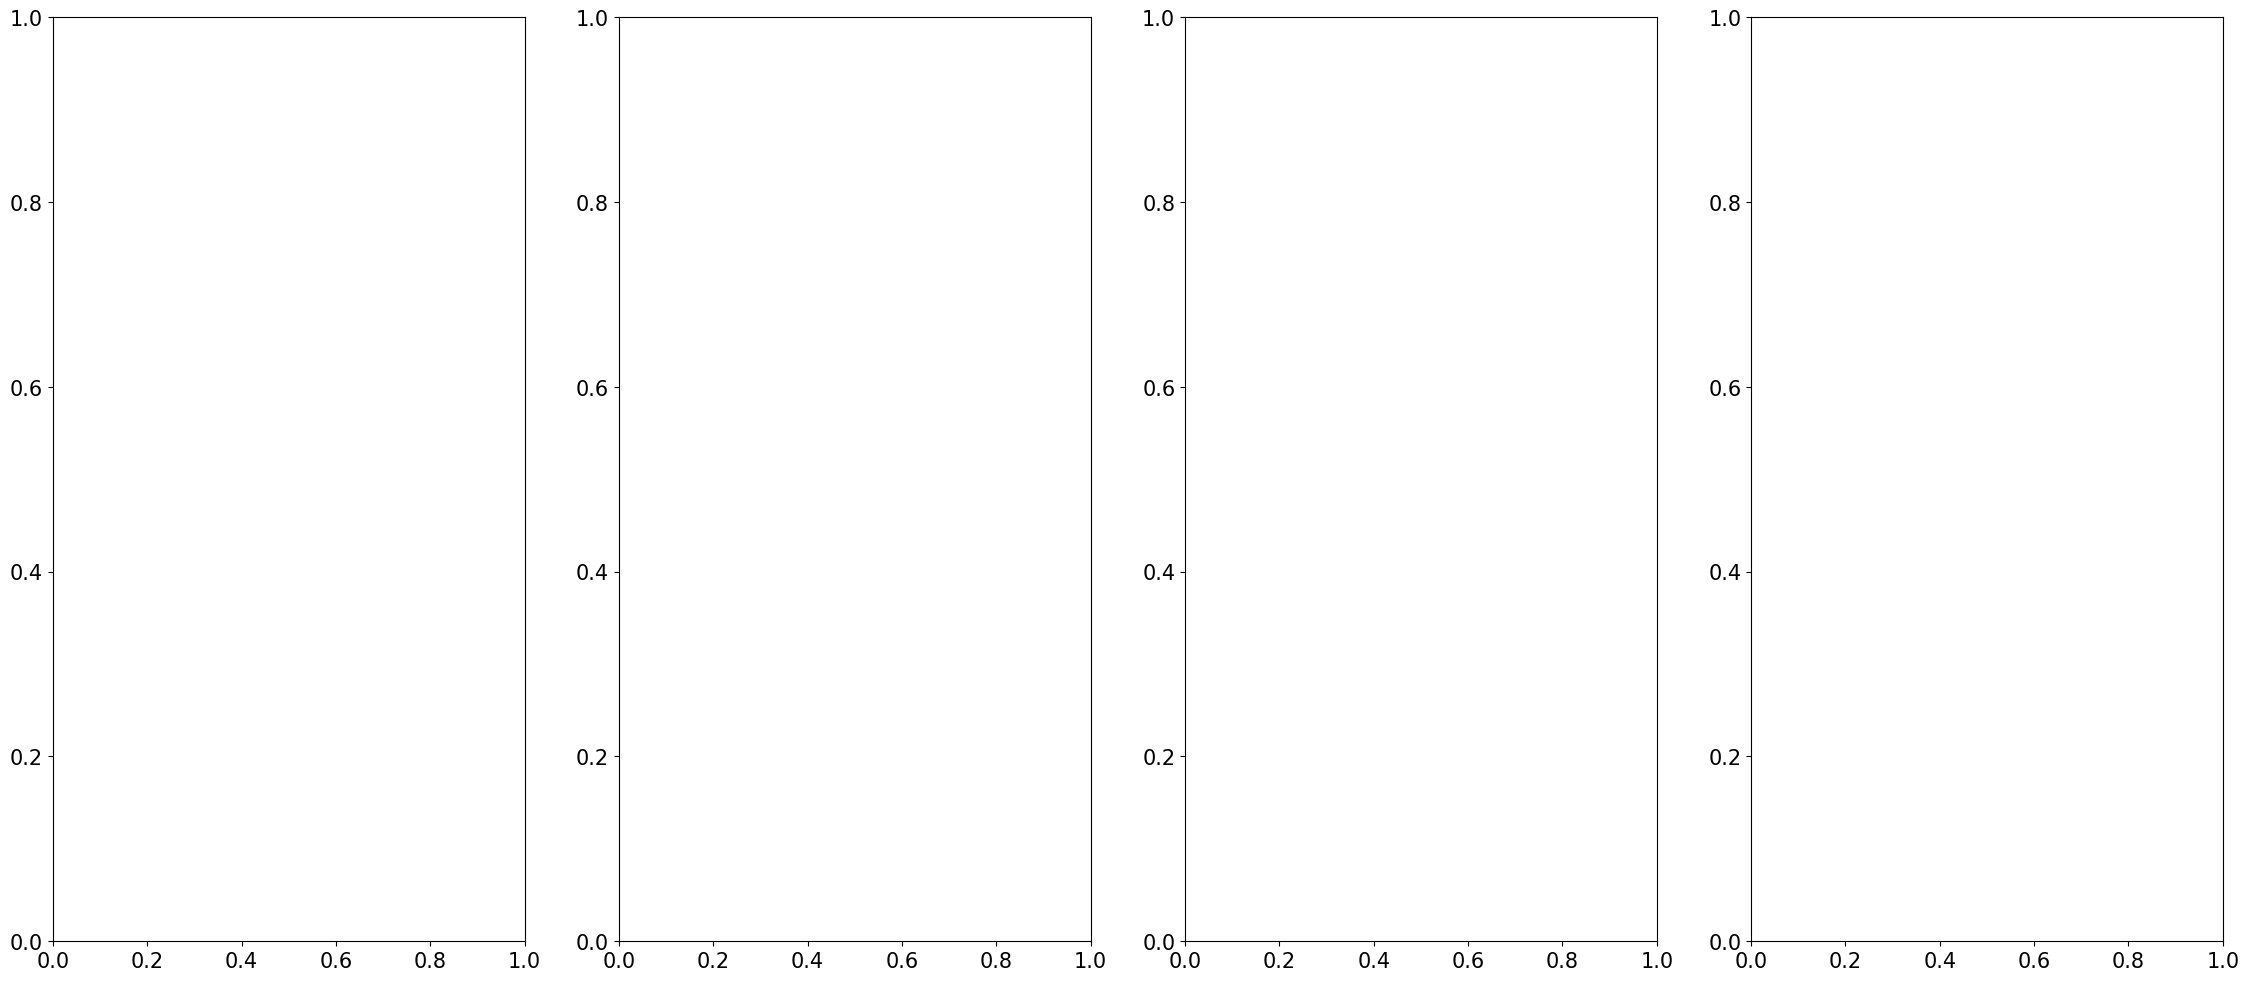

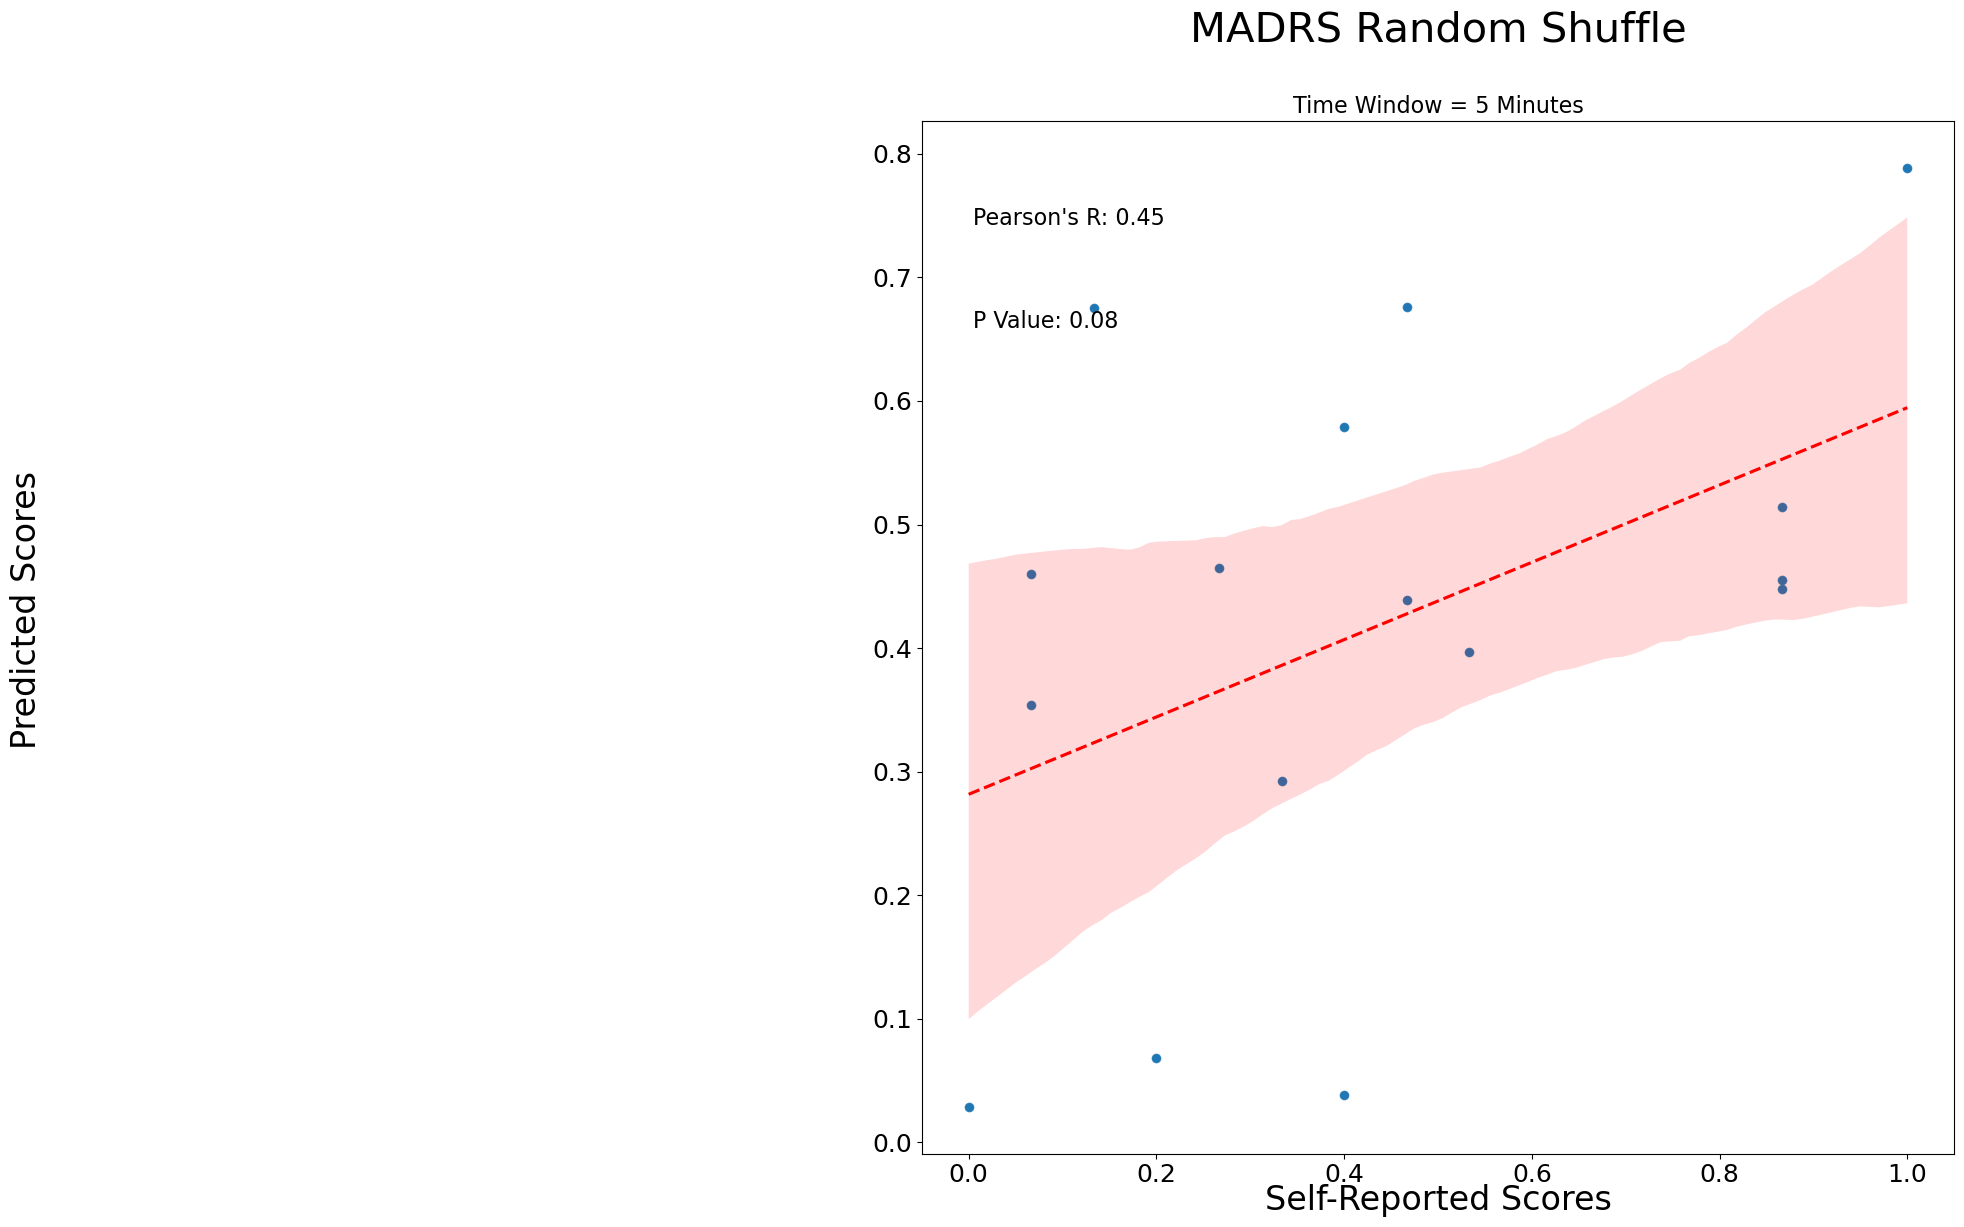

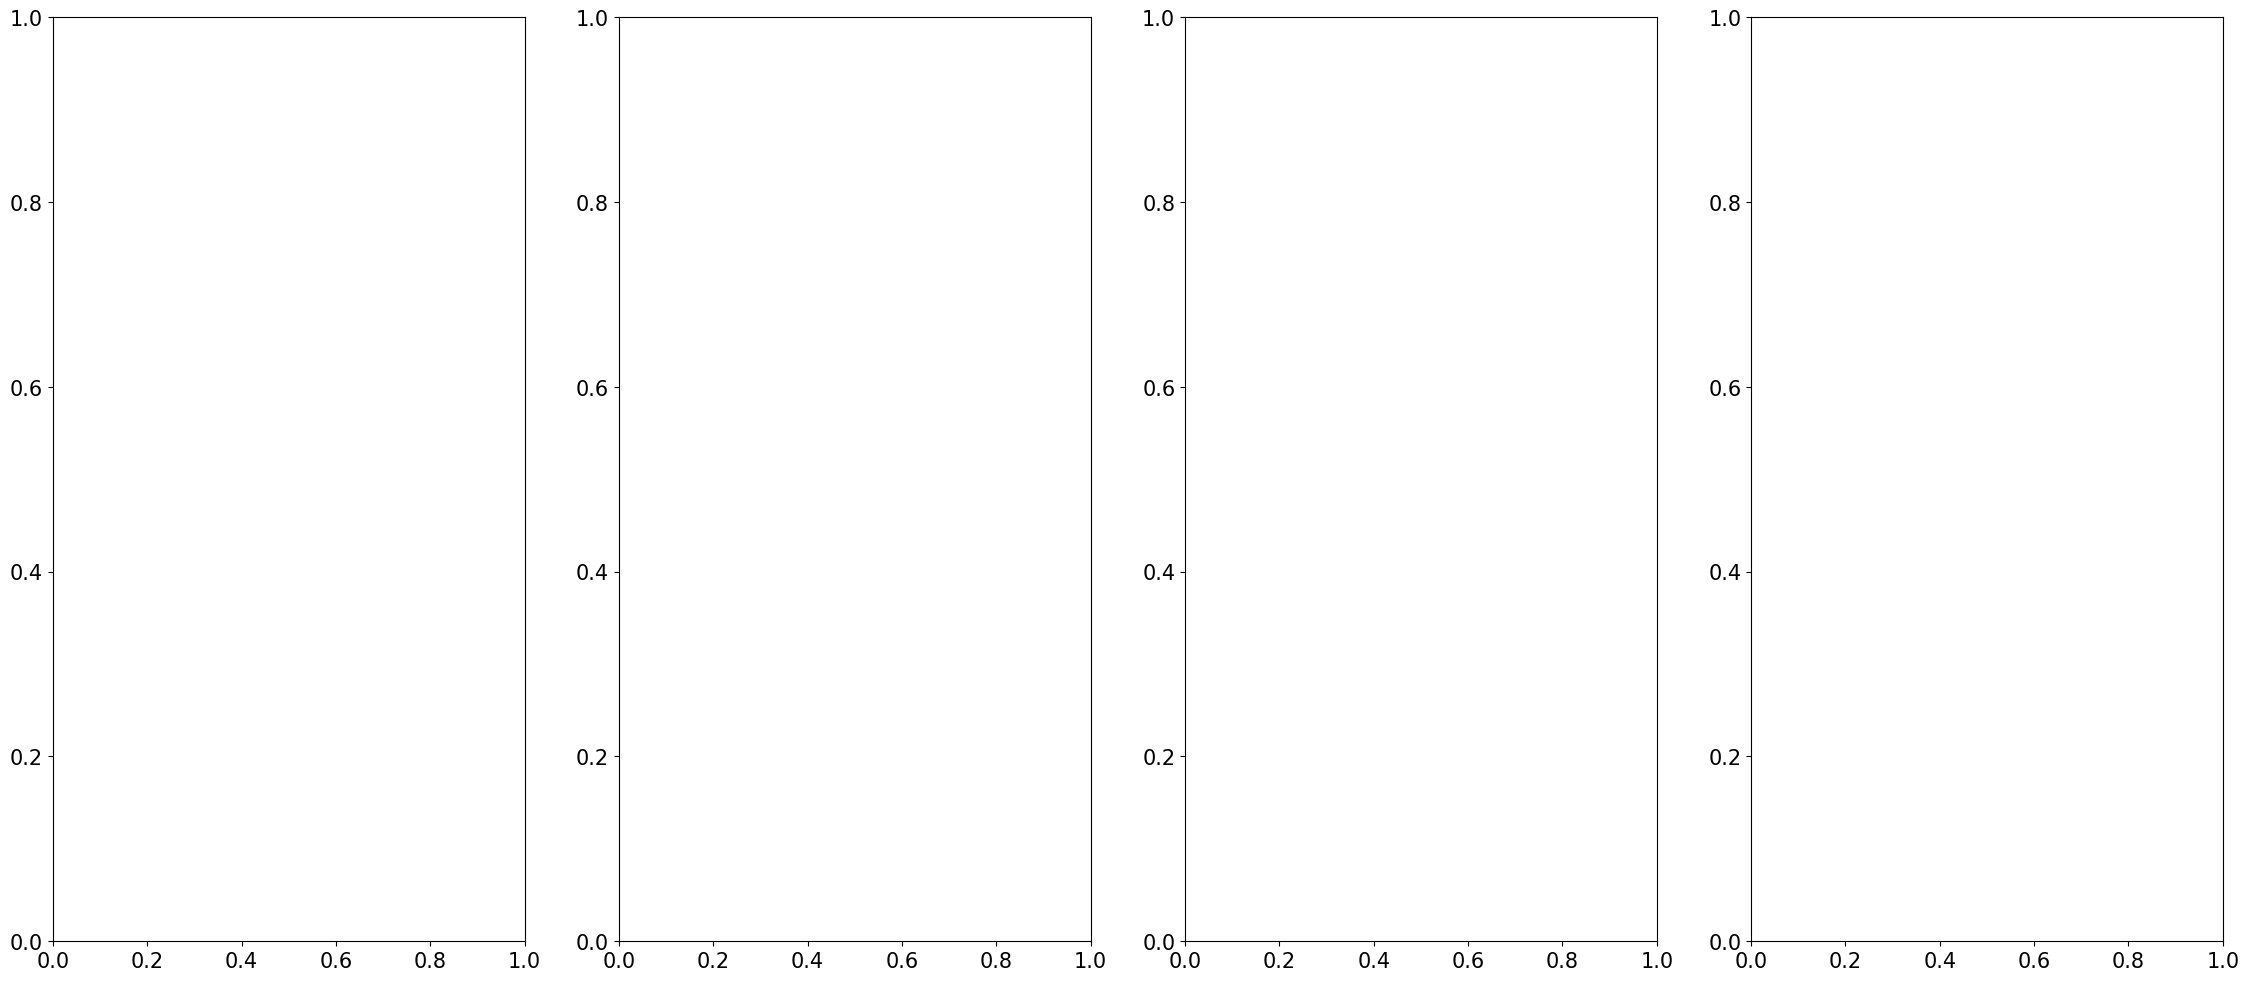

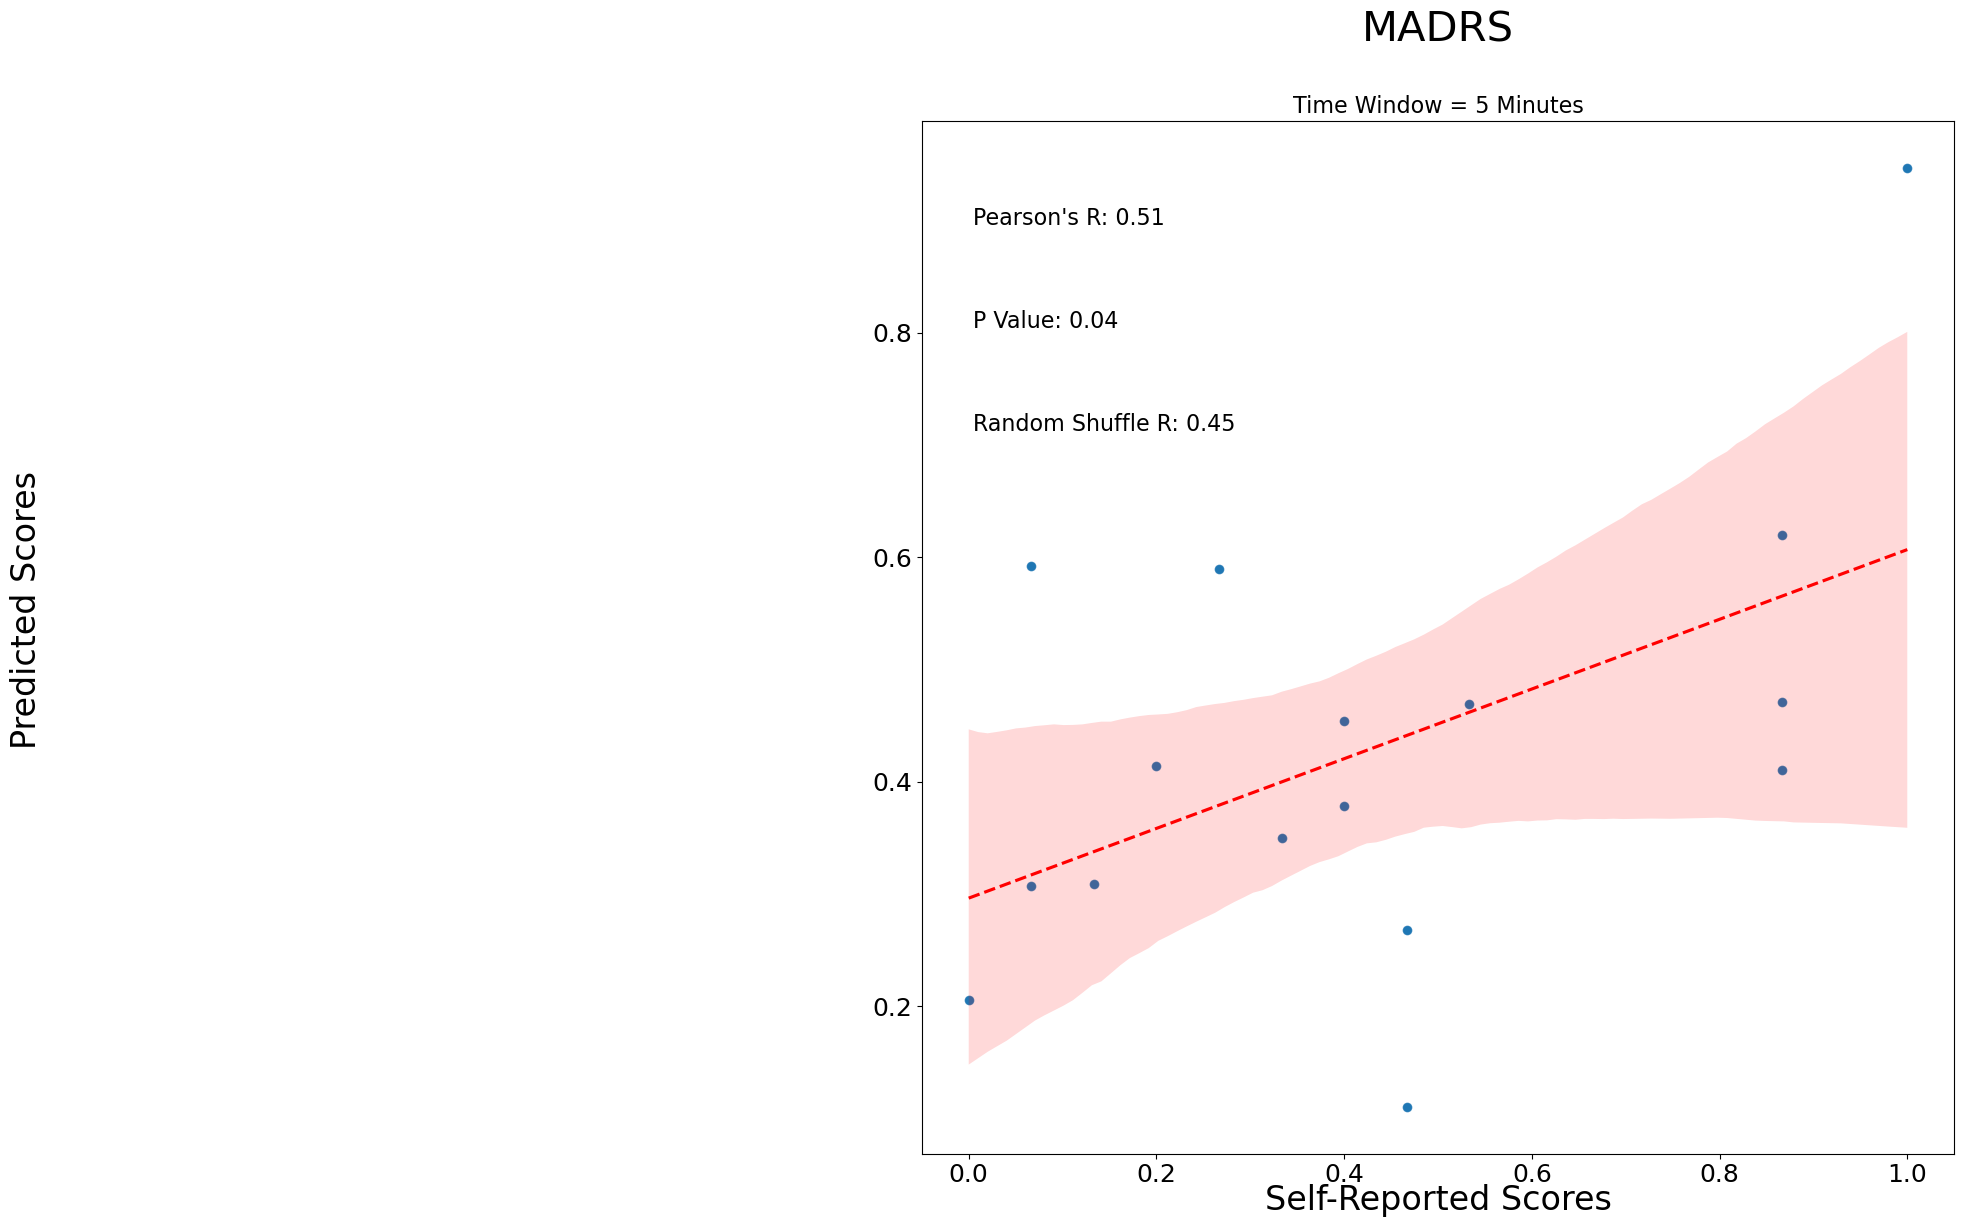

In [411]:
# Predict with just correlated features

all_metrics = [col for col in df_moodTracking.columns if col != 'Datetime']

FILE_ENDING = '.png'

# We are just searching using lasso regression
#RESULTS_PREFIX_LIST = ['OF_L_', 'OGAU_L_', 'OFAUHSE_L_', 'OGAUHSE_L_', 'HSE_L_', 'ALL_L_']
#RESULTS_PREFIX_LIST = ['OGAU_L_', 'OGAUHSE_L_', 'HSE_L_']
RESULTS_PREFIX_LIST = ['OF_L_']


EMOTIONS_FOR_SEARCH = ['MADRS'] # We are just searching on Mood
TIME_WINDOW_FOR_SEARCH = 5
HARDCODED_ALPHA = 0


for RESULTS_PREFIX in RESULTS_PREFIX_LIST:
  do_lasso = False
  do_ridge = False

  if '_L_' in RESULTS_PREFIX:
    do_lasso = True

  if '_R_' in RESULTS_PREFIX:
    do_ridge = True


  if 'OF_' in RESULTS_PREFIX:
    spreadsheet_path = FEATURE_LABEL_PATH+f'experimental_openface_0.5_hours.xlsx'
    vectors_now = openface_vectors_dict
    method_now = 'OpenFace'

  elif 'OGAU_' in RESULTS_PREFIX:
    spreadsheet_path = FEATURE_LABEL_PATH+'opengraphau_0.5_hours.xlsx'
    vectors_now = opengraphau_vectors_dict
    method_now = 'OpenGraphAU'

  elif 'OFAUHSE_' in RESULTS_PREFIX:
    spreadsheet_path = FEATURE_LABEL_PATH+'ofauhse_0.5_hours.xlsx'
    vectors_now = ofauhsemotion_vectors_dict
    method_now = 'OFAU+HSE'

  elif 'OGAUHSE_' in RESULTS_PREFIX:
    spreadsheet_path = FEATURE_LABEL_PATH+'ogauhse_0.5_hours.xlsx'
    vectors_now = ogauhsemotion_vectors_dict
    method_now = 'OGAU+HSE'

  elif 'HSE_' in RESULTS_PREFIX:
    spreadsheet_path = FEATURE_LABEL_PATH+'hsemotion_0.5_hours.xlsx'
    vectors_now = hsemotion_vectors_dict
    method_now = 'HSEmotion'

  elif 'ALL_' in RESULTS_PREFIX:
    spreadsheet_path = FEATURE_LABEL_PATH+'all_0.5_hours.xlsx'
    vectors_now = all_vectors_dict
    method_now = 'ALL(OF+OG+HSE)'


  # Let's put each setting in its own folder!
  os.makedirs(RESULTS_PATH_BASE + 'SANITY_CHECK_Corr/' + RESULTS_PREFIX, exist_ok=True)
  results_prefix_unmodified = RESULTS_PREFIX
  RESULTS_PREFIX = 'SANITY_CHECK_Corr/' + RESULTS_PREFIX + '/' + RESULTS_PREFIX


  # Loop through EMOTIONS_FOR_SEARCH
  for metric in EMOTIONS_FOR_SEARCH:
    print('METRIC NOW: ', metric)
    vectors_return, y = extractOneMetric(metric, vectors_now=vectors_now)

    # Limit to just one time window for this sanity check
    tmp_vectors = vectors_return
    vectors_return = {}
    vectors_return[TIME_WINDOW_FOR_SEARCH] = tmp_vectors[TIME_WINDOW_FOR_SEARCH]
    del tmp_vectors

    correlations = calculate_pearsons_r(vectors_return, y)

    MIN_THRESHOLD = 0.55

    vectors_return, feature_names = filter_features_by_correlation_and_get_labels(vectors_return, correlations, threshold=MIN_THRESHOLD, spreadsheet_path=spreadsheet_path)
    
    print(feature_names)
    
    scores, preds, y, models = linRegOneMetric(vectors_return, y, do_lasso=do_lasso, do_ridge=do_ridge, alpha=HARDCODED_ALPHA)
    scores_r, preds_r, _, models_r = linRegOneMetric(vectors_return, y, randShuffle=True, alpha=HARDCODED_ALPHA)

    # make scatterplots
    randShuffleR, _, _ = plot_scatterplots(preds_r, y, f'{metric} Random Shuffle', RESULTS_PATH_BASE + f'{RESULTS_PREFIX}{metric}_linReg_scatterRand_{alpha_now}{FILE_ENDING}')
    r_list, p_list, scatterFig = plot_scatterplots(preds, y, metric, RESULTS_PATH_BASE + f'{RESULTS_PREFIX}{metric}_linReg_scatterplots_{alpha_now}{FILE_ENDING}', randShuffleR=randShuffleR)
    
 

## Alpha Search

METRIC NOW:  MADRS


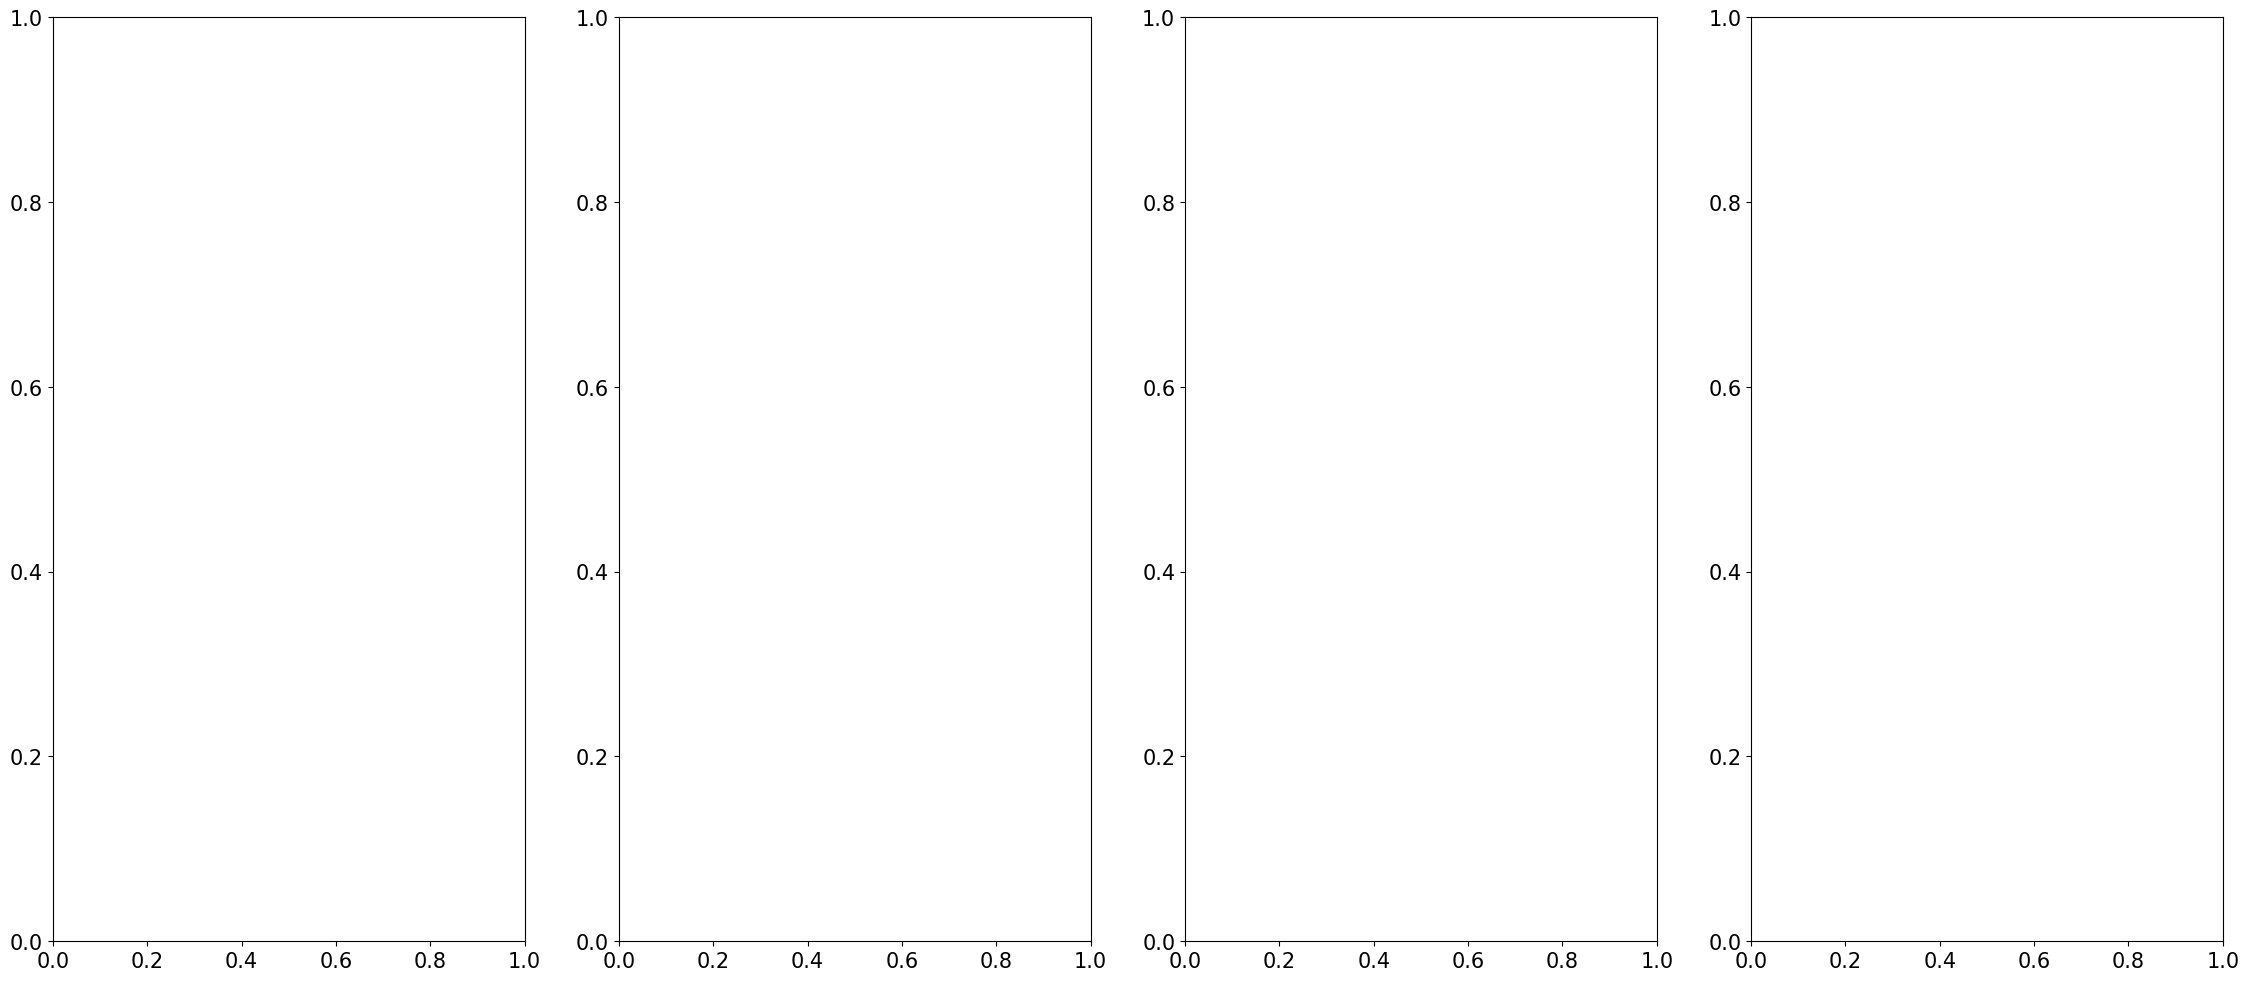

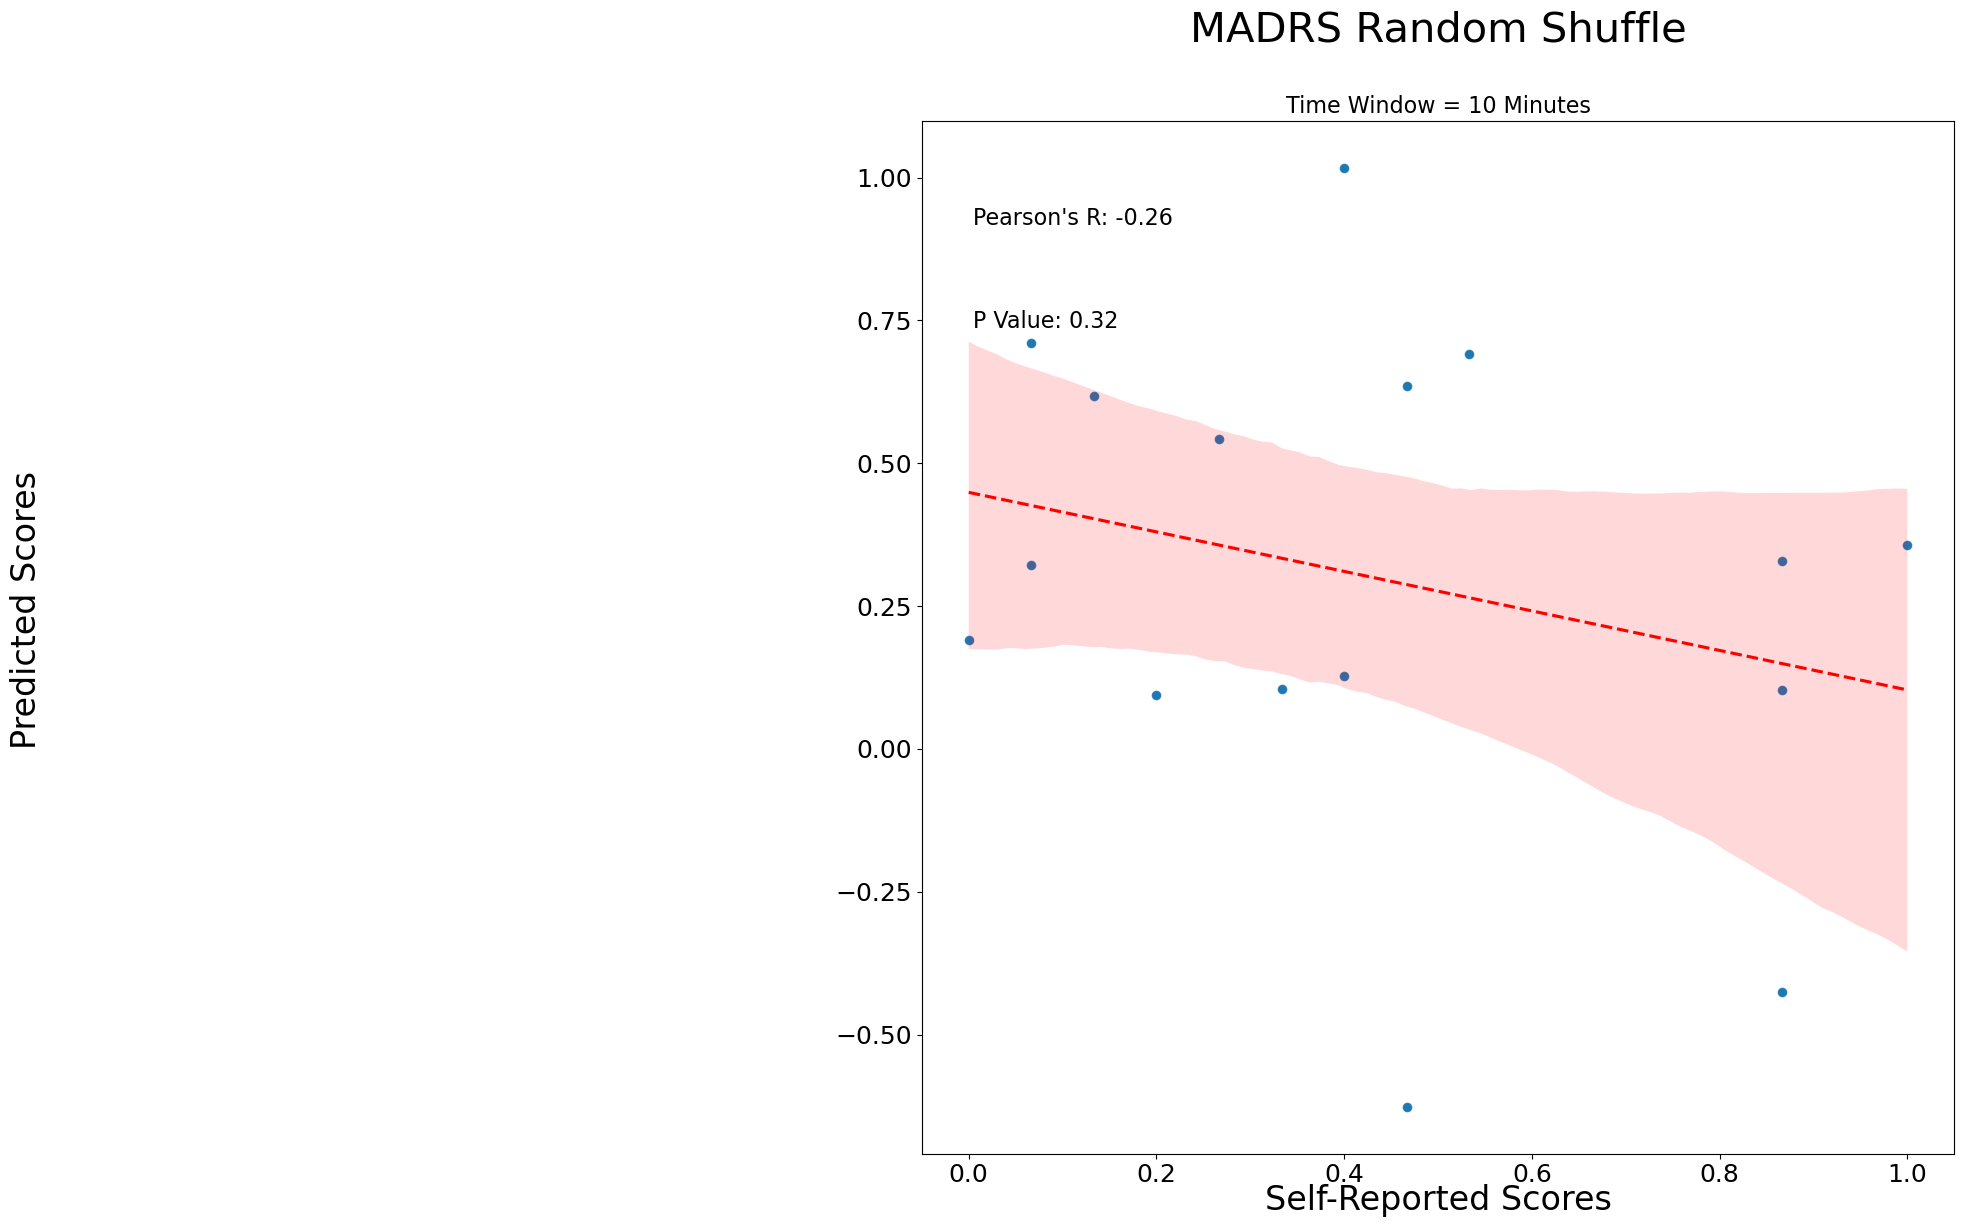

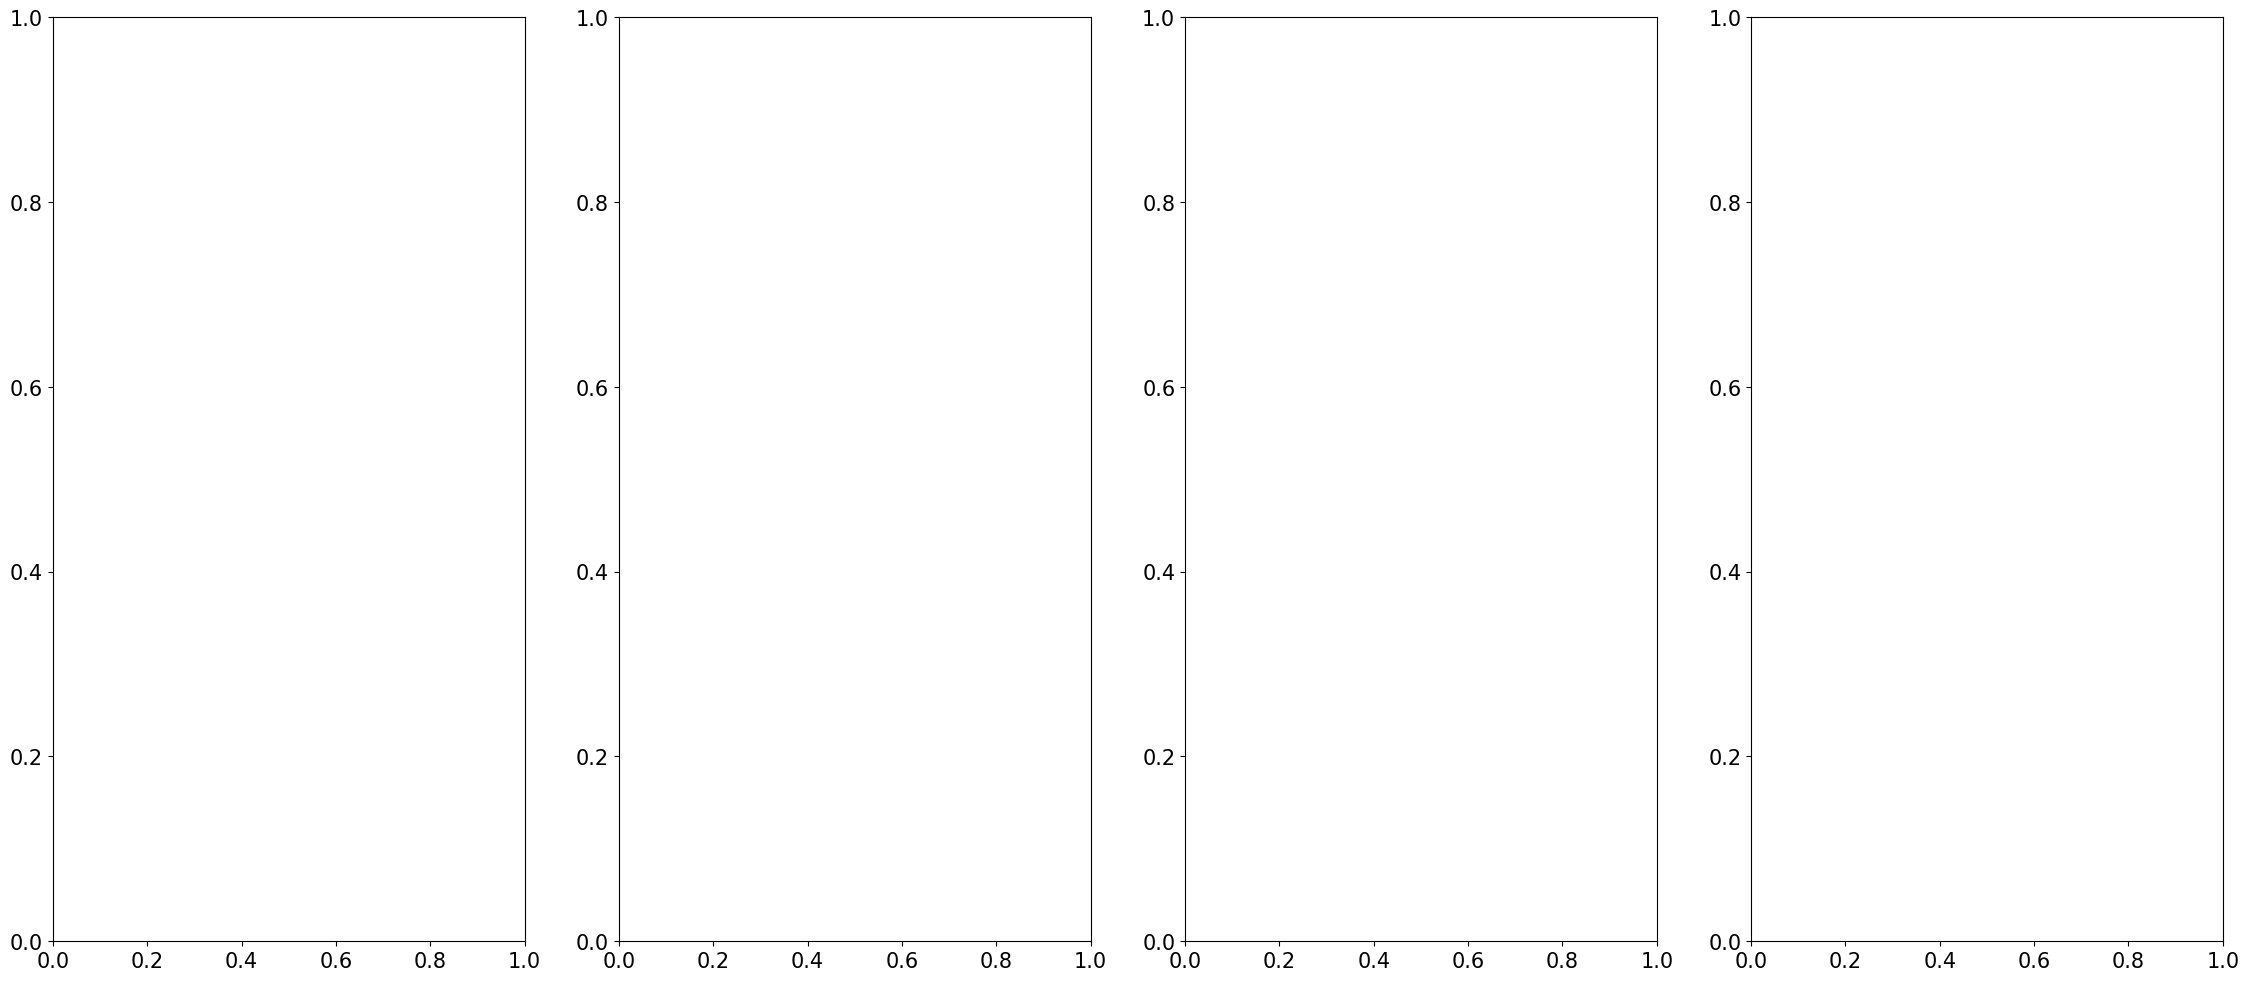

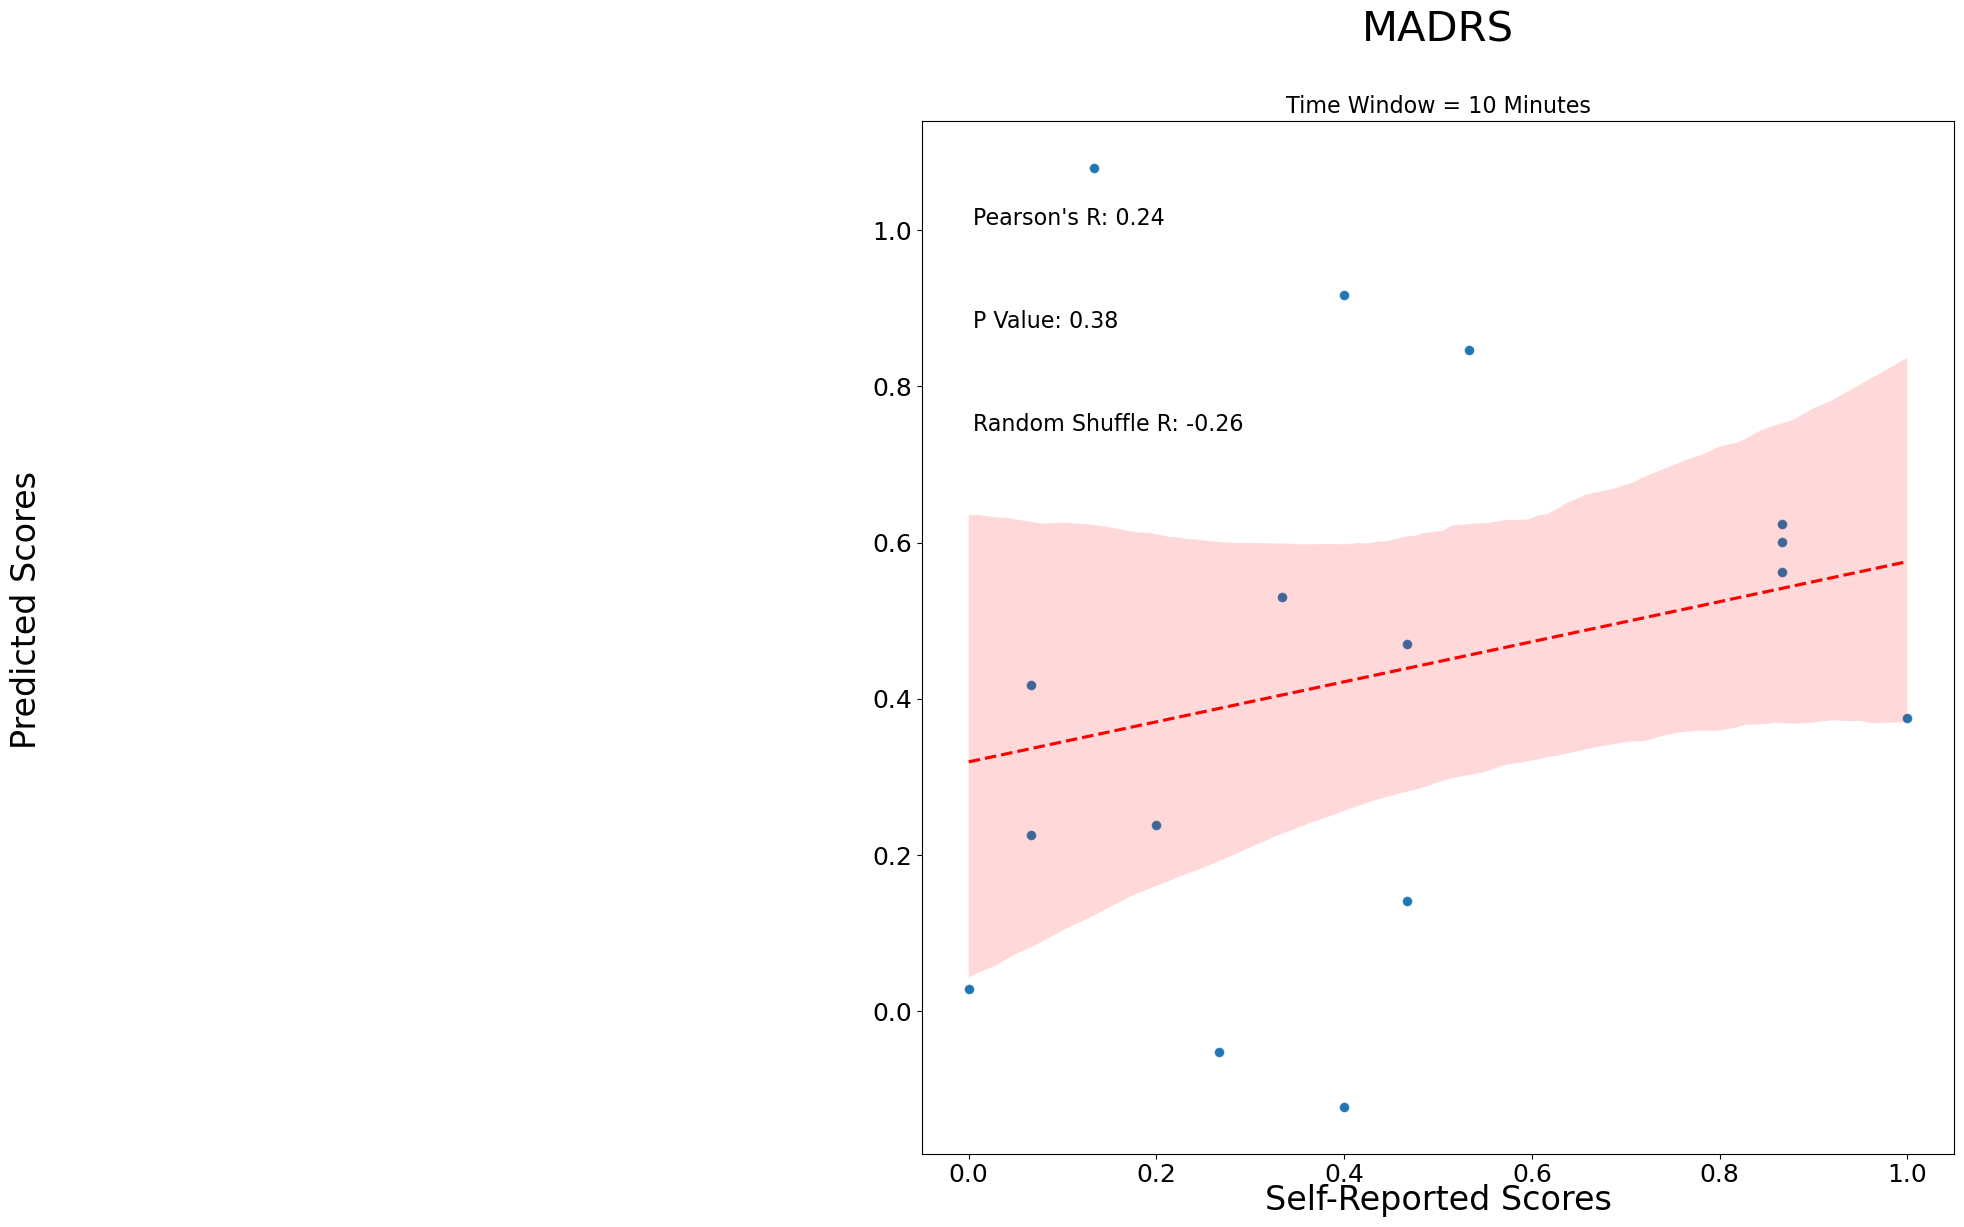

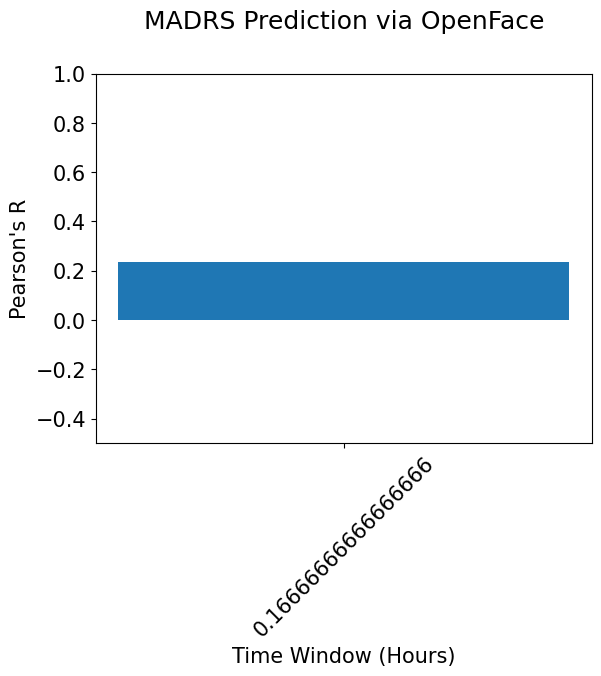

METRIC NOW:  MADRS


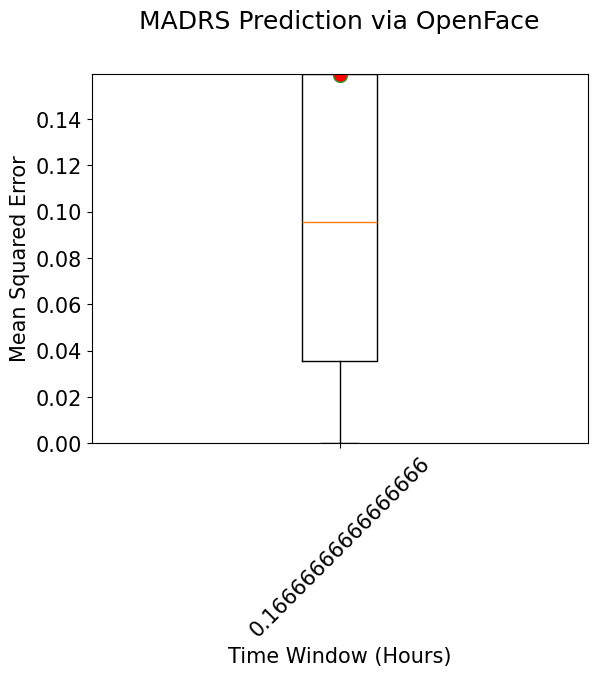

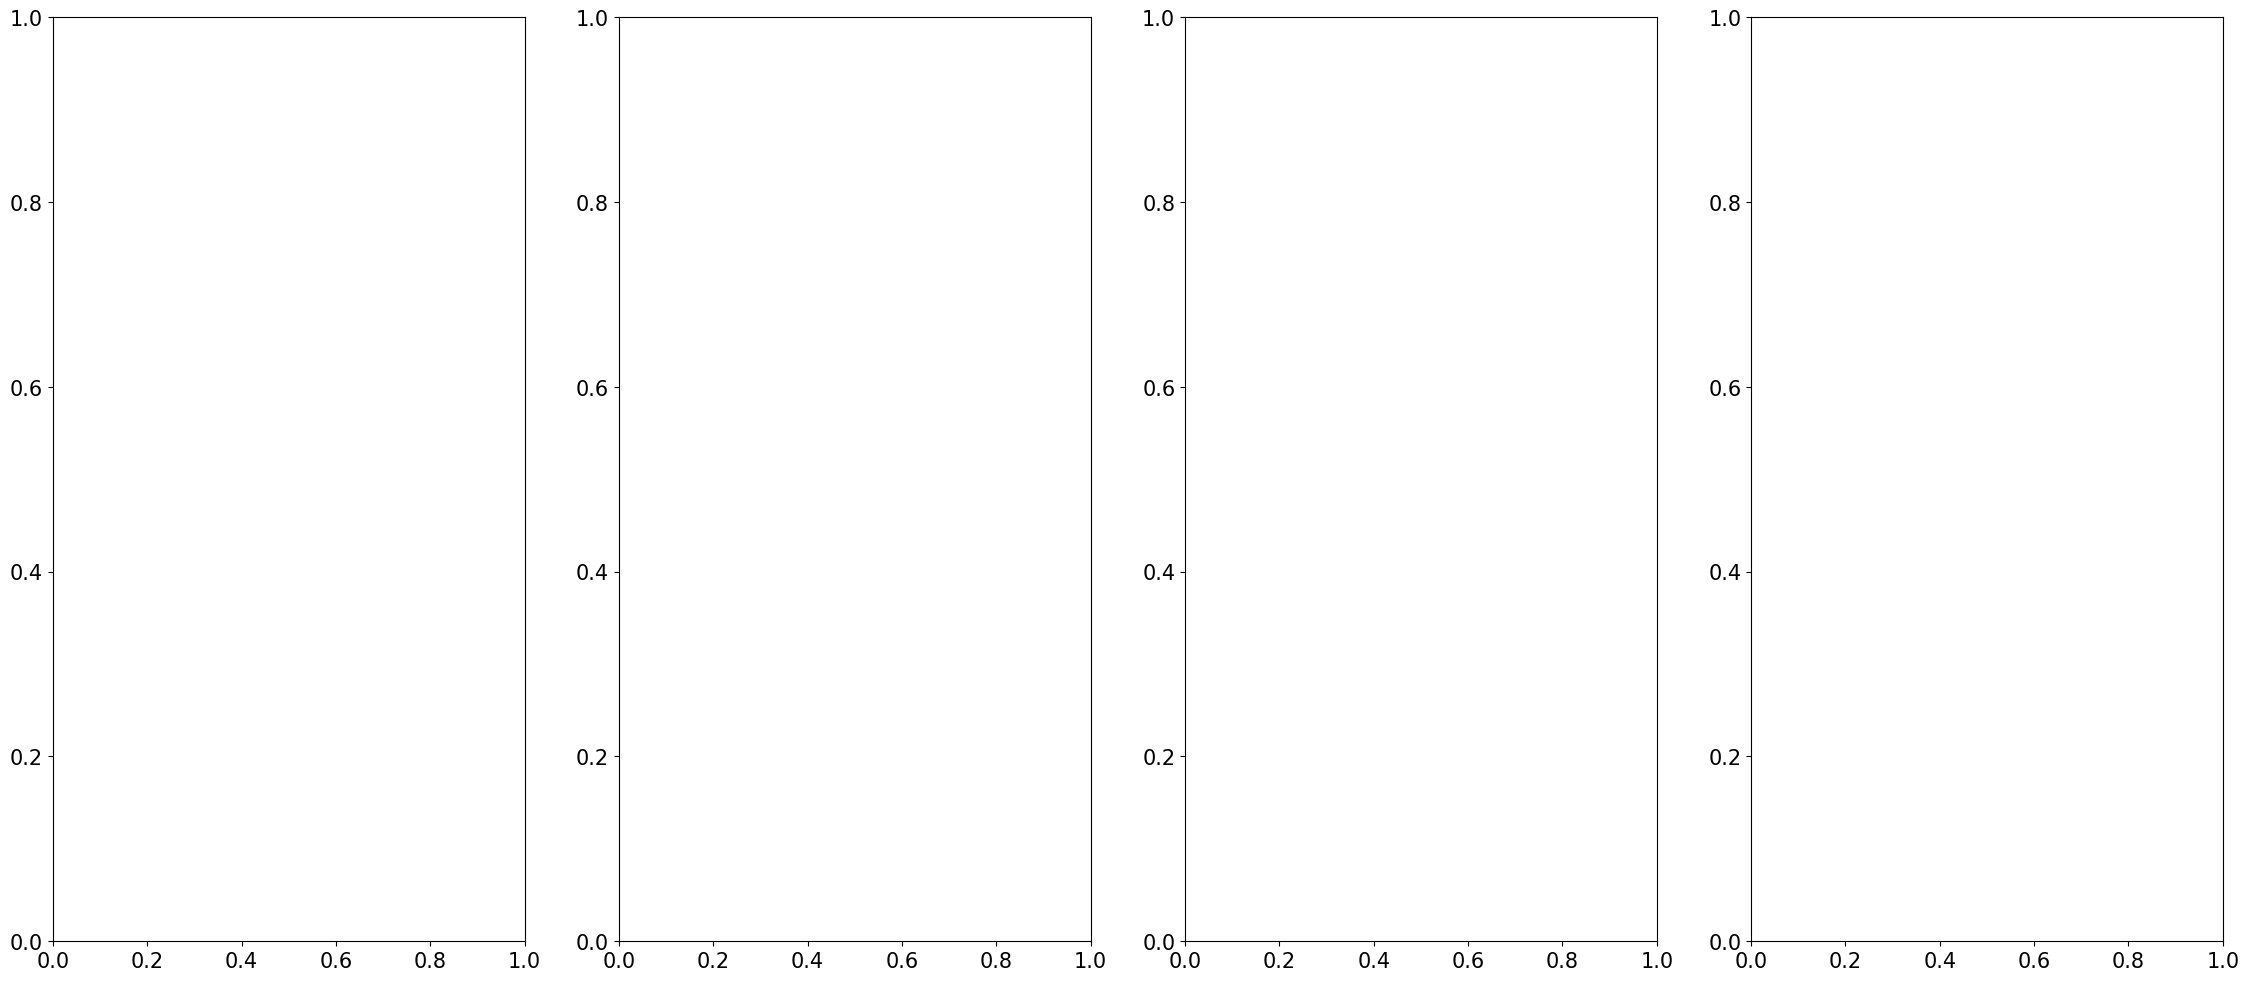

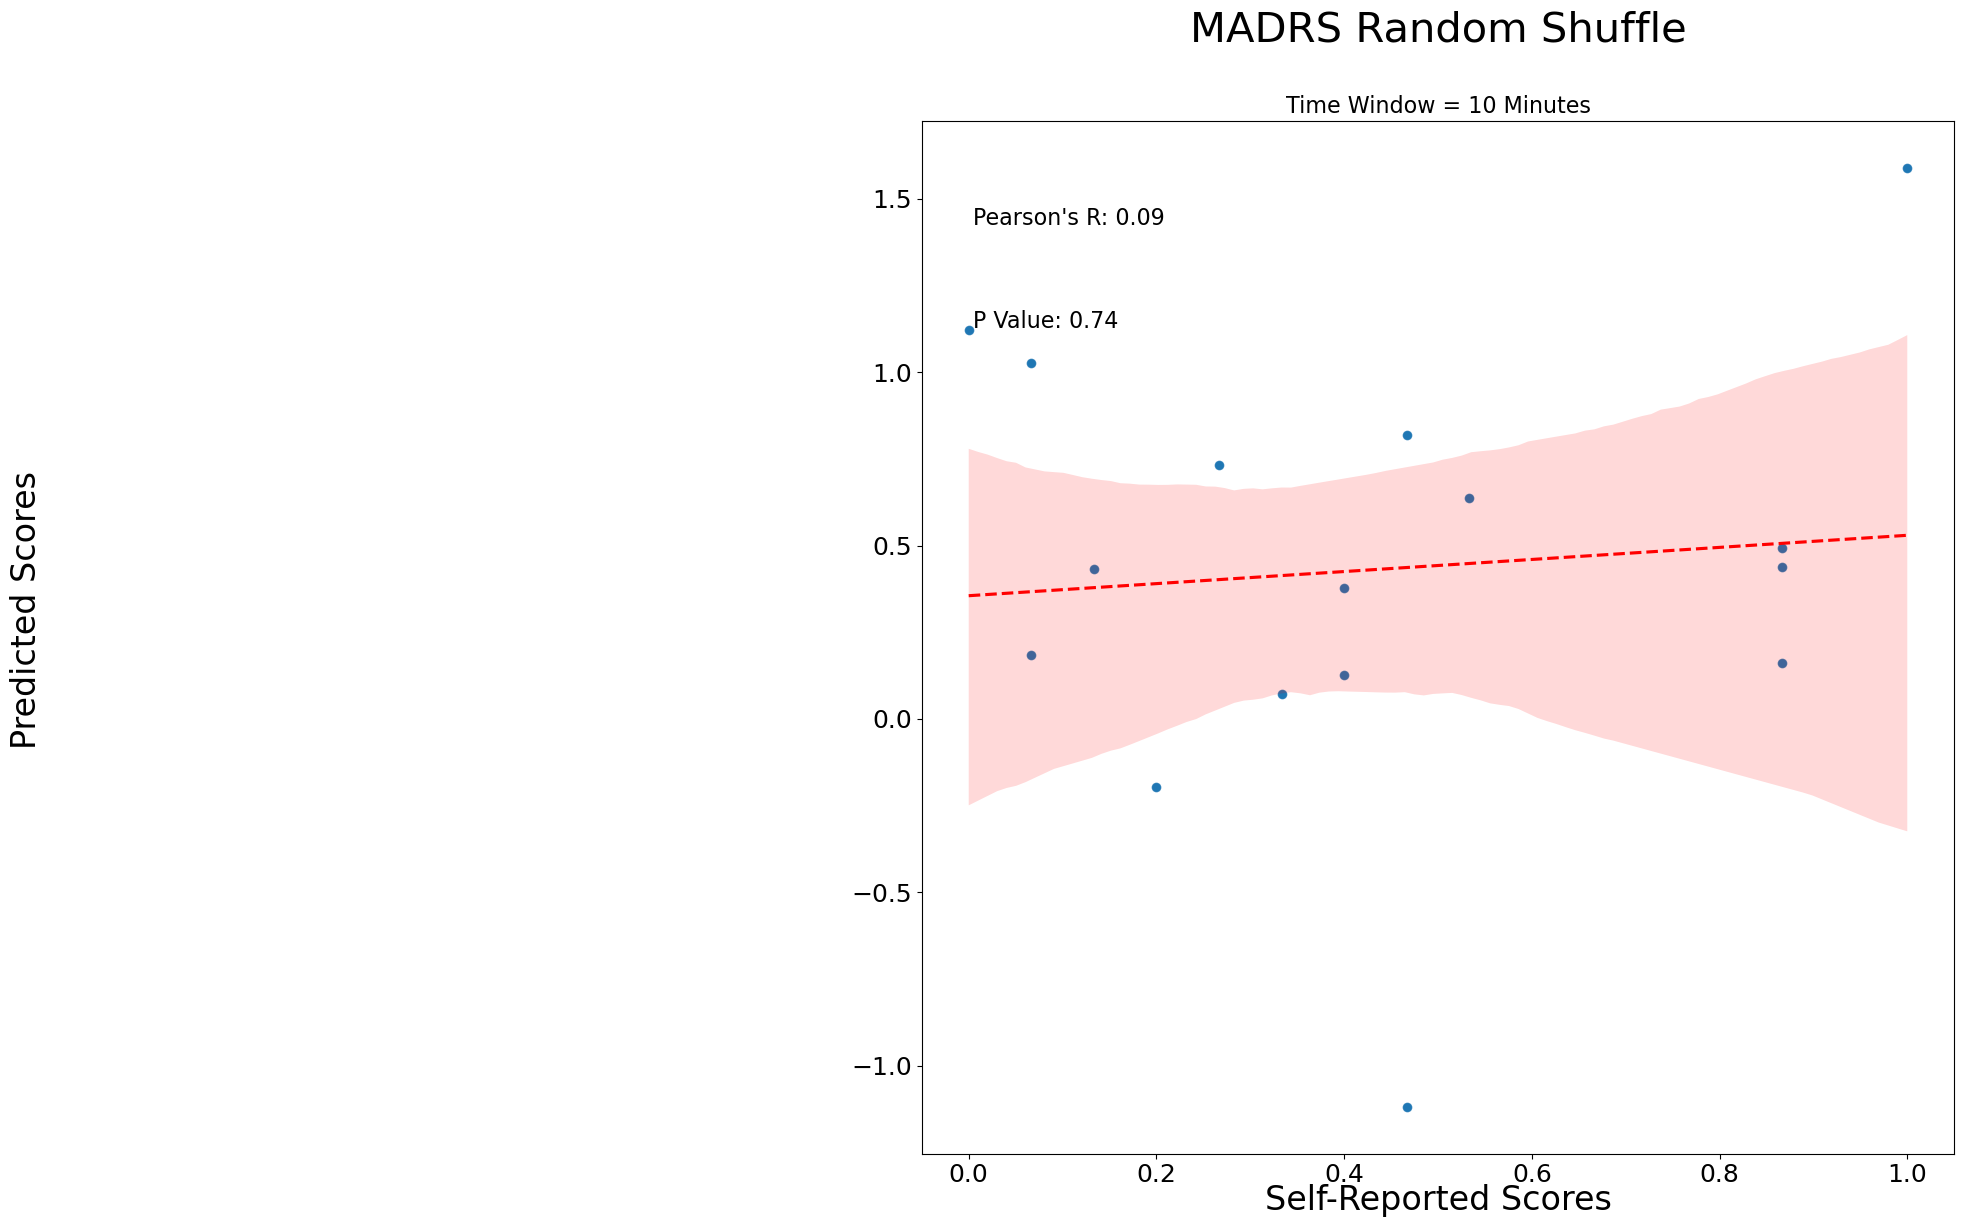

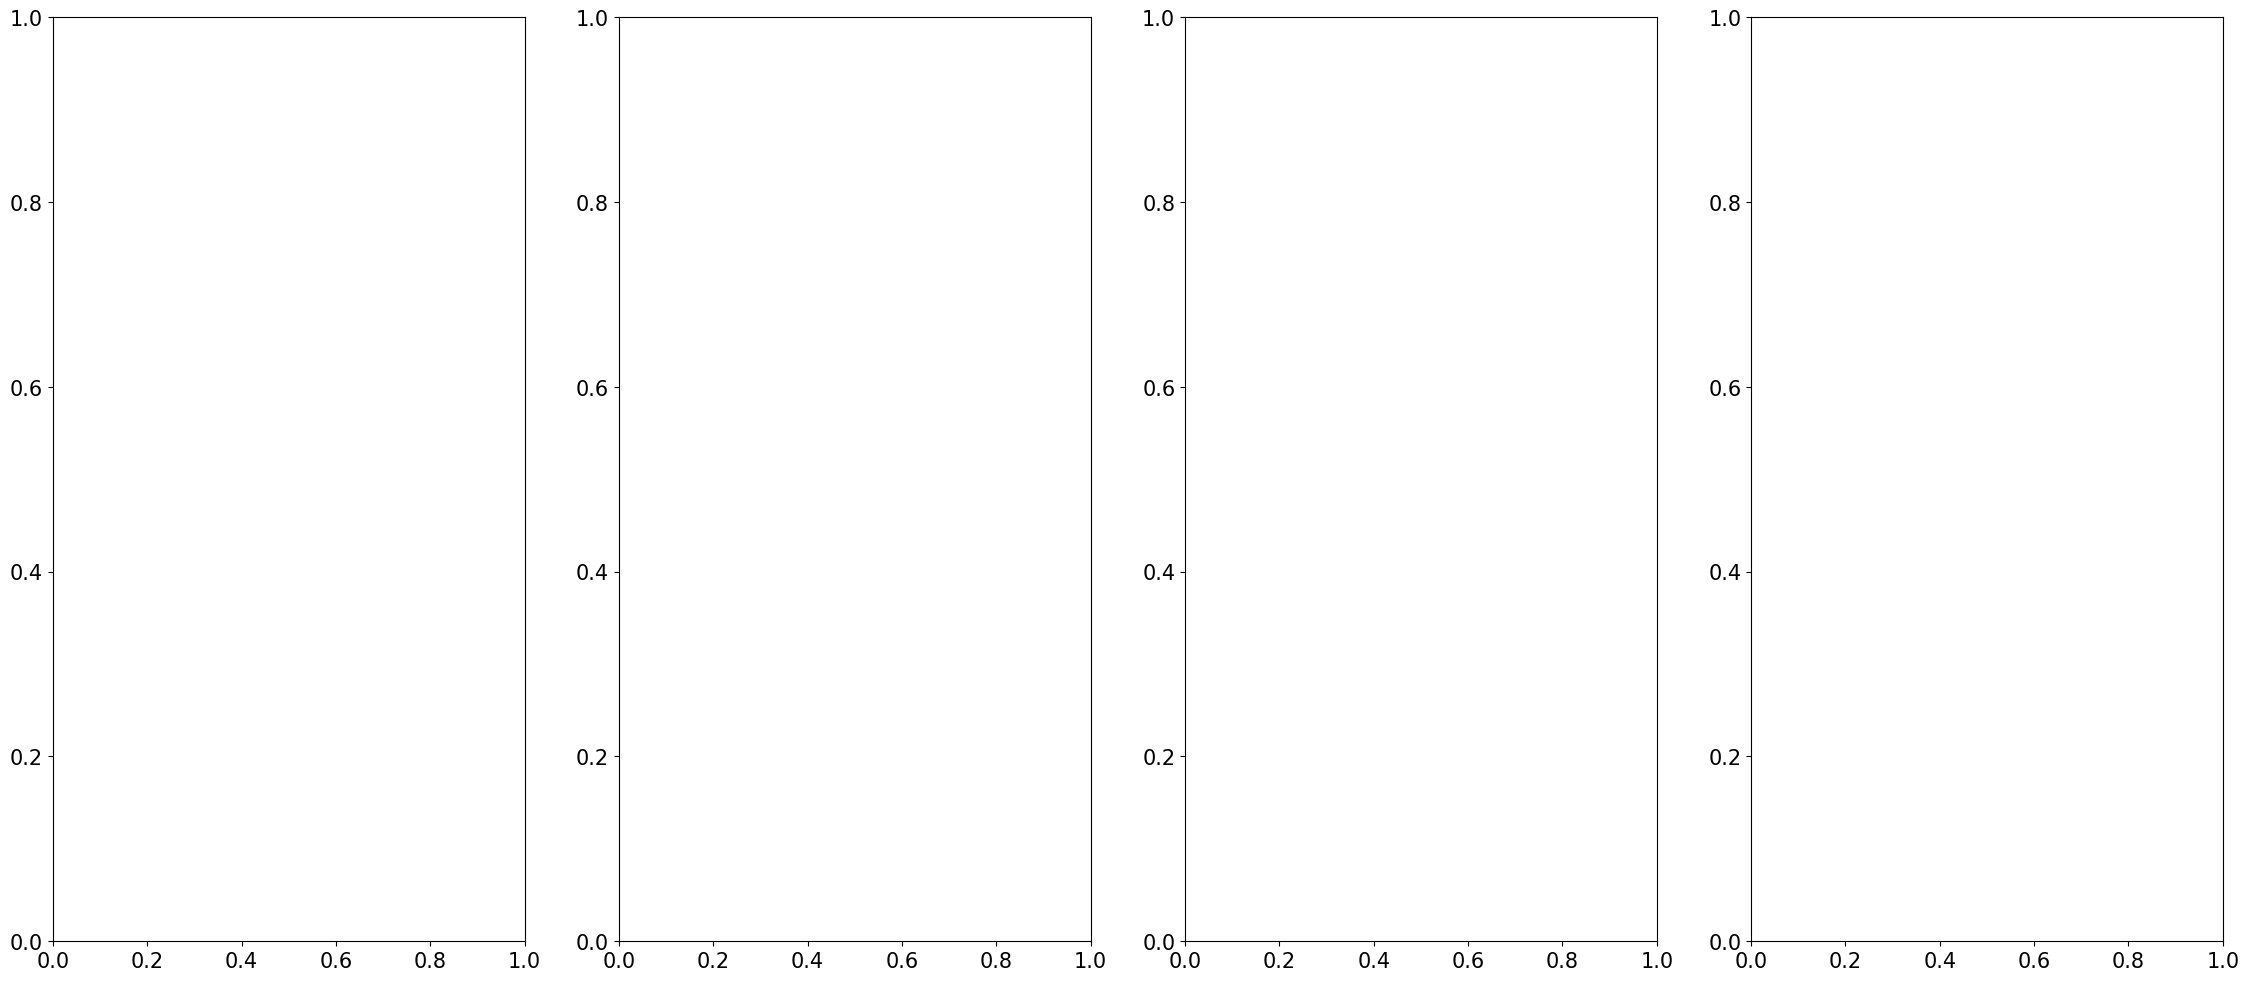

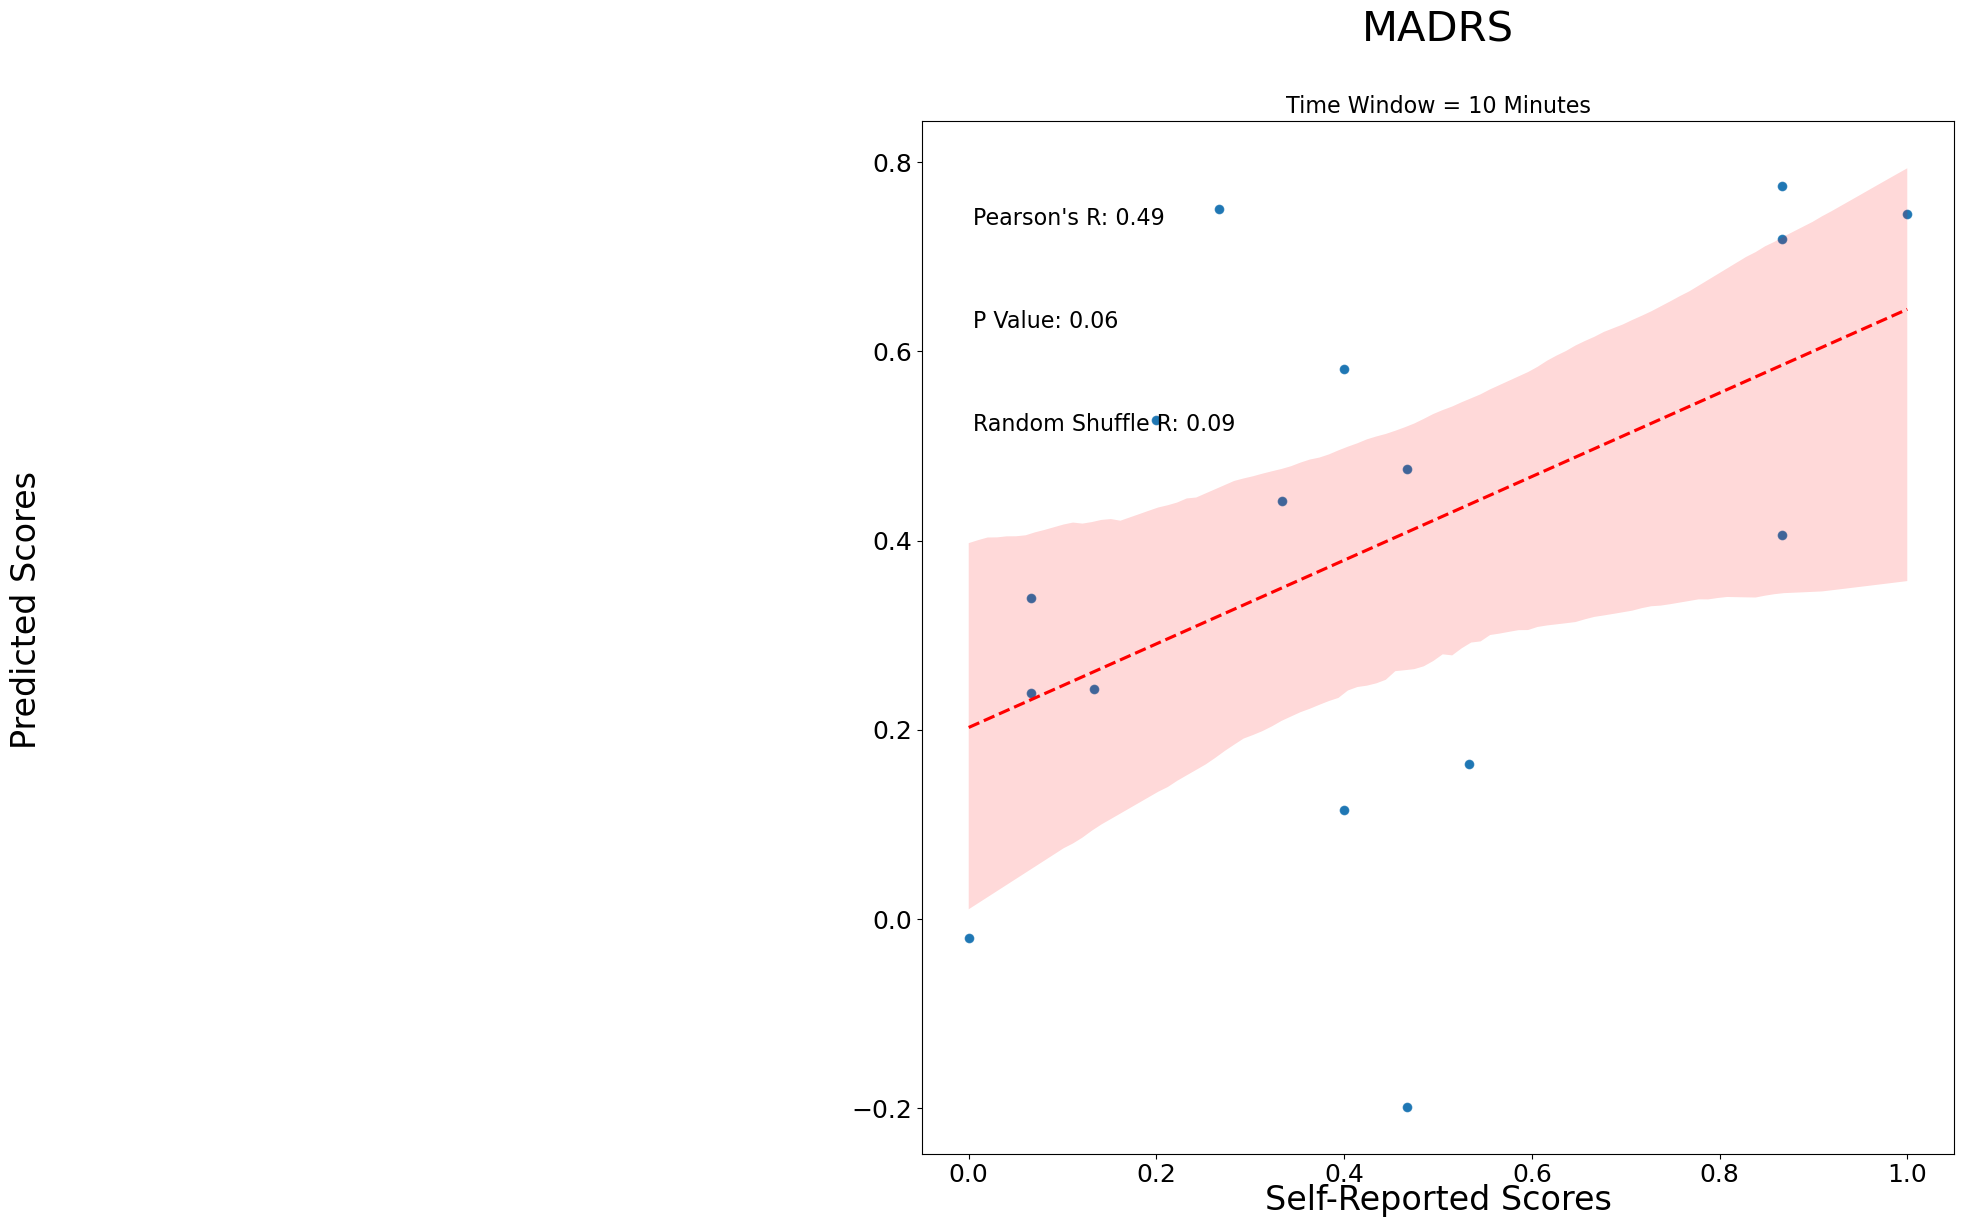

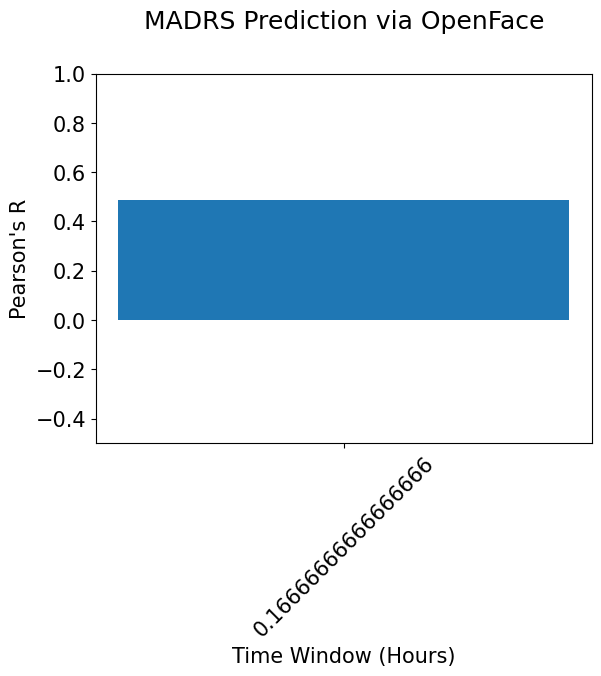

METRIC NOW:  MADRS


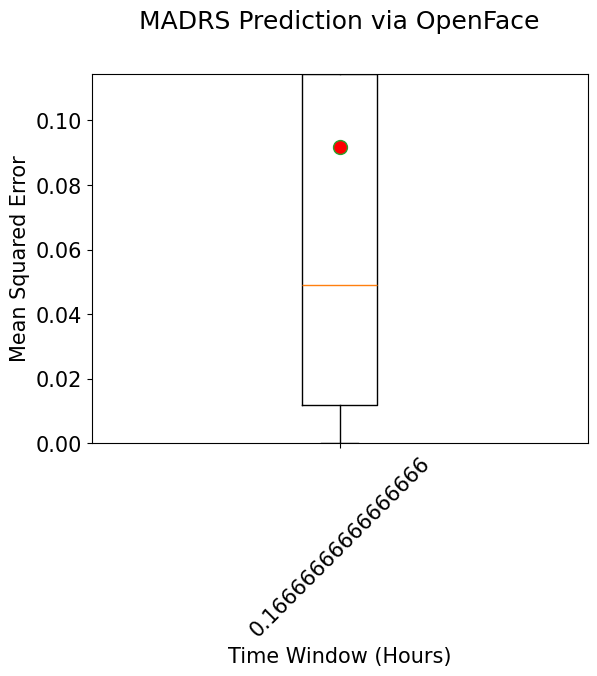

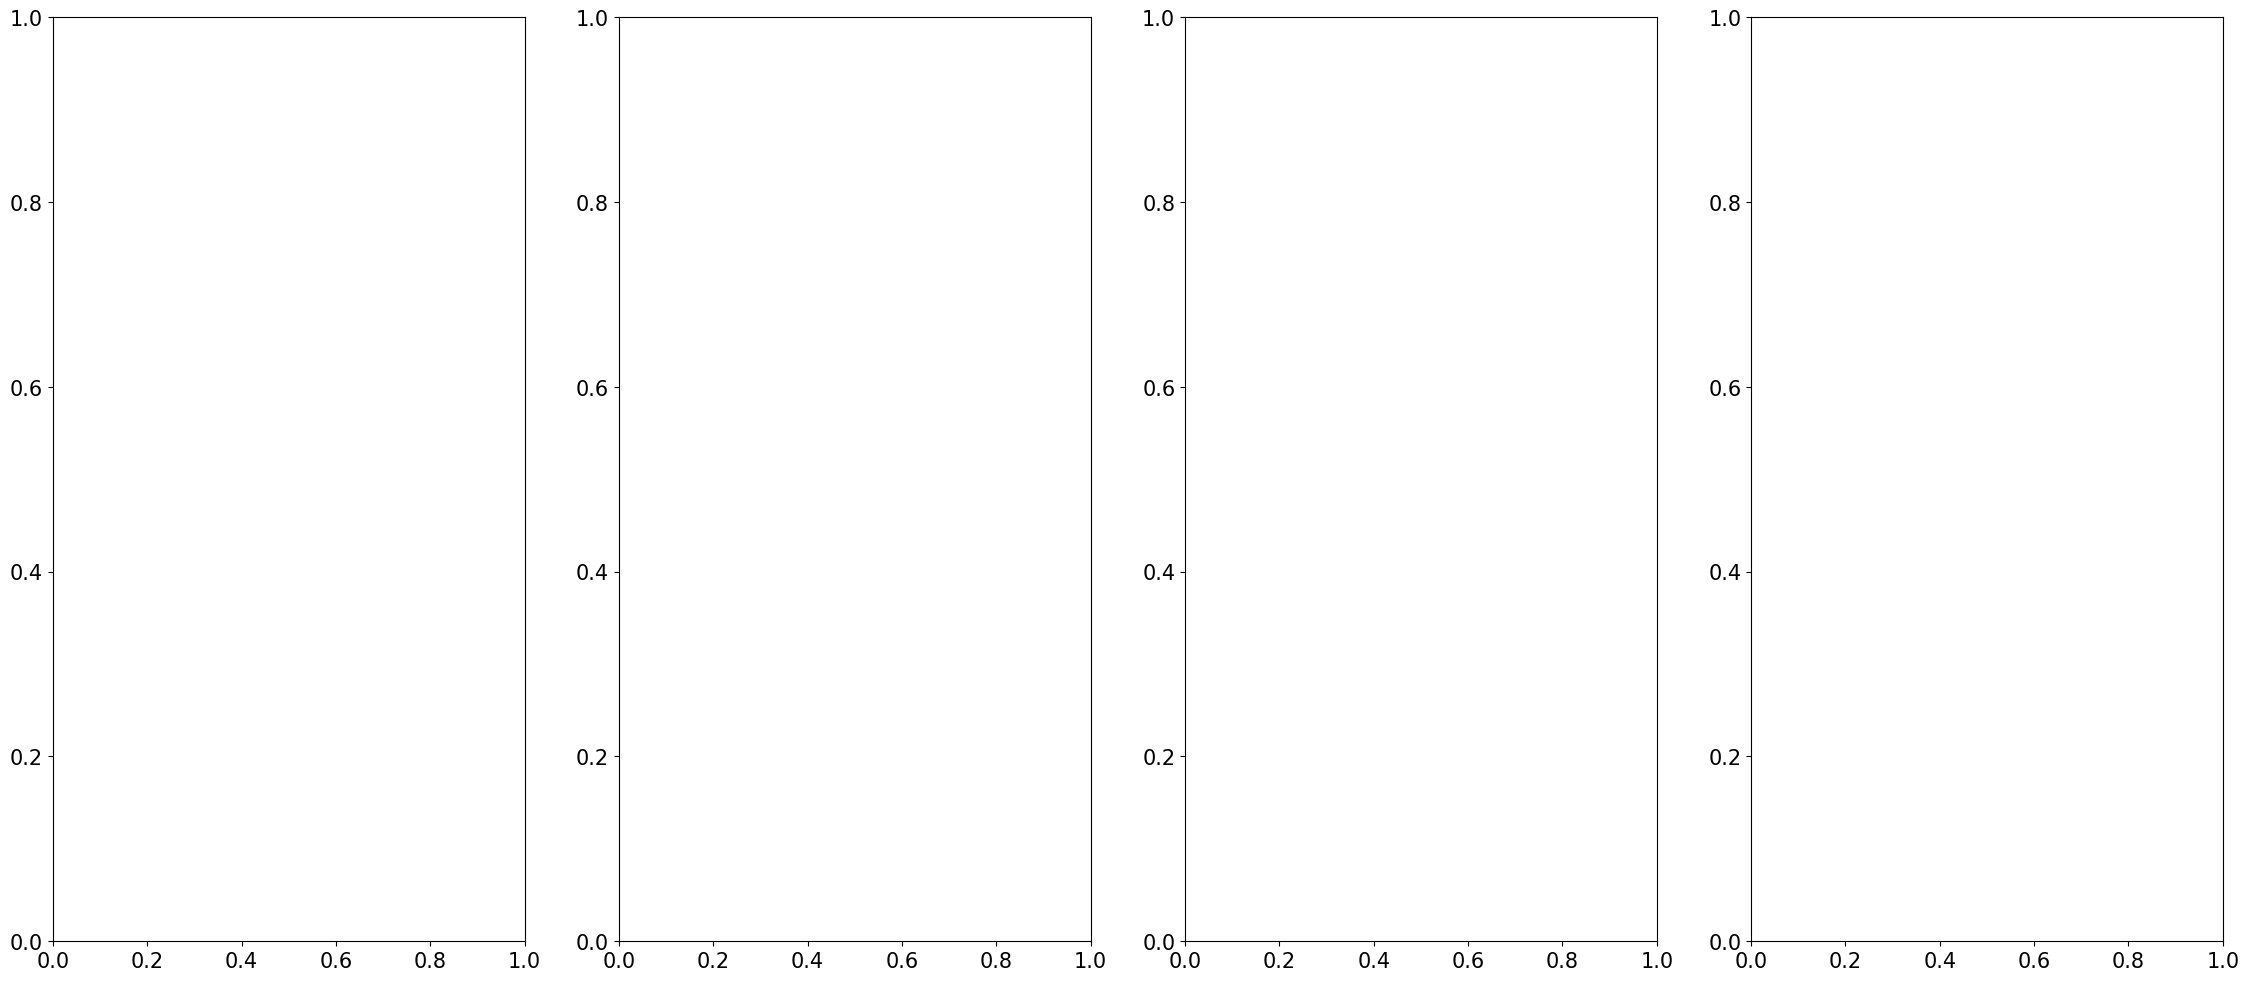

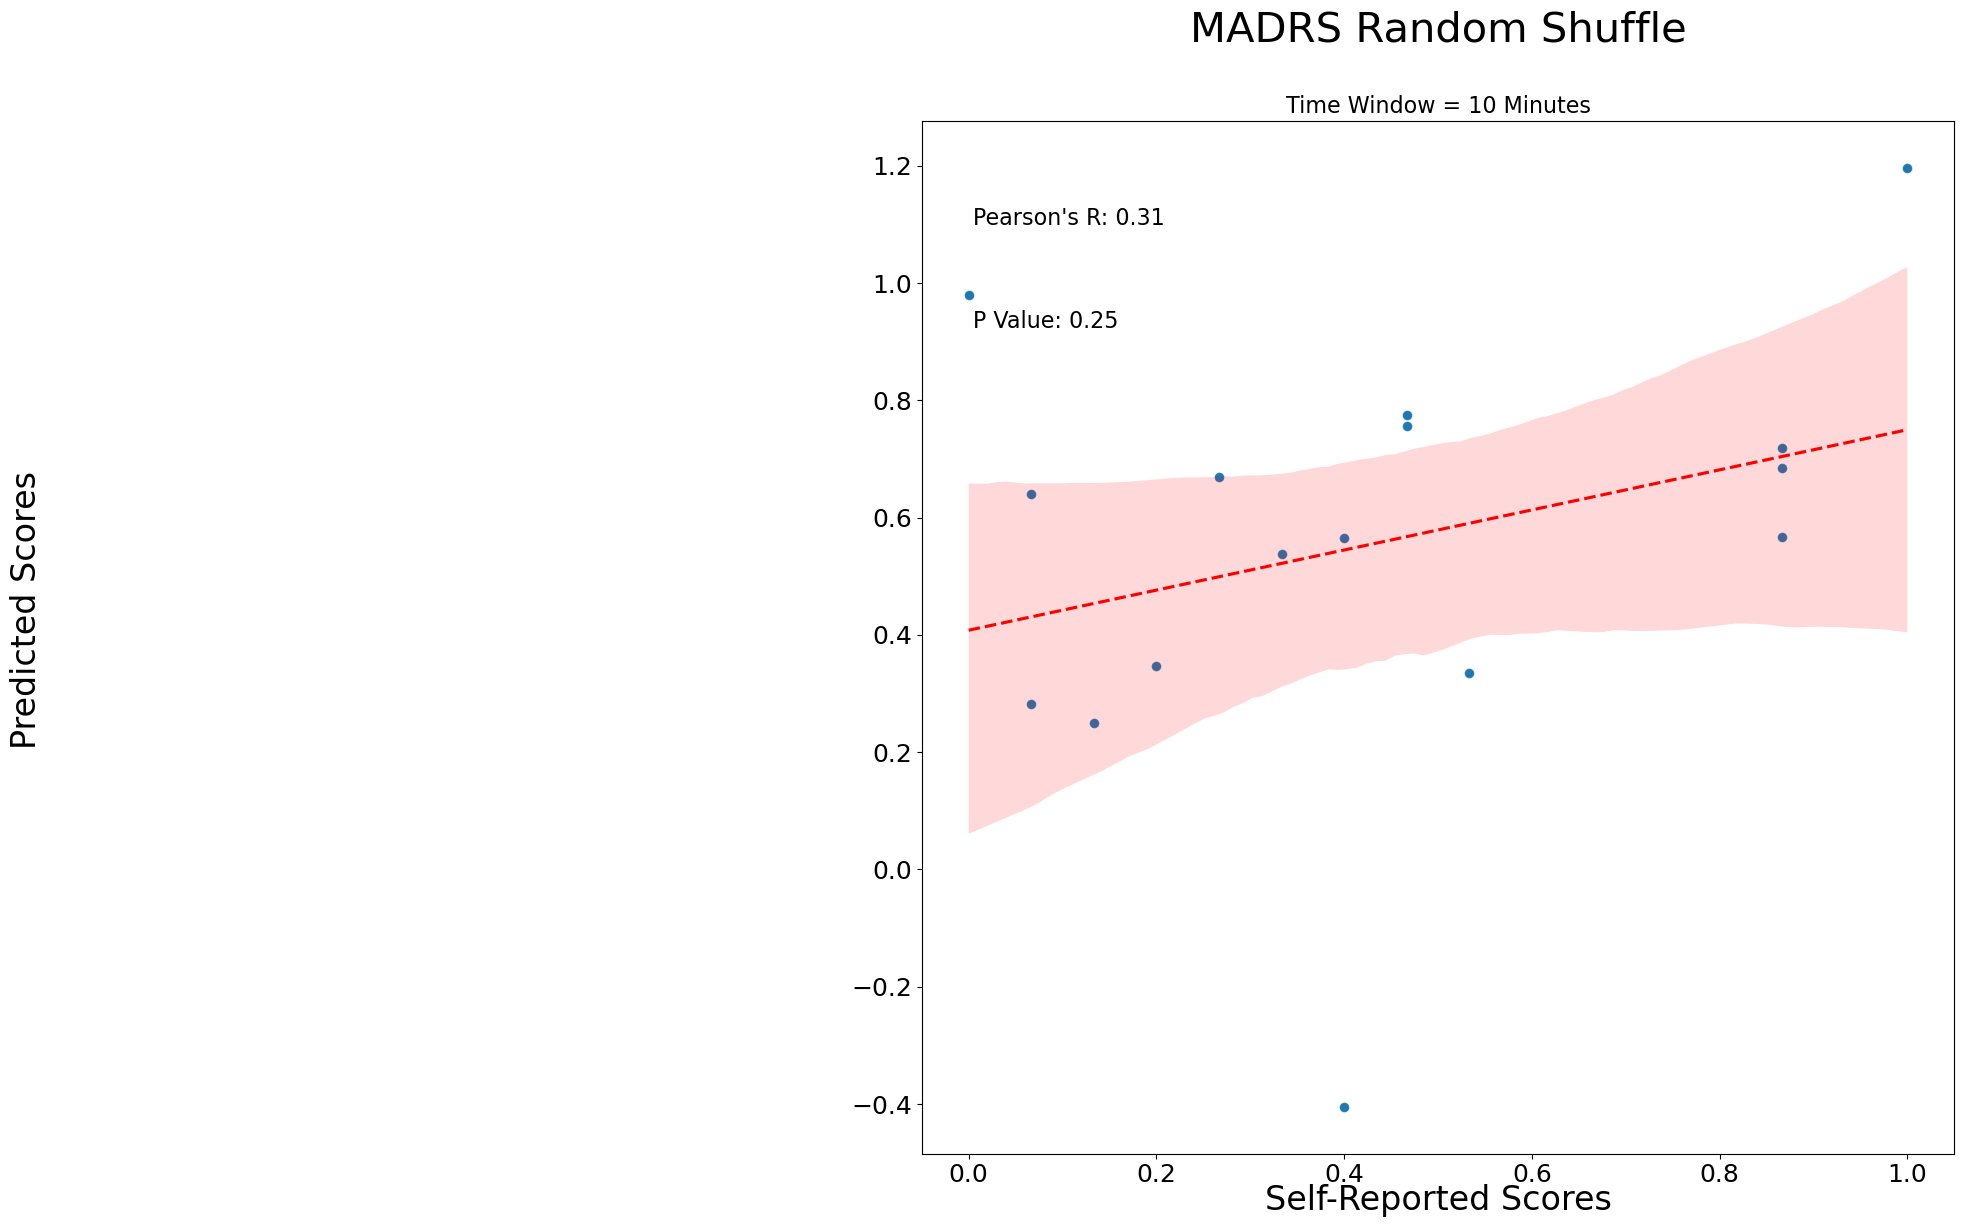

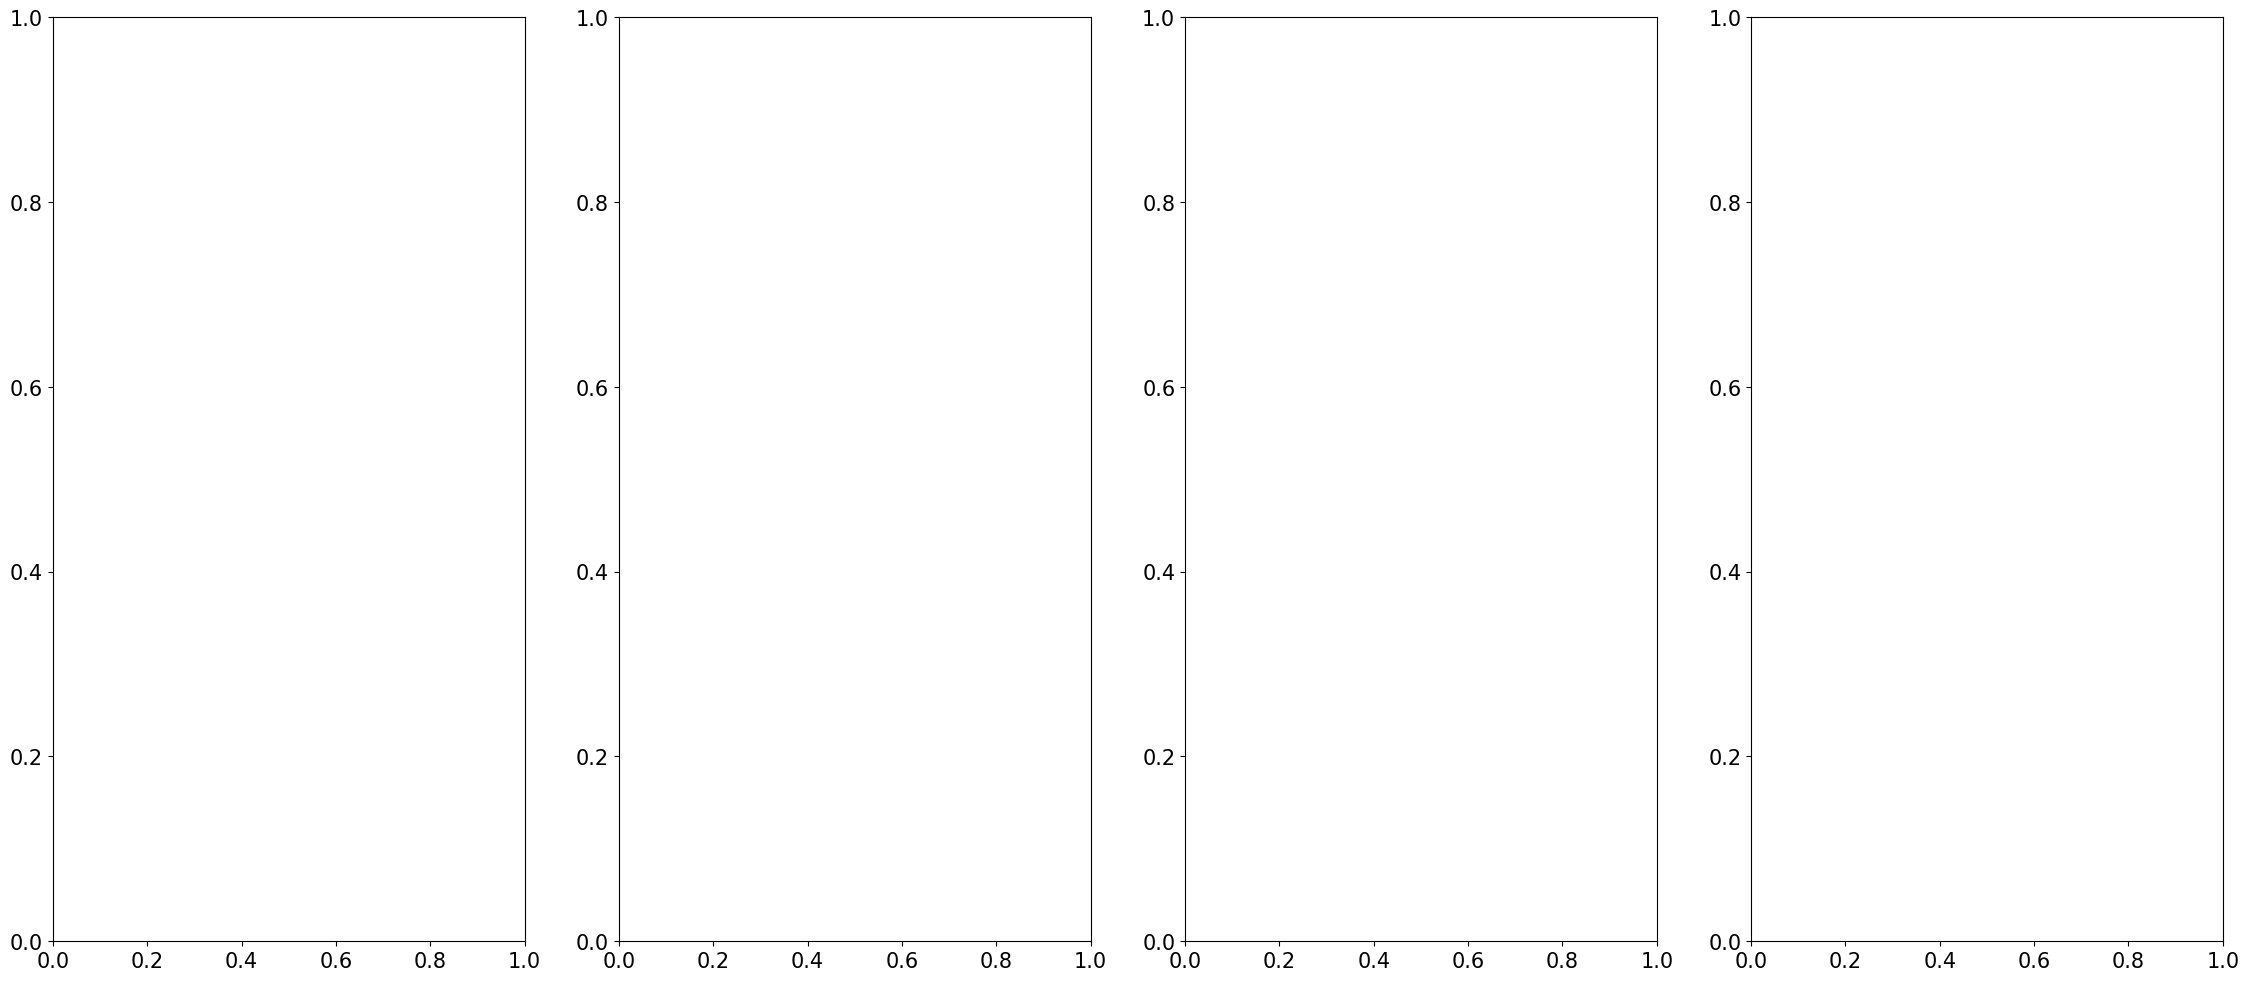

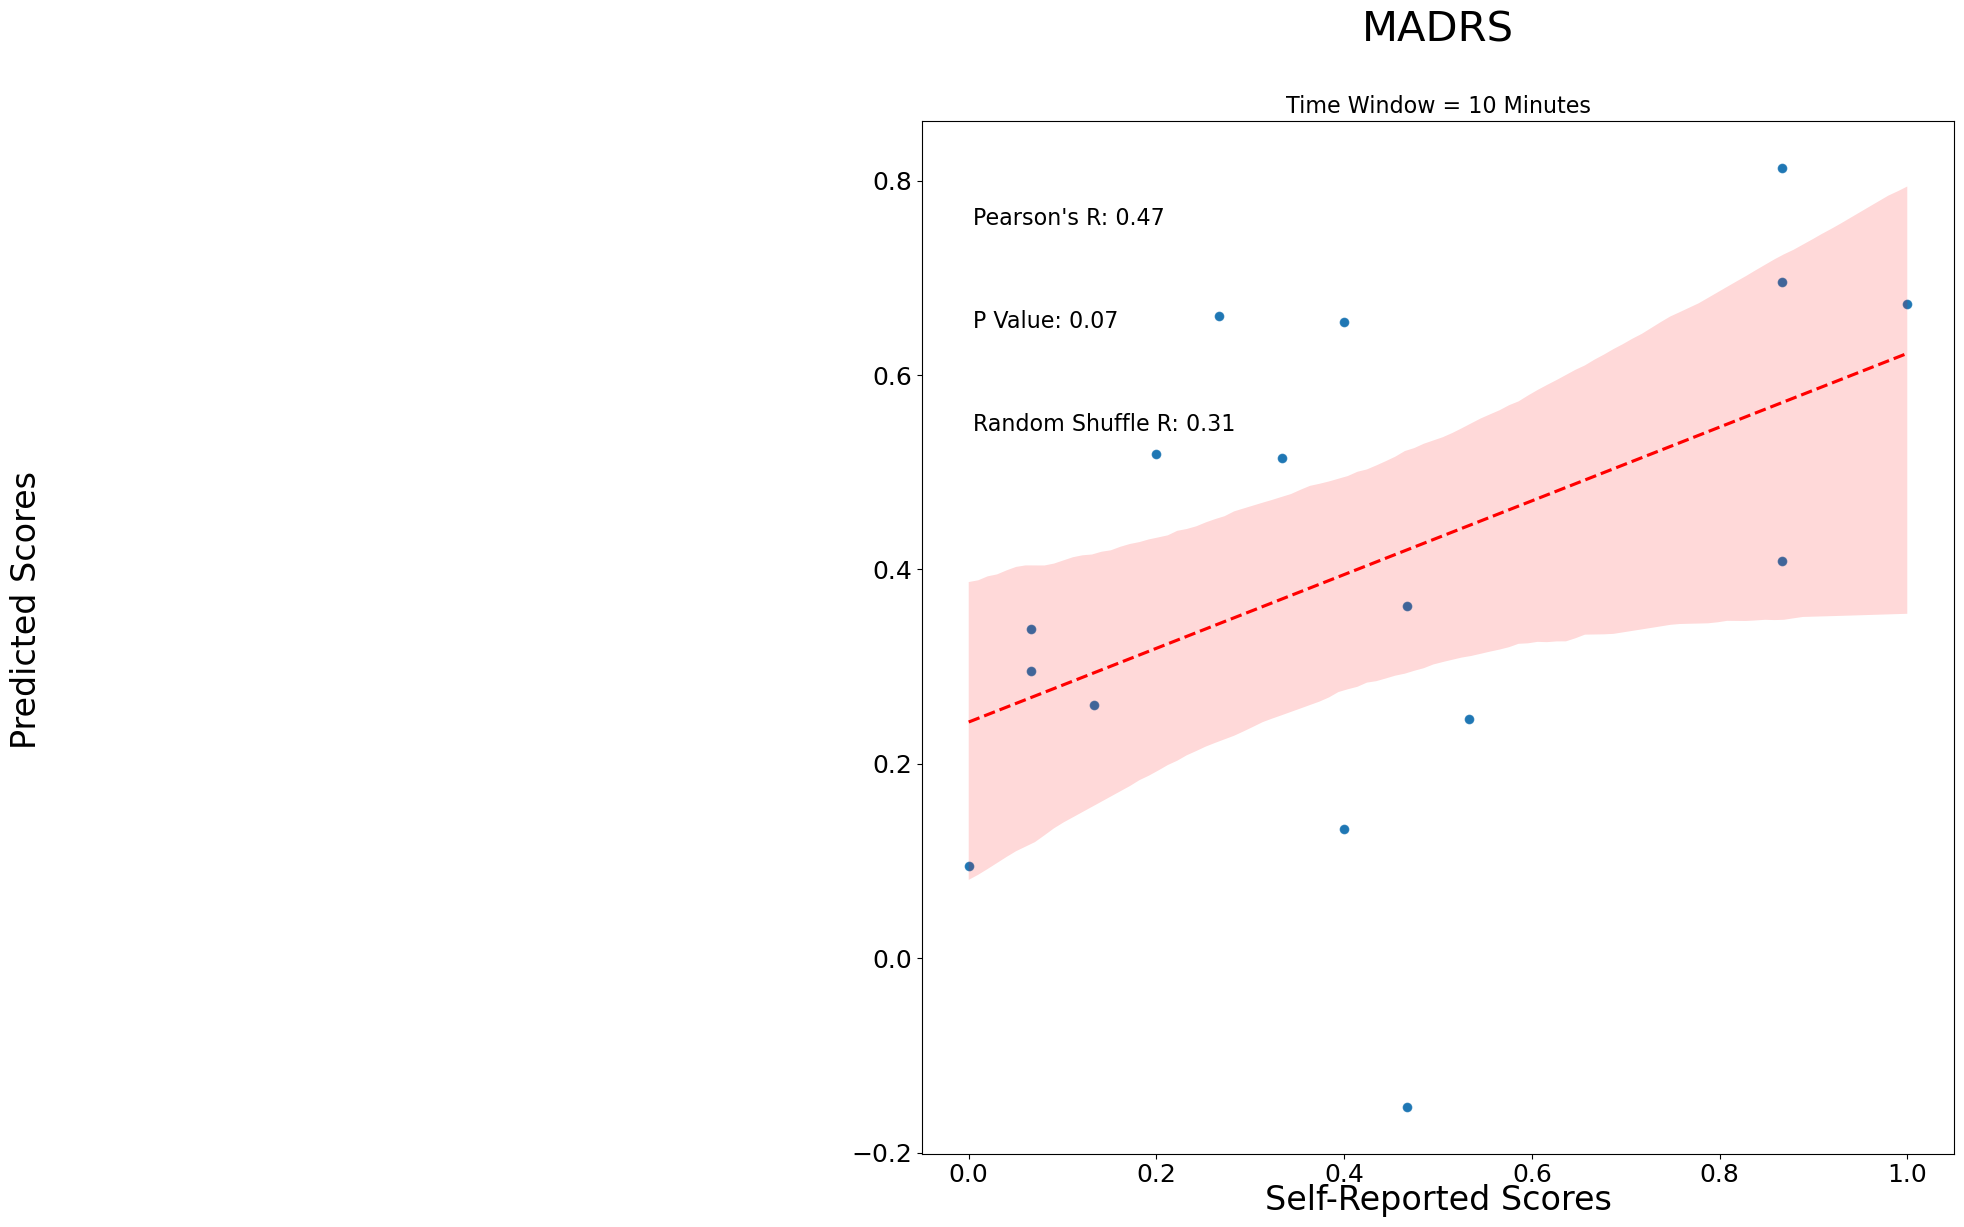

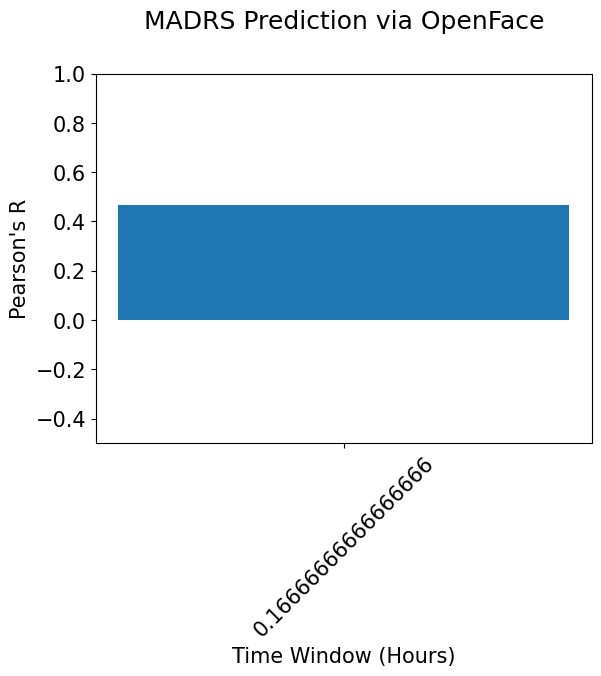

METRIC NOW:  MADRS


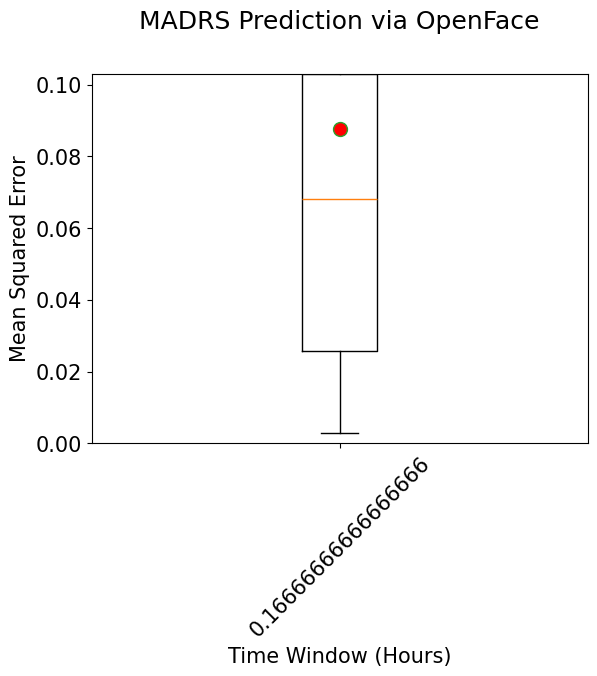

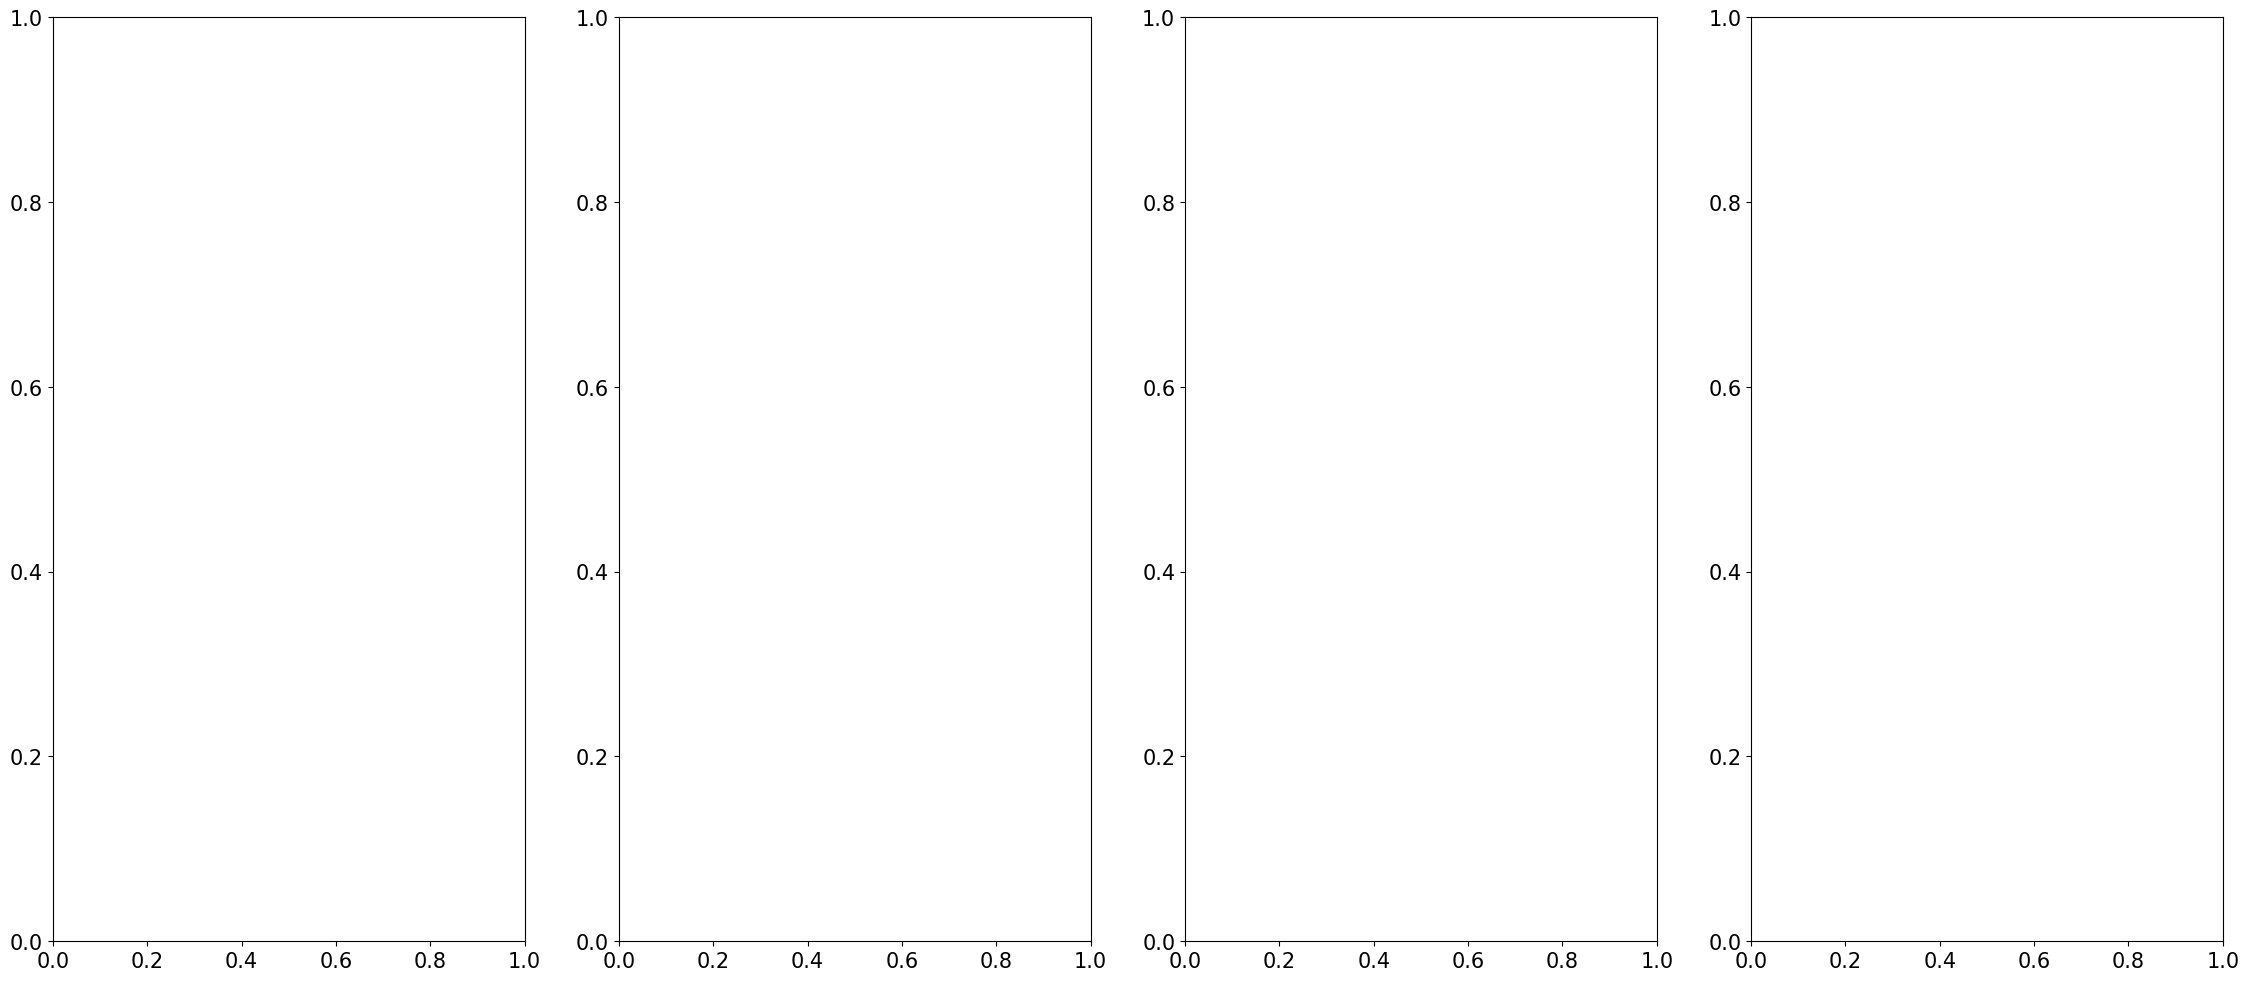

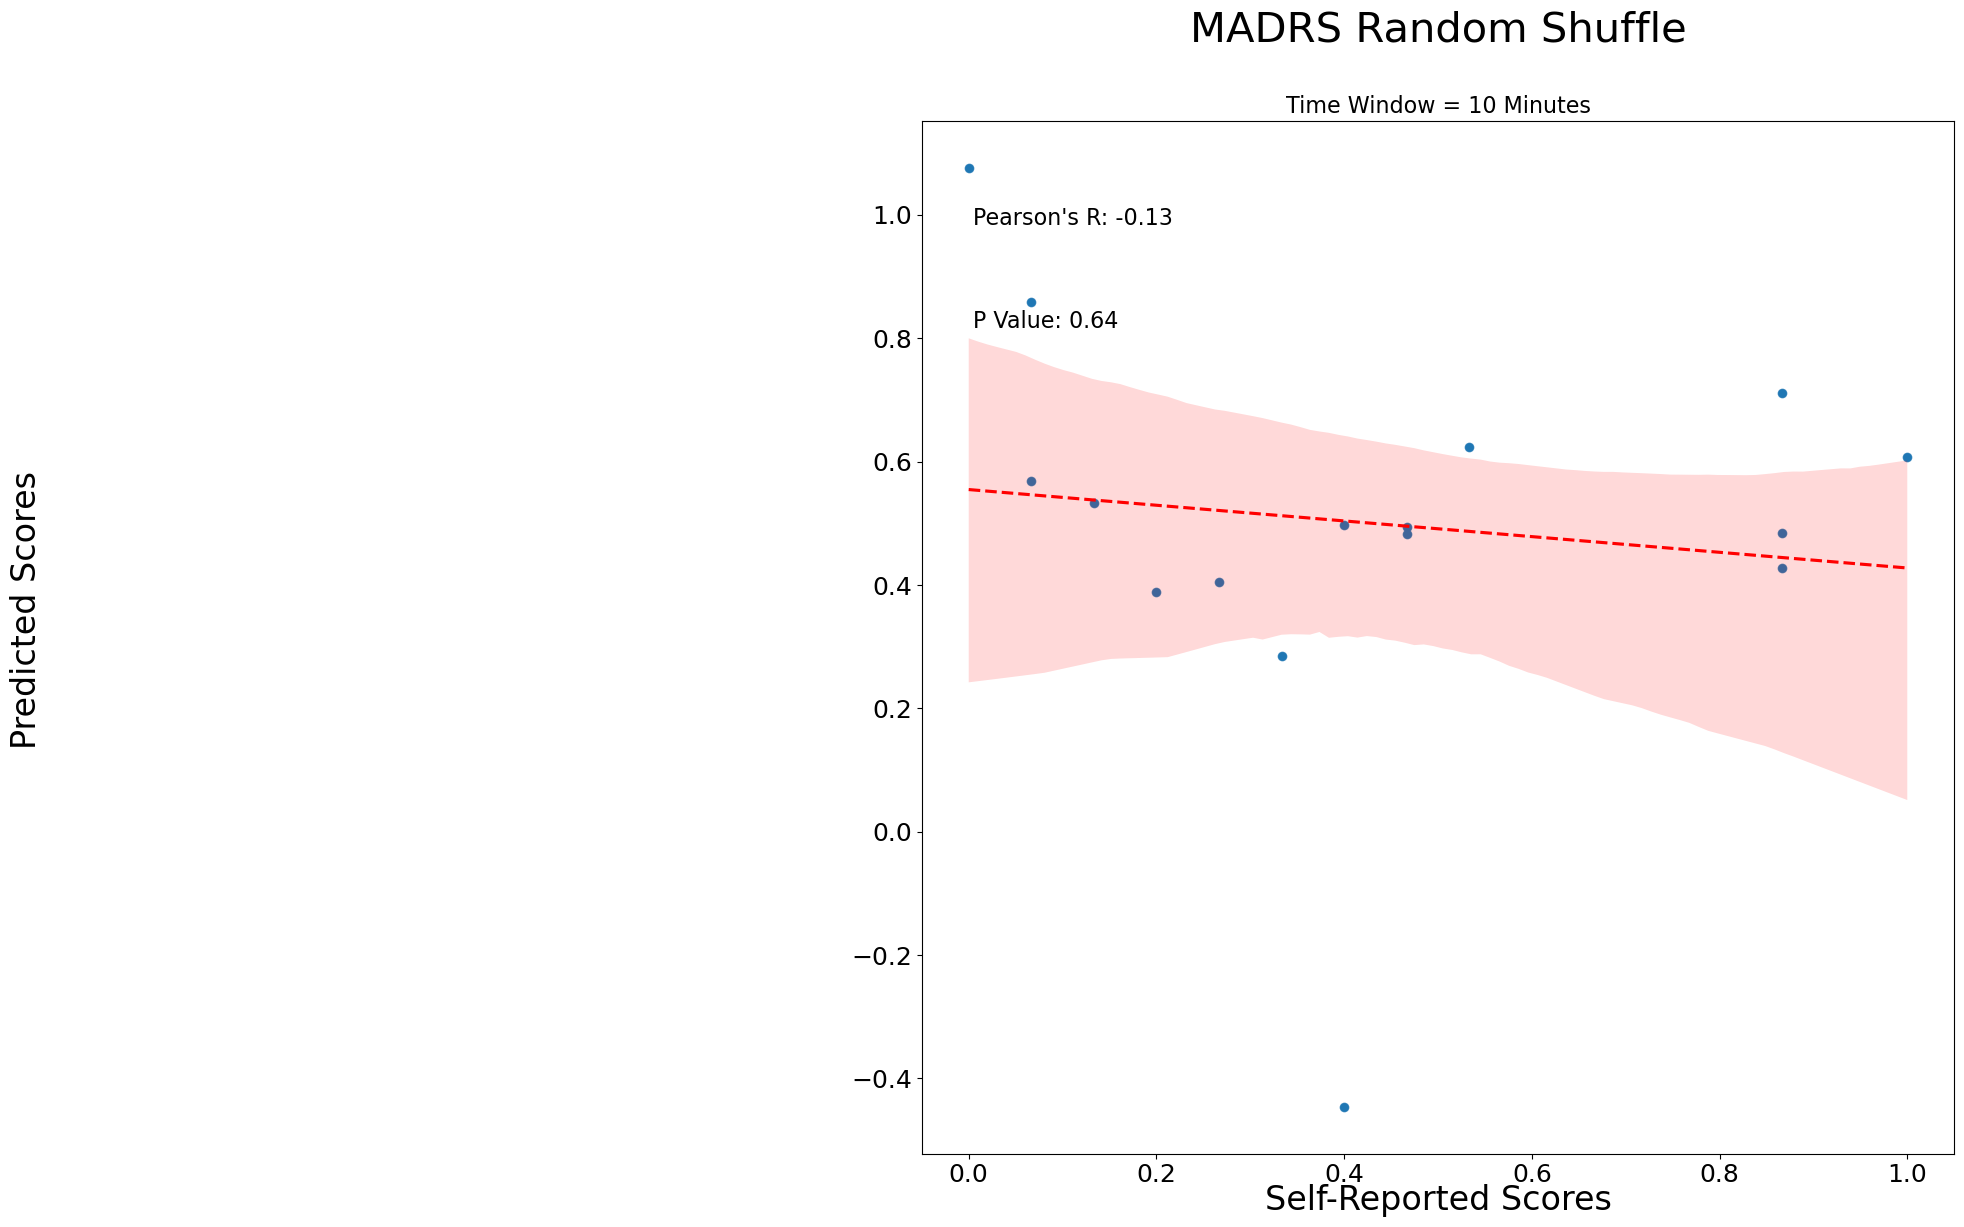

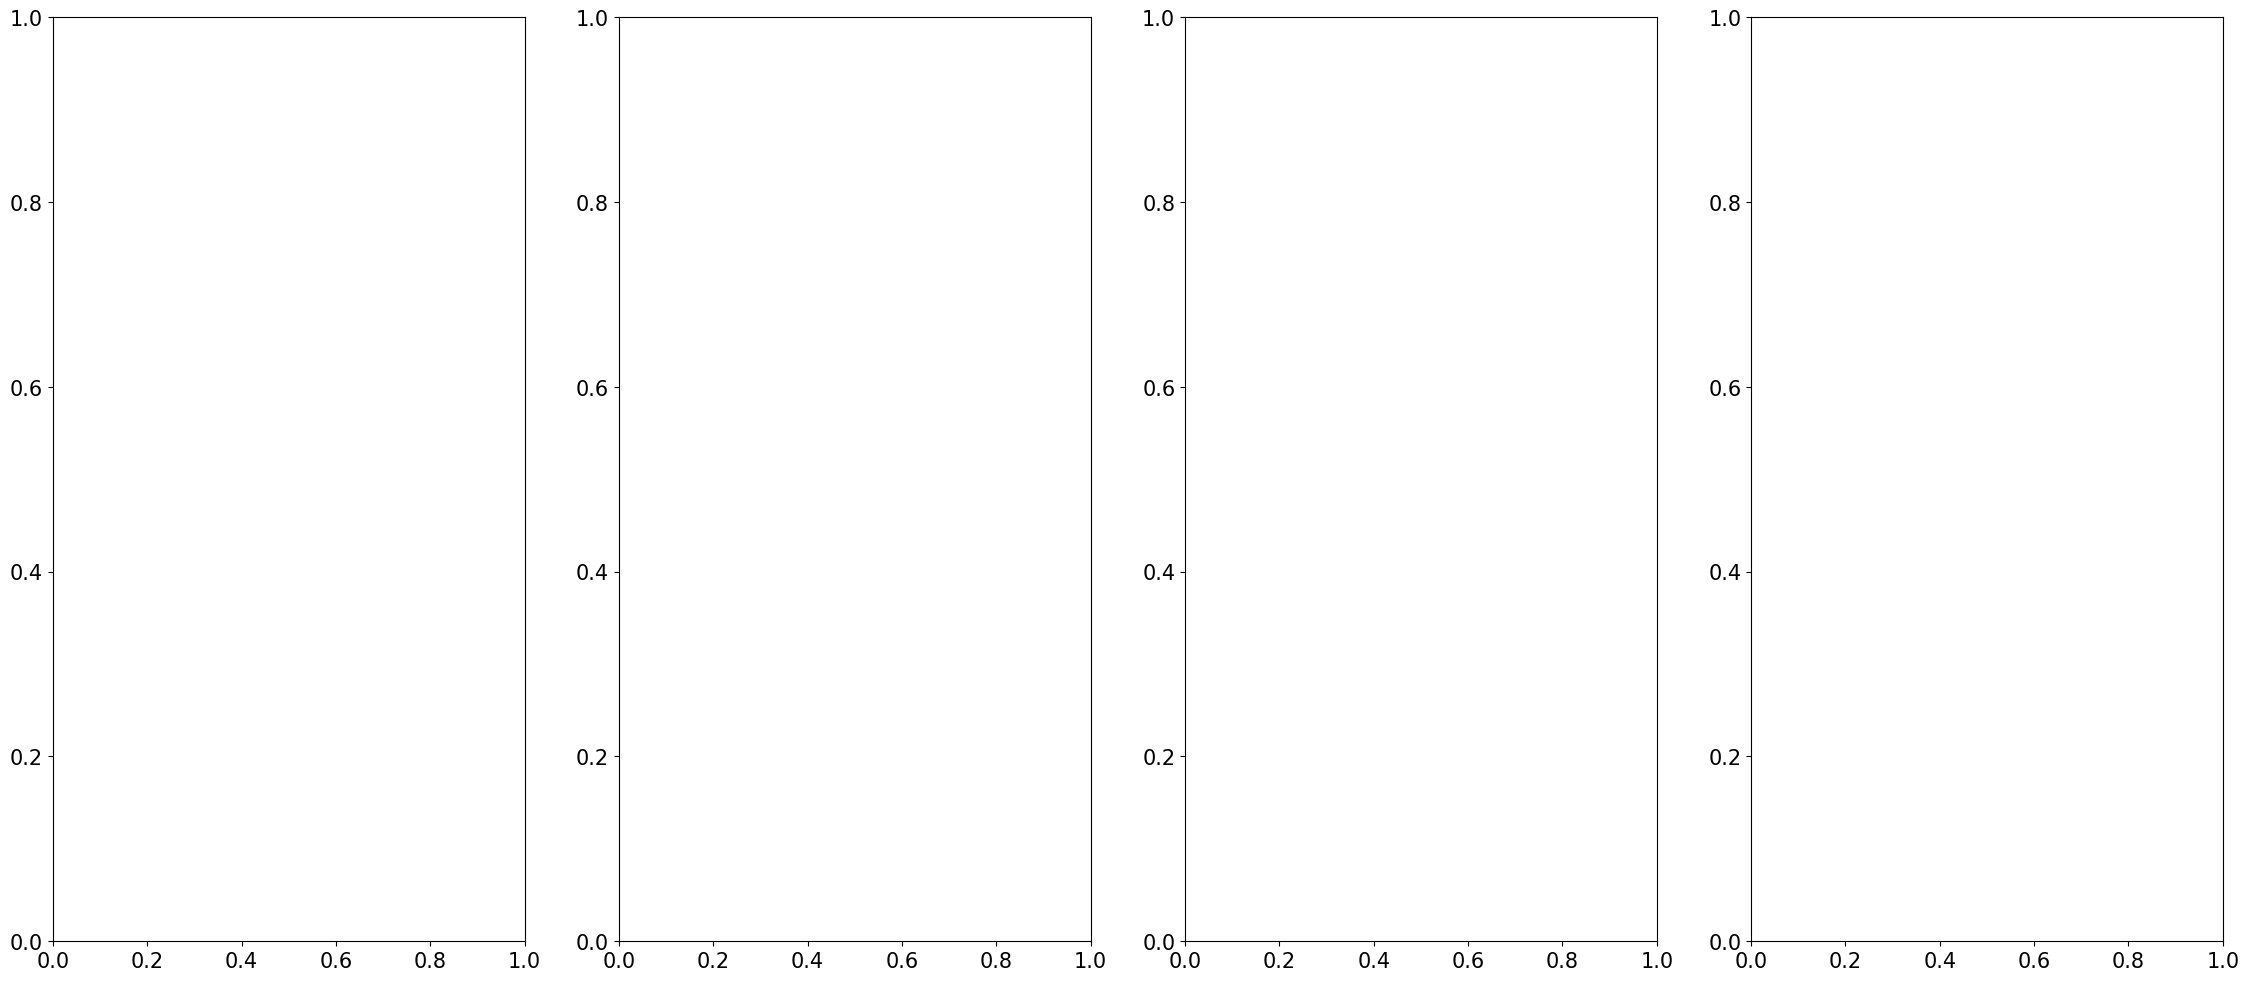

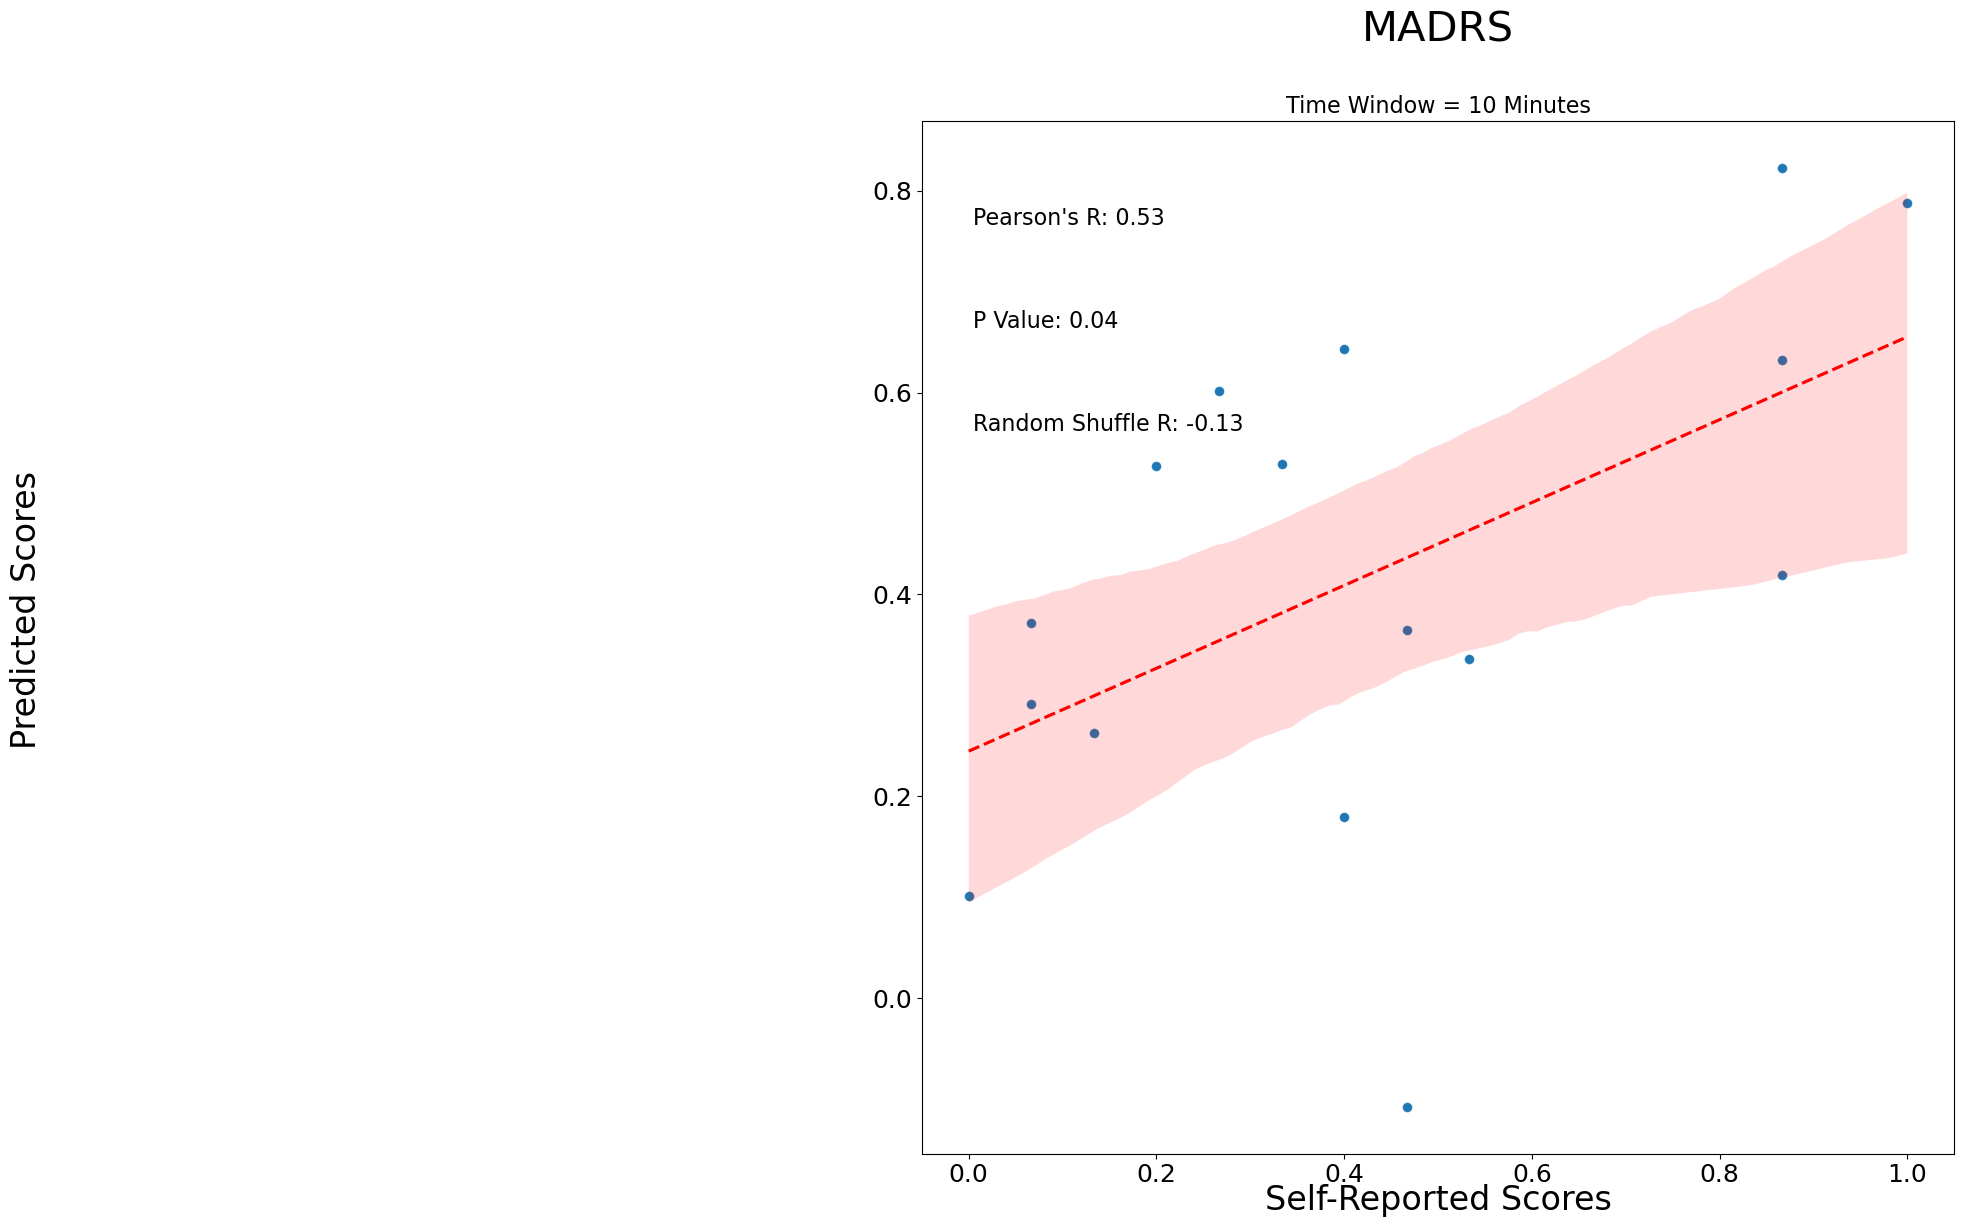

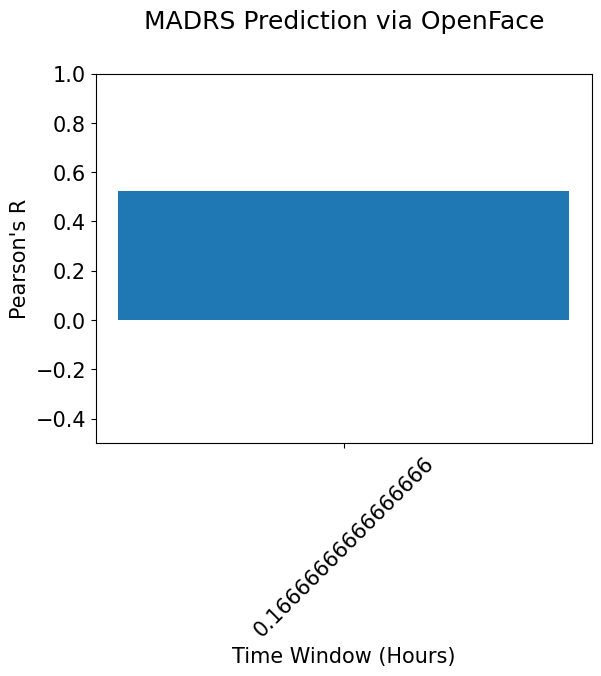

METRIC NOW:  MADRS


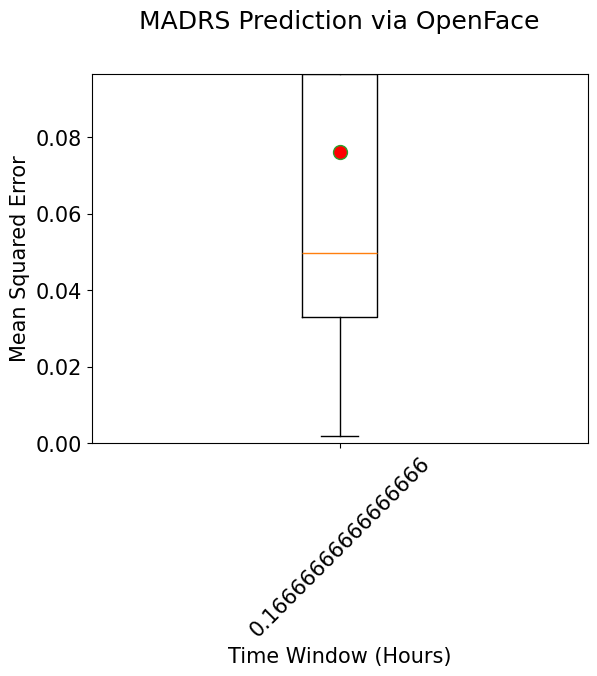

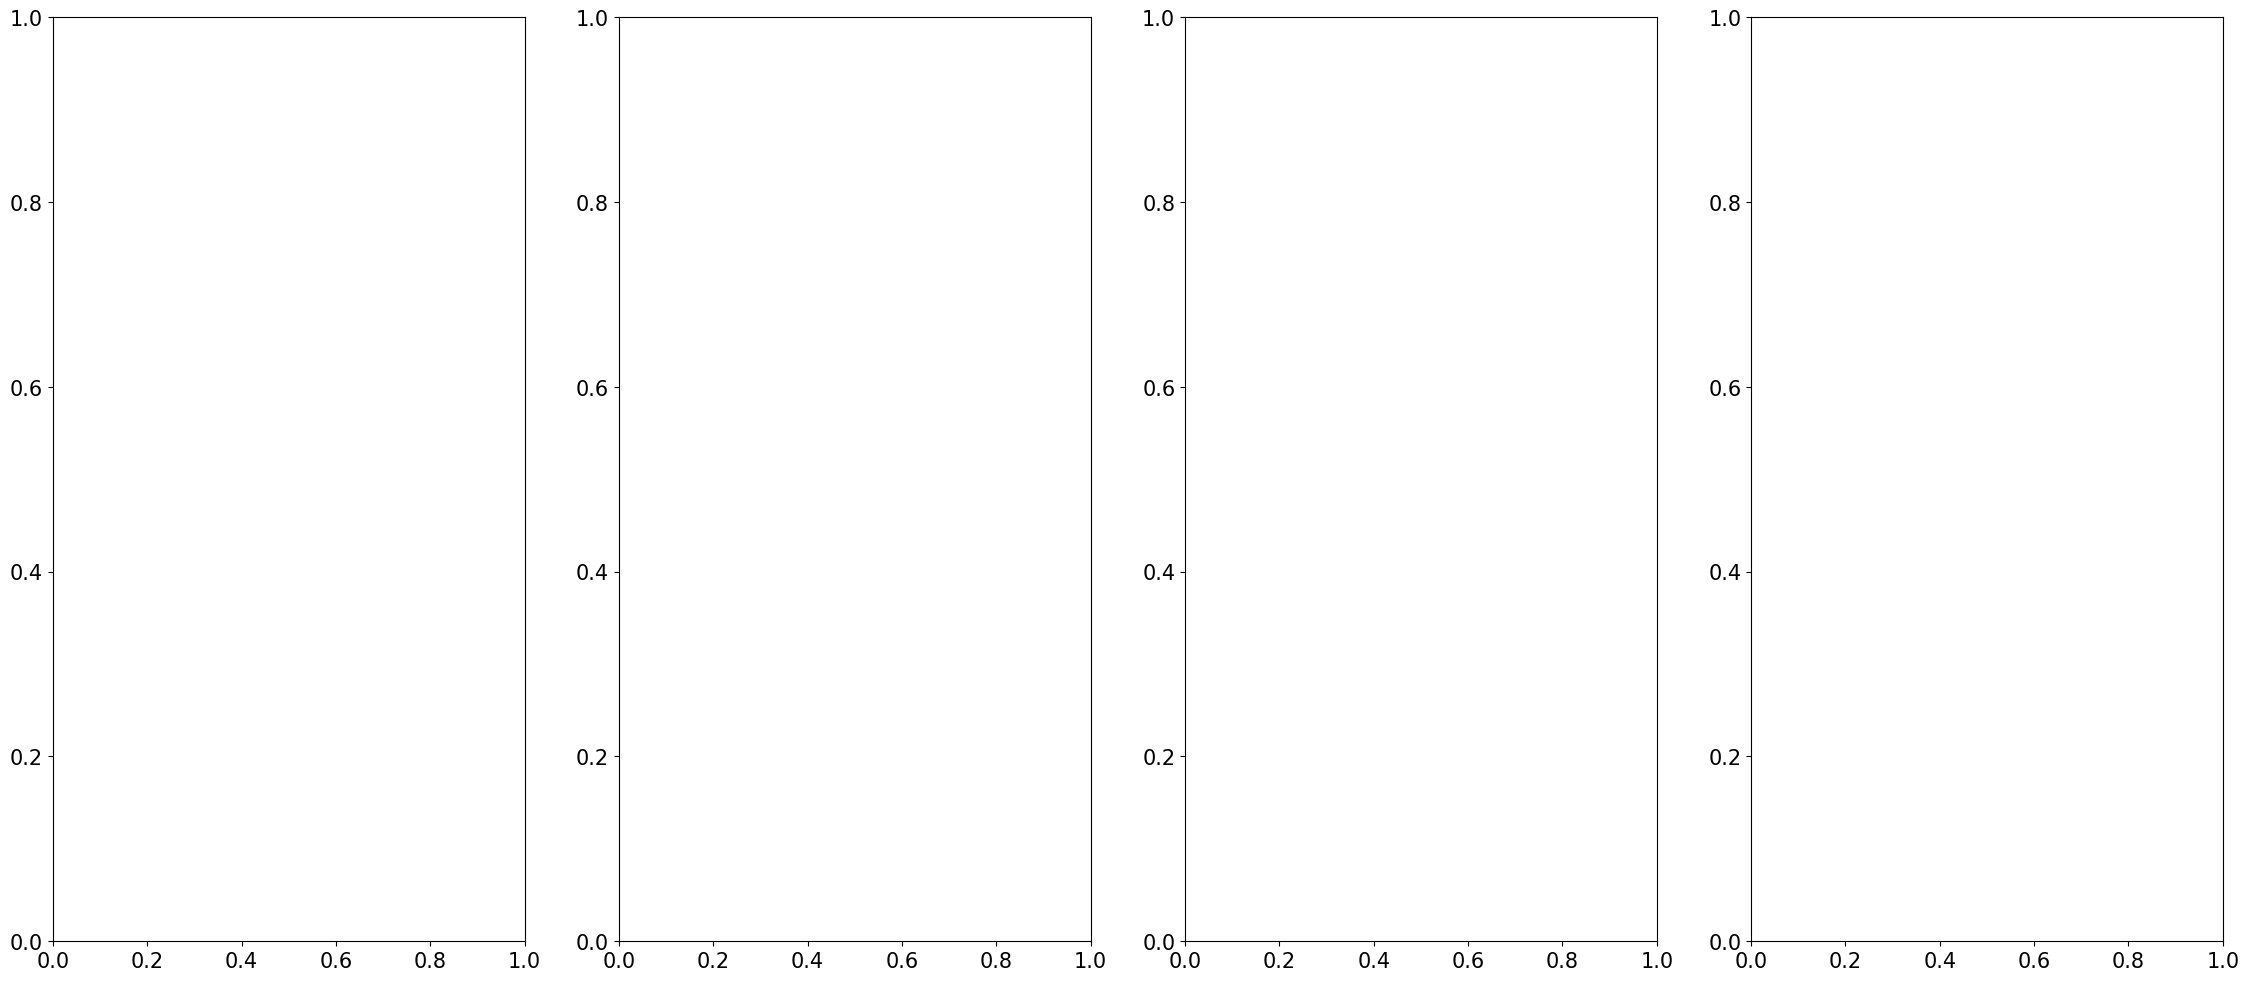

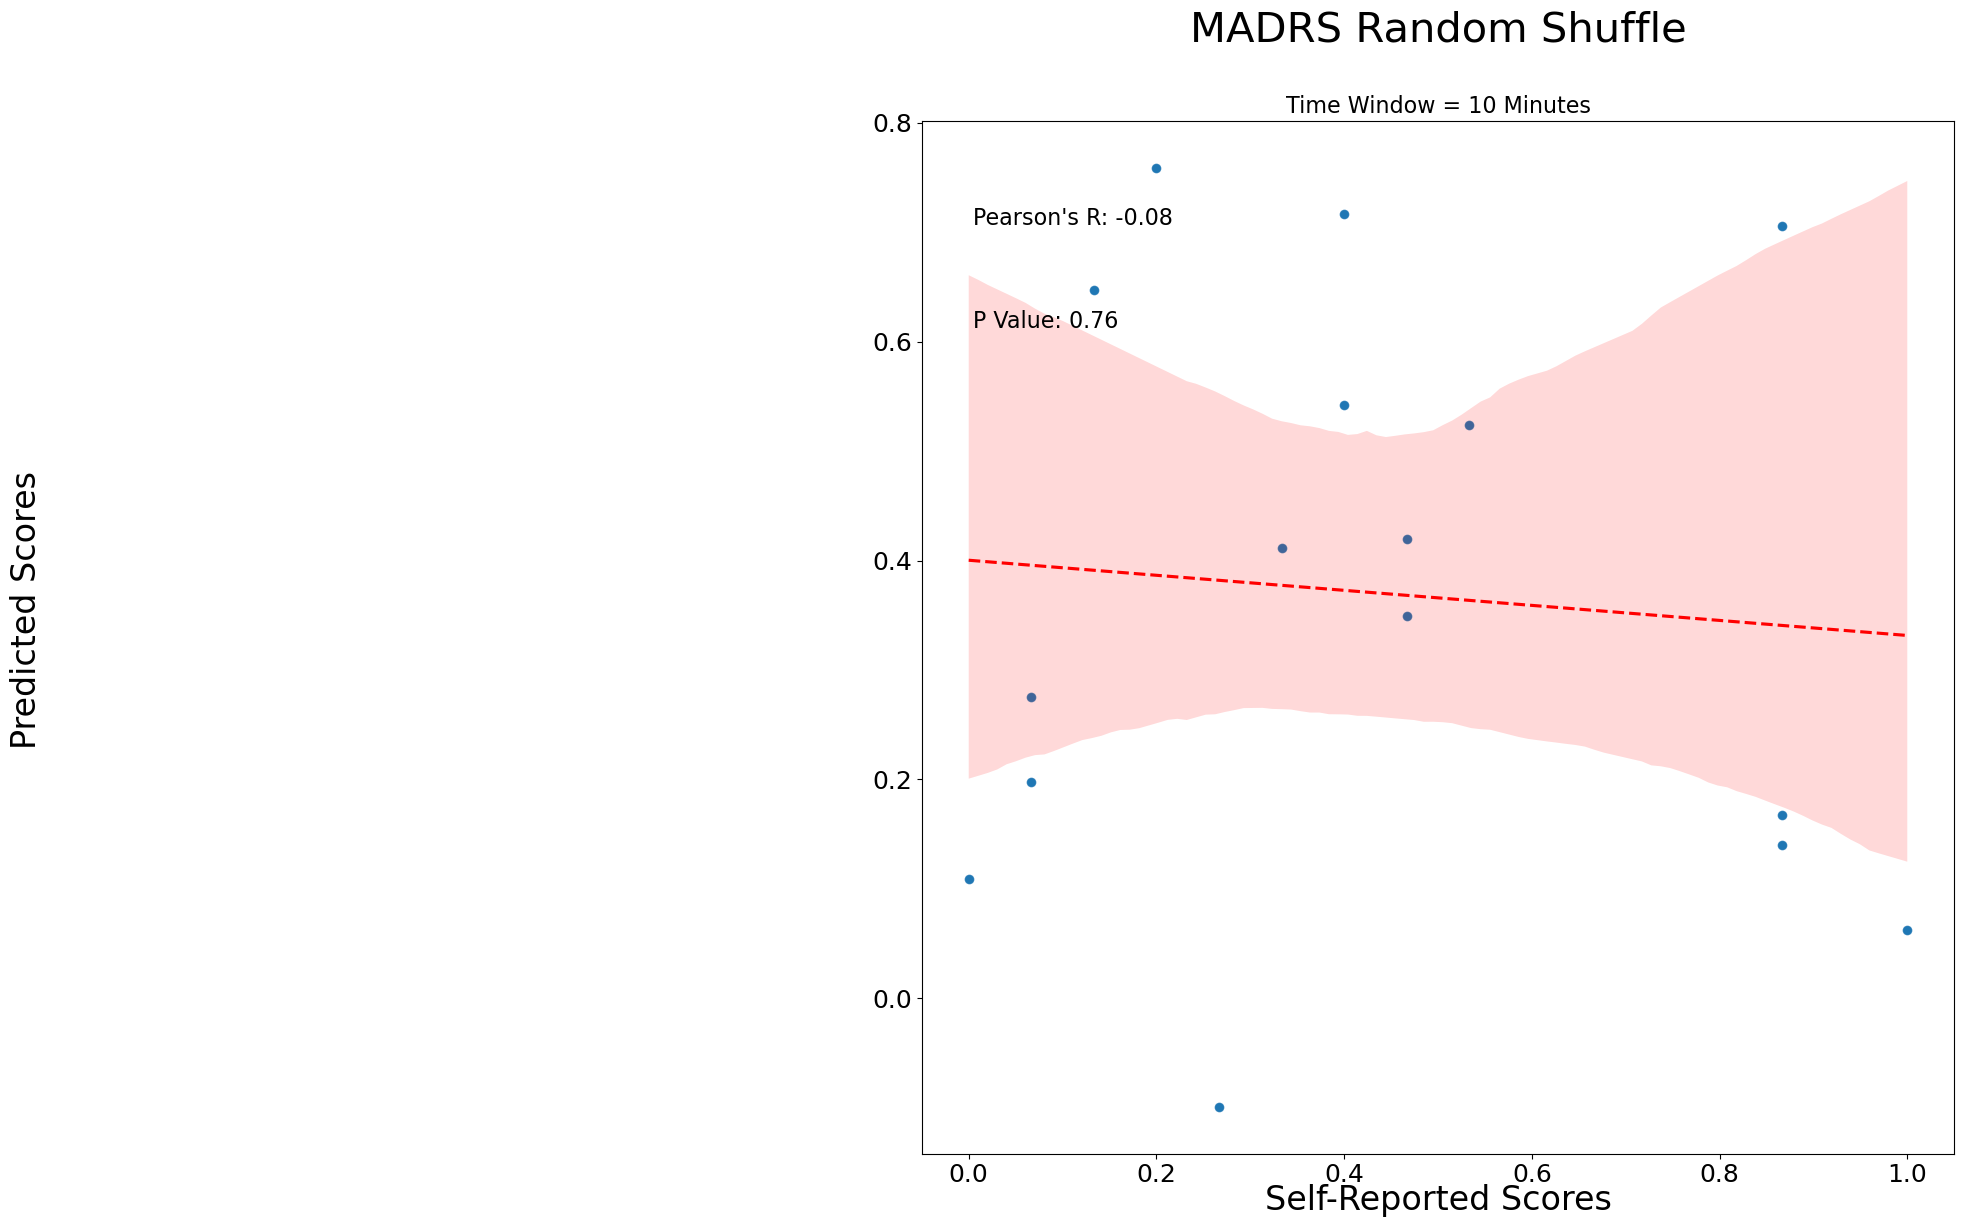

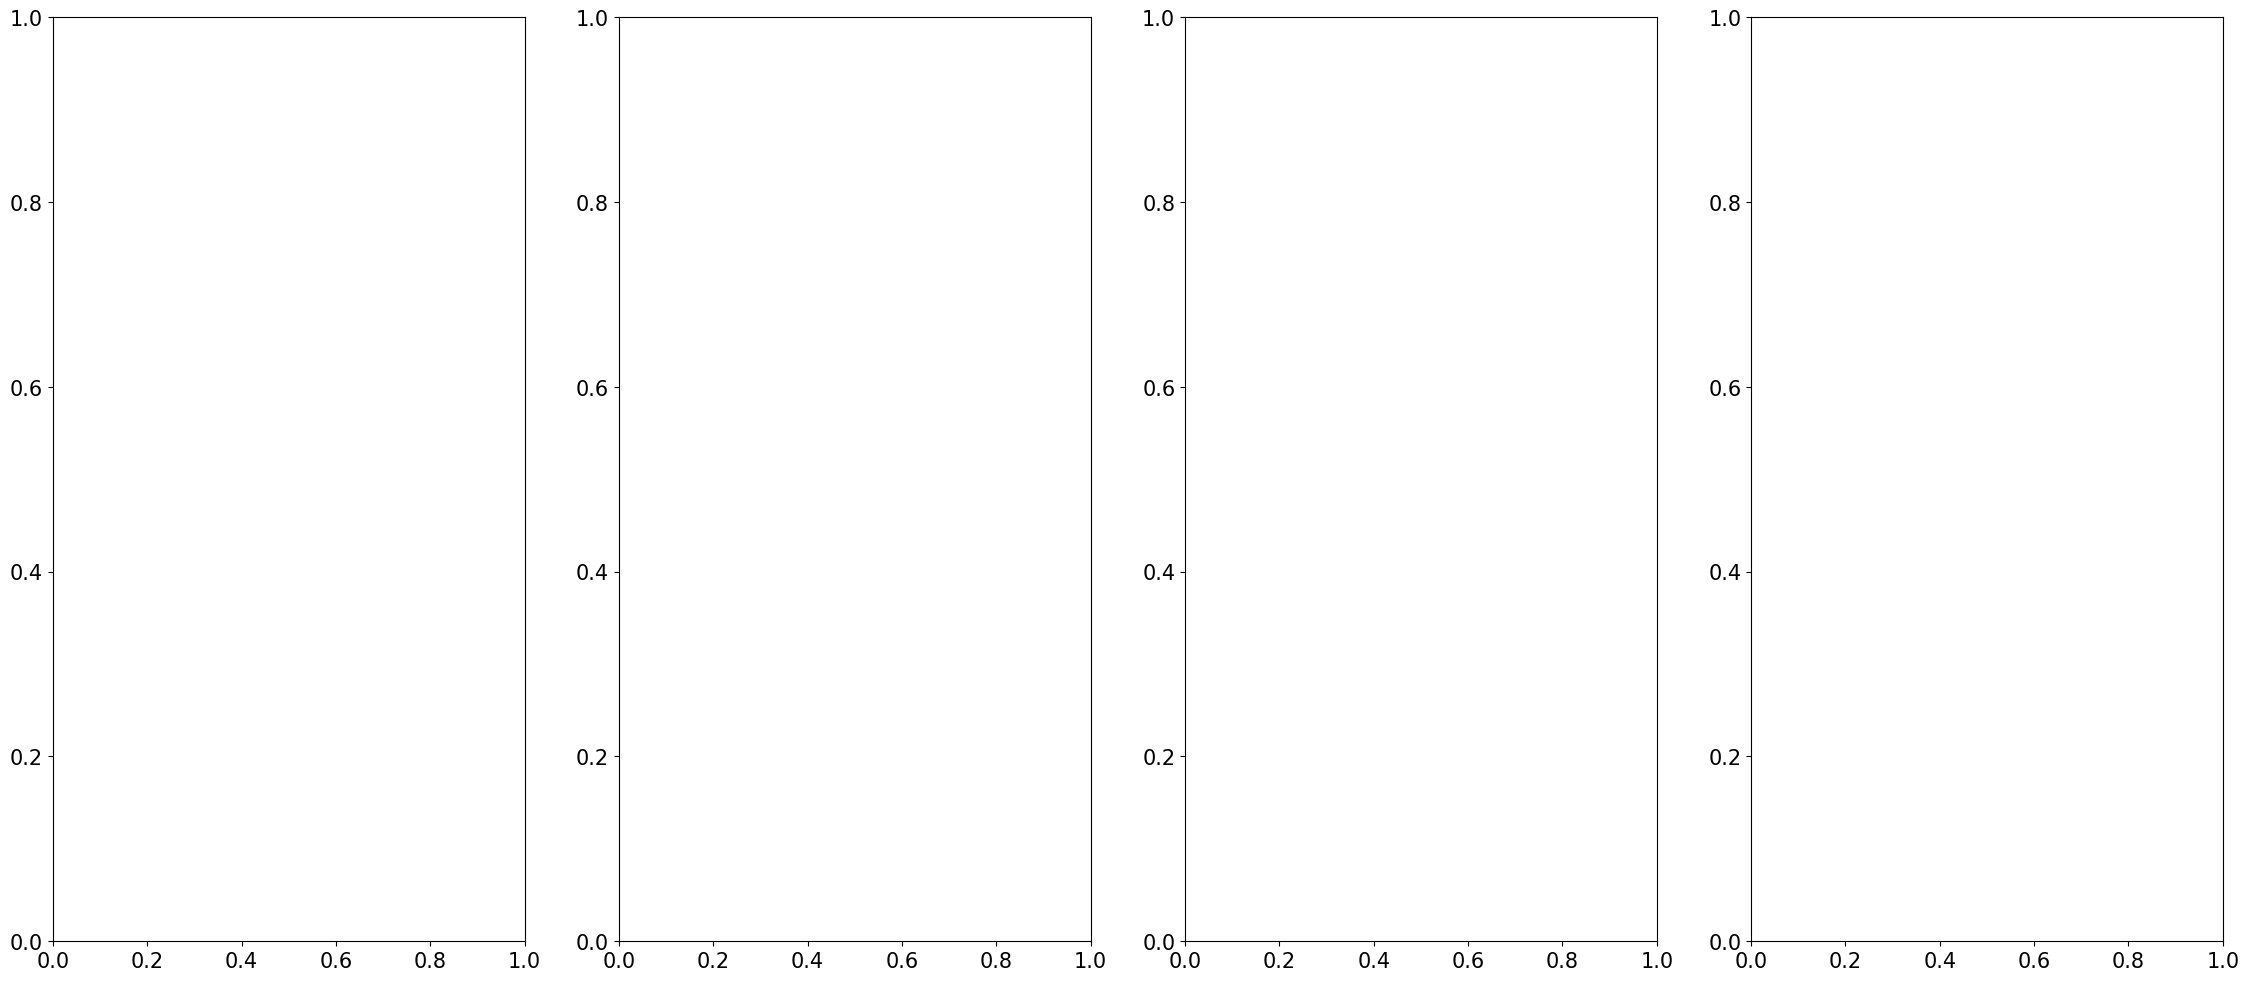

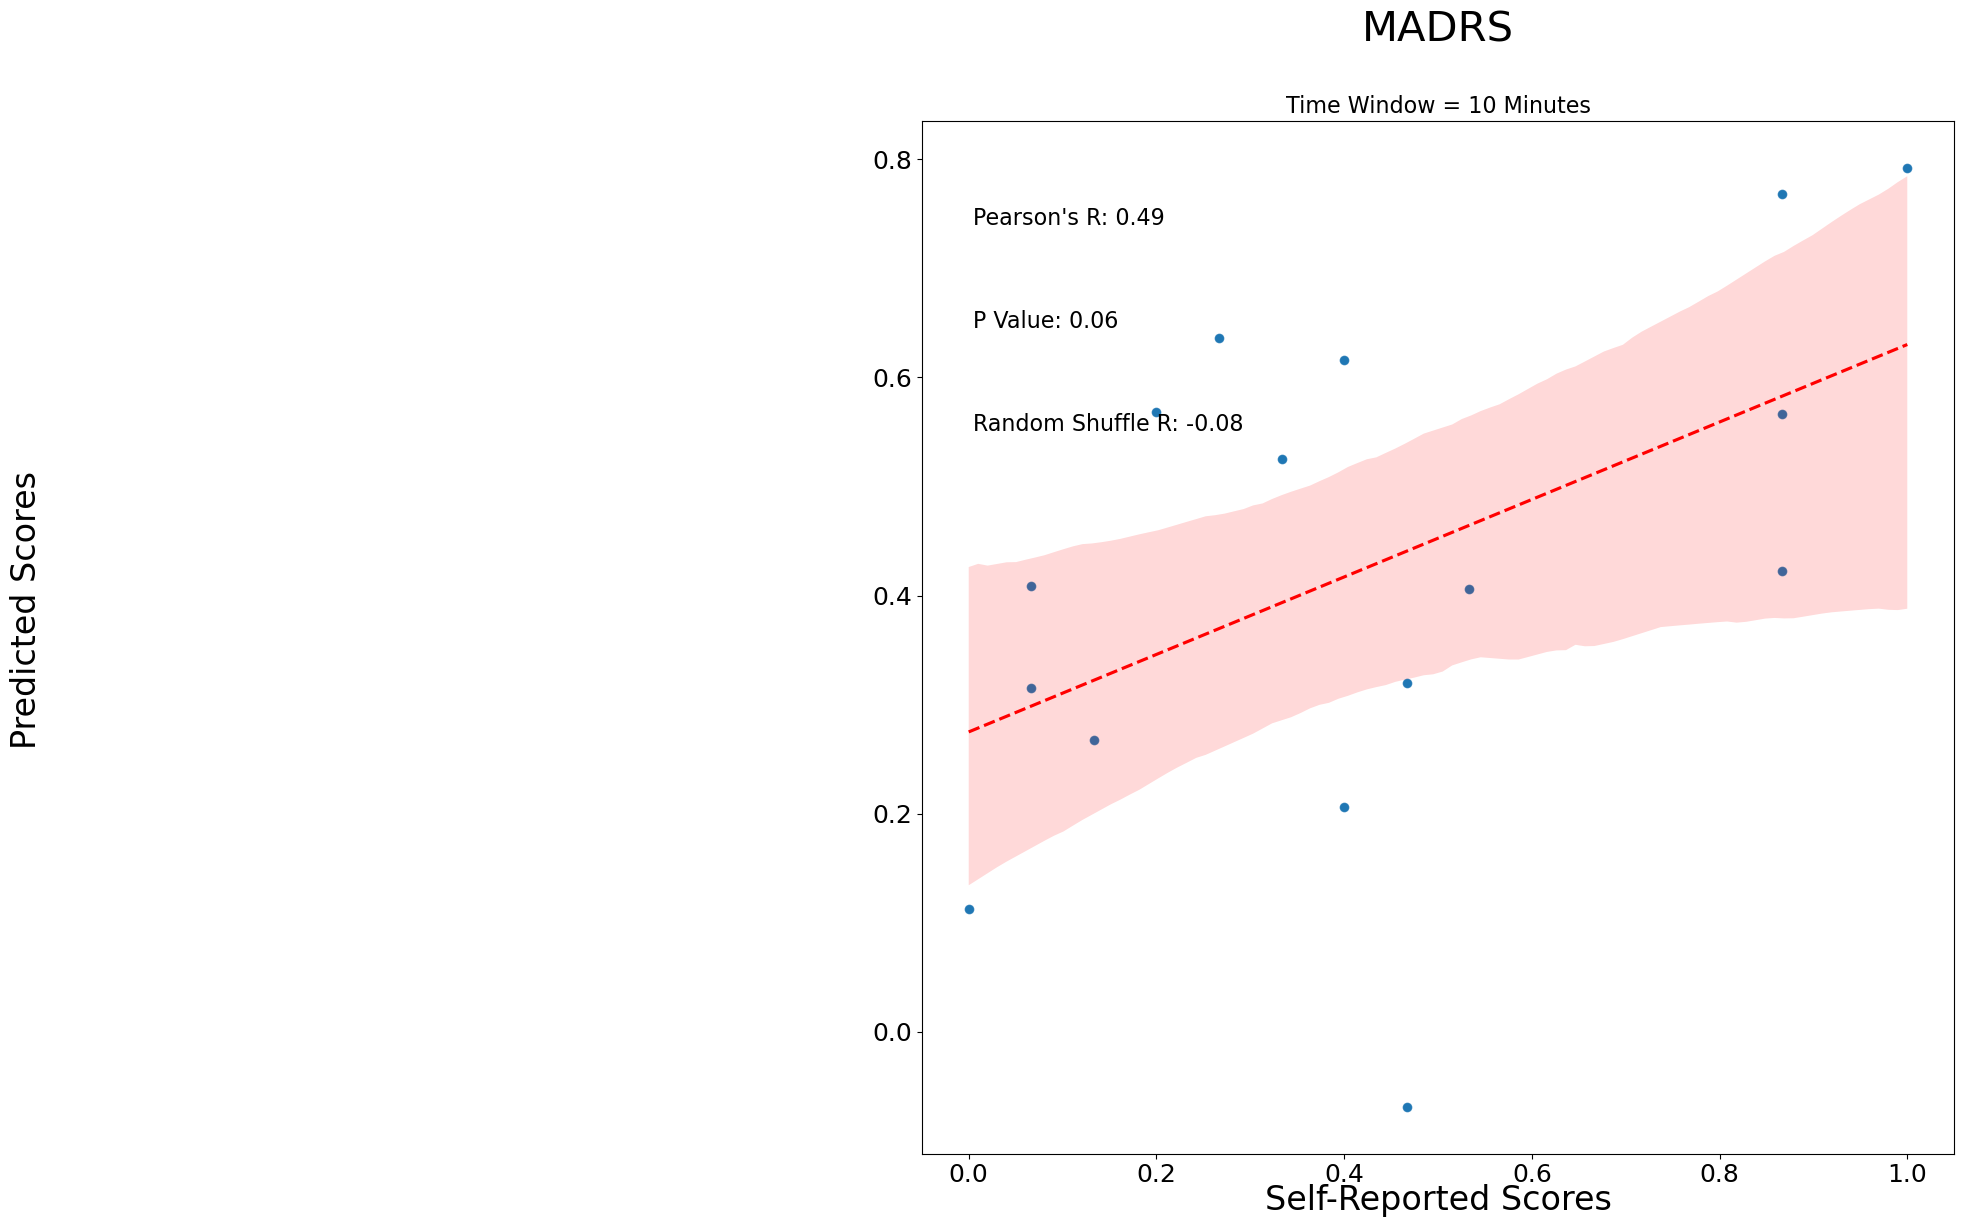

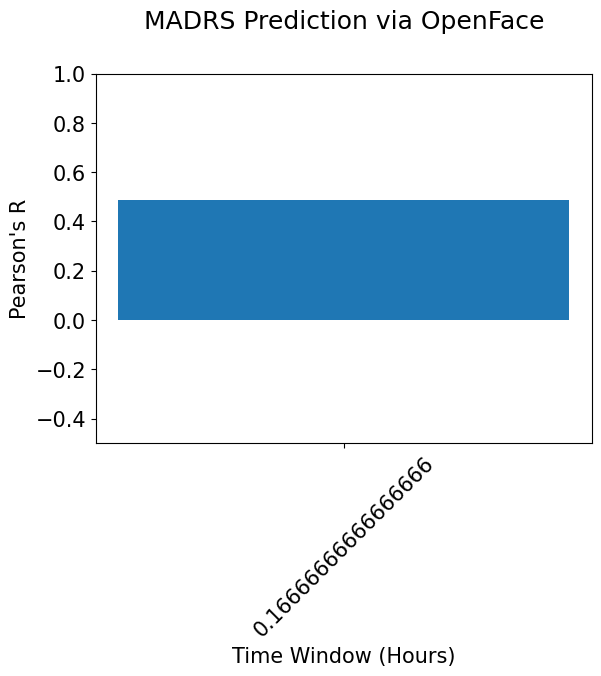

METRIC NOW:  MADRS


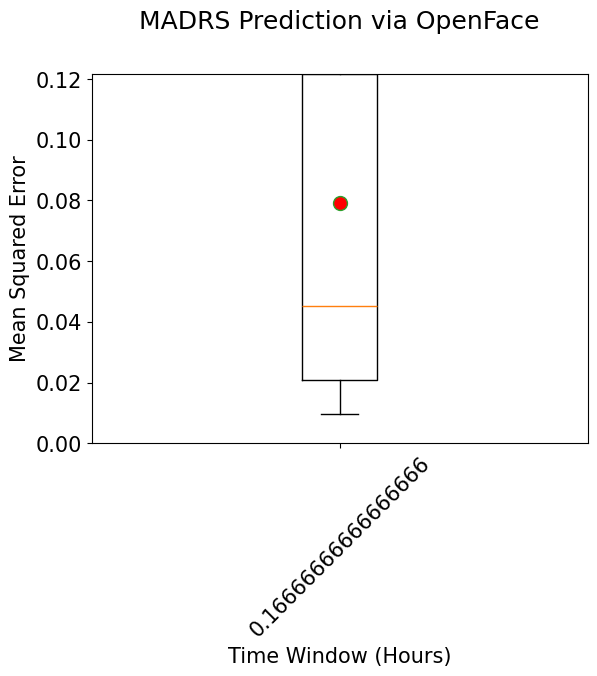

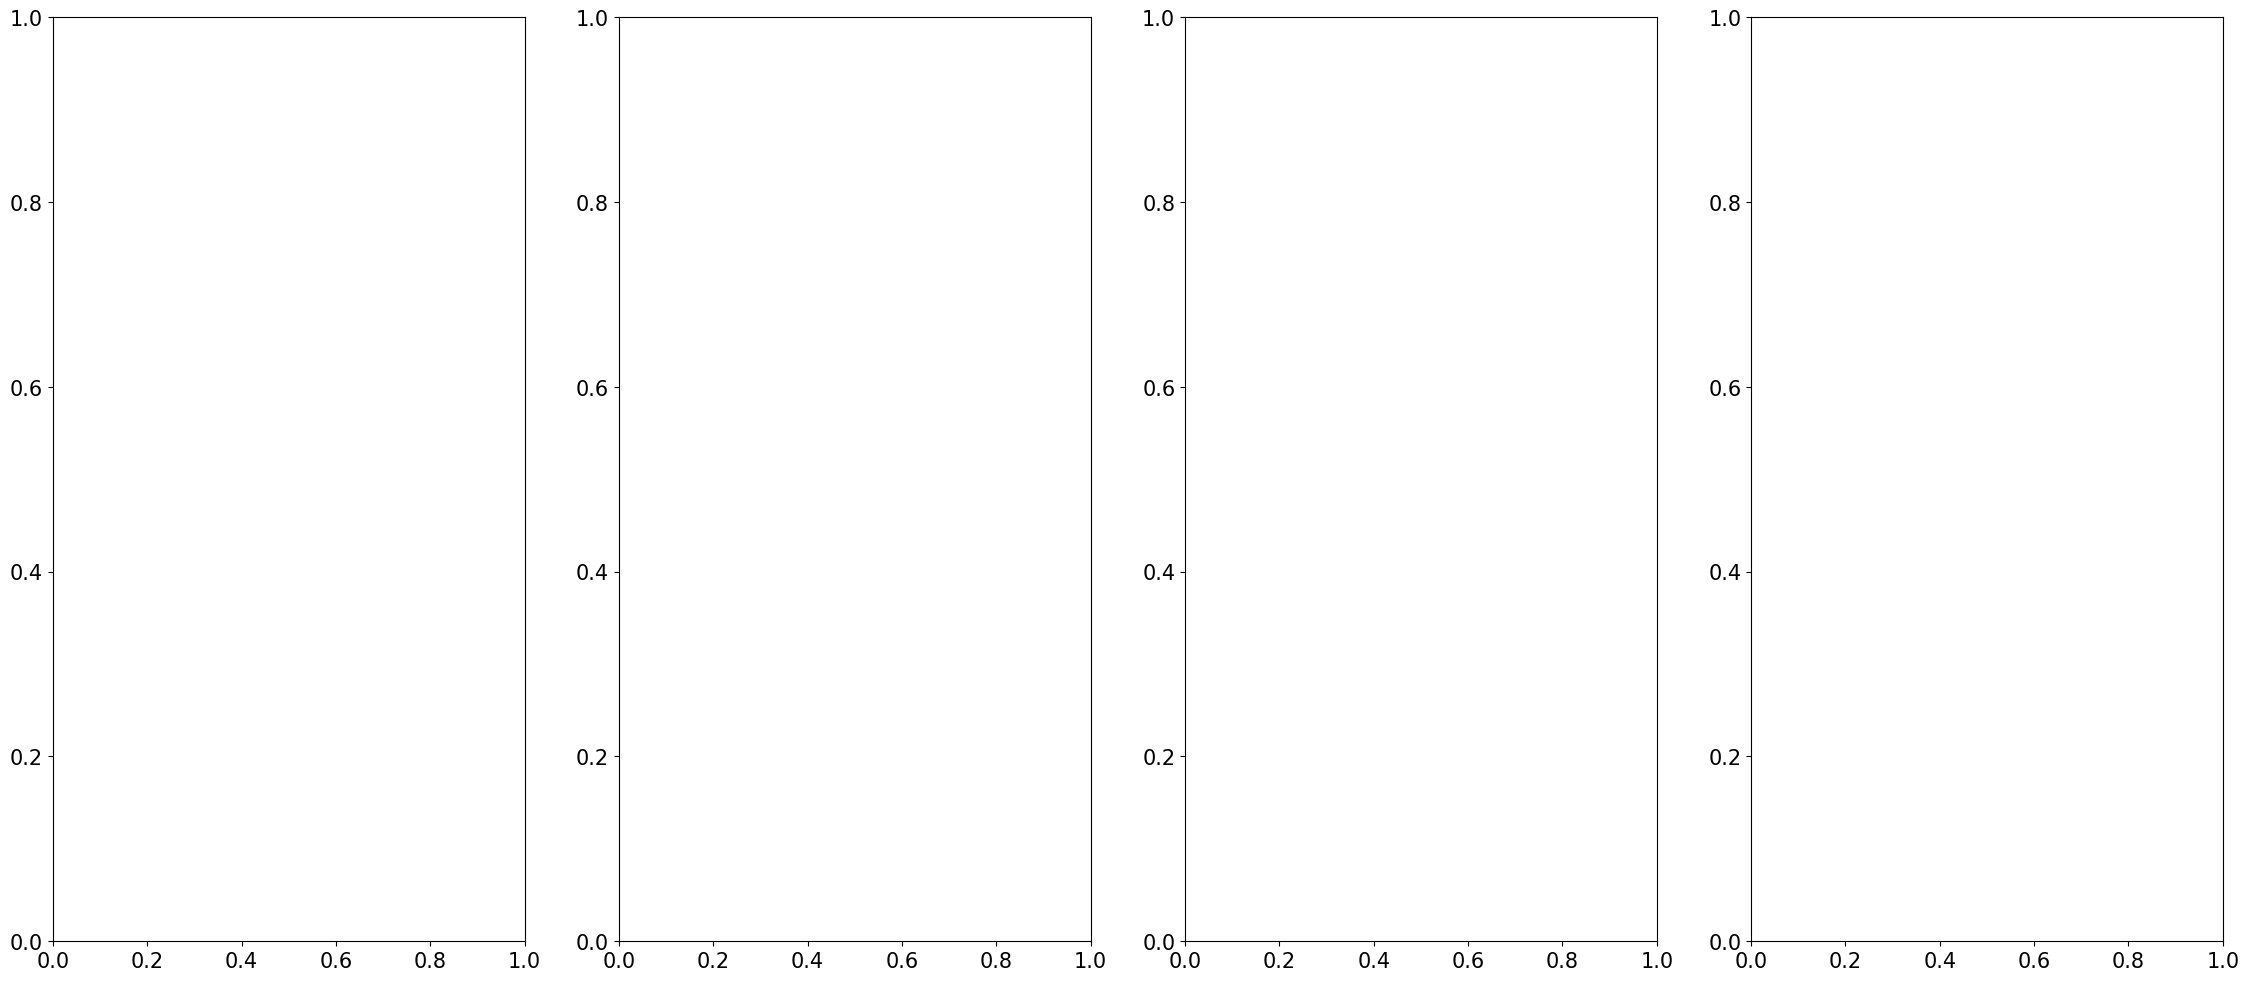

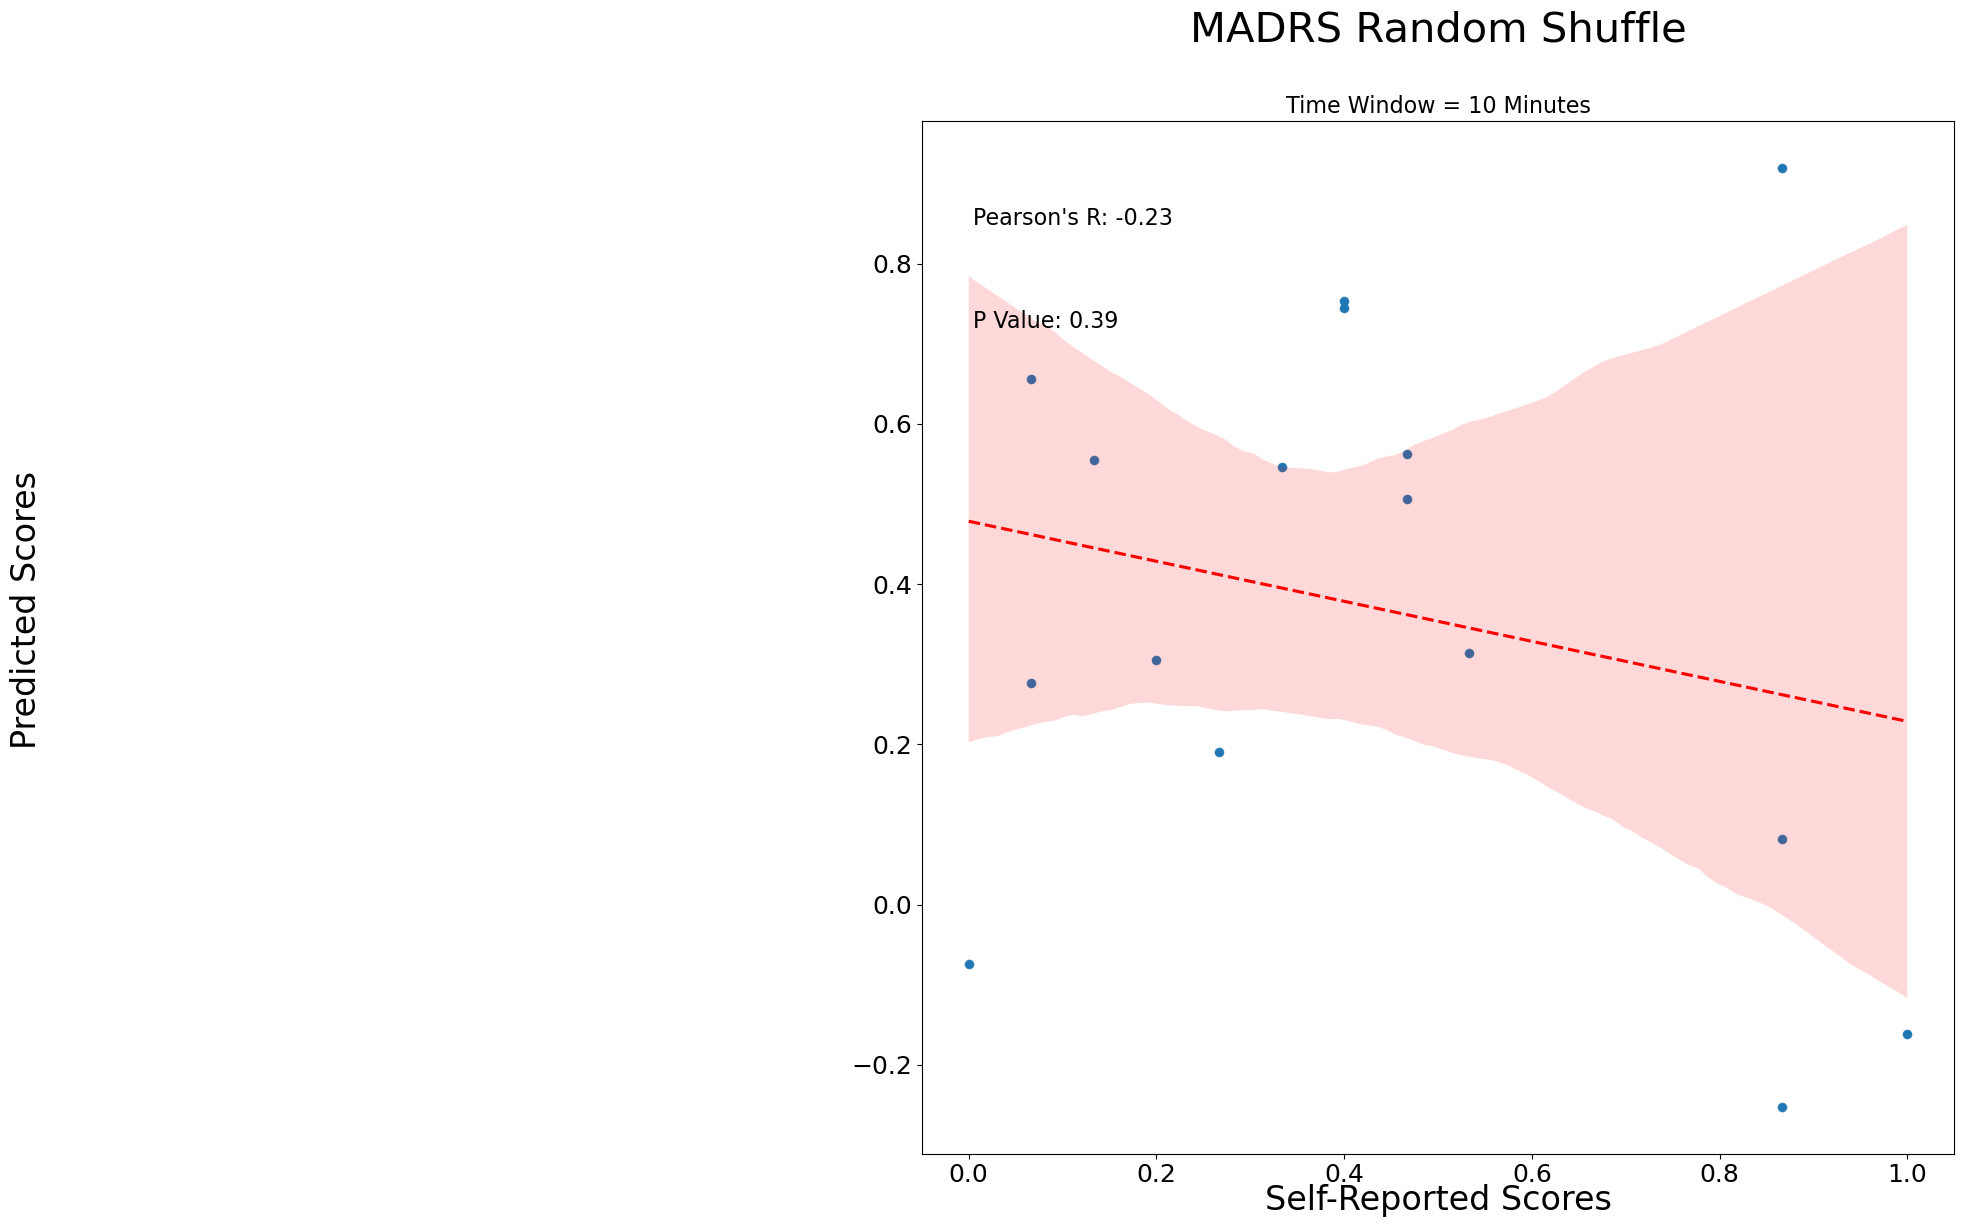

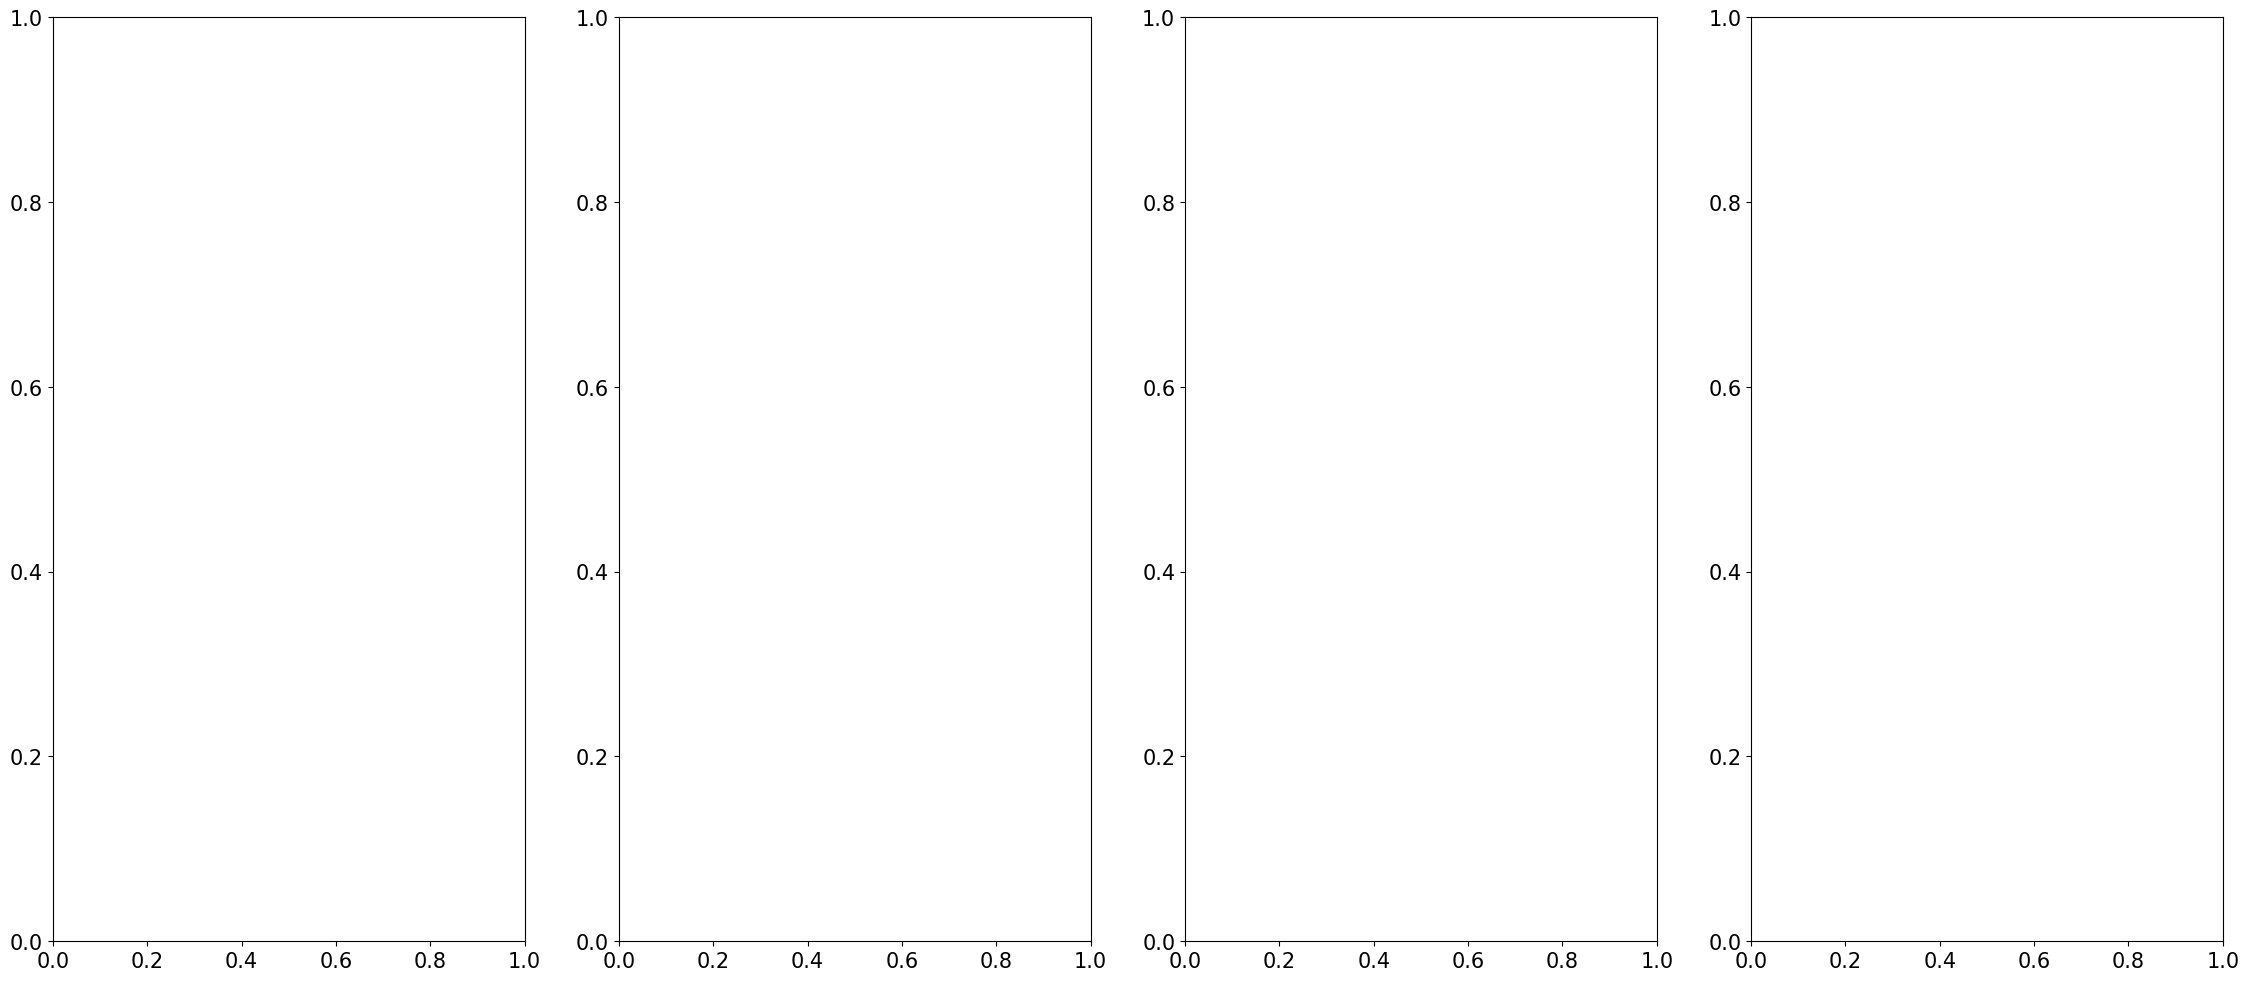

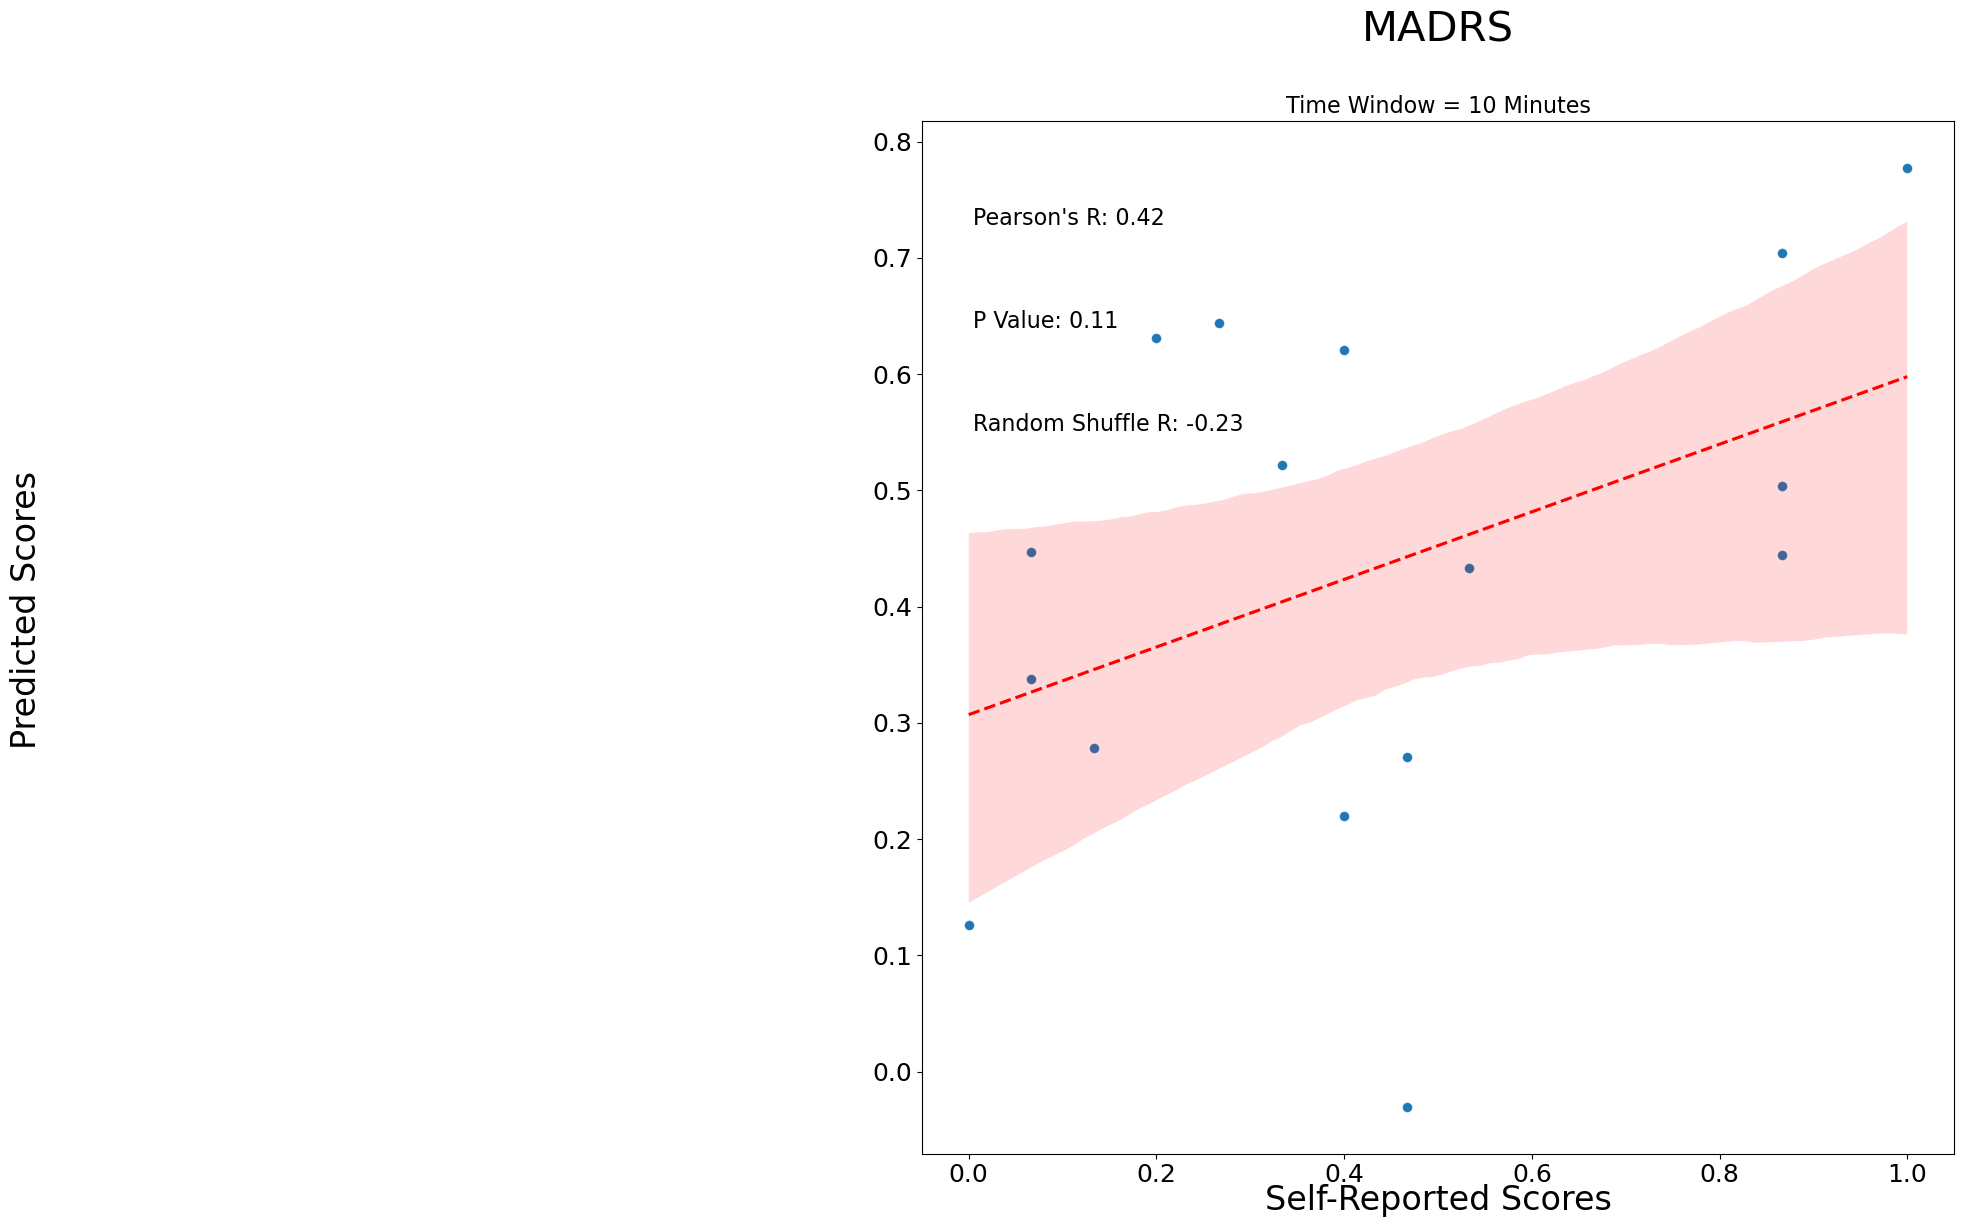

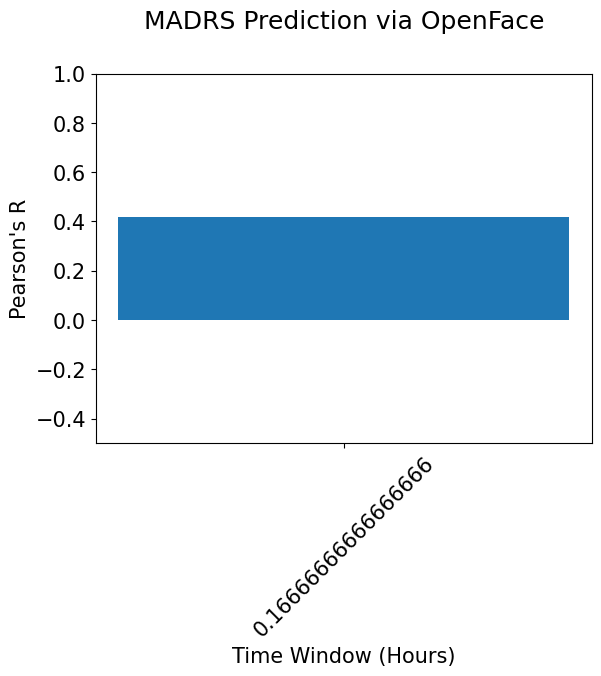

METRIC NOW:  MADRS


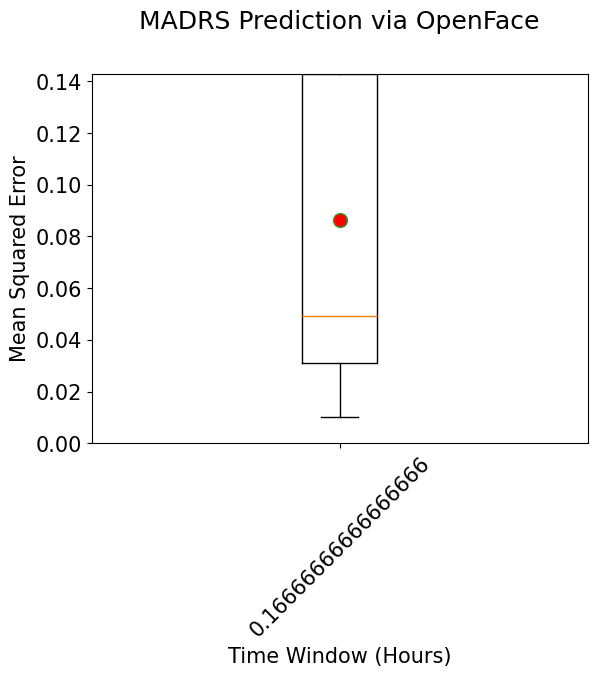

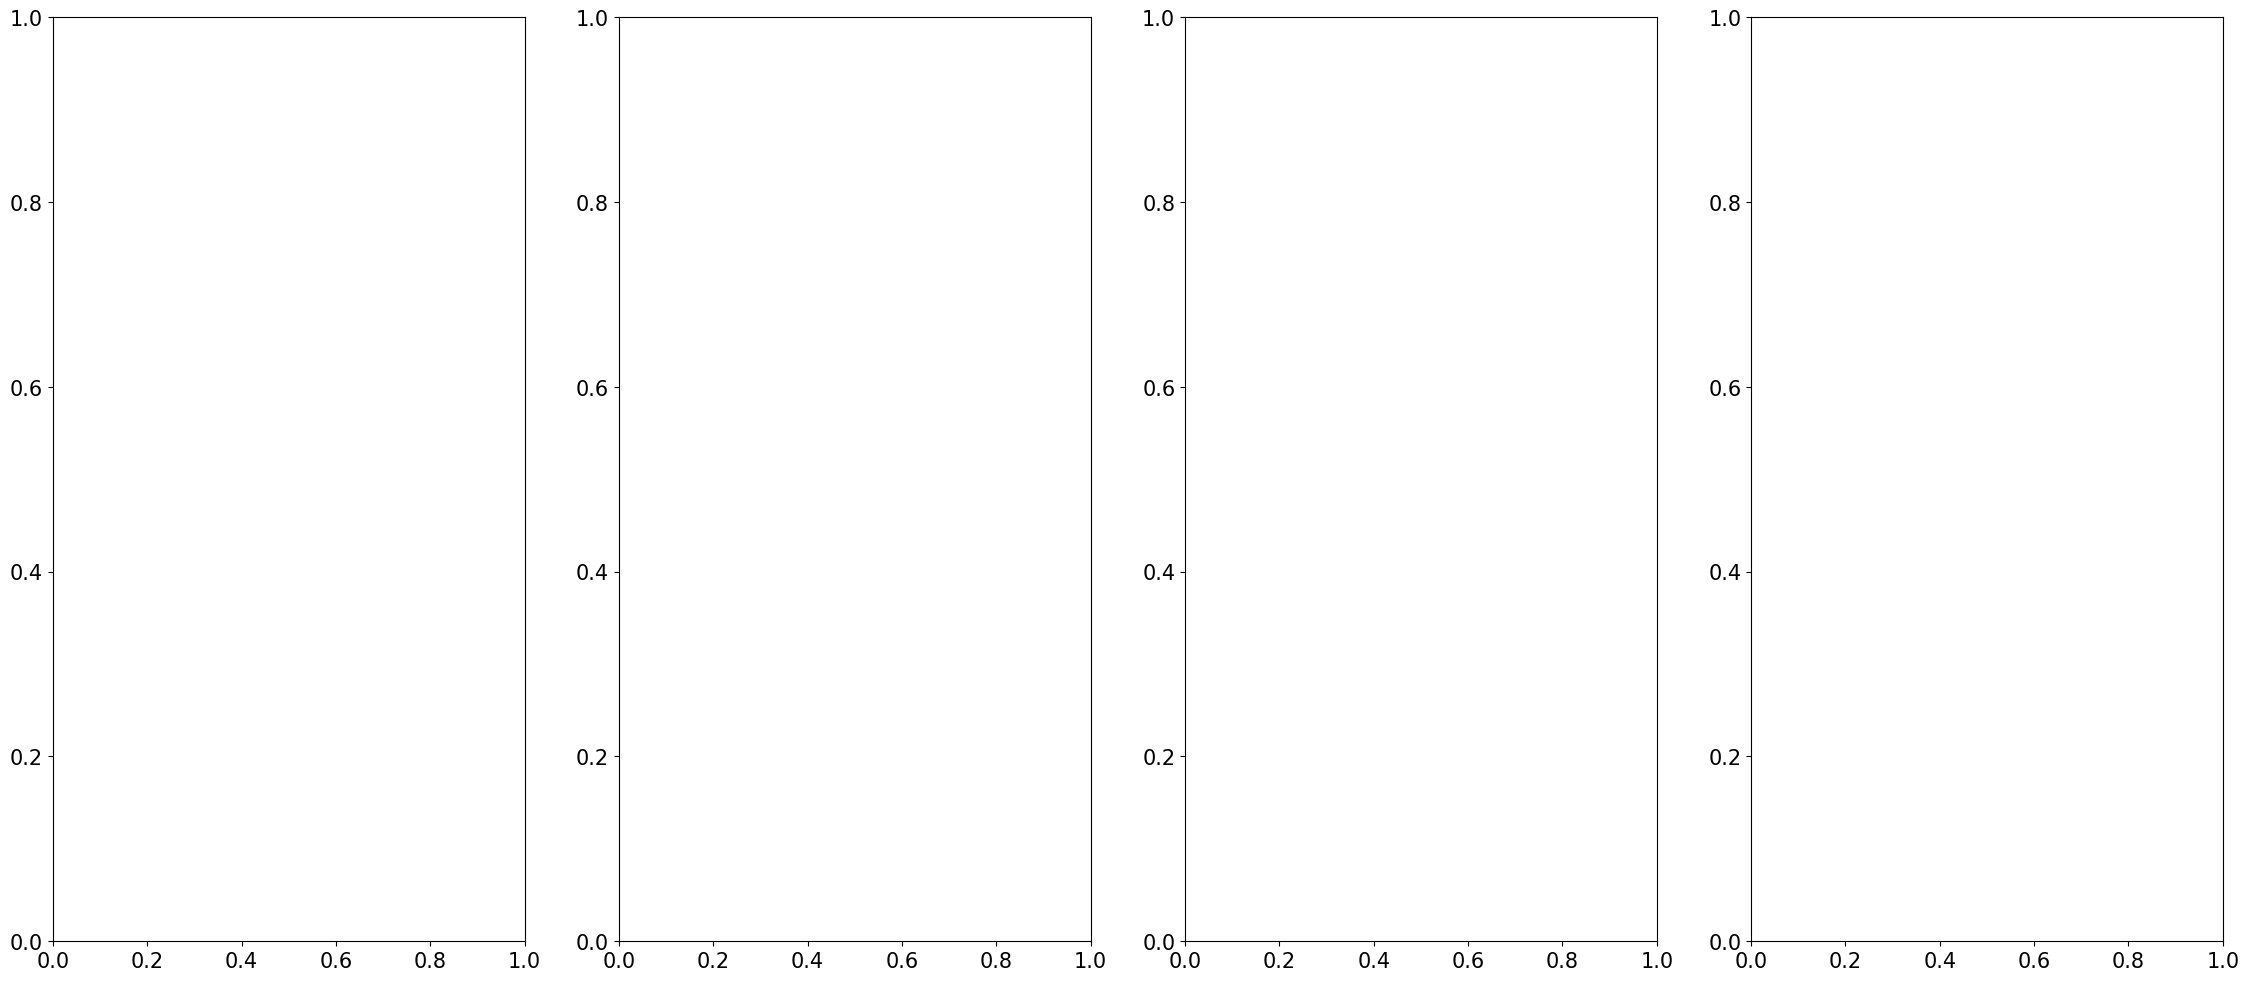

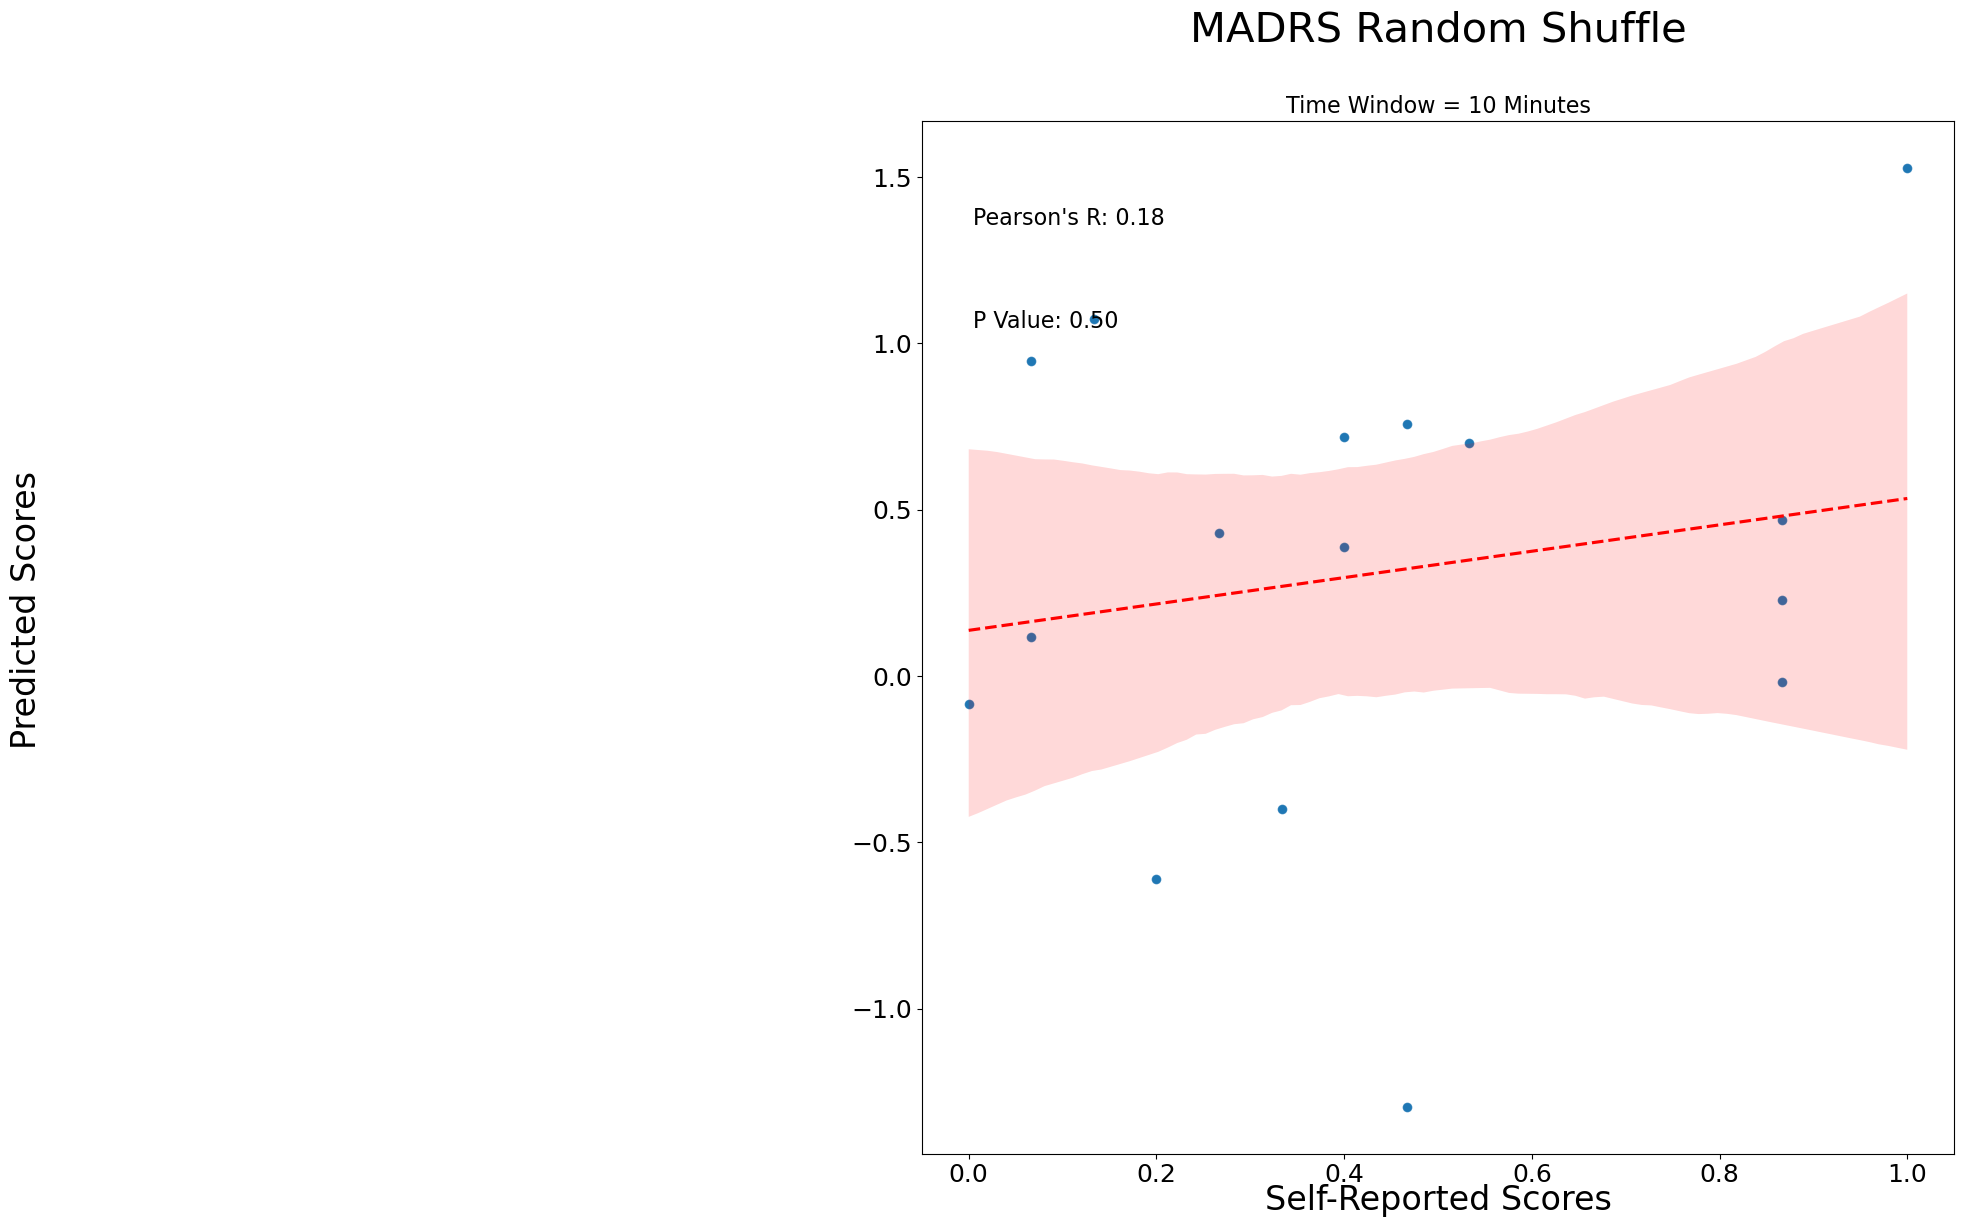

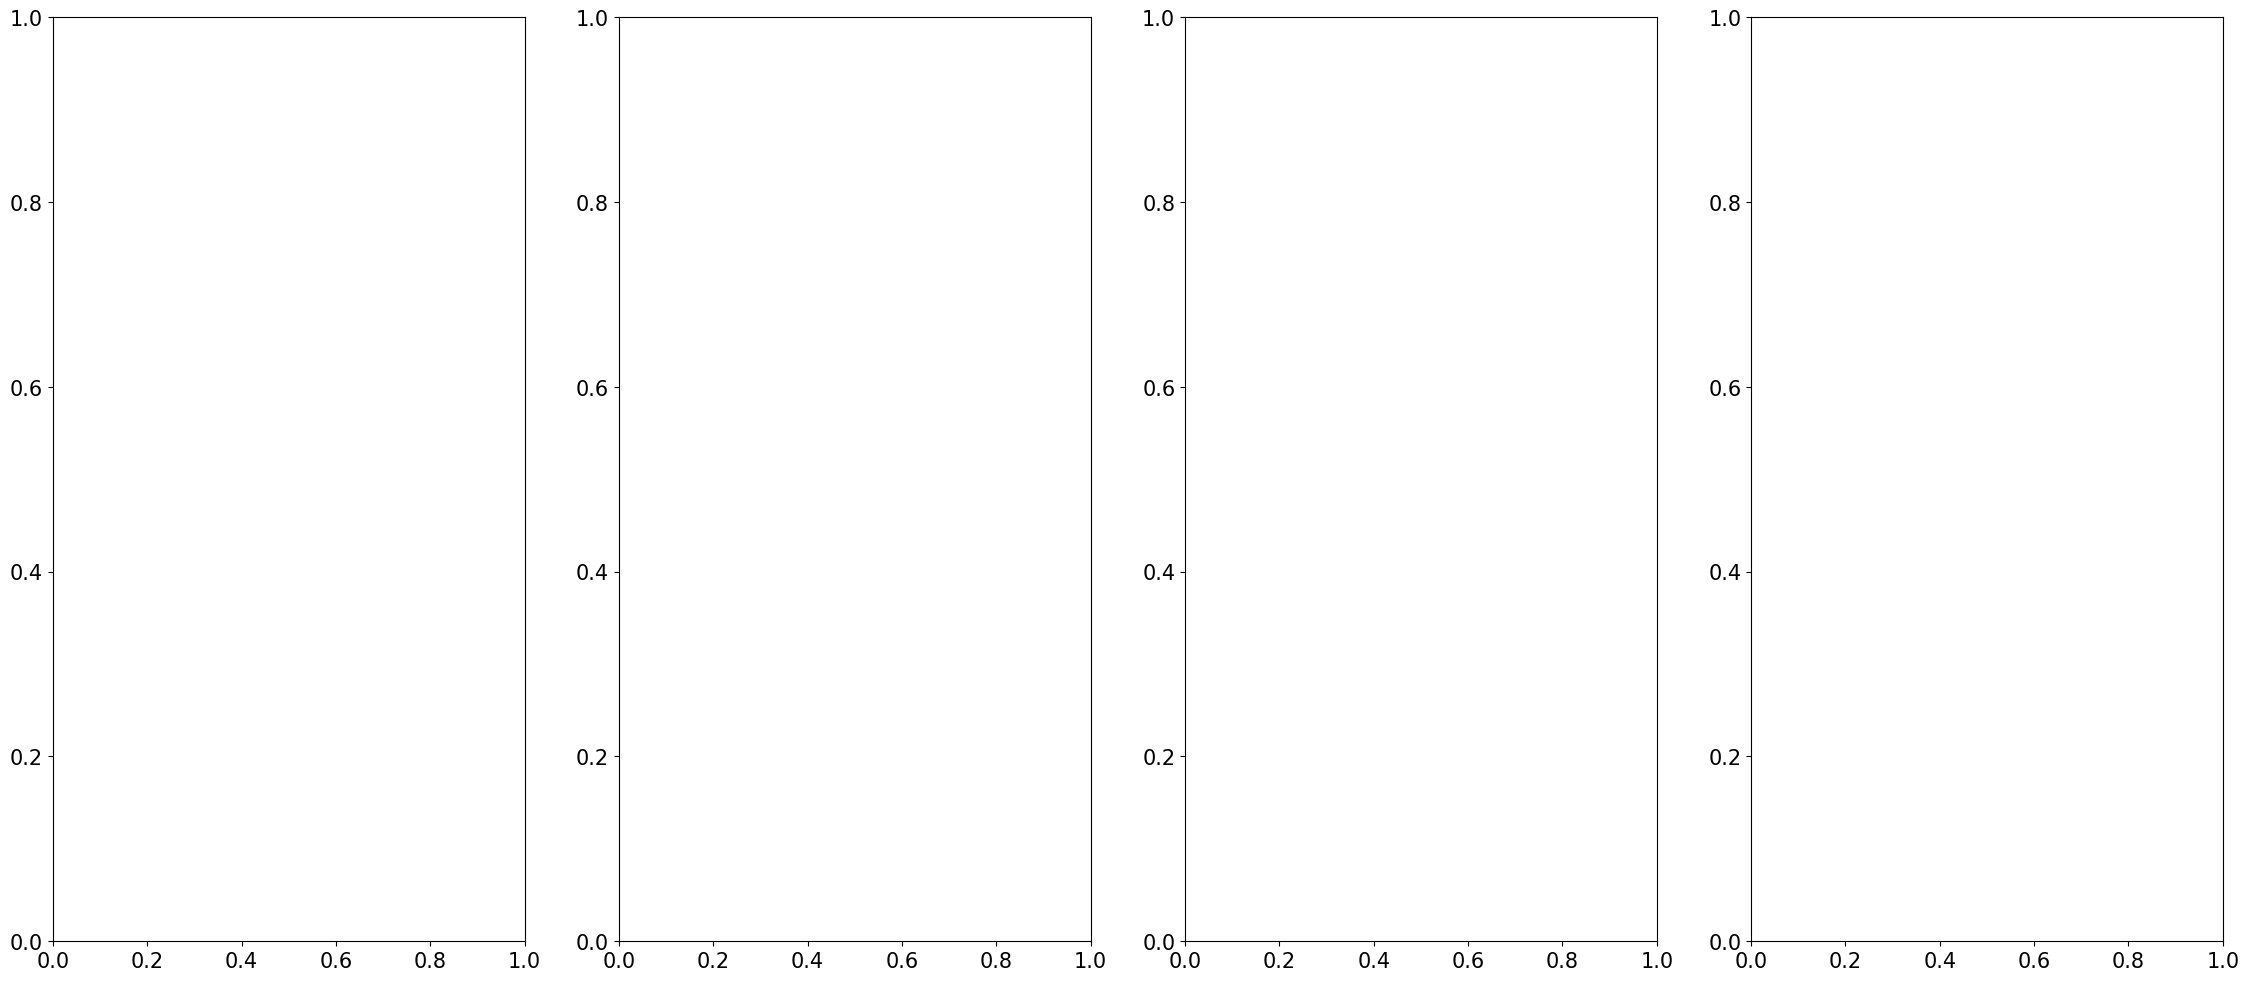

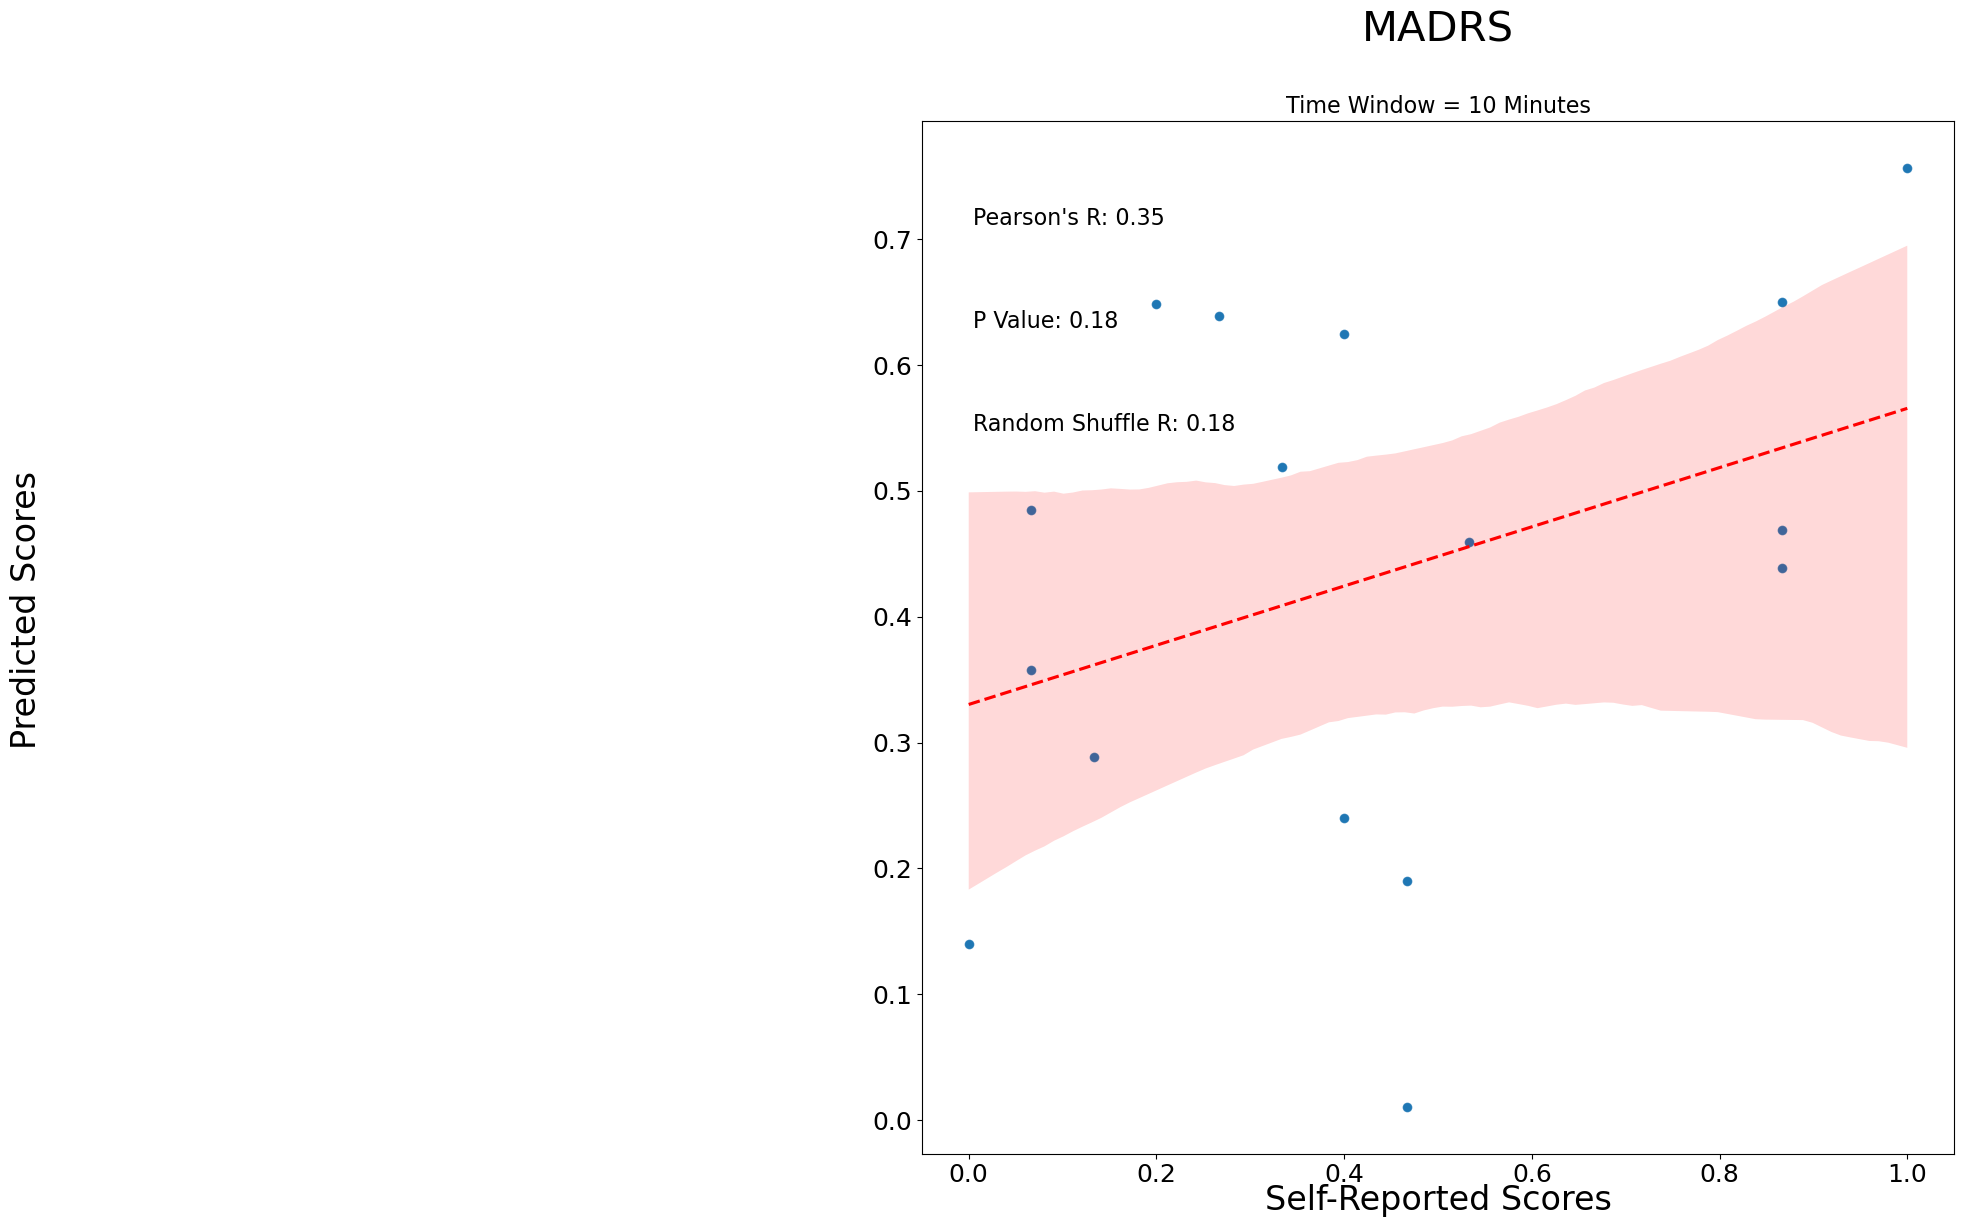

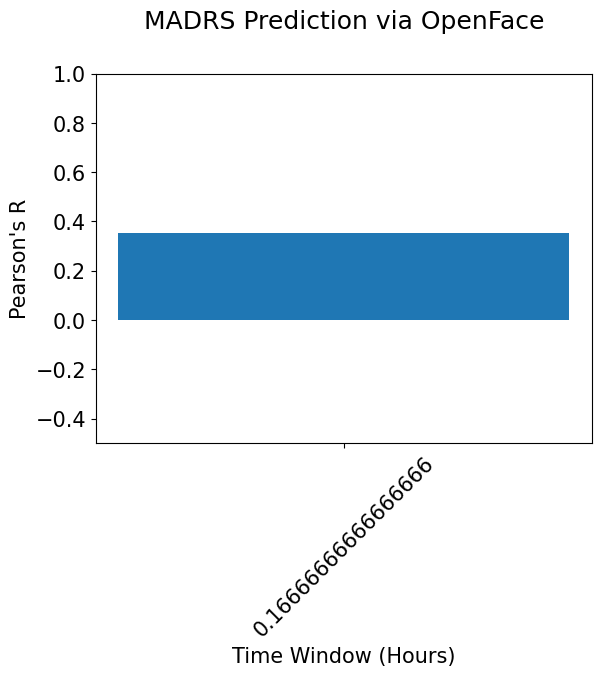

METRIC NOW:  MADRS


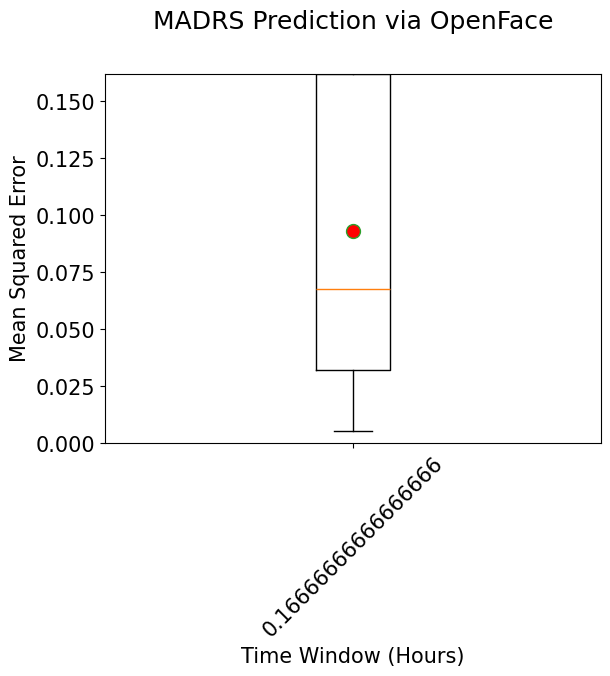

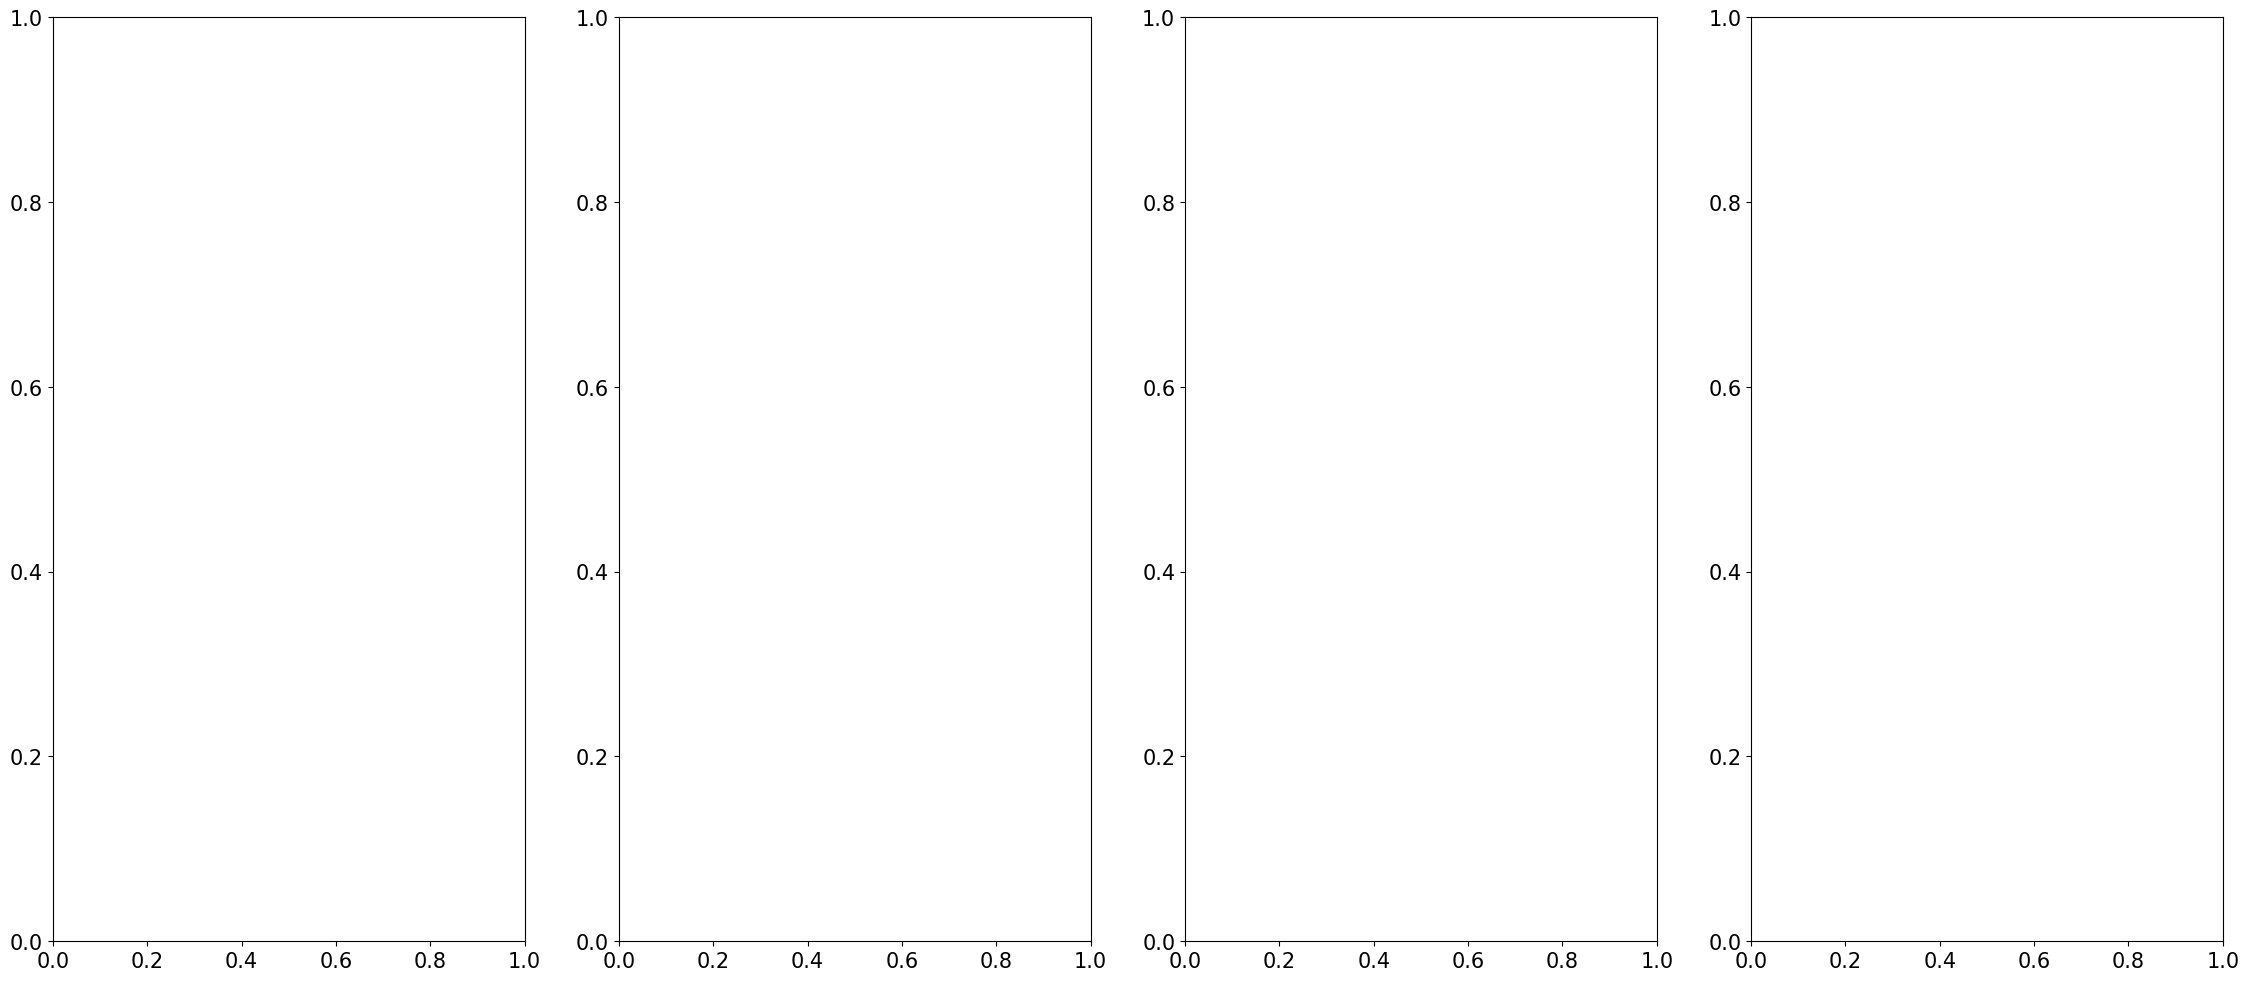

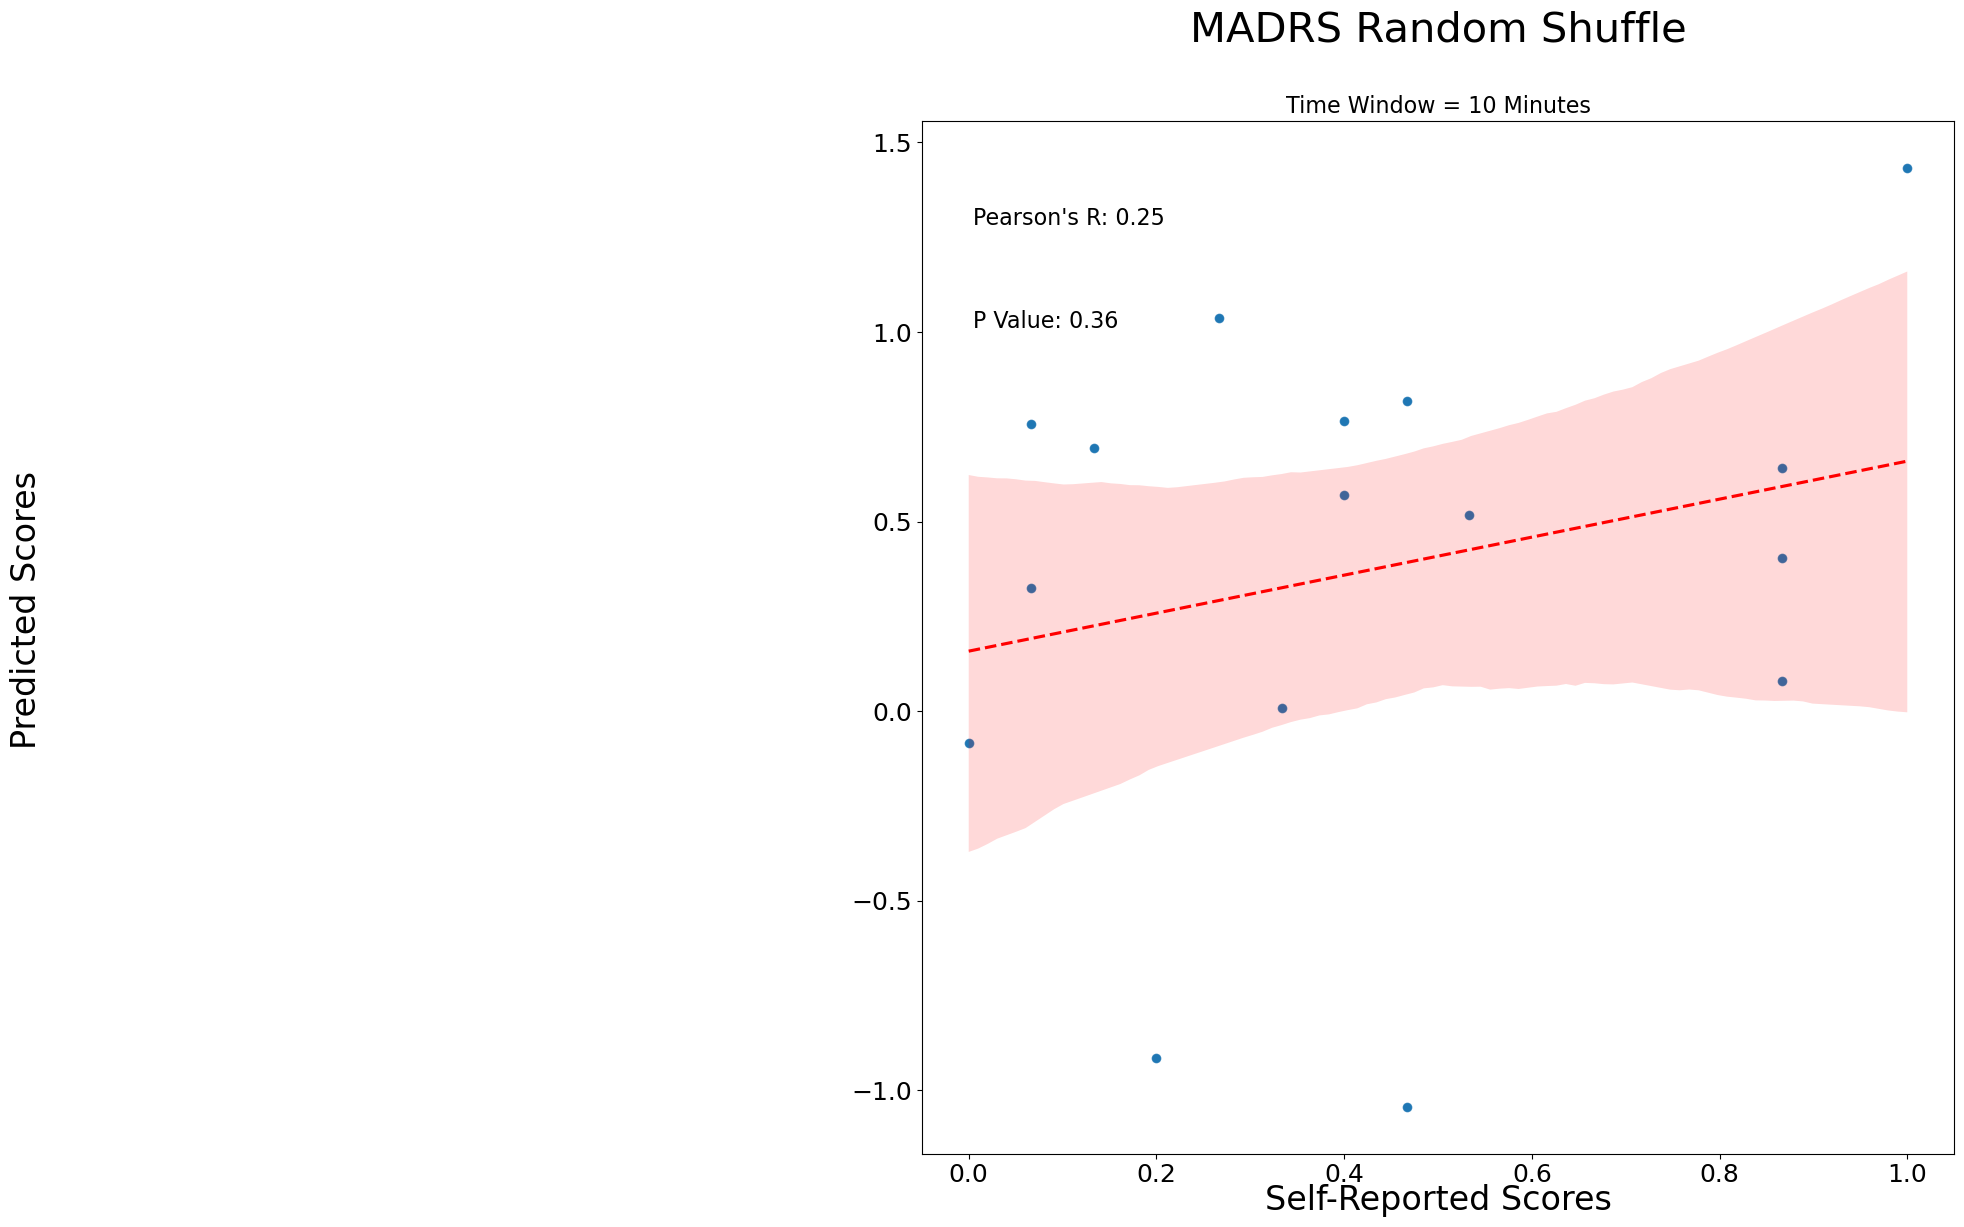

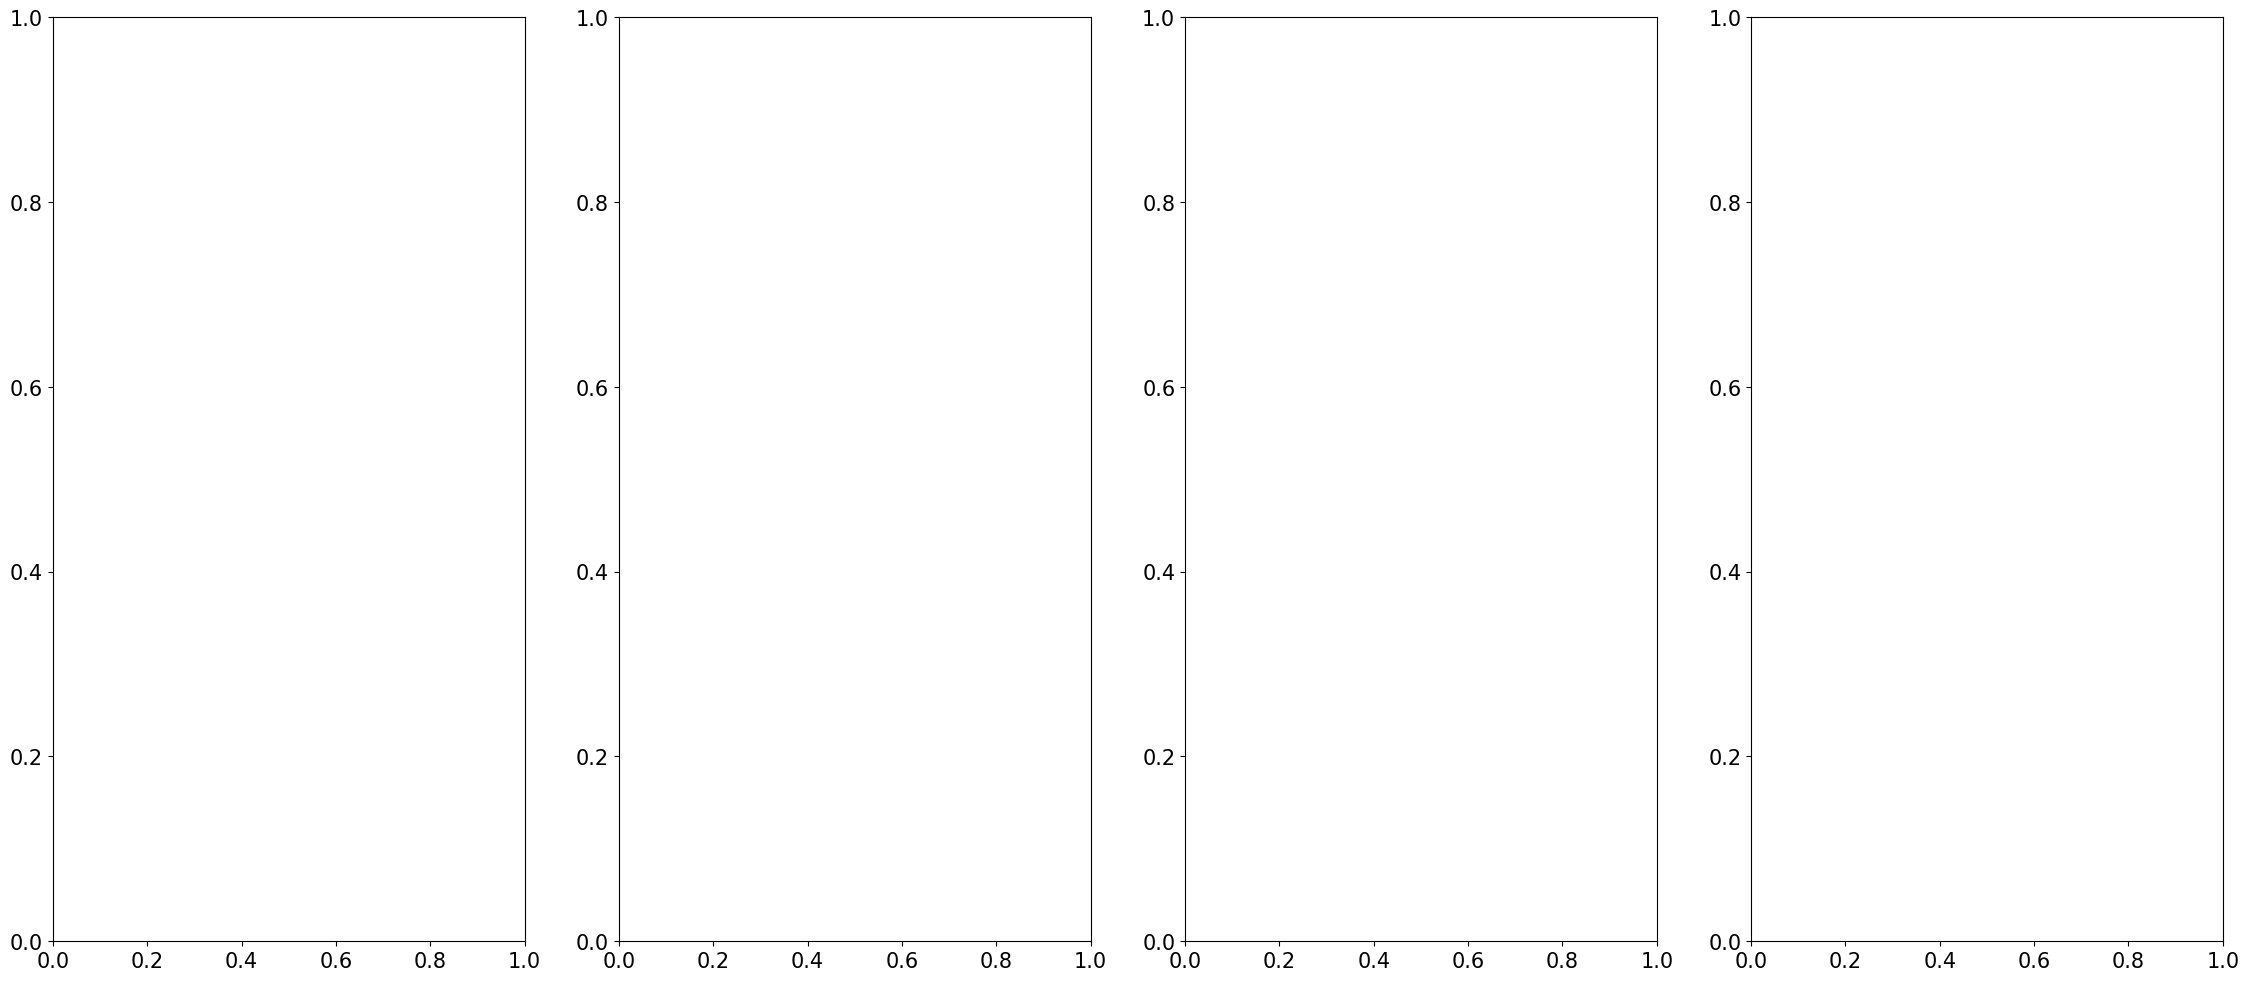

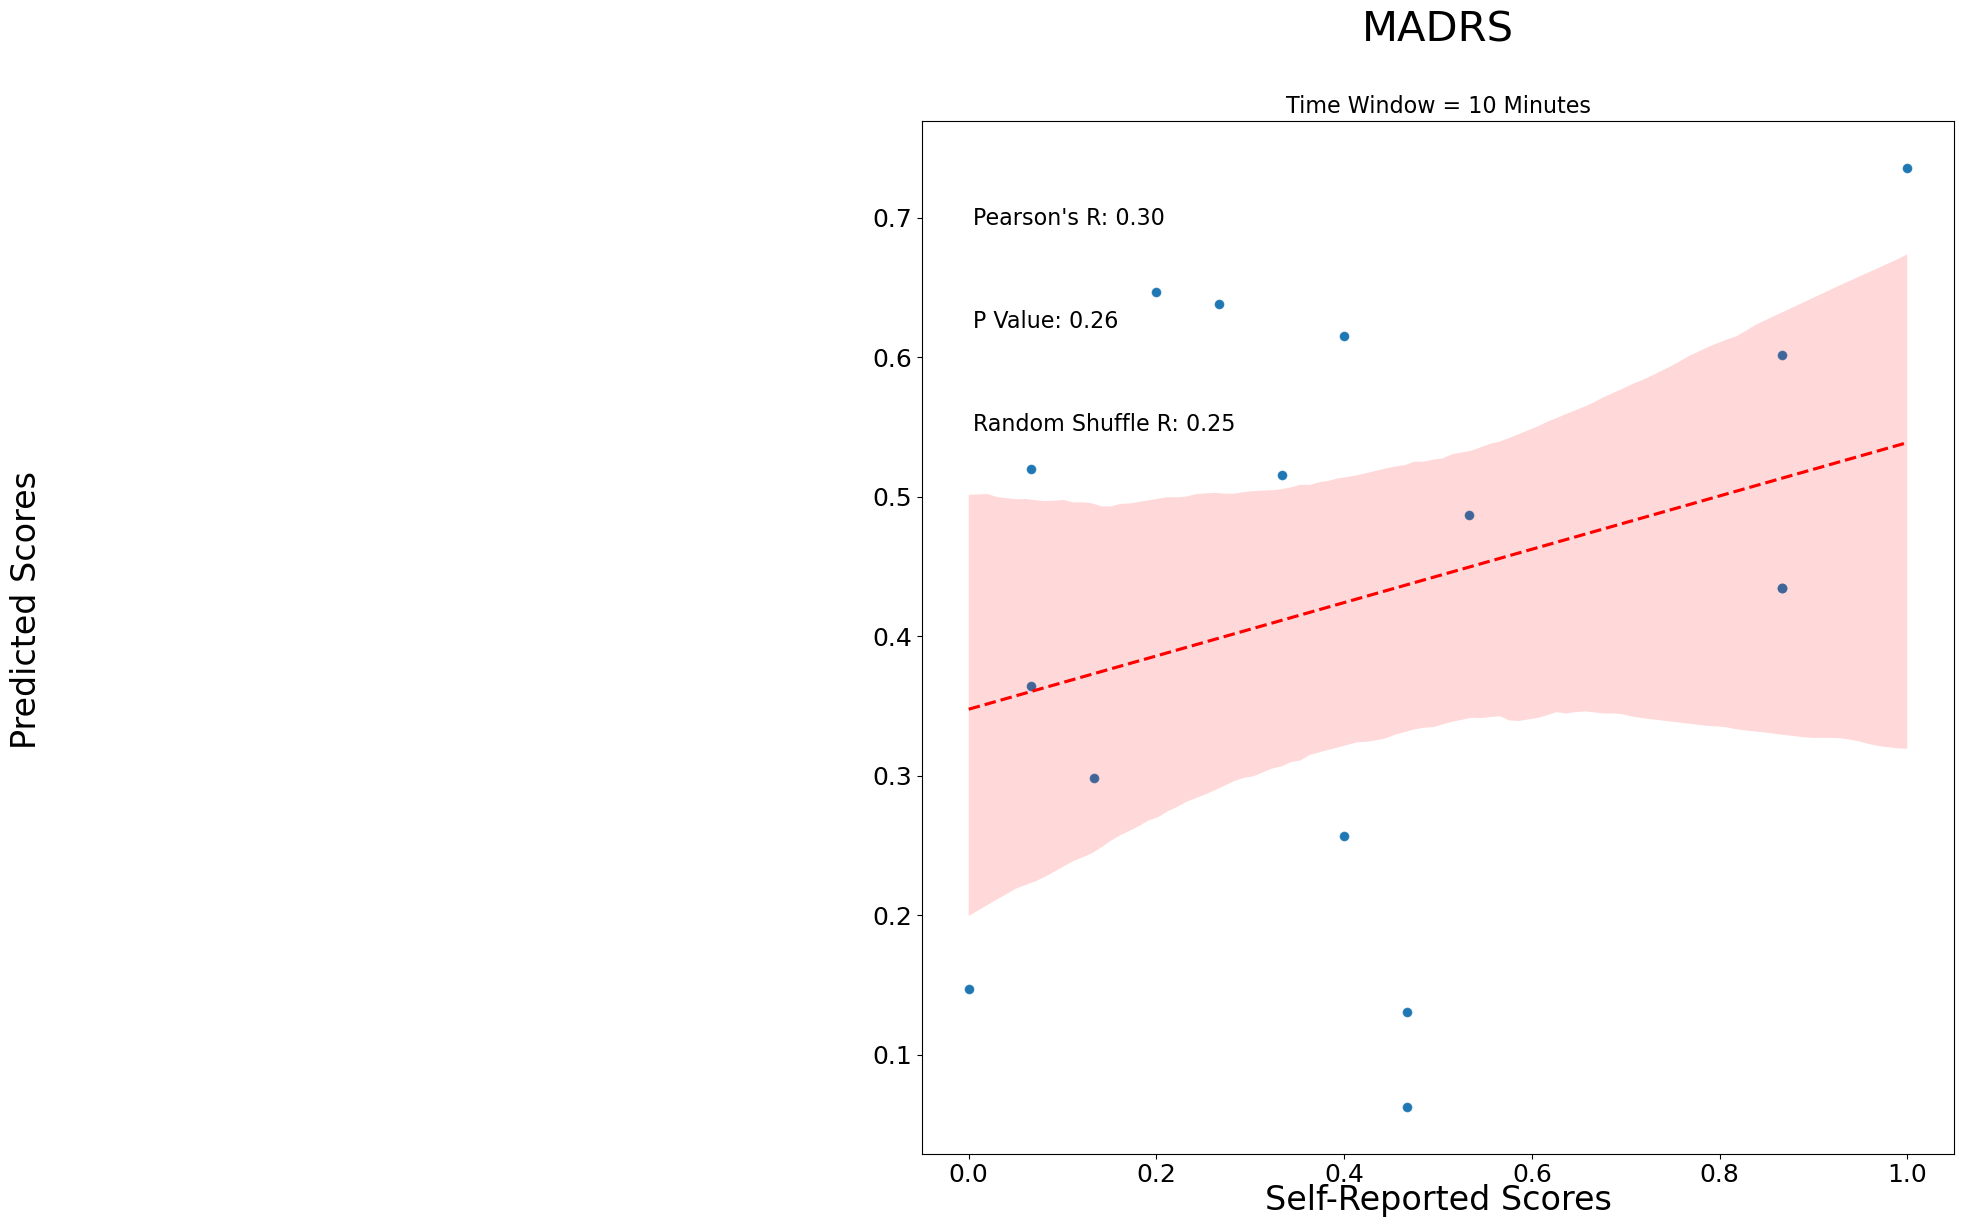

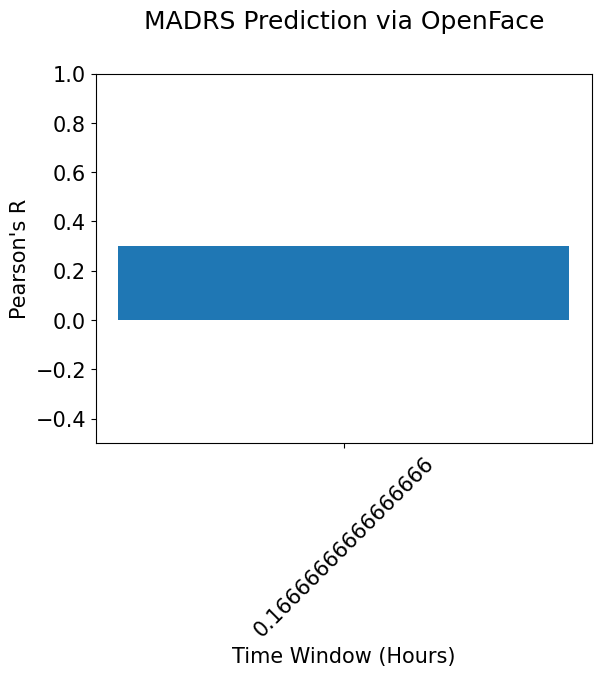

METRIC NOW:  MADRS


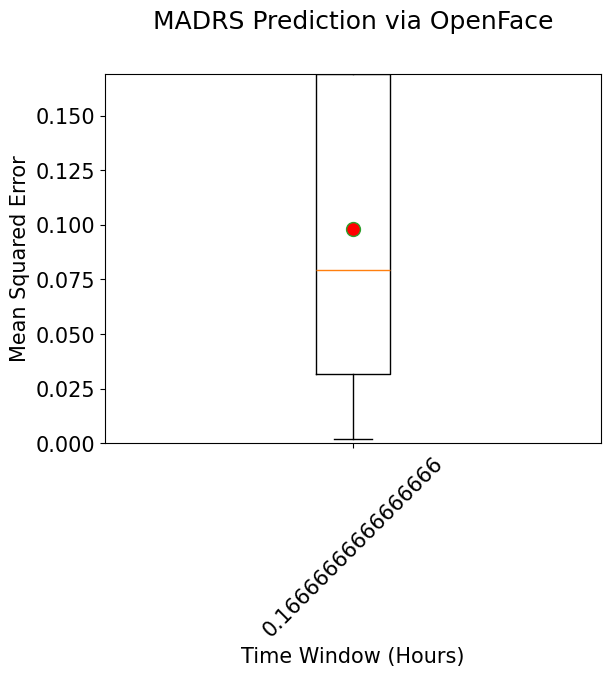

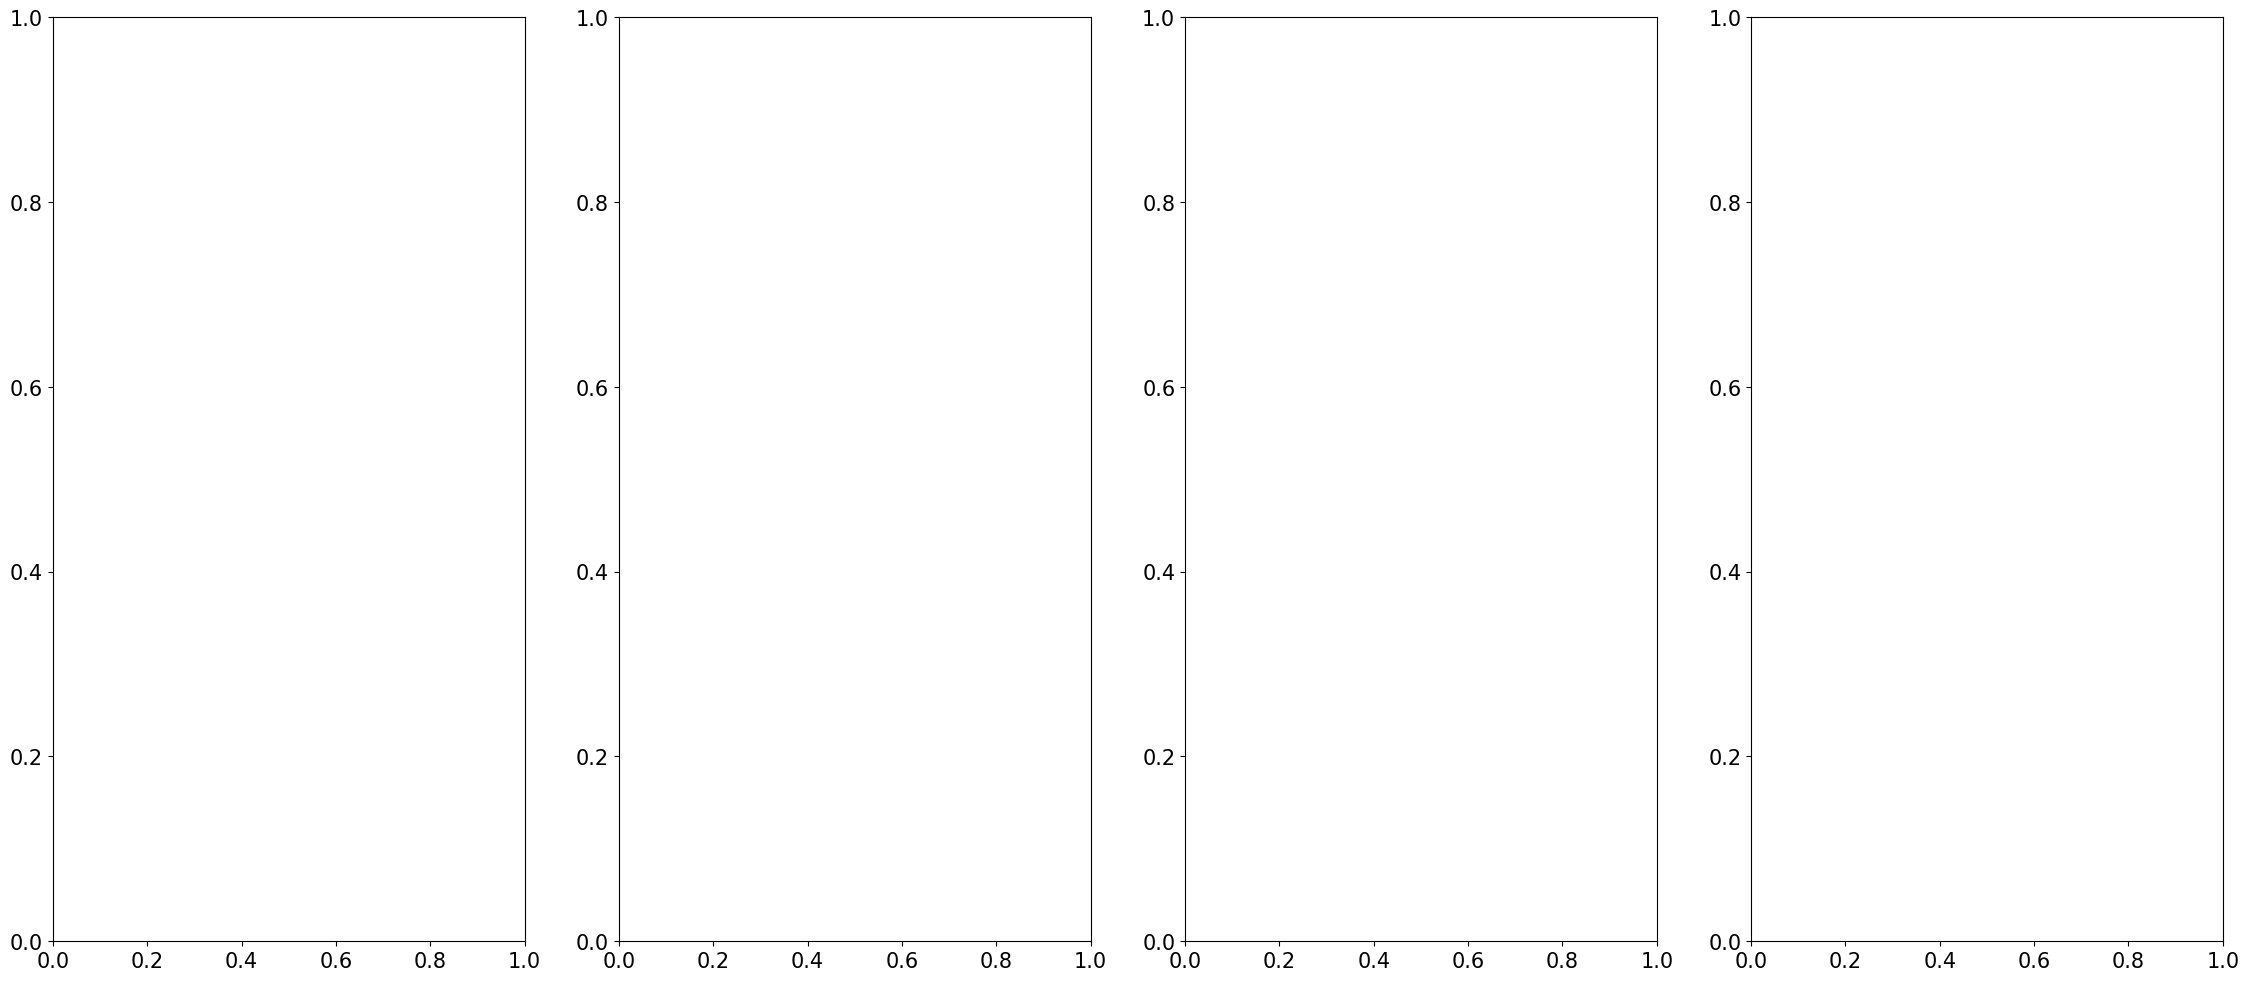

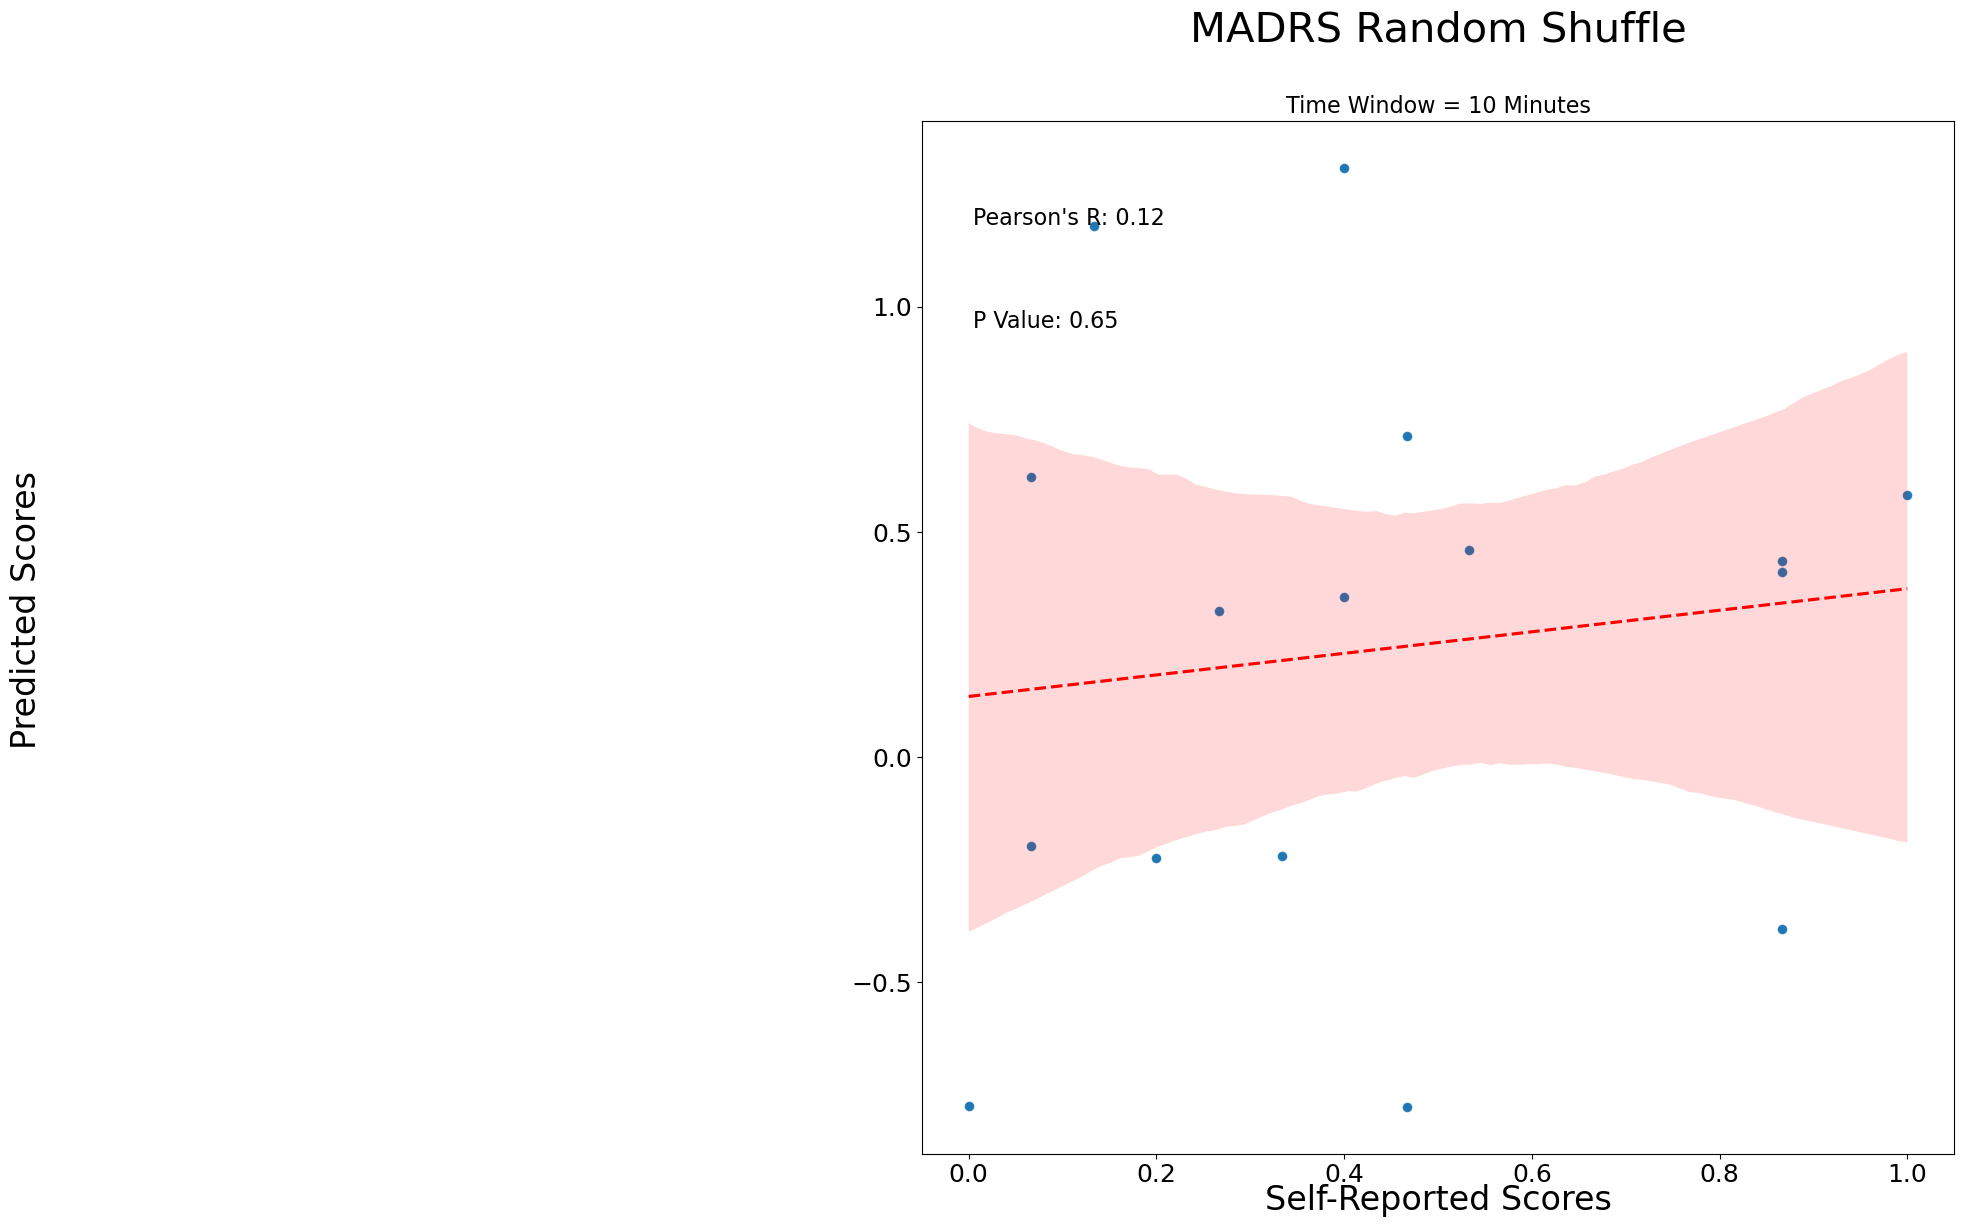

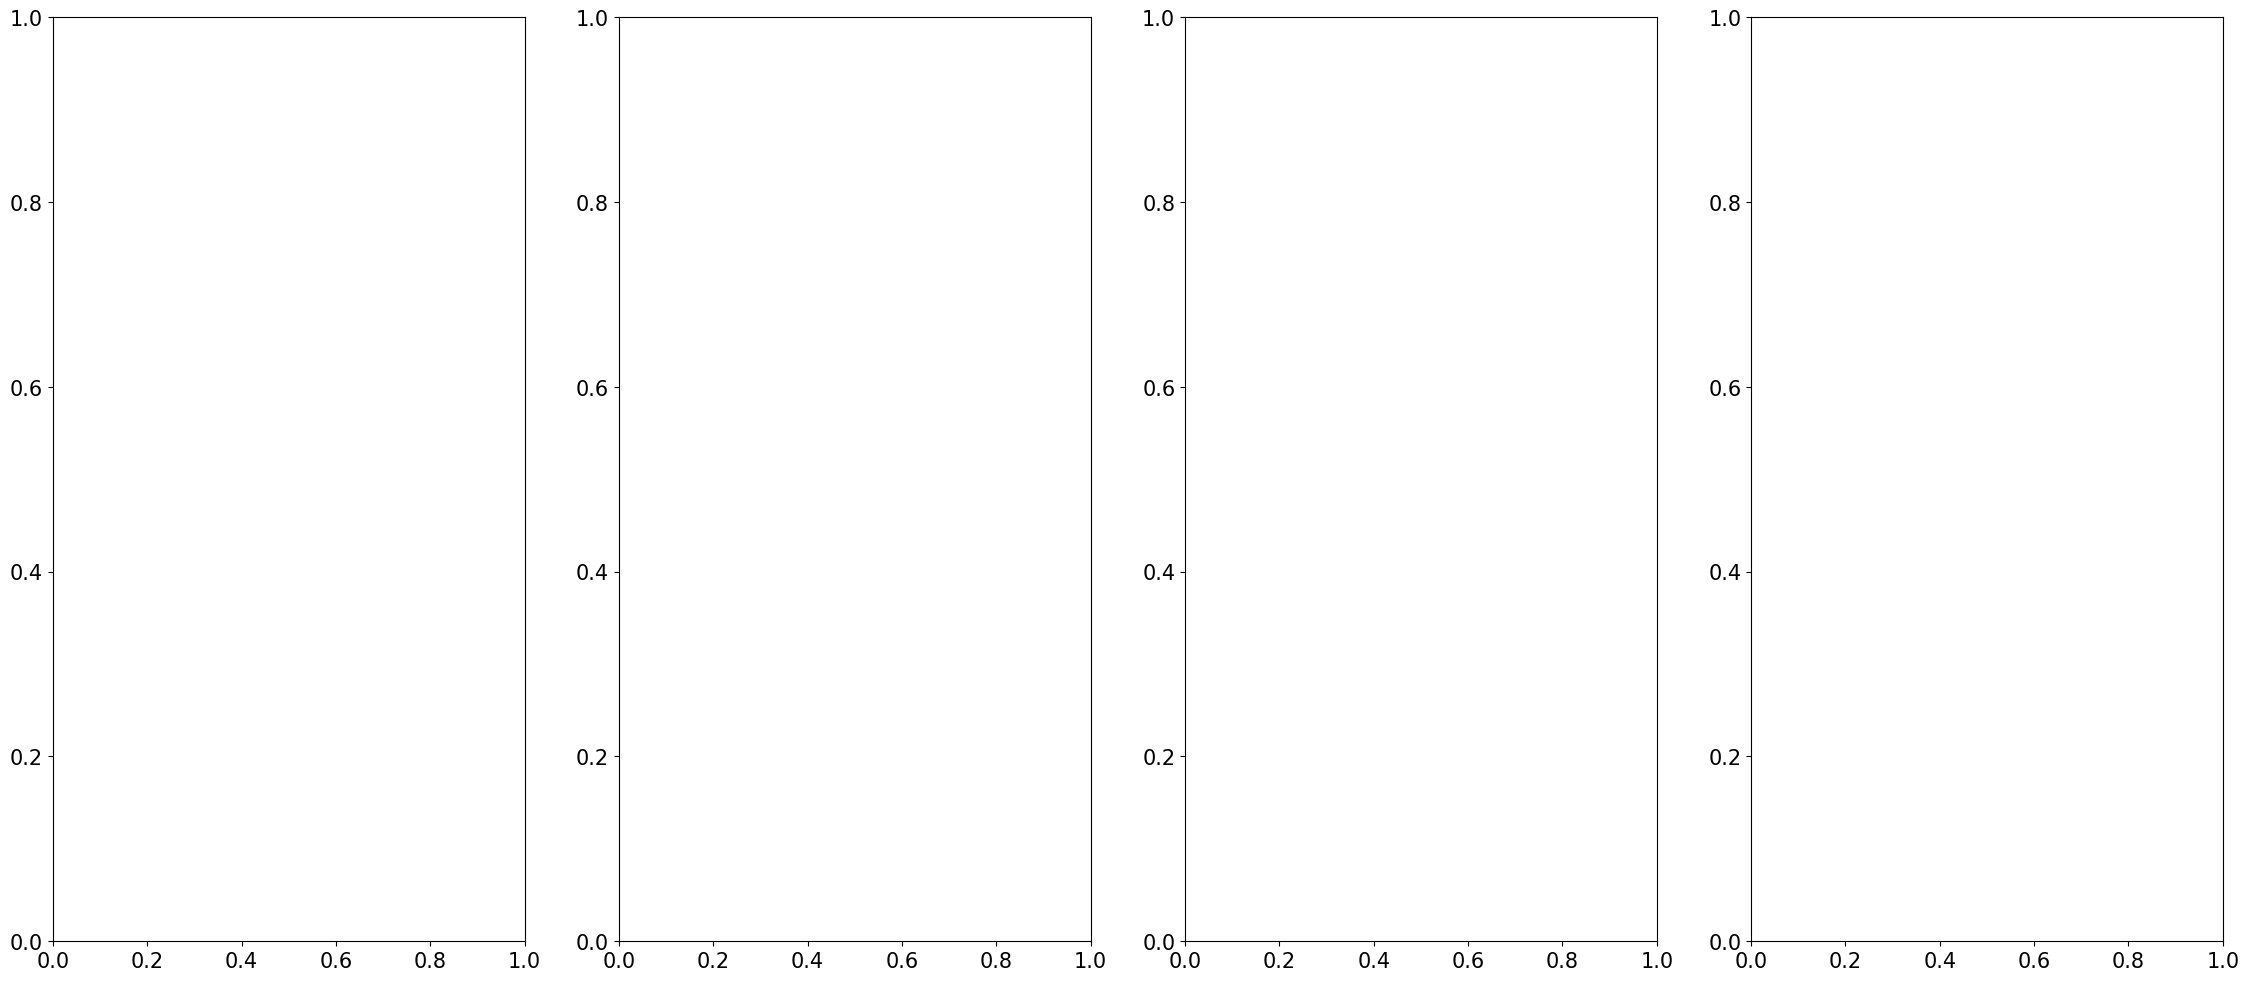

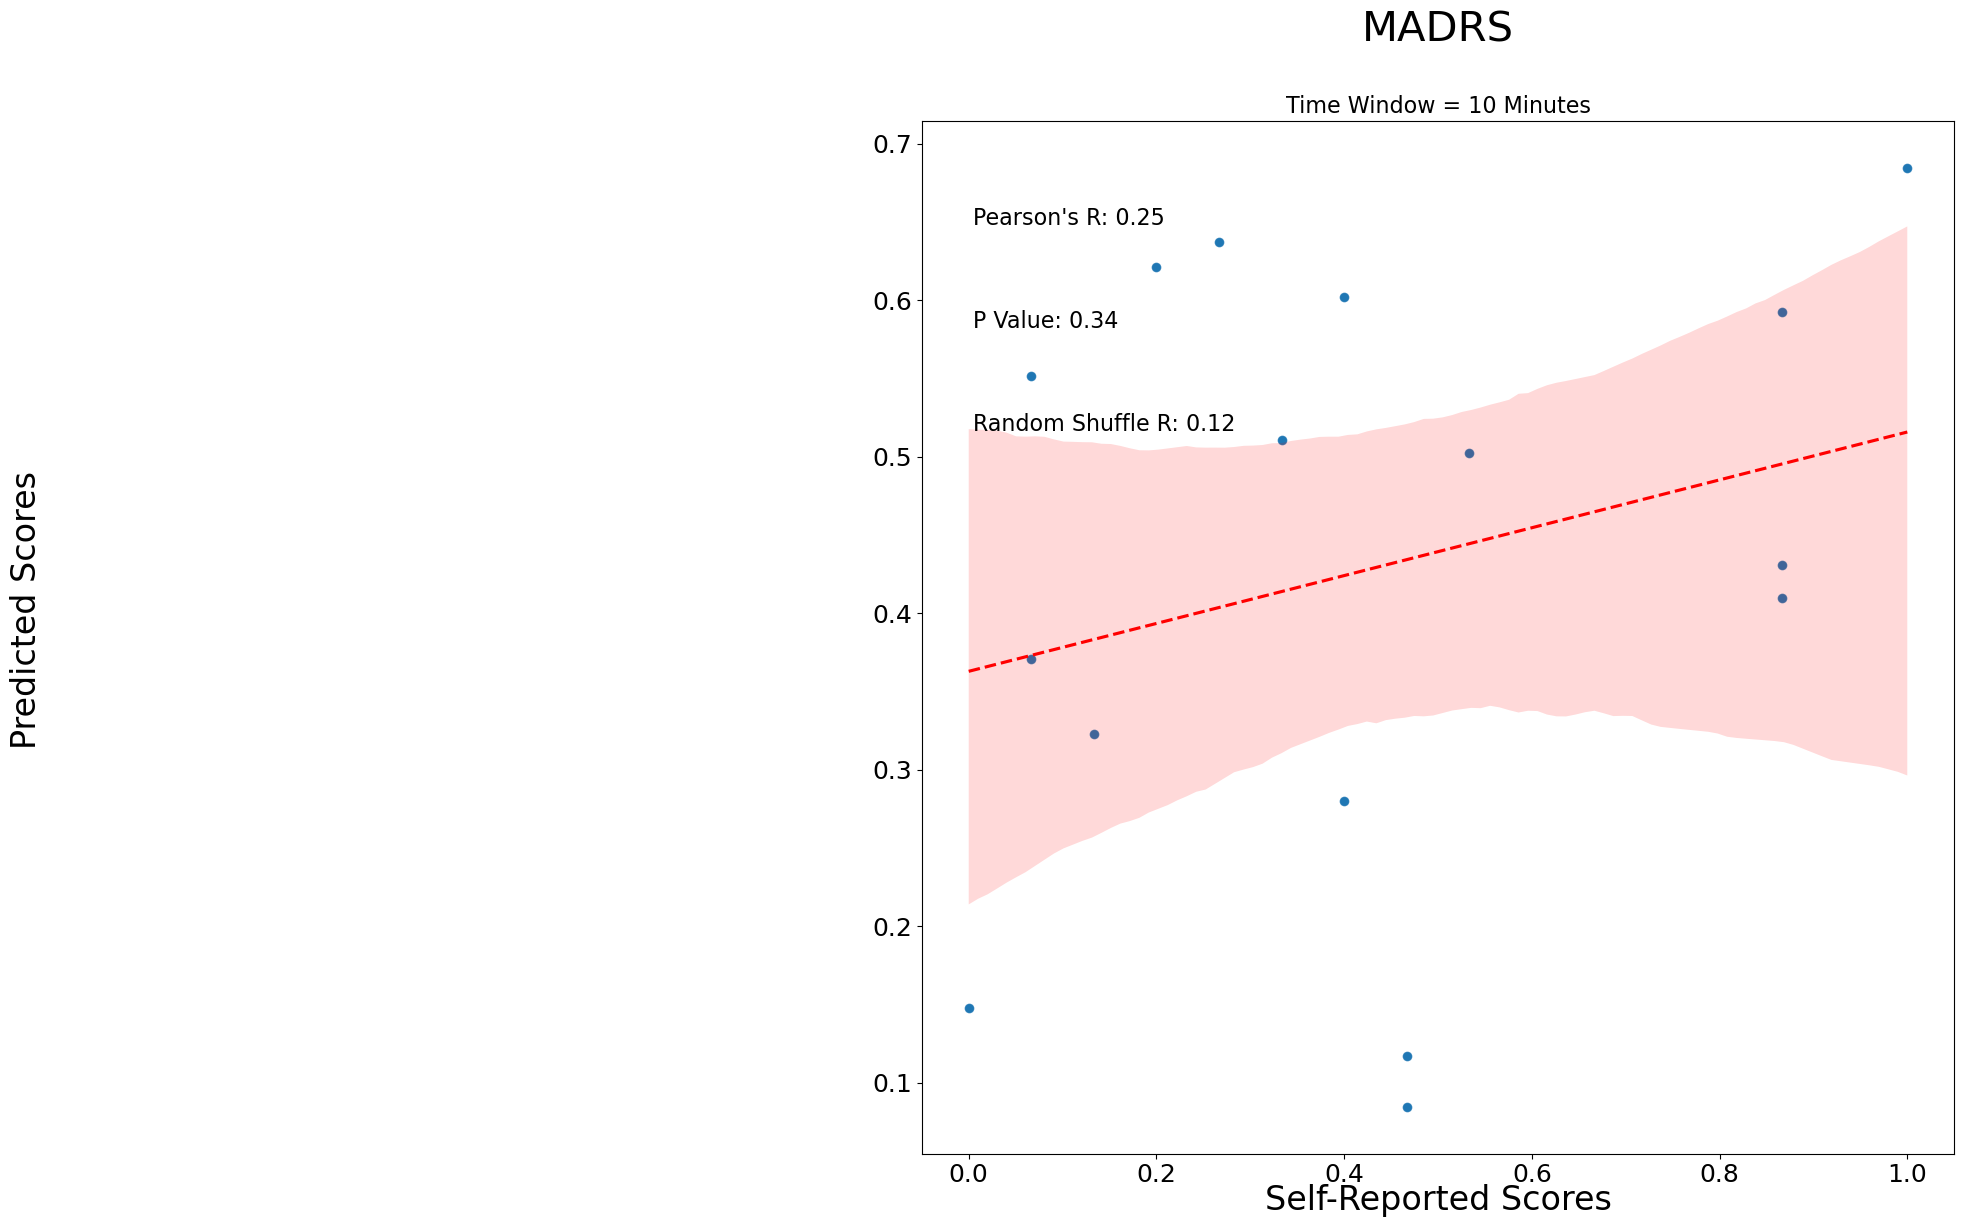

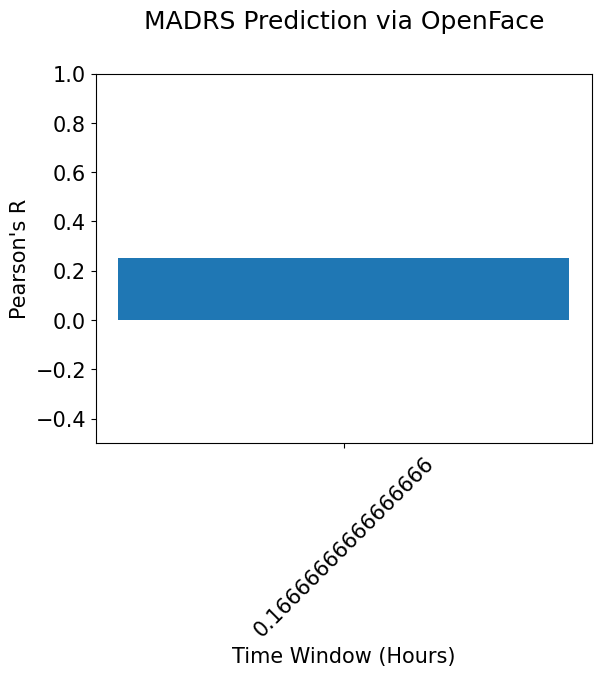

METRIC NOW:  MADRS


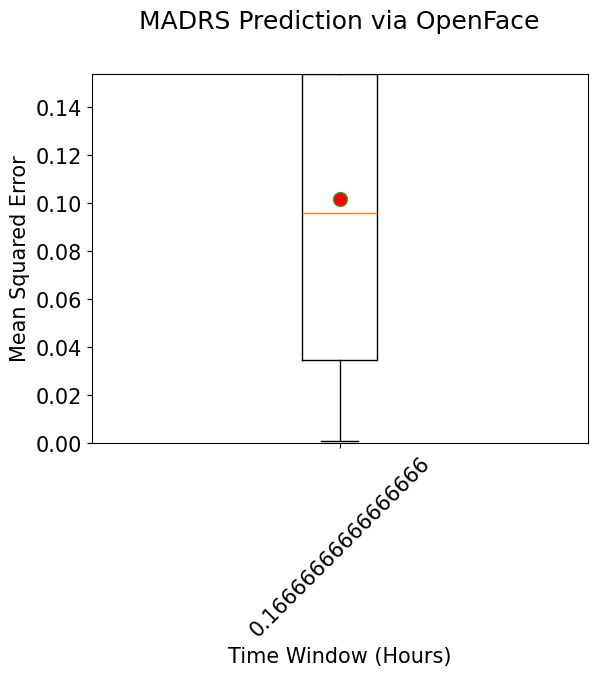

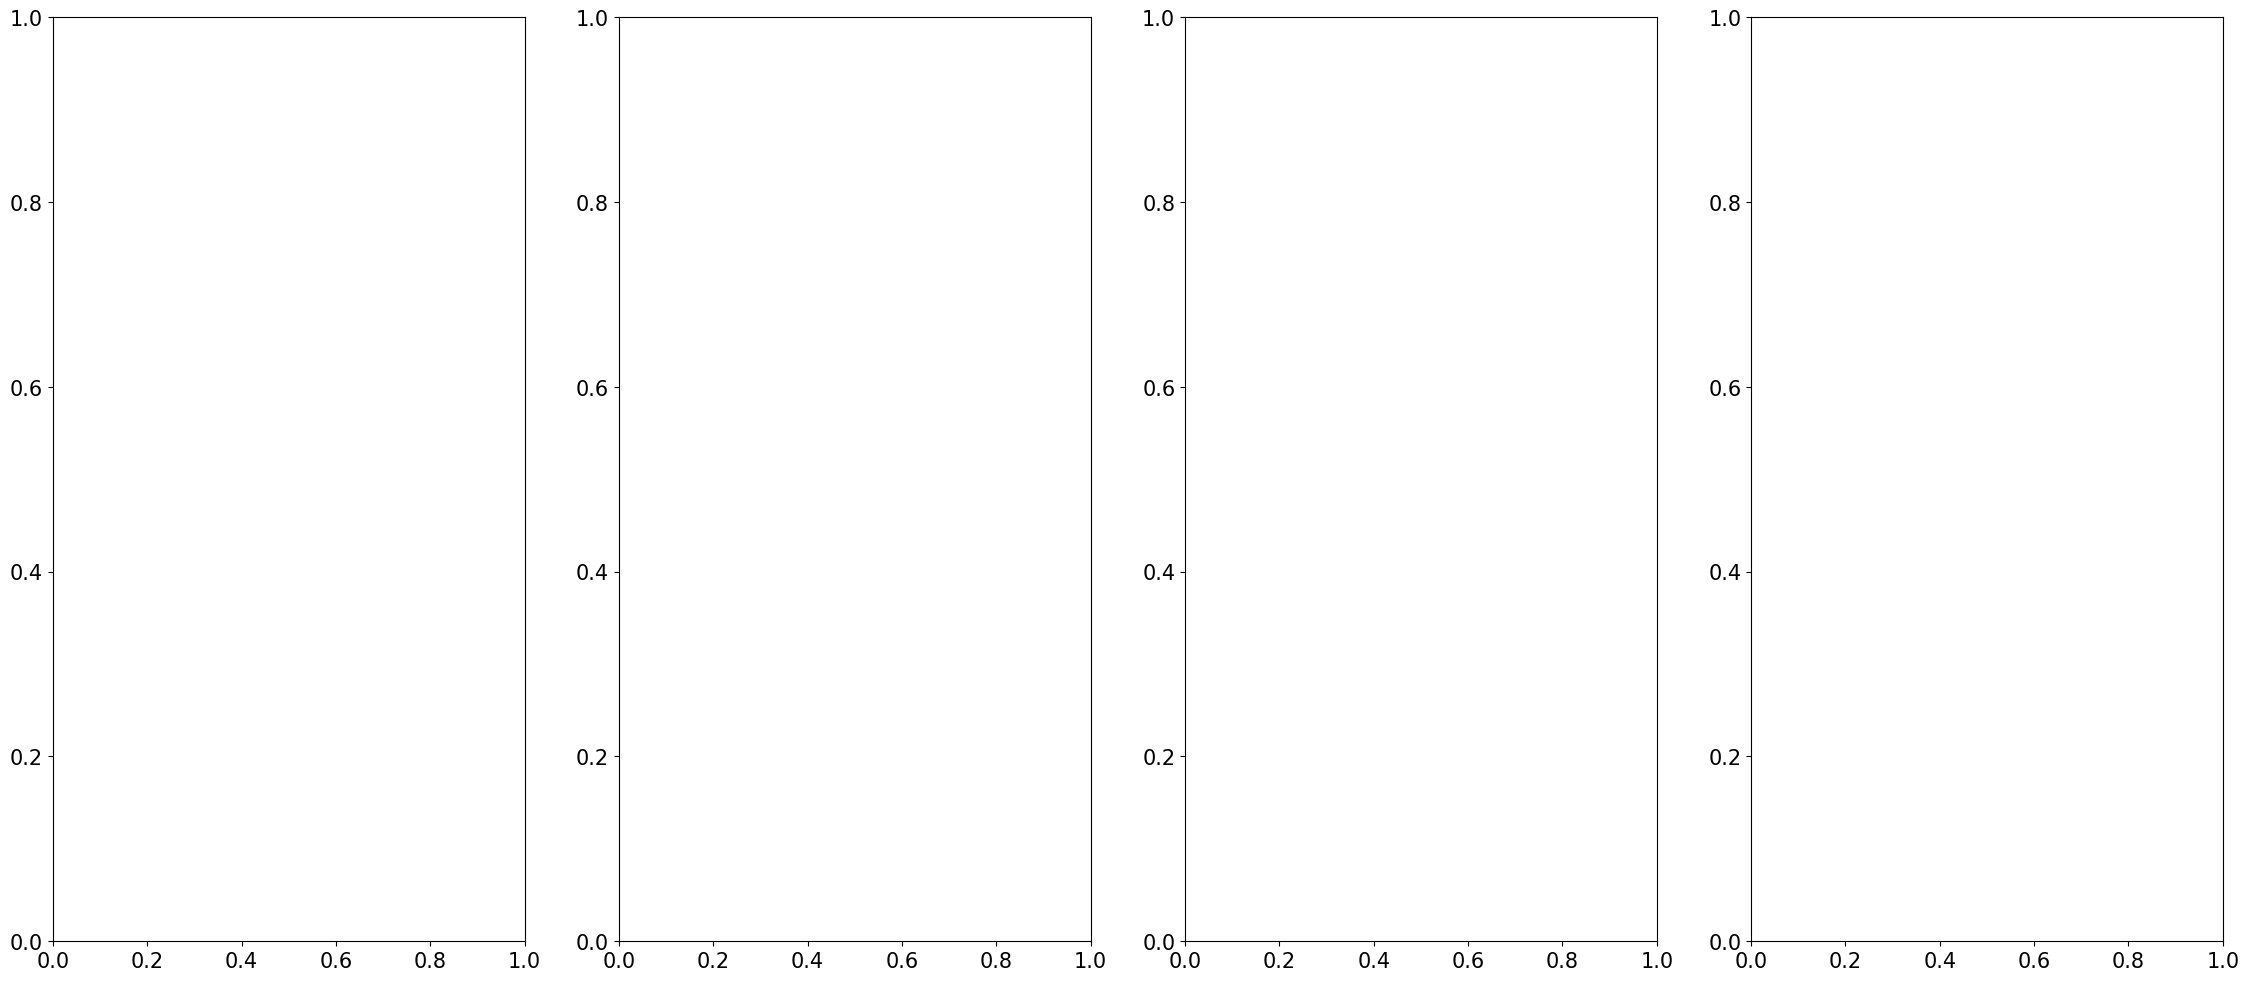

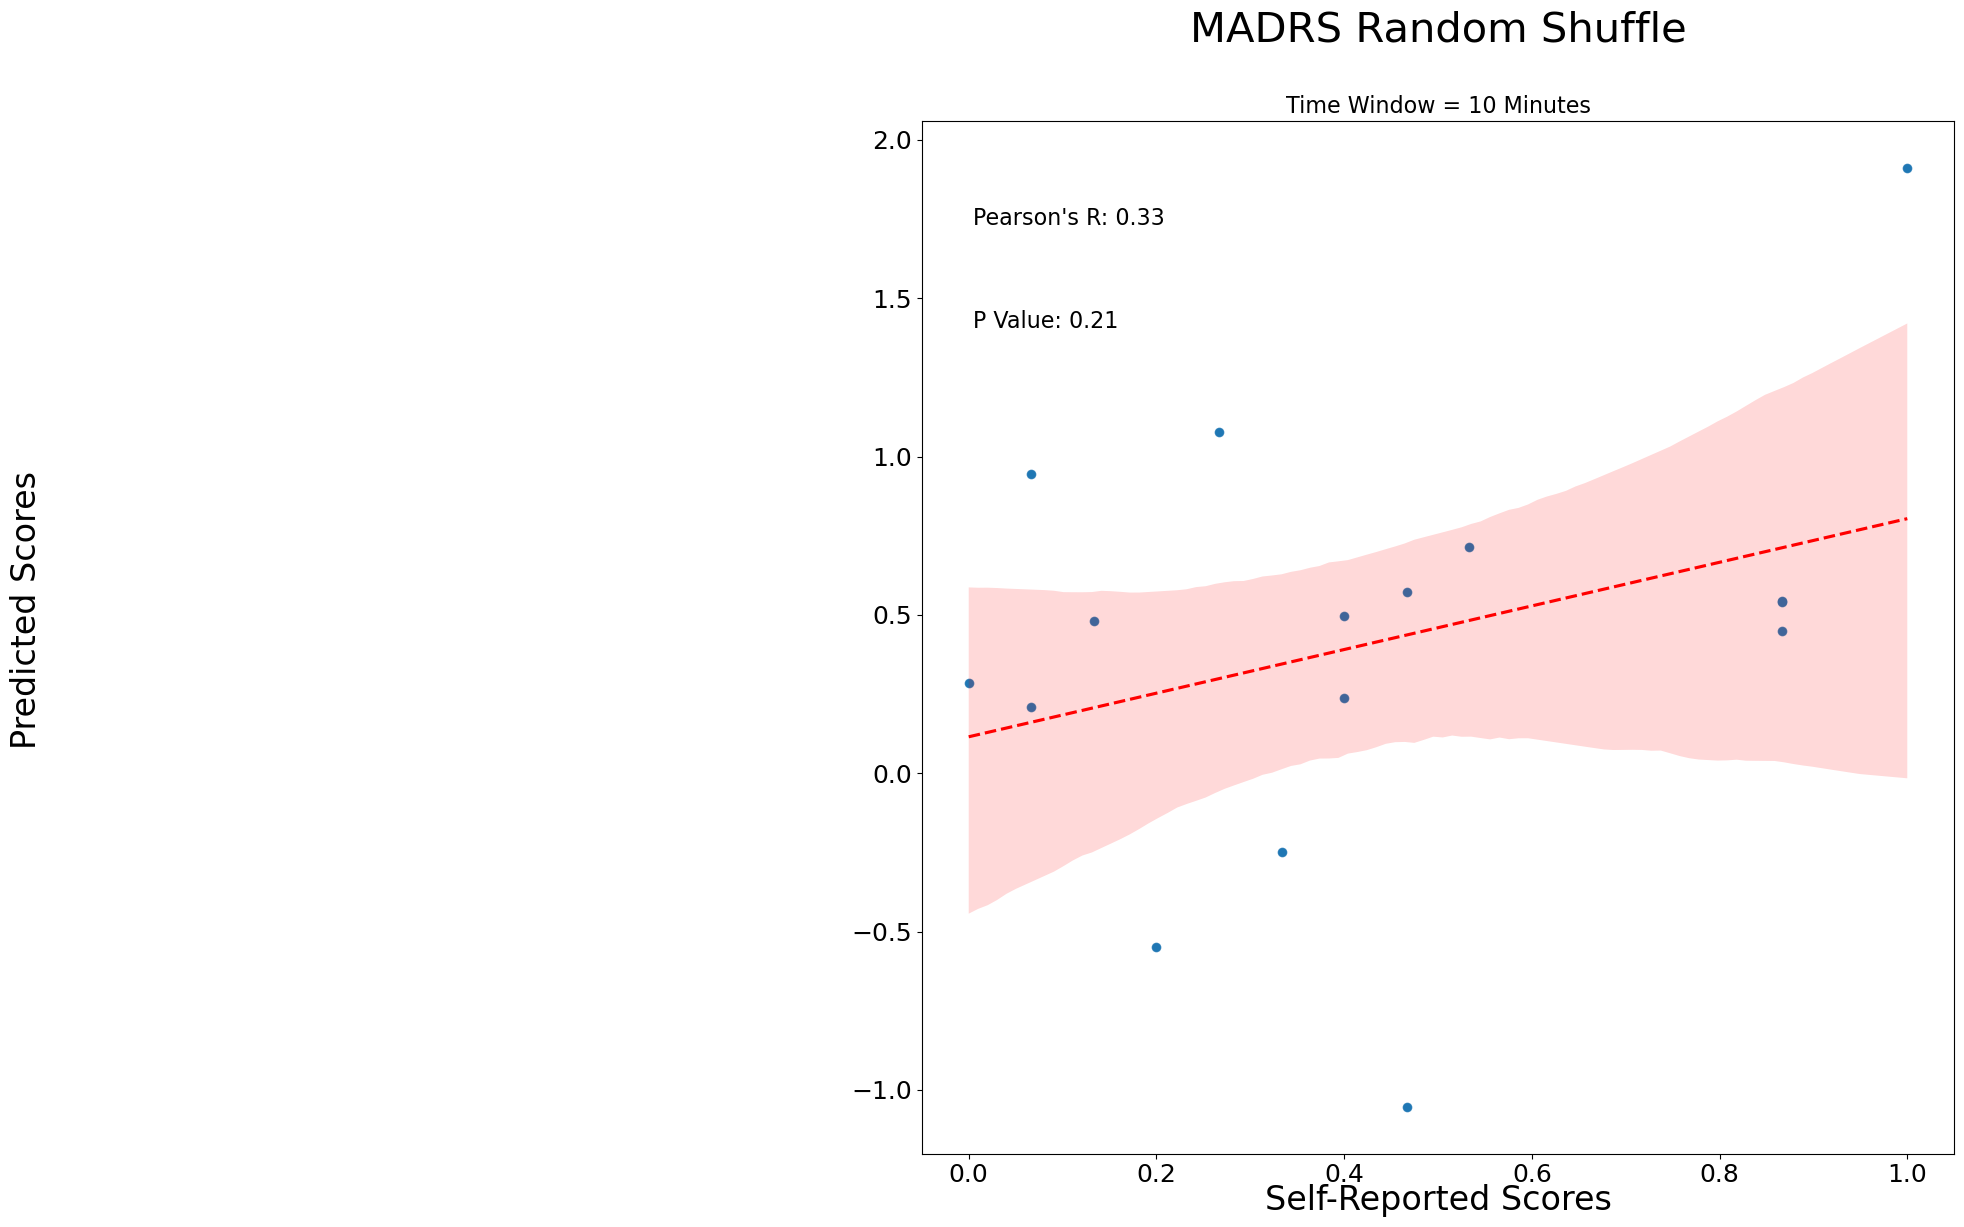

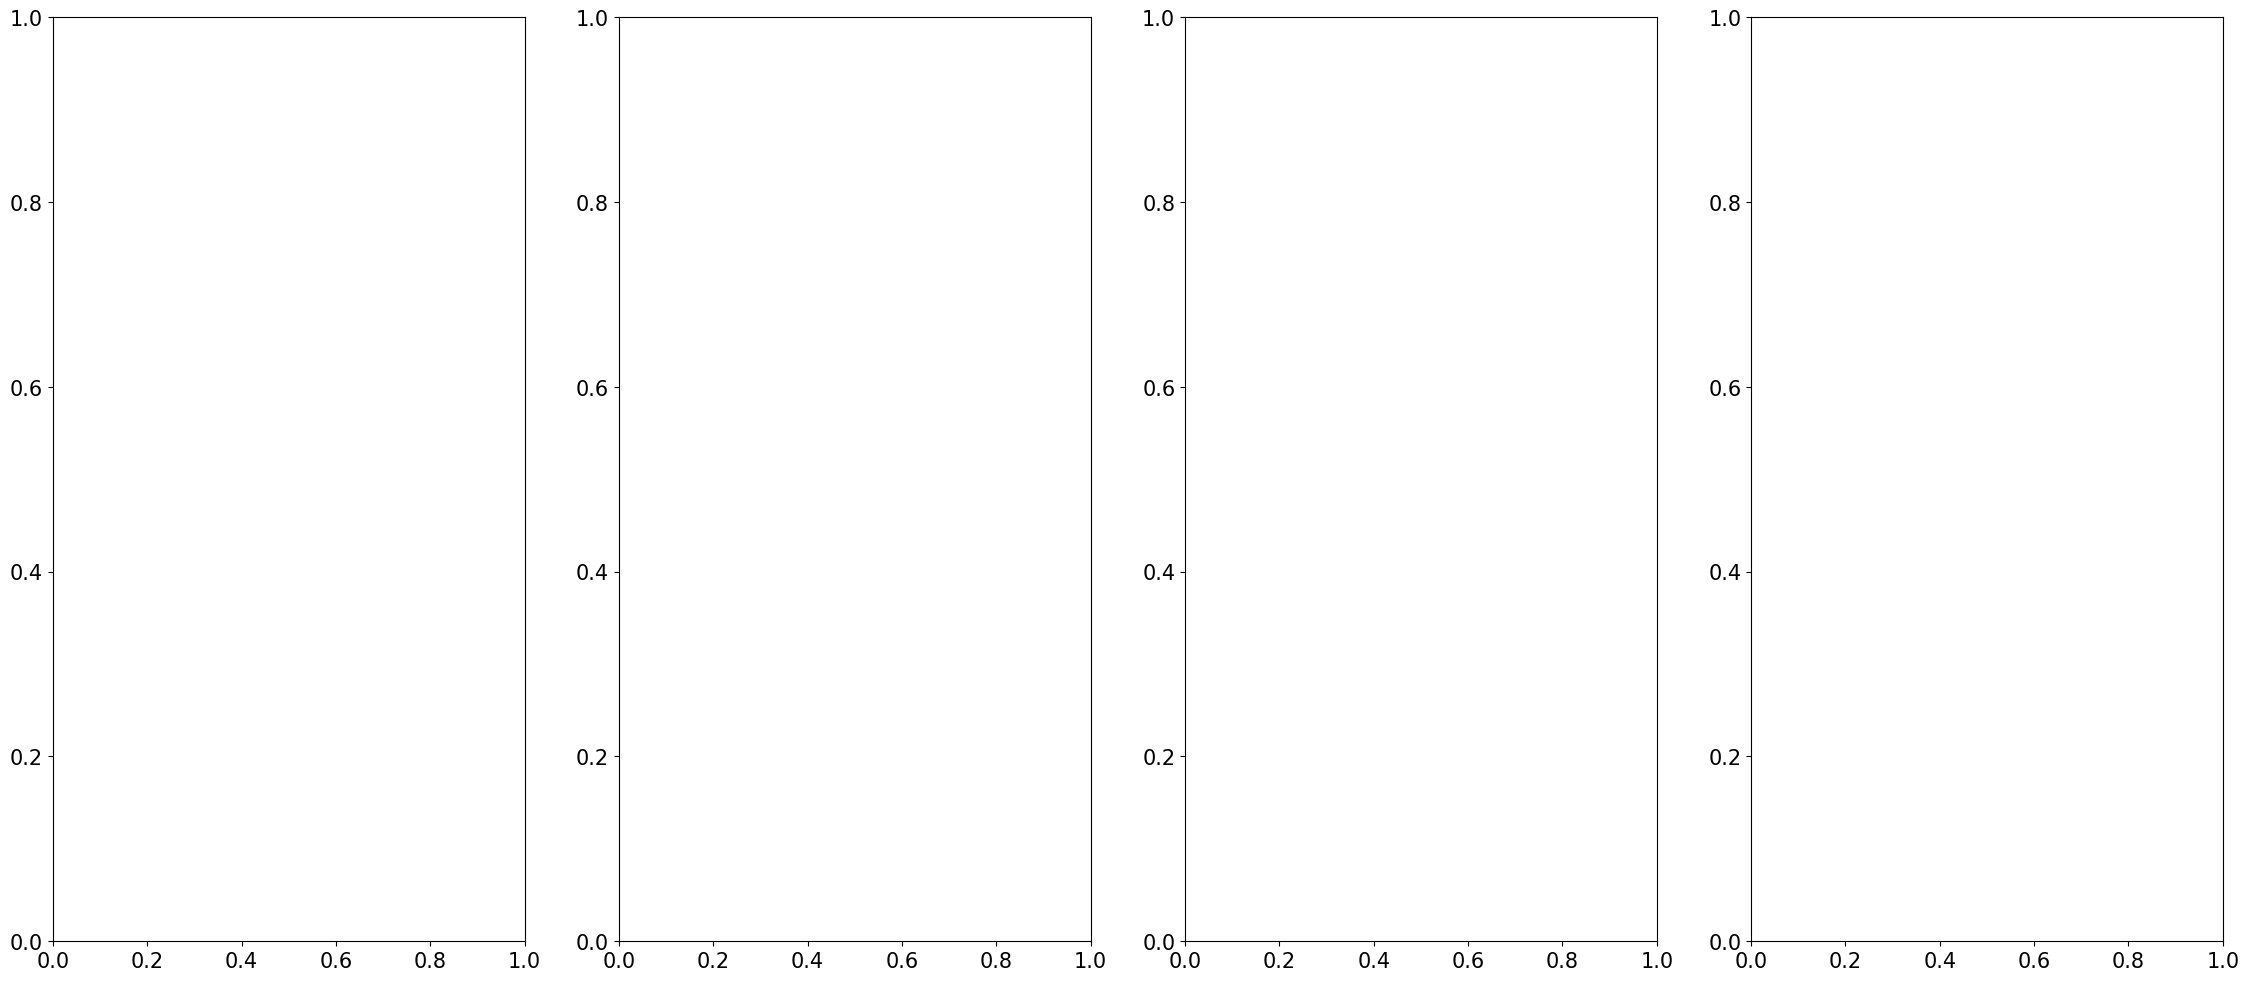

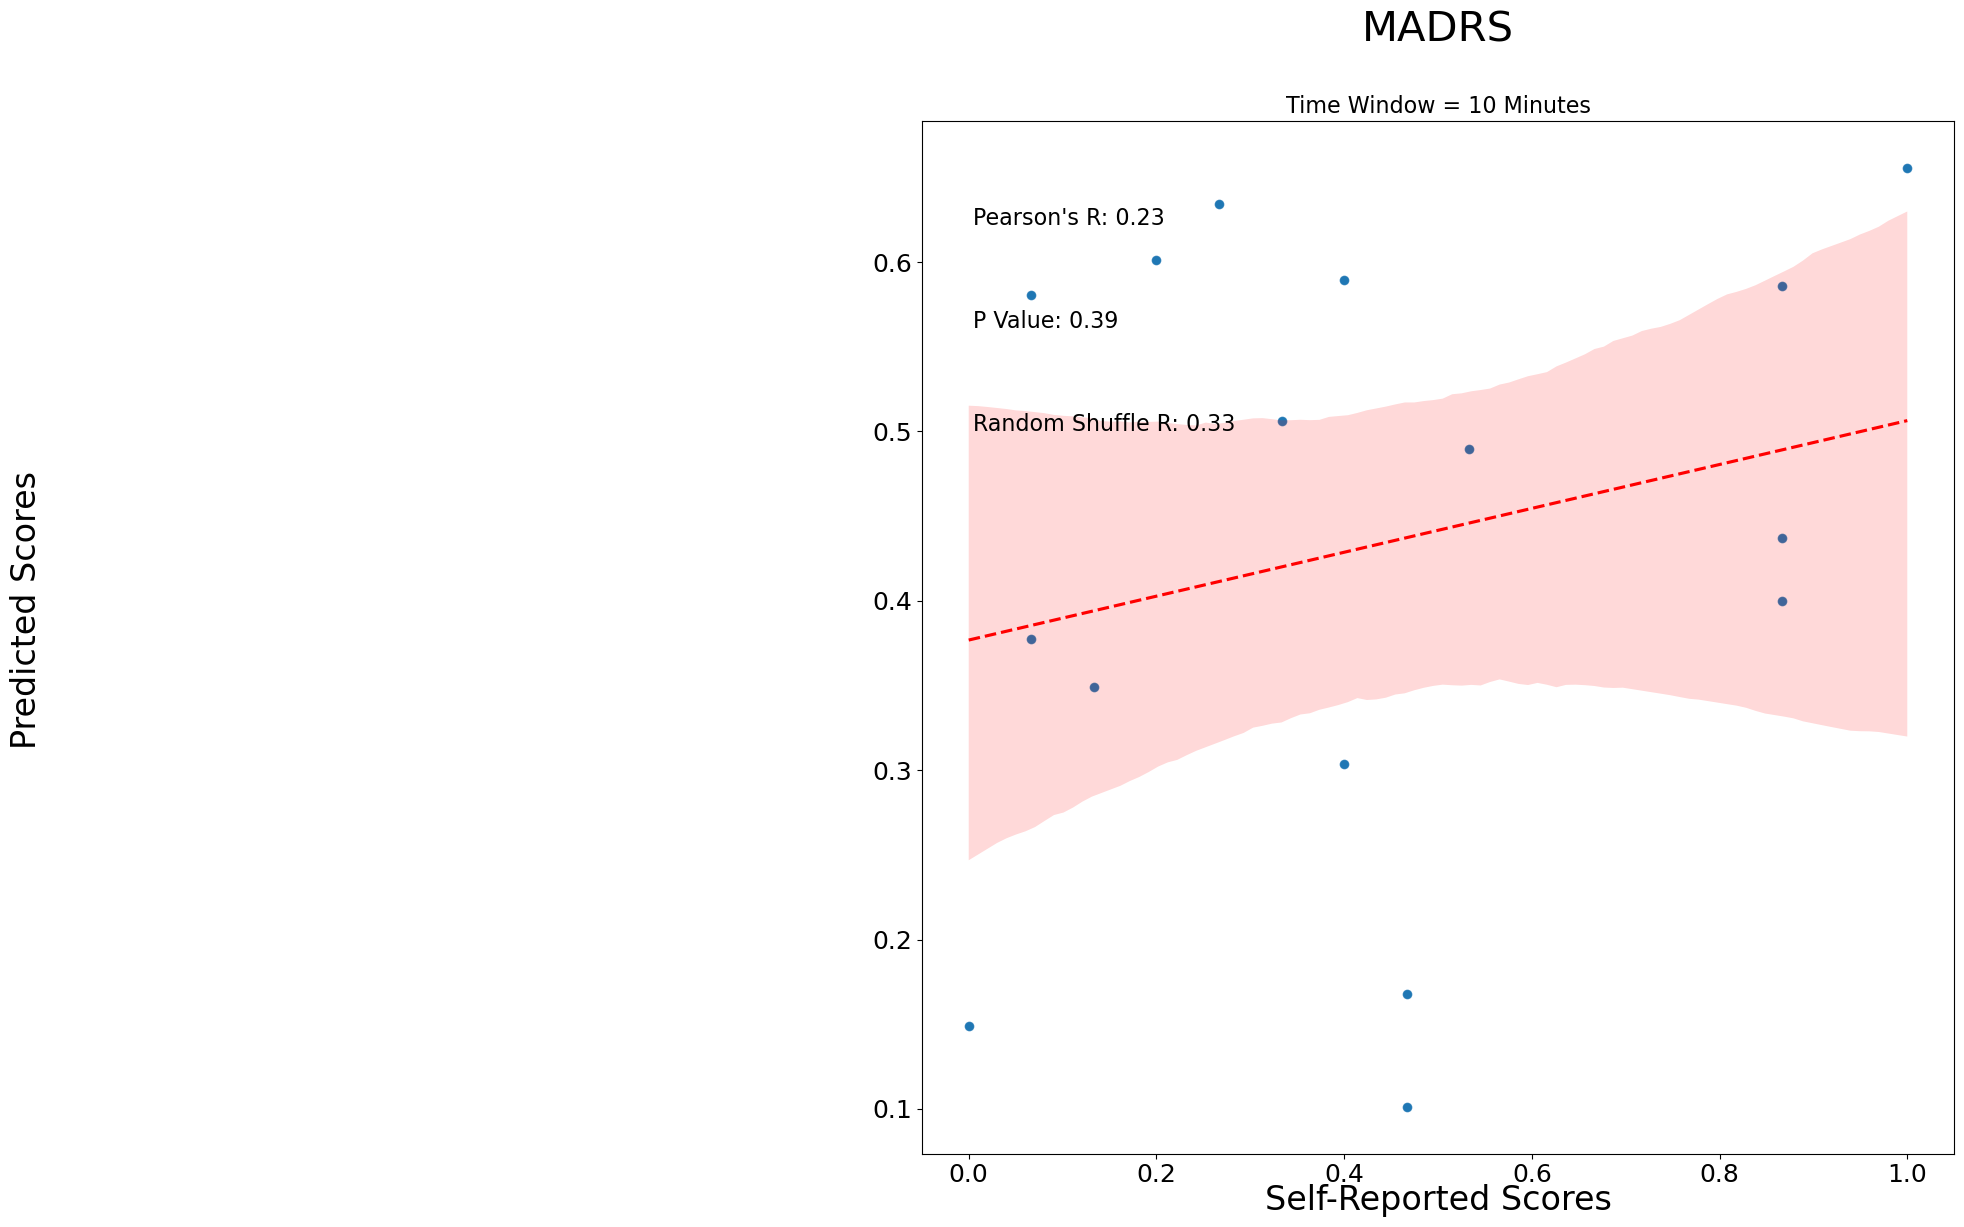

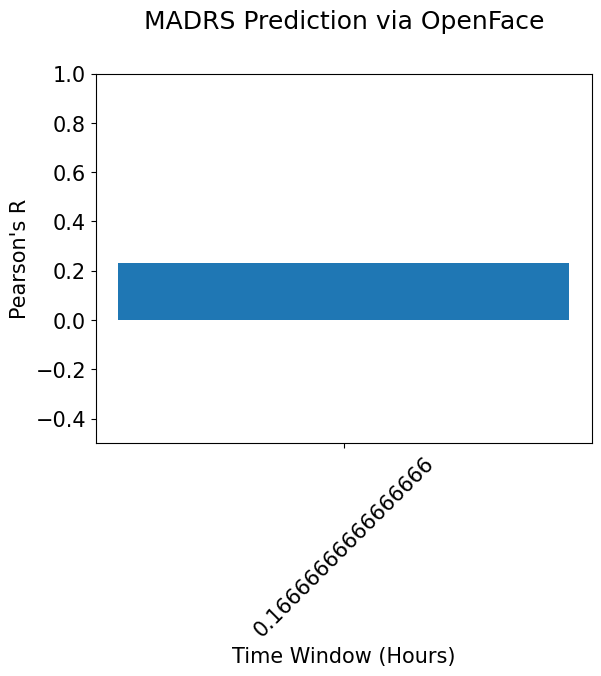

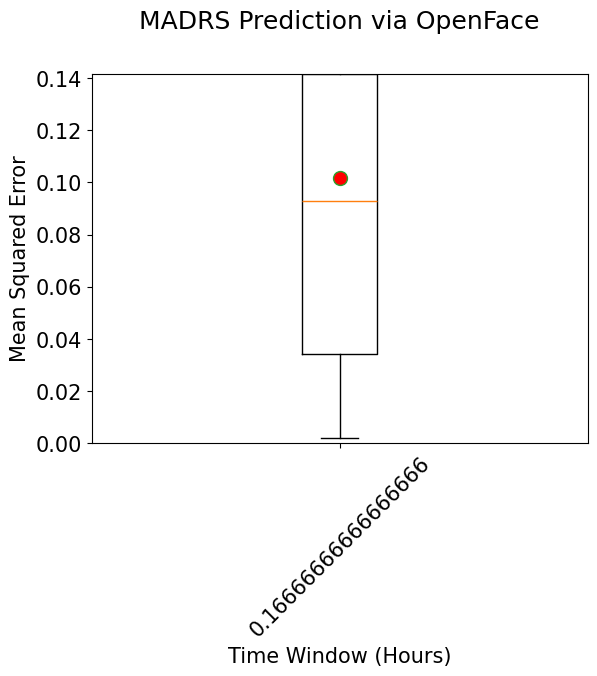

In [412]:
# ALPHA PARAMETER SEARCH FOR LASSO - RUN THIS FIRST!

all_metrics = [col for col in df_moodTracking.columns if col != 'Datetime']

FILE_ENDING = '.png'

# We are just searching using lasso regression
#RESULTS_PREFIX_LIST = ['OF_L_', 'OGAU_L_', 'OFAUHSE_L_', 'OGAUHSE_L_', 'HSE_L_', 'ALL_L_']
#RESULTS_PREFIX_LIST = ['OGAU_L_', 'OGAUHSE_L_', 'HSE_L_']
RESULTS_PREFIX_LIST = ['OF_L_']


EMOTIONS_FOR_SEARCH = ['MADRS'] # We are just searching on Mood
TIME_WINDOW_FOR_SEARCH = 10 # We are just searching 10 minutes

# List of alpha values to search through
ALPHAS_FOR_SEARCH = np.arange(0, 1, 0.1)
#ALPHAS_FOR_SEARCH = np.arange(0.1, 1, 0.1)
#ALPHAS_FOR_SEARCH = np.arange(0, 1.6, 0.1)
#ALPHAS_FOR_SEARCH = np.arange(0, 3, 0.2)
#ALPHAS_FOR_SEARCH = np.arange(0, 5, 0.2)


# This will populate with the best alphas for each prefix in RESULTS_PREFIX_LIST
best_alphas_lasso = {}

for RESULTS_PREFIX in RESULTS_PREFIX_LIST:
  do_lasso = False
  do_ridge = False

  if '_L_' in RESULTS_PREFIX:
    do_lasso = True

  if '_R_' in RESULTS_PREFIX:
    do_ridge = True


  if 'OF_' in RESULTS_PREFIX:
    spreadsheet_path = FEATURE_LABEL_PATH+f'experimental_openface_0.5_hours.xlsx'
    vectors_now = openface_vectors_dict
    method_now = 'OpenFace'

  elif 'OGAU_' in RESULTS_PREFIX:
    spreadsheet_path = FEATURE_LABEL_PATH+'opengraphau_0.5_hours.xlsx'
    vectors_now = opengraphau_vectors_dict
    method_now = 'OpenGraphAU'

  elif 'OFAUHSE_' in RESULTS_PREFIX:
    spreadsheet_path = FEATURE_LABEL_PATH+'ofauhse_0.5_hours.xlsx'
    vectors_now = ofauhsemotion_vectors_dict
    method_now = 'OFAU+HSE'

  elif 'OGAUHSE_' in RESULTS_PREFIX:
    spreadsheet_path = FEATURE_LABEL_PATH+'ogauhse_0.5_hours.xlsx'
    vectors_now = ogauhsemotion_vectors_dict
    method_now = 'OGAU+HSE'

  elif 'HSE_' in RESULTS_PREFIX:
    spreadsheet_path = FEATURE_LABEL_PATH+'hsemotion_0.5_hours.xlsx'
    vectors_now = hsemotion_vectors_dict
    method_now = 'HSEmotion'

  elif 'ALL_' in RESULTS_PREFIX:
    spreadsheet_path = FEATURE_LABEL_PATH+'all_0.5_hours.xlsx'
    vectors_now = all_vectors_dict
    method_now = 'ALL(OF+OG+HSE)'


  # Let's put each setting in its own folder!
  os.makedirs(RESULTS_PATH_BASE + 'SEARCH_Alpha_Lasso/' + RESULTS_PREFIX, exist_ok=True)
  results_prefix_unmodified = RESULTS_PREFIX
  RESULTS_PREFIX = 'SEARCH_Alpha_Lasso/' + RESULTS_PREFIX + '/' + RESULTS_PREFIX

  # This will store the best R, averaged across all metrics we're testing, for each alpha
  pearson_r_list = []

  for alpha_now in ALPHAS_FOR_SEARCH:

    avg_best_R = 0

    # Loop through EMOTIONS_FOR_SEARCH
    for metric in EMOTIONS_FOR_SEARCH:
      print('METRIC NOW: ', metric)
      vectors_return, y = extractOneMetric(metric, vectors_now=vectors_now)

      # Limit to just one time window for alpha search
      tmp_vectors = vectors_return
      vectors_return = {}
      vectors_return[TIME_WINDOW_FOR_SEARCH] = tmp_vectors[TIME_WINDOW_FOR_SEARCH]
      del tmp_vectors

      scores, preds, y, models = linRegOneMetric(vectors_return, y, do_lasso=do_lasso, do_ridge=do_ridge, alpha=alpha_now)
      scores_r, preds_r, _, models_r = linRegOneMetric(vectors_return, y, randShuffle=True, alpha=alpha_now)

      # make scatterplots
      randShuffleR, _, _ = plot_scatterplots(preds_r, y, f'{metric} Random Shuffle', RESULTS_PATH_BASE + f'{RESULTS_PREFIX}{metric}_linReg_scatterRand_{alpha_now}{FILE_ENDING}')
      r_list, p_list, scatterFig = plot_scatterplots(preds, y, metric, RESULTS_PATH_BASE + f'{RESULTS_PREFIX}{metric}_linReg_scatterplots_{alpha_now}{FILE_ENDING}', randShuffleR=randShuffleR)

      # Determine our best time radius for this metric based on Pearson's R
      best_time_radius = list(scores.keys())[np.argmax(r_list)]
      best_mse_list = scores[best_time_radius]
      best_avg_mse = np.mean(scores[best_time_radius])
      best_pearson_r = r_list[np.argmax(r_list)]

      # Add to our avg best R
      avg_best_R = avg_best_R + best_pearson_r

      # bar plot for pearson r
      rPlotFig = make_r_barplot(r_list, list(scores.keys()), metric, RESULTS_PATH_BASE + f'{RESULTS_PREFIX}{metric}_linReg_R_{alpha_now}{FILE_ENDING}', method_now=method_now)

      # make MSE plot
      MSEPlotFig = make_mse_boxplot(scores, metric, RESULTS_PATH_BASE + f'{RESULTS_PREFIX}{metric}_linReg_MSE_{alpha_now}{FILE_ENDING}', method_now=method_now)

    # Add one R value for this alpha value to pearson_r_list
    avg_best_R = avg_best_R / len(EMOTIONS_FOR_SEARCH)
    pearson_r_list.append(avg_best_R)

  # Plot R vs. alpha for this setting
  plot_pearsons_r_vs_alpha(pearson_r_list=pearson_r_list, ALPHAS_FOR_SEARCH=ALPHAS_FOR_SEARCH, method=method_now, save_path=RESULTS_PATH_BASE + f'{RESULTS_PREFIX}{metric}_Alpha_Search{FILE_ENDING}')

  # Find best alpha for this setting
  best_index_of_alpha = np.argmax(pearson_r_list)
  best_alpha_value = ALPHAS_FOR_SEARCH[best_index_of_alpha]
  best_alphas_lasso[results_prefix_unmodified] = best_alpha_value


In [367]:
# SAVE VARIABLES

save_var(best_alphas_lasso, forced_name=f'best_alphas_lasso_{PAT_NOW}')



In [ ]:
# LOAD VARIABLES

best_alphas_lasso = load_var(f'best_alphas_lasso_{PAT_NOW}')



## Core Plots

METRIC NOW:  MADRS


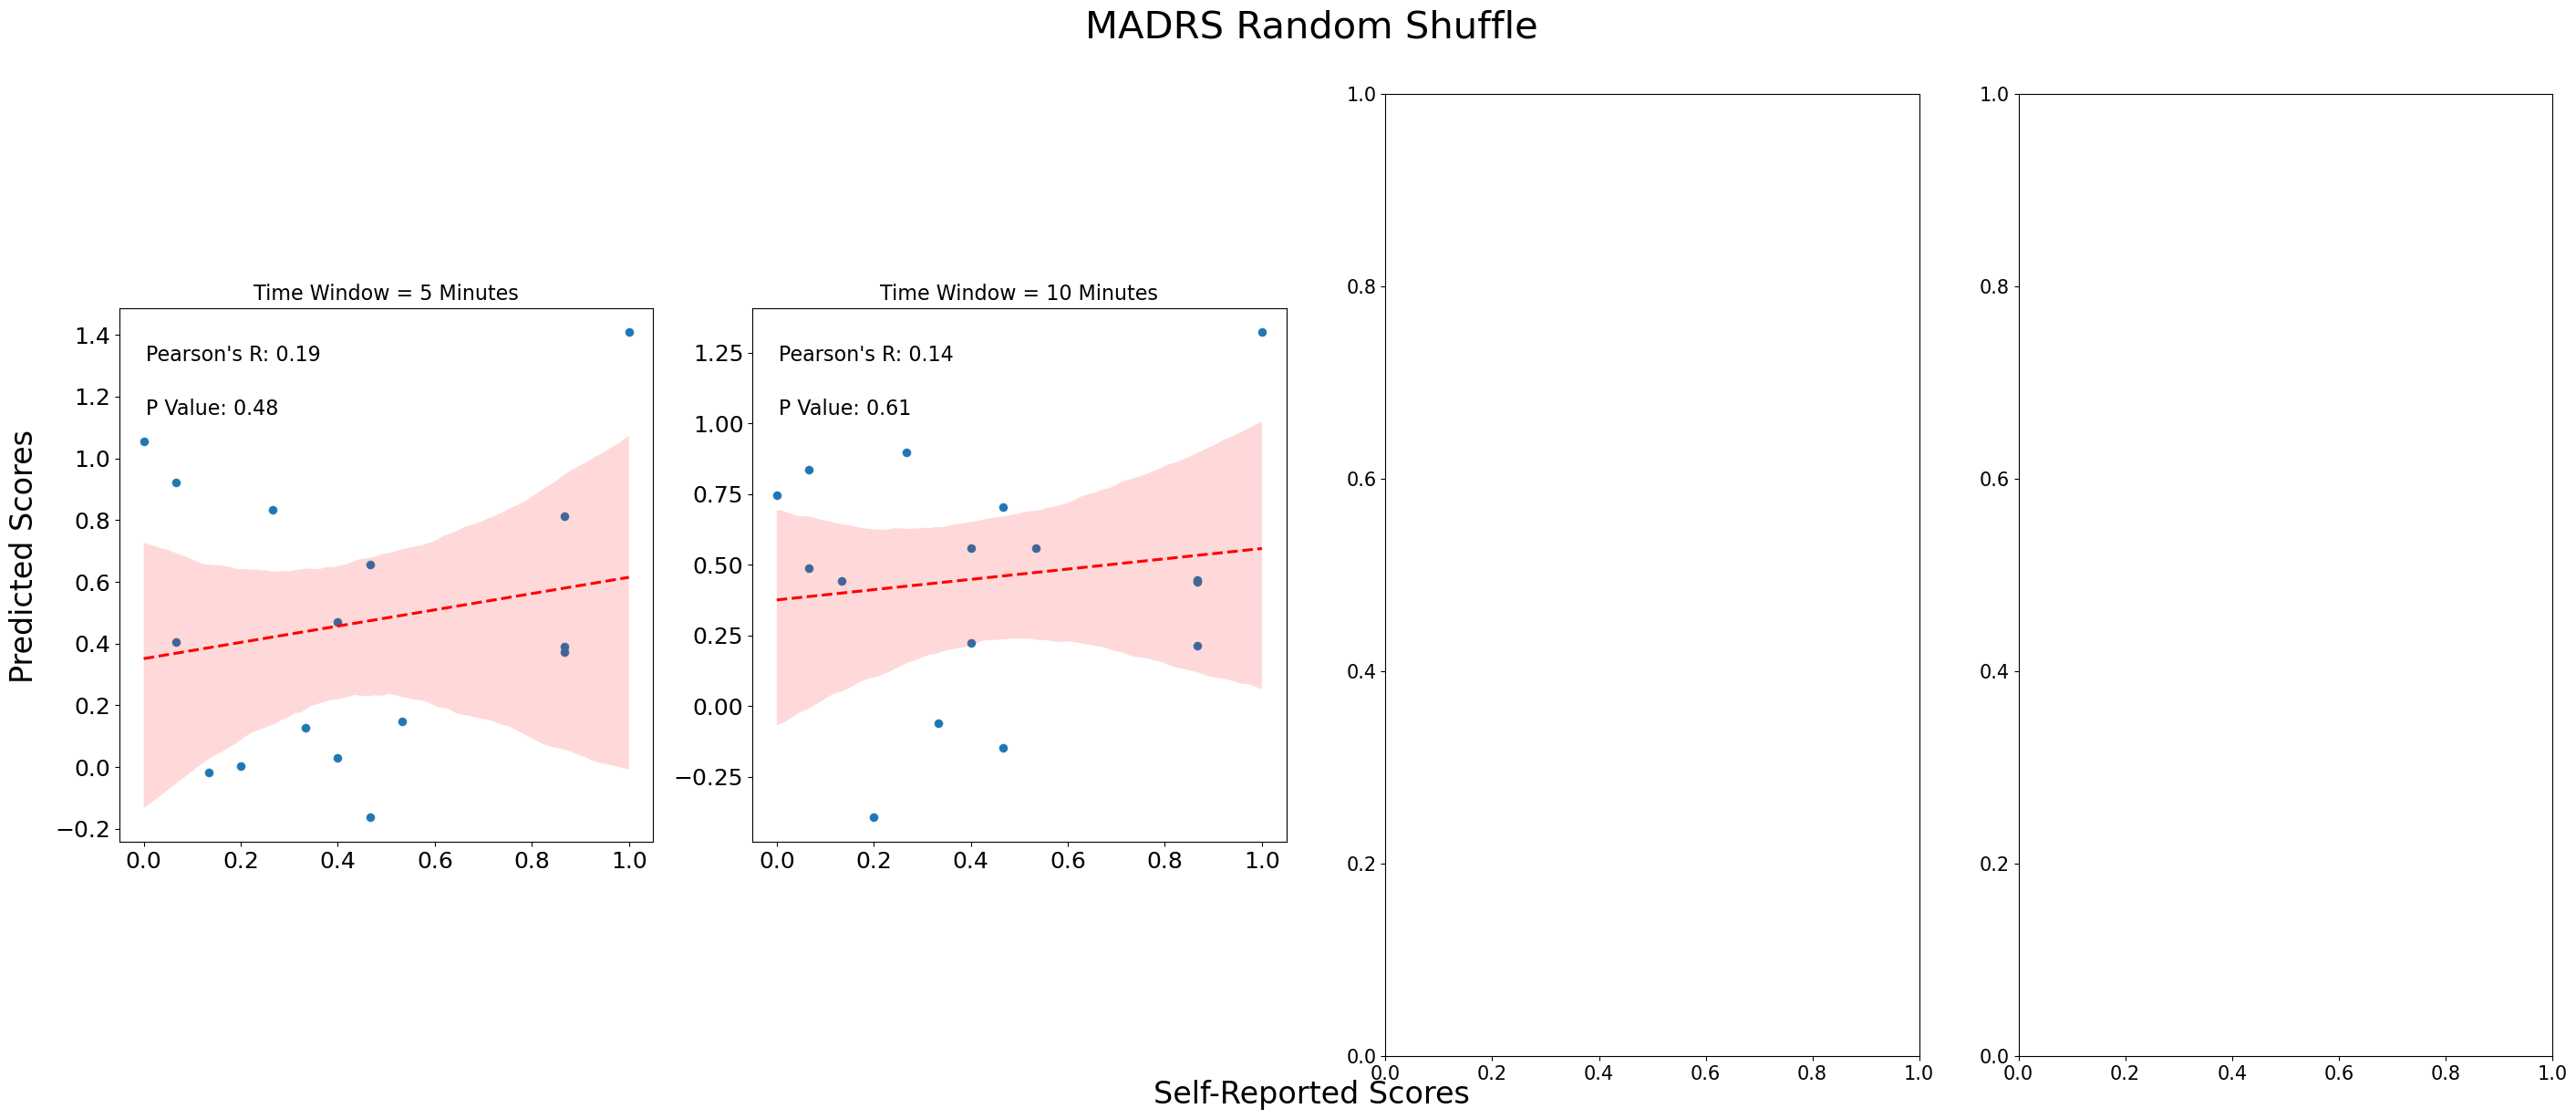

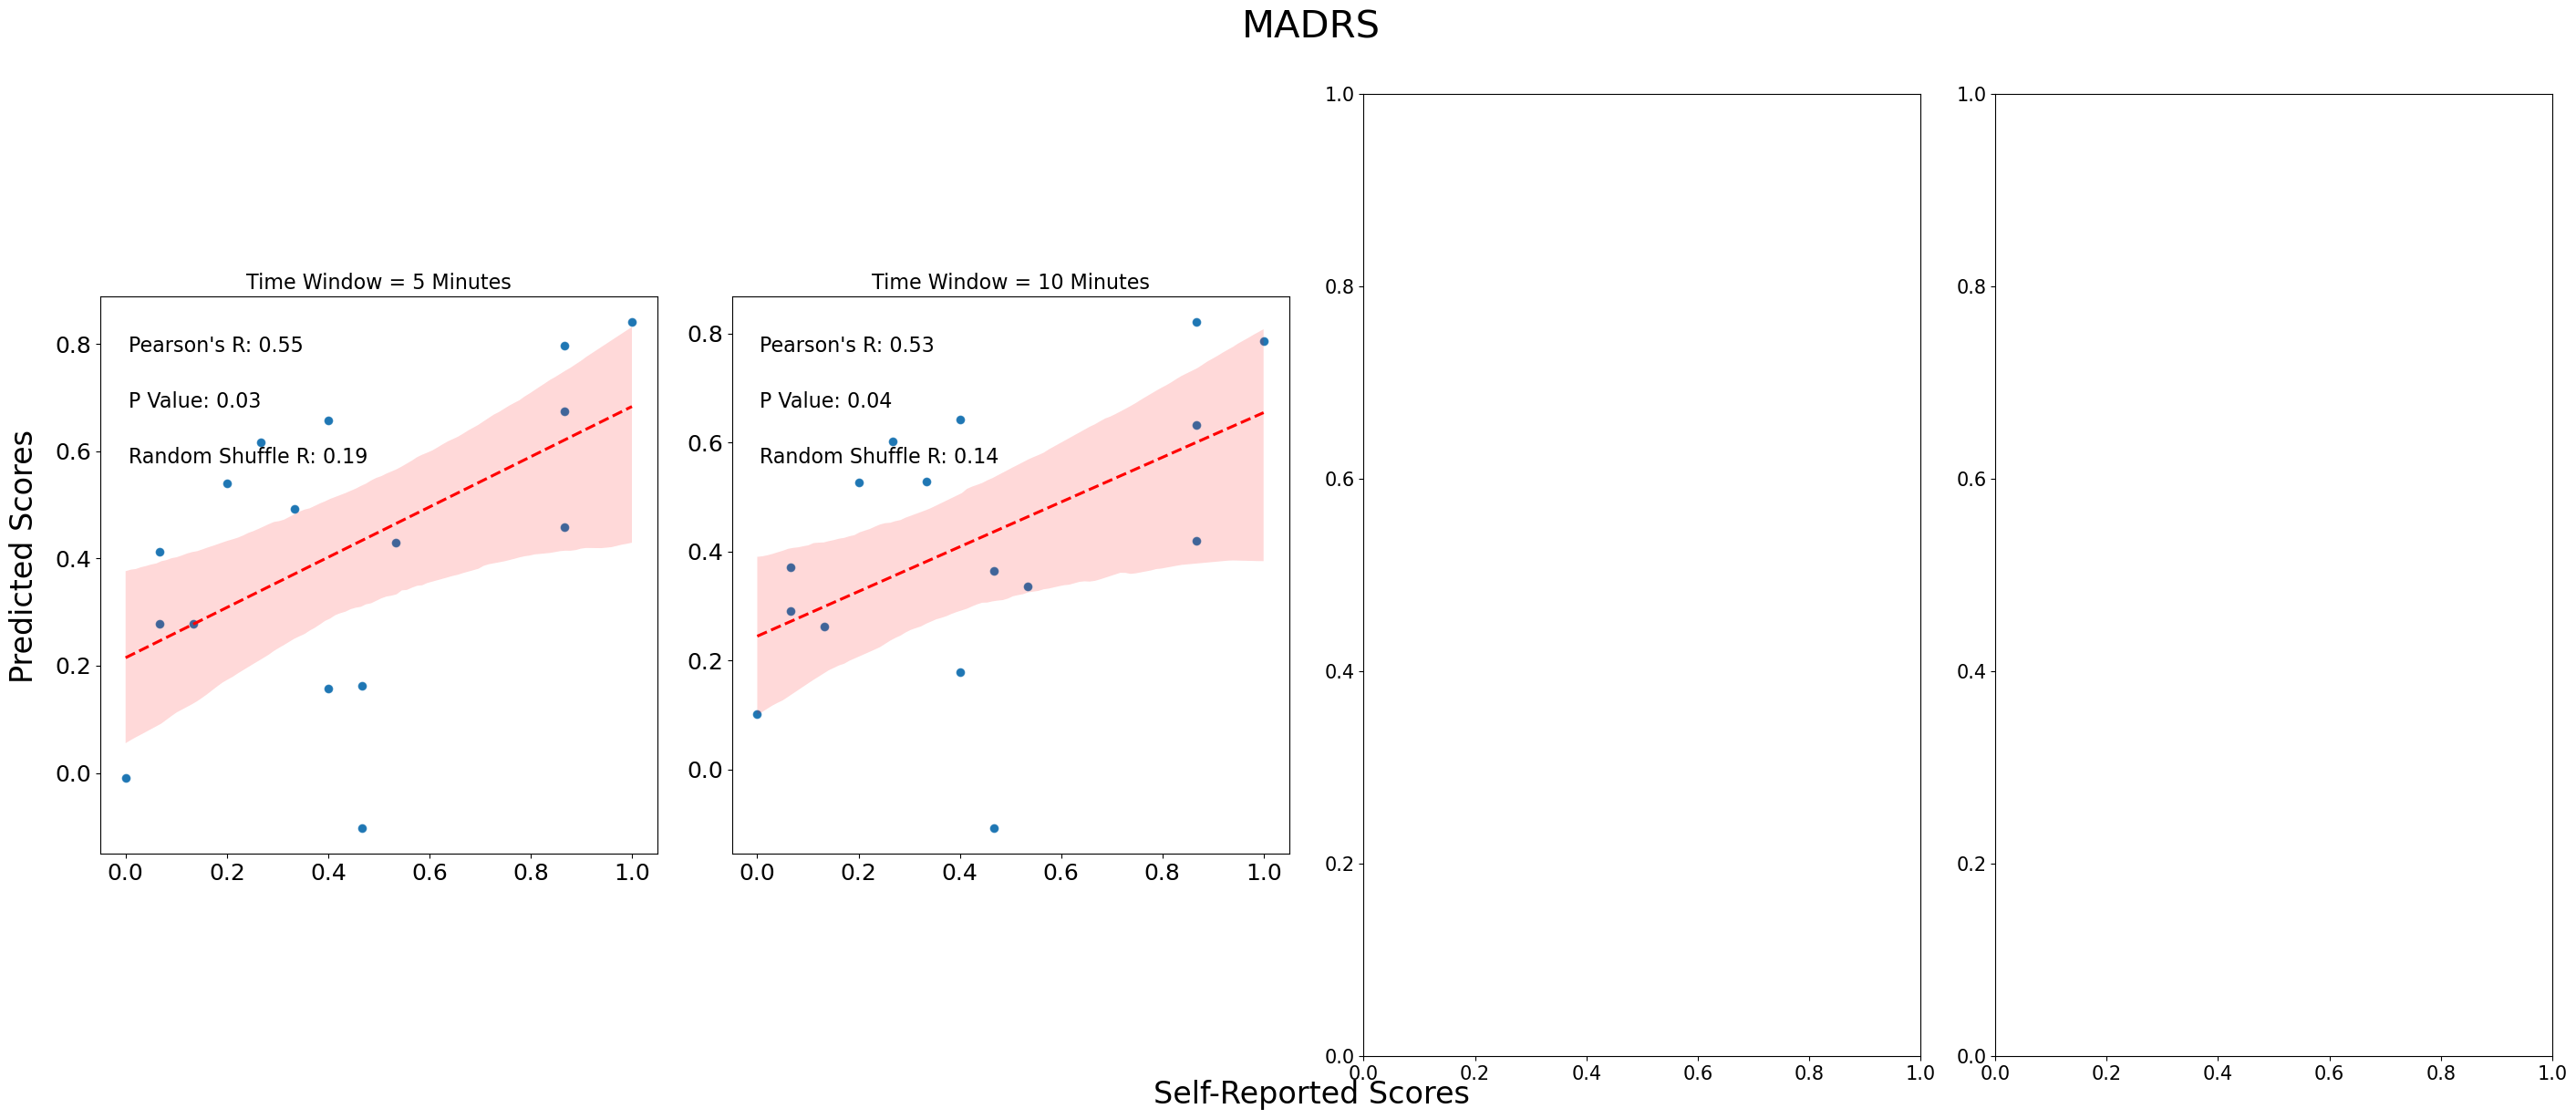

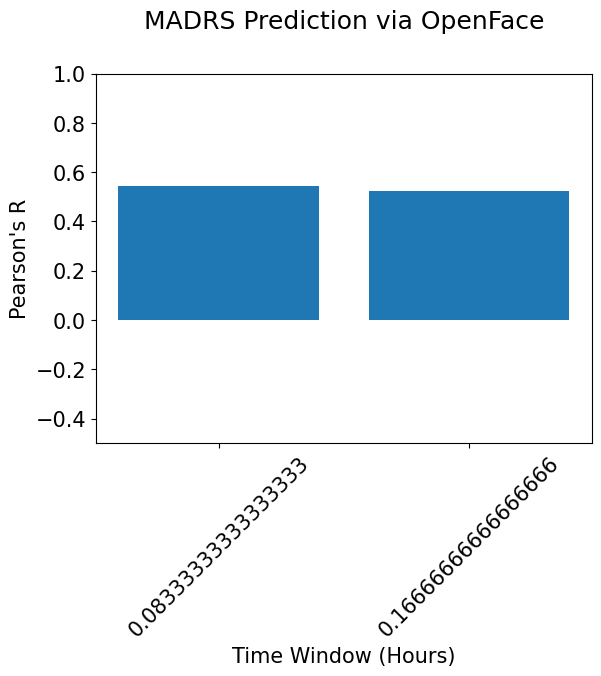

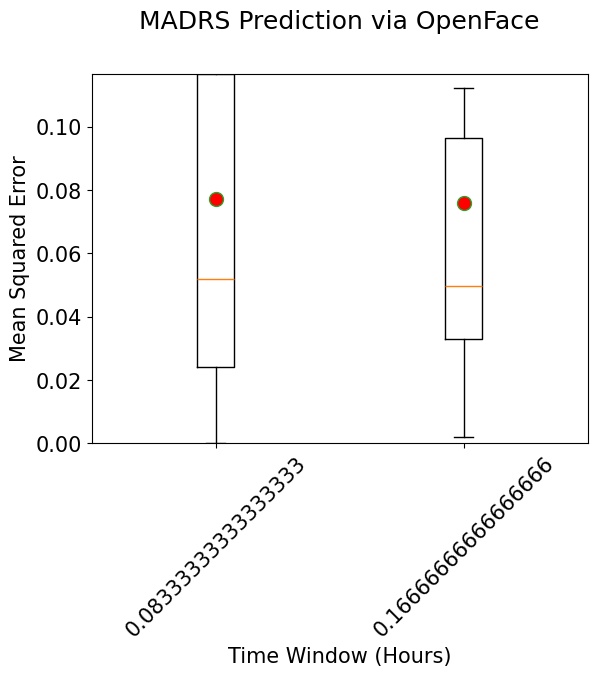

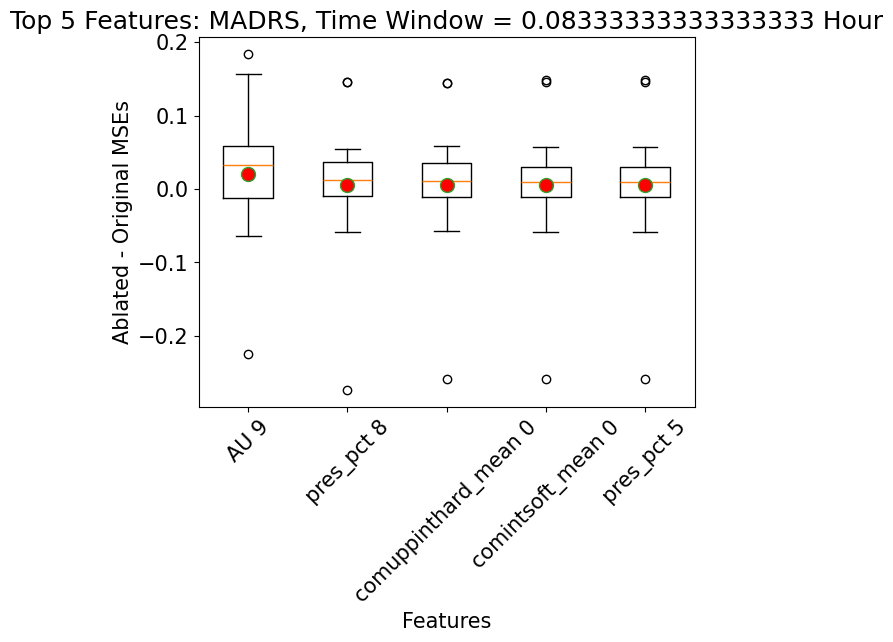

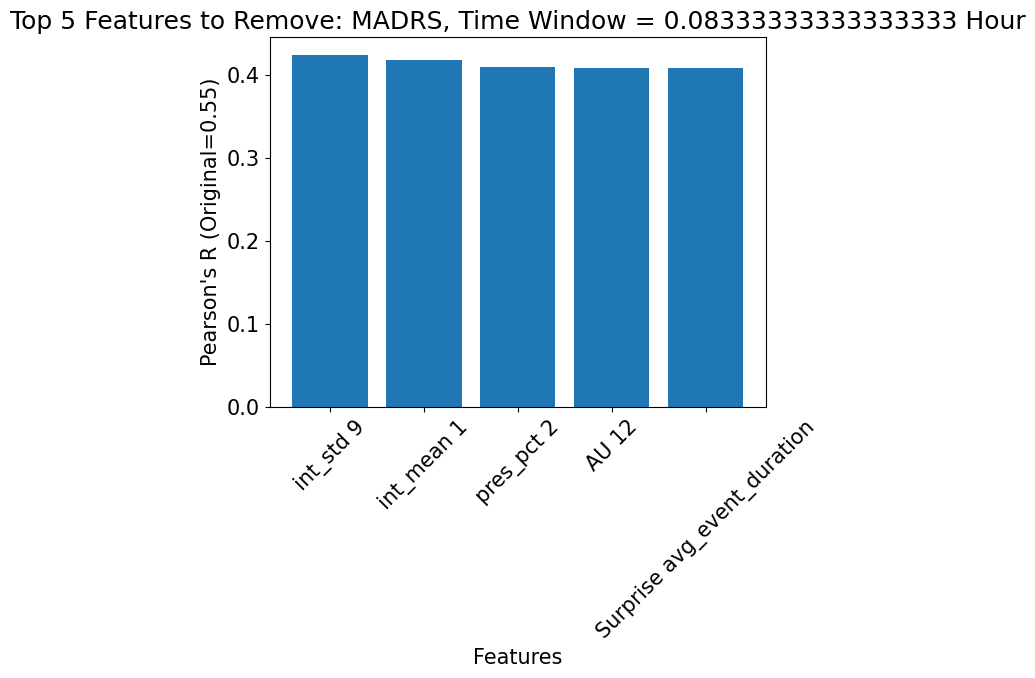

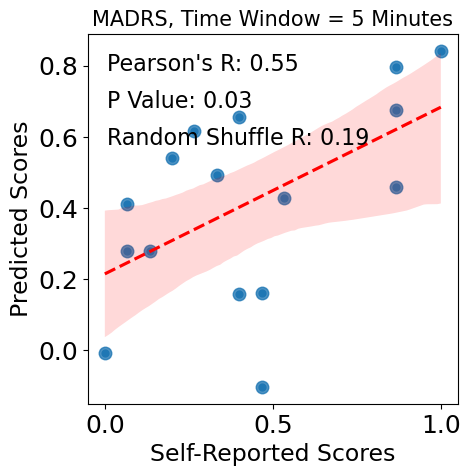

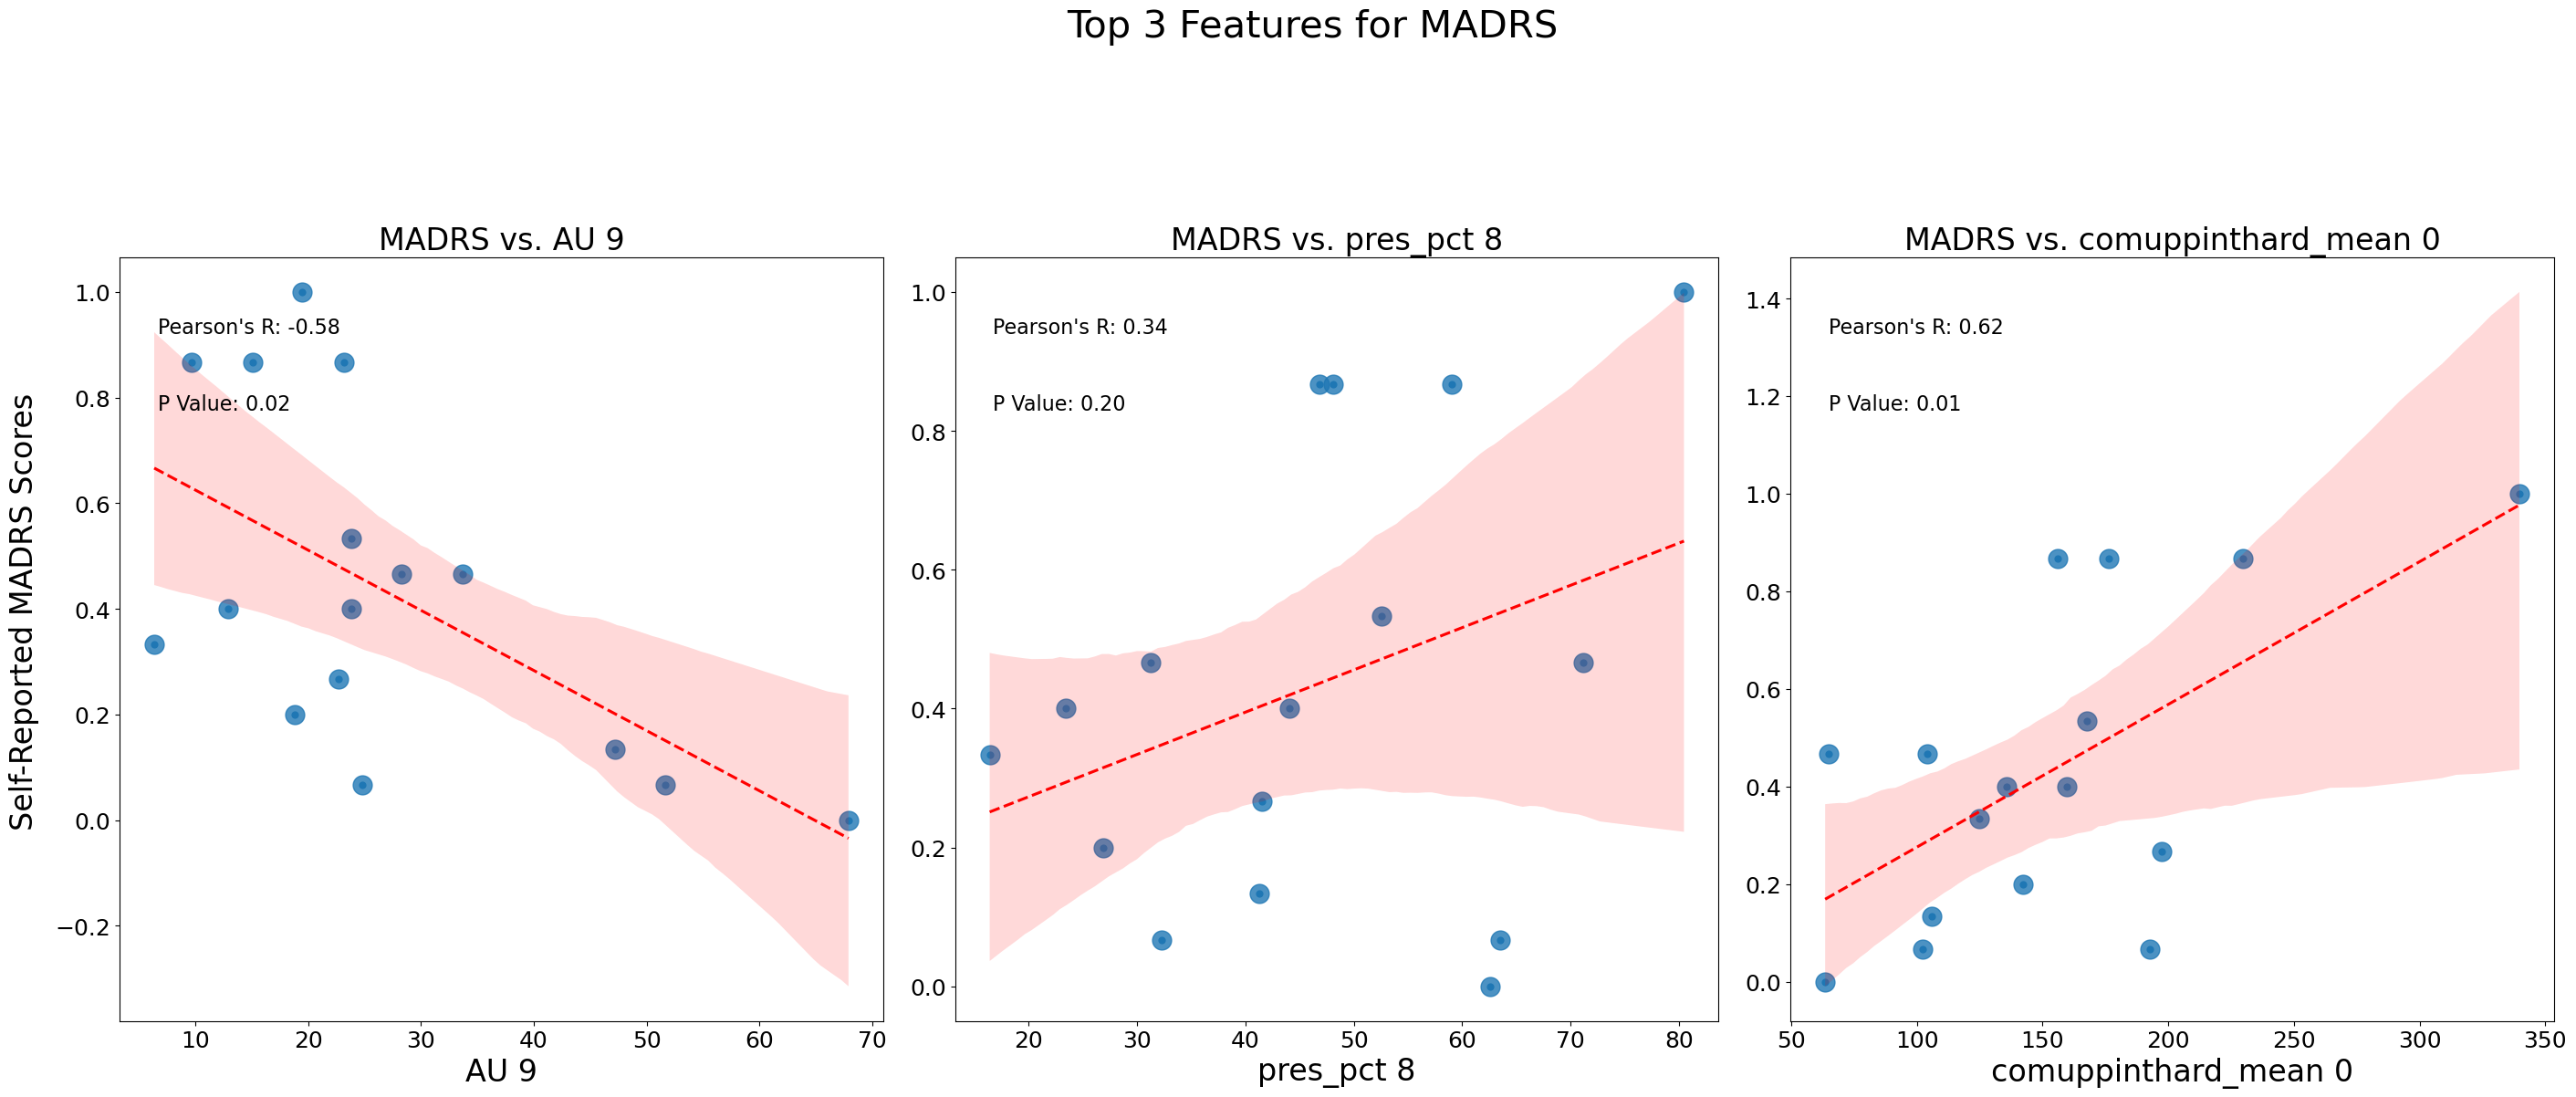

In [413]:
# GENERATE ALL PLOTS! ONE CODE BLOCK

if 'best_alphas_lasso' not in globals():
    raise NameError("GO RUN THE LASSO ALPHA PARAMETER SEARCH BLOCK FIRST!")

#all_metrics = [col for col in df_moodTracking.columns if col != 'Datetime']
#all_metrics = ['Mood', 'Anxiety', 'Hunger']
all_metrics = ['MADRS']


FILE_ENDING = '.png'
# RESULTS_PREFIX_LIST = ['OF_', 'OGAU_', 'OFAUHSE_', 'OGAUHSE_', 'HSE_', 'ALL_',
#                        'OF_L_', 'OGAU_L_', 'OFAUHSE_L_', 'OGAUHSE_L_', 'HSE_L_', 'ALL_L_',
#                        'OF_R_', 'OGAU_R_', 'OFAUHSE_R_', 'OGAUHSE_R_', 'HSE_R_', 'ALL_R_']

# RESULTS_PREFIX_LIST = ['OF_L_', 'OGAUHSE_L_', 'OGAU_L_', 'OFAUHSE_L_', 'HSE_L_', 'ALL_L_']

#RESULTS_PREFIX_LIST = ['OGAU_L_', 'OGAUHSE_L_', 'HSE_L_']

RESULTS_PREFIX_LIST = ['OF_L_']

# Do we remove ground truth labels that are over 2 standard deviations from the mean?
REMOVE_OUTLIERS = False


for RESULTS_PREFIX in RESULTS_PREFIX_LIST:
  do_lasso = False
  do_ridge = False

  if '_L_' in RESULTS_PREFIX:
    do_lasso = True

  if '_R_' in RESULTS_PREFIX:
    do_ridge = True


  if 'OF_' in RESULTS_PREFIX:
    spreadsheet_path = FEATURE_LABEL_PATH+'experimental_openface_0.5_hours.xlsx'
    vectors_now = openface_vectors_dict
    method_now = 'OpenFace'

  elif 'OGAU_' in RESULTS_PREFIX:
    spreadsheet_path = FEATURE_LABEL_PATH+'opengraphau_0.5_hours.xlsx'
    vectors_now = opengraphau_vectors_dict
    method_now = 'OpenGraphAU'

  elif 'OFAUHSE_' in RESULTS_PREFIX:
    spreadsheet_path = FEATURE_LABEL_PATH+'ofauhse_0.5_hours.xlsx'
    vectors_now = ofauhsemotion_vectors_dict
    method_now = 'OFAU+HSE'

  elif 'OGAUHSE_' in RESULTS_PREFIX:
    spreadsheet_path = FEATURE_LABEL_PATH+'ogauhse_0.5_hours.xlsx'
    vectors_now = ogauhsemotion_vectors_dict
    method_now = 'OGAU+HSE'

  elif 'HSE_' in RESULTS_PREFIX:
    spreadsheet_path = FEATURE_LABEL_PATH+'hsemotion_0.5_hours.xlsx'
    vectors_now = hsemotion_vectors_dict
    method_now = 'HSEmotion'

  elif 'ALL_' in RESULTS_PREFIX:
    spreadsheet_path = FEATURE_LABEL_PATH+'all_0.5_hours.xlsx'
    vectors_now = all_vectors_dict
    method_now = 'ALL(OF+OG+HSE)'


  # Let's put each setting in its own folder!
  os.makedirs(RESULTS_PATH_BASE + RESULTS_PREFIX, exist_ok=True)
  results_prefix_unmodified = RESULTS_PREFIX
  RESULTS_PREFIX = RESULTS_PREFIX + '/' + RESULTS_PREFIX


  # Loop through metrics (Anxiety, Depression, Mood, etc.)
  for metric in all_metrics:
    print('METRIC NOW: ', metric)
    if do_lasso:
      alpha_now = best_alphas_lasso[results_prefix_unmodified]
    elif do_ridge:
      alpha_now = best_alphas_ridge[results_prefix_unmodified]
    else:
      # Neither lasso nor ridge, so alpha is irrelevant
      alpha_now = 1.0

    vectors_return, y = extractOneMetric(metric, vectors_now=vectors_now, remove_outliers=REMOVE_OUTLIERS)
    scores, preds, y, models = linRegOneMetric(vectors_return, y, do_lasso=do_lasso, do_ridge=do_ridge, alpha=alpha_now)
    scores_r, preds_r, _, models_r = linRegOneMetric(vectors_return, y, randShuffle=True, alpha=alpha_now)

    # make scatterplots
    randShuffleR, _, _ = plot_scatterplots(preds_r, y, f'{metric} Random Shuffle', RESULTS_PATH_BASE + f'{RESULTS_PREFIX}{metric}_linReg_scatterRand{FILE_ENDING}')
    r_list, p_list, scatterFig = plot_scatterplots(preds, y, metric, RESULTS_PATH_BASE + f'{RESULTS_PREFIX}{metric}_linReg_scatterplots{FILE_ENDING}', randShuffleR=randShuffleR)

    # Determine our best time radius for this metric based on Pearson's R
    best_time_radius = list(scores.keys())[np.argmax(r_list)]
    best_mse_list = scores[best_time_radius]
    best_avg_mse = np.mean(scores[best_time_radius])
    best_pearson_r = r_list[np.argmax(r_list)]

    # bar plot for pearson r
    rPlotFig = make_r_barplot(r_list, list(scores.keys()), metric, RESULTS_PATH_BASE + f'{RESULTS_PREFIX}{metric}_linReg_R{FILE_ENDING}', method_now=method_now)

    # make MSE plot
    MSEPlotFig = make_mse_boxplot(scores, metric, RESULTS_PATH_BASE + f'{RESULTS_PREFIX}{metric}_linReg_MSE{FILE_ENDING}', method_now=method_now)

    # Feature ablation
    feat_ab_scores, feat_ab_prs = featureAblate(vectors_return[best_time_radius], y, do_lasso=do_lasso, do_ridge=do_ridge)

    top_indices, featAbMSEFig = plotFeatAbMSEs(feat_ab_scores, best_mse_list, metric, best_time_radius, savepath=RESULTS_PATH_BASE + f'{RESULTS_PREFIX}{metric}_featAblate_MSEs{FILE_ENDING}', spreadsheet_path=spreadsheet_path)
    plotFeatAbPRs(feat_ab_prs, best_pearson_r, metric, best_time_radius, savepath=RESULTS_PATH_BASE + f'{RESULTS_PREFIX}{metric}_featAblate_R{FILE_ENDING}', spreadsheet_path=spreadsheet_path)

    # extract just ONE scatterplot (the best pearson's R) and save it individually
    plt.rcParams['lines.markersize'] = 9
    _, _, bestScatterFig = plot_predictions(y, preds[best_time_radius], randShuffleR=randShuffleR[np.argmax(r_list)], ax=None, time_rad=best_time_radius, metric=metric)
    bestScatterFig.savefig(RESULTS_PATH_BASE + f'{RESULTS_PREFIX}{metric}_linReg_bestScatter{FILE_ENDING}', bbox_inches='tight')

    # Plot top n features vs. self-reported scores
    PLOT_NOW = 3
    plot_feat_scatterplots(vectors_array=vectors_return[best_time_radius], y=y, feat_ind_list=top_indices[:PLOT_NOW], metric=metric, savepath=RESULTS_PATH_BASE + f'{RESULTS_PREFIX}{metric}_topFeats{FILE_ENDING}', spreadsheet_path=spreadsheet_path)
